In [9]:
import cv2
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer
import matplotlib.pyplot as plt


In [10]:
class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, self.input_shape[:2][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.vocab)[0]

        return text

In [11]:
# salvar imagem com sua label e predição

def save_image(image_path, label, prediction_text, distance):
    image = cv2.imread(image_path)
    plt.imshow(image)
    plt.title(f"Label: {label}, Prediction: {prediction_text}, Distance: {distance}")
    plt.savefig(f"../data/imagens/{image_path.split('/')[-1]}")

  0%|          | 0/9646 [00:00<?, ?it/s]

  0%|          | 1/9646 [00:00<17:26,  9.22it/s]

Image: ../data/iam_data/words/d01/d01-118/d01-118-04-00.png, Label: writing, Prediction: wuting, CER: 0.2857142857142857, Distance: 2 
Image: ../data/iam_data/words/k03/k03-152/k03-152-07-08.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


  0%|          | 4/9646 [00:00<13:18, 12.07it/s]

Image: ../data/iam_data/words/j04/j04-053/j04-053-00-05.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/c02/c02-059/c02-059-02-01.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/n04/n04-068/n04-068-01-06.png, Label: back, Prediction: back, CER: 0.0, Distance: 0 


  0%|          | 6/9646 [00:00<13:31, 11.87it/s]

Image: ../data/iam_data/words/k04/k04-039/k04-039-06-06.png, Label: Do, Prediction: so, CER: 0.5, Distance: 1 
Image: ../data/iam_data/words/d04/d04-111/d04-111-04-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/g06/g06-031g/g06-031g-04-05.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


  0%|          | 10/9646 [00:00<13:54, 11.54it/s]

Image: ../data/iam_data/words/g06/g06-031e/g06-031e-00-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/g06/g06-037b/g06-037b-04-07.png, Label: opened, Prediction: appened, CER: 0.3333333333333333, Distance: 2 


  0%|          | 12/9646 [00:01<14:22, 11.17it/s]

Image: ../data/iam_data/words/g06/g06-037i/g06-037i-00-09.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/b01/b01-136/b01-136-02-05.png, Label: than, Prediction: then, CER: 0.25, Distance: 1 


  0%|          | 14/9646 [00:01<14:23, 11.15it/s]

Image: ../data/iam_data/words/g06/g06-031a/g06-031a-00-00.png, Label: ', Prediction: ,, CER: 1.0, Distance: 1 
Image: ../data/iam_data/words/l01/l01-111/l01-111-03-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/g06/g06-037g/g06-037g-07-07.png, Label: themselves, Prediction: demdter, CER: 0.7, Distance: 7 


  0%|          | 16/9646 [00:01<14:08, 11.34it/s]

Image: ../data/iam_data/words/g07/g07-042/g07-042-00-01.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/d05/d05-025/d05-025-01-06.png, Label: years, Prediction: years, CER: 0.0, Distance: 0 


  0%|          | 18/9646 [00:01<15:57, 10.06it/s]

Image: ../data/iam_data/words/a03/a03-014/a03-014-09-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/g06/g06-031f/g06-031f-00-16.png, Label: !, Prediction: !, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/n03/n03-091/n03-091-04-09.png, Label: air, Prediction: is, CER: 0.6666666666666666, Distance: 2 


  0%|          | 20/9646 [00:01<16:03,  9.99it/s]

Image: ../data/iam_data/words/a03/a03-034/a03-034-04-01.png, Label: half, Prediction: haly, CER: 0.25, Distance: 1 
Image: ../data/iam_data/words/e02/e02-082/e02-082-00-06.png, Label: because, Prediction: becase, CER: 0.14285714285714285, Distance: 1 


  0%|          | 23/9646 [00:02<18:06,  8.85it/s]

Image: ../data/iam_data/words/r02/r02-010/r02-010-02-07.png, Label: which, Prediction: whith, CER: 0.2, Distance: 1 
Image: ../data/iam_data/words/g03/g03-043/g03-043-06-07.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


  0%|          | 25/9646 [00:02<19:48,  8.10it/s]

Image: ../data/iam_data/words/f04/f04-087/f04-087-01-10.png, Label: Emma, Prediction: cees, CER: 1.0, Distance: 4 
Image: ../data/iam_data/words/d06/d06-000/d06-000-07-07.png, Label: -, Prediction: ., CER: 1.0, Distance: 1 


  0%|          | 27/9646 [00:02<20:26,  7.84it/s]

Image: ../data/iam_data/words/f04/f04-074/f04-074-05-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/b01/b01-018/b01-018-01-08.png, Label: countries, Prediction: cotins, CER: 0.4444444444444444, Distance: 4 


  0%|          | 29/9646 [00:03<23:59,  6.68it/s]

Image: ../data/iam_data/words/h07/h07-060b/h07-060b-07-01.png, Label: many, Prediction: many, CER: 0.0, Distance: 0 


  0%|          | 30/9646 [00:03<22:48,  7.03it/s]

Image: ../data/iam_data/words/g06/g06-011j/g06-011j-07-07.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/j04/j04-098/j04-098-07-03.png, Label: dissolved, Prediction: dieded, CER: 0.5555555555555556, Distance: 5 


  0%|          | 32/9646 [00:03<22:01,  7.28it/s]

Image: ../data/iam_data/words/e04/e04-062/e04-062-00-06.png, Label: bonded, Prediction: toded, CER: 0.3333333333333333, Distance: 2 
Image: ../data/iam_data/words/a03/a03-027/a03-027-03-05.png, Label: himself, Prediction: tunely, CER: 0.7142857142857143, Distance: 5 


  0%|          | 34/9646 [00:03<24:15,  6.60it/s]

Image: ../data/iam_data/words/a05/a05-048/a05-048-10-00.png, Label: British, Prediction: Putch, CER: 0.7142857142857143, Distance: 5 
Image: ../data/iam_data/words/h06/h06-085/h06-085-00-00.png, Label: It, Prediction: It, CER: 0.0, Distance: 0 


  0%|          | 36/9646 [00:04<25:23,  6.31it/s]

Image: ../data/iam_data/words/k04/k04-068/k04-068-03-06.png, Label: she, Prediction: she, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/h02/h02-017/h02-017-02-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  0%|          | 38/9646 [00:04<26:08,  6.13it/s]

Image: ../data/iam_data/words/c03/c03-087a/c03-087a-05-08.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


  0%|          | 39/9646 [00:04<27:40,  5.79it/s]

Image: ../data/iam_data/words/e04/e04-004/e04-004-04-00.png, Label: will, Prediction: will, CER: 0.0, Distance: 0 


  0%|          | 40/9646 [00:04<28:37,  5.59it/s]

Image: ../data/iam_data/words/j04/j04-080/j04-080-06-01.png, Label: distort, Prediction: ditest, CER: 0.42857142857142855, Distance: 3 


  0%|          | 41/9646 [00:05<27:22,  5.85it/s]

Image: ../data/iam_data/words/b01/b01-118/b01-118-03-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/b03/b03-025/b03-025-05-06.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  0%|          | 42/9646 [00:05<30:27,  5.26it/s]

Image: ../data/iam_data/words/n01/n01-036/n01-036-03-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  0%|          | 43/9646 [00:05<34:18,  4.67it/s]

Image: ../data/iam_data/words/j06/j06-005/j06-005-03-05.png, Label: oldest, Prediction: abedst, CER: 0.6666666666666666, Distance: 4 


  0%|          | 45/9646 [00:05<33:47,  4.73it/s]

Image: ../data/iam_data/words/p03/p03-103/p03-103-02-05.png, Label: usual, Prediction: woad, CER: 0.8, Distance: 4 


  0%|          | 46/9646 [00:06<31:05,  5.15it/s]

Image: ../data/iam_data/words/c03/c03-003c/c03-003c-01-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/g06/g06-101/g06-101-00-07.png, Label: faithfully, Prediction: fitgtty, CER: 0.6, Distance: 6 


  0%|          | 48/9646 [00:06<31:29,  5.08it/s]

Image: ../data/iam_data/words/b02/b02-045/b02-045-01-12.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/g01/g01-034/g01-034-02-02.png, Label: leaders, Prediction: beders, CER: 0.2857142857142857, Distance: 2 


  1%|          | 49/9646 [00:06<31:37,  5.06it/s]

Image: ../data/iam_data/words/m04/m04-180/m04-180-00-11.png, Label: past, Prediction: post, CER: 0.25, Distance: 1 


  1%|          | 50/9646 [00:06<33:06,  4.83it/s]

Image: ../data/iam_data/words/e07/e07-101/e07-101-04-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  1%|          | 51/9646 [00:07<33:47,  4.73it/s]

Image: ../data/iam_data/words/a03/a03-047/a03-047-05-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  1%|          | 53/9646 [00:07<34:39,  4.61it/s]

Image: ../data/iam_data/words/g04/g04-063/g04-063-08-10.png, Label: bad, Prediction: bad, CER: 0.0, Distance: 0 


  1%|          | 54/9646 [00:07<33:28,  4.77it/s]

Image: ../data/iam_data/words/a03/a03-040/a03-040-05-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 
Image: ../data/iam_data/words/e02/e02-086/e02-086-01-03.png, Label: have, Prediction: have, CER: 0.0, Distance: 0 


  1%|          | 55/9646 [00:08<33:50,  4.72it/s]

Image: ../data/iam_data/words/l07/l07-187/l07-187-02-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  1%|          | 57/9646 [00:08<34:44,  4.60it/s]

Image: ../data/iam_data/words/g06/g06-031a/g06-031a-03-00.png, Label: mistaken, Prediction: midton, CER: 0.5, Distance: 4 
Image: ../data/iam_data/words/p03/p03-057/p03-057-08-01.png, Label: No, Prediction: No, CER: 0.0, Distance: 0 


  1%|          | 58/9646 [00:08<36:39,  4.36it/s]

Image: ../data/iam_data/words/b01/b01-084/b01-084-03-09.png, Label: ground, Prediction: paend, CER: 0.6666666666666666, Distance: 4 


  1%|          | 59/9646 [00:09<39:17,  4.07it/s]

Image: ../data/iam_data/words/g03/g03-064/g03-064-00-01.png, Label: Barton, Prediction: Tun, CER: 0.8333333333333334, Distance: 5 


  1%|          | 60/9646 [00:09<43:05,  3.71it/s]

Image: ../data/iam_data/words/c04/c04-061/c04-061-04-00.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  1%|          | 62/9646 [00:09<37:52,  4.22it/s]

Image: ../data/iam_data/words/h04/h04-057/h04-057-09-01.png, Label: obtained, Prediction: edlired, CER: 0.625, Distance: 5 
Image: ../data/iam_data/words/g06/g06-031k/g06-031k-07-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  1%|          | 63/9646 [00:09<34:10,  4.67it/s]

Image: ../data/iam_data/words/n02/n02-157/n02-157-01-03.png, Label: lady, Prediction: body, CER: 0.5, Distance: 2 


  1%|          | 64/9646 [00:10<44:25,  3.59it/s]

Image: ../data/iam_data/words/n03/n03-066/n03-066-00-07.png, Label: boy, Prediction: boy, CER: 0.0, Distance: 0 


  1%|          | 65/9646 [00:10<43:47,  3.65it/s]

Image: ../data/iam_data/words/c04/c04-008/c04-008-02-09.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  1%|          | 66/9646 [00:10<45:50,  3.48it/s]

Image: ../data/iam_data/words/g06/g06-042p/g06-042p-03-10.png, Label: curative, Prediction: cnetive, CER: 0.375, Distance: 3 


  1%|          | 67/9646 [00:11<47:09,  3.39it/s]

Image: ../data/iam_data/words/d04/d04-053/d04-053-09-08.png, Label: self-, Prediction: sefs, CER: 0.4, Distance: 2 


  1%|          | 68/9646 [00:11<48:13,  3.31it/s]

Image: ../data/iam_data/words/e01/e01-014/e01-014-04-11.png, Label: wife, Prediction: wite, CER: 0.25, Distance: 1 


  1%|          | 69/9646 [00:11<46:06,  3.46it/s]

Image: ../data/iam_data/words/b01/b01-049/b01-049-01-03.png, Label: tradition, Prediction: thetion, CER: 0.4444444444444444, Distance: 4 


  1%|          | 70/9646 [00:12<45:27,  3.51it/s]

Image: ../data/iam_data/words/m06/m06-106/m06-106-03-09.png, Label: these, Prediction: there, CER: 0.2, Distance: 1 


  1%|          | 71/9646 [00:12<49:21,  3.23it/s]

Image: ../data/iam_data/words/c02/c02-059/c02-059-02-06.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  1%|          | 72/9646 [00:12<47:48,  3.34it/s]

Image: ../data/iam_data/words/f04/f04-068/f04-068-06-08.png, Label: time, Prediction: time, CER: 0.0, Distance: 0 


  1%|          | 73/9646 [00:13<43:51,  3.64it/s]

Image: ../data/iam_data/words/k04/k04-142/k04-142-06-06.png, Label: faithfully, Prediction: titptty, CER: 0.7, Distance: 7 


  1%|          | 74/9646 [00:13<41:18,  3.86it/s]

Image: ../data/iam_data/words/g06/g06-031j/g06-031j-04-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  1%|          | 75/9646 [00:13<42:37,  3.74it/s]

Image: ../data/iam_data/words/f03/f03-182/f03-182-06-05.png, Label: to, Prediction: io, CER: 0.5, Distance: 1 


  1%|          | 76/9646 [00:13<45:02,  3.54it/s]

Image: ../data/iam_data/words/g03/g03-016/g03-016-06-02.png, Label: strike, Prediction: ste, CER: 0.5, Distance: 3 


  1%|          | 77/9646 [00:14<53:24,  2.99it/s]

Image: ../data/iam_data/words/n02/n02-098/n02-098-01-08.png, Label: truth, Prediction: tuth, CER: 0.2, Distance: 1 


  1%|          | 78/9646 [00:14<52:53,  3.01it/s]

Image: ../data/iam_data/words/f03/f03-174/f03-174-02-07.png, Label: if, Prediction: if, CER: 0.0, Distance: 0 


  1%|          | 79/9646 [00:14<48:08,  3.31it/s]

Image: ../data/iam_data/words/m04/m04-012/m04-012-02-03.png, Label: from, Prediction: from, CER: 0.0, Distance: 0 


  1%|          | 80/9646 [00:15<56:41,  2.81it/s]

Image: ../data/iam_data/words/c06/c06-043/c06-043-04-00.png, Label: heralded, Prediction: heuded, CER: 0.375, Distance: 3 


  1%|          | 81/9646 [00:15<51:20,  3.11it/s]

Image: ../data/iam_data/words/m03/m03-114/m03-114-01-03.png, Label: myself, Prediction: muply, CER: 0.6666666666666666, Distance: 4 


  1%|          | 82/9646 [00:15<52:25,  3.04it/s]

Image: ../data/iam_data/words/g06/g06-011a/g06-011a-05-11.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  1%|          | 83/9646 [00:16<52:53,  3.01it/s]

Image: ../data/iam_data/words/a02/a02-046/a02-046-06-04.png, Label: arrived, Prediction: crined, CER: 0.42857142857142855, Distance: 3 


  1%|          | 84/9646 [00:16<54:06,  2.95it/s]

Image: ../data/iam_data/words/g06/g06-037k/g06-037k-02-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  1%|          | 85/9646 [00:17<57:36,  2.77it/s]

Image: ../data/iam_data/words/n04/n04-213/n04-213-01-00.png, Label: affair, Prediction: affein, CER: 0.3333333333333333, Distance: 2 


  1%|          | 86/9646 [00:17<54:22,  2.93it/s]

Image: ../data/iam_data/words/g06/g06-011c/g06-011c-04-02.png, Label: Vesuvius, Prediction: Venins, CER: 0.5, Distance: 4 


  1%|          | 87/9646 [00:17<59:50,  2.66it/s]

Image: ../data/iam_data/words/a06/a06-128/a06-128-05-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  1%|          | 88/9646 [00:18<1:02:49,  2.54it/s]

Image: ../data/iam_data/words/d05/d05-008/d05-008-00-02.png, Label: century, Prediction: ceting, CER: 0.5714285714285714, Distance: 4 


  1%|          | 89/9646 [00:18<1:01:13,  2.60it/s]

Image: ../data/iam_data/words/c03/c03-003a/c03-003a-01-02.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  1%|          | 91/9646 [00:19<49:35,  3.21it/s]  

Image: ../data/iam_data/words/l07/l07-131/l07-131-06-01.png, Label: excitement, Prediction: eremn, CER: 0.6, Distance: 6 
Image: ../data/iam_data/words/r02/r02-078/r02-078-02-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  1%|          | 92/9646 [00:19<52:21,  3.04it/s]

Image: ../data/iam_data/words/g06/g06-047g/g06-047g-03-04.png, Label: among, Prediction: avony, CER: 0.4, Distance: 2 


  1%|          | 94/9646 [00:20<49:47,  3.20it/s]

Image: ../data/iam_data/words/e07/e07-083/e07-083-06-06.png, Label: small-to-medium, Prediction: utenaton, CER: 0.8666666666666667, Distance: 13 
Image: ../data/iam_data/words/g06/g06-050c/g06-050c-04-05.png, Label: strong, Prediction: stoy, CER: 0.5, Distance: 3 


  1%|          | 95/9646 [00:20<50:01,  3.18it/s]

Image: ../data/iam_data/words/b06/b06-087/b06-087-06-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  1%|          | 96/9646 [00:20<50:17,  3.17it/s]

Image: ../data/iam_data/words/c03/c03-081b/c03-081b-02-07.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  1%|          | 97/9646 [00:21<55:31,  2.87it/s]

Image: ../data/iam_data/words/b01/b01-038/b01-038-09-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  1%|          | 98/9646 [00:21<59:50,  2.66it/s]

Image: ../data/iam_data/words/l07/l07-074/l07-074-03-03.png, Label: both, Prediction: both, CER: 0.0, Distance: 0 


  1%|          | 99/9646 [00:21<59:46,  2.66it/s]

Image: ../data/iam_data/words/g06/g06-011l/g06-011l-03-00.png, Label: ', Prediction: ,, CER: 1.0, Distance: 1 


  1%|          | 100/9646 [00:22<57:21,  2.77it/s]

Image: ../data/iam_data/words/c03/c03-021b/c03-021b-02-02.png, Label: yet, Prediction: got, CER: 0.6666666666666666, Distance: 2 


  1%|          | 101/9646 [00:22<1:08:58,  2.31it/s]

Image: ../data/iam_data/words/h01/h01-024/h01-024-02-07.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  1%|          | 102/9646 [00:23<1:05:27,  2.43it/s]

Image: ../data/iam_data/words/a04/a04-054/a04-054-06-03.png, Label: Polaris, Prediction: fots, CER: 0.7142857142857143, Distance: 5 


  1%|          | 103/9646 [00:23<1:16:42,  2.07it/s]

Image: ../data/iam_data/words/a04/a04-006/a04-006-04-00.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  1%|          | 104/9646 [00:24<1:11:52,  2.21it/s]

Image: ../data/iam_data/words/j01/j01-063/j01-063-04-04.png, Label: relative, Prediction: releton, CER: 0.5, Distance: 4 


  1%|          | 105/9646 [00:24<1:11:53,  2.21it/s]

Image: ../data/iam_data/words/n06/n06-182/n06-182-03-07.png, Label: arms, Prediction: ans, CER: 0.5, Distance: 2 


  1%|          | 106/9646 [00:25<1:06:32,  2.39it/s]

Image: ../data/iam_data/words/m04/m04-123/m04-123-02-05.png, Label: Dinas, Prediction: lion, CER: 0.8, Distance: 4 


  1%|          | 107/9646 [00:25<1:06:10,  2.40it/s]

Image: ../data/iam_data/words/g06/g06-050d/g06-050d-00-02.png, Label: action, Prediction: acton, CER: 0.16666666666666666, Distance: 1 


  1%|          | 108/9646 [00:26<1:18:38,  2.02it/s]

Image: ../data/iam_data/words/e07/e07-083/e07-083-00-02.png, Label: boy, Prediction: by, CER: 0.3333333333333333, Distance: 1 


  1%|          | 109/9646 [00:26<1:16:33,  2.08it/s]

Image: ../data/iam_data/words/g06/g06-050k/g06-050k-08-04.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  1%|          | 110/9646 [00:27<1:13:32,  2.16it/s]

Image: ../data/iam_data/words/l04/l04-141/l04-141-00-01.png, Label: Easy, Prediction: bay, CER: 0.5, Distance: 2 


  1%|          | 111/9646 [00:27<1:28:44,  1.79it/s]

Image: ../data/iam_data/words/a01/a01-020u/a01-020u-09-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  1%|          | 112/9646 [00:28<1:26:44,  1.83it/s]

Image: ../data/iam_data/words/g01/g01-016/g01-016-04-05.png, Label: knights, Prediction: bagts, CER: 0.5714285714285714, Distance: 4 


  1%|          | 113/9646 [00:28<1:24:27,  1.88it/s]

Image: ../data/iam_data/words/a05/a05-062/a05-062-05-02.png, Label: appeasement, Prediction: ement, CER: 0.5454545454545454, Distance: 6 


  1%|          | 114/9646 [00:29<1:10:20,  2.26it/s]

Image: ../data/iam_data/words/m06/m06-076/m06-076-00-05.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  1%|          | 115/9646 [00:29<1:11:41,  2.22it/s]

Image: ../data/iam_data/words/g06/g06-037k/g06-037k-00-05.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


  1%|          | 116/9646 [00:30<1:14:01,  2.15it/s]

Image: ../data/iam_data/words/m01/m01-032/m01-032-01-09.png, Label: face, Prediction: boce, CER: 0.5, Distance: 2 


  1%|          | 117/9646 [00:30<1:22:27,  1.93it/s]

Image: ../data/iam_data/words/g06/g06-037g/g06-037g-07-01.png, Label: since, Prediction: sice, CER: 0.2, Distance: 1 


  1%|          | 118/9646 [00:31<1:20:04,  1.98it/s]

Image: ../data/iam_data/words/e01/e01-032/e01-032-01-07.png, Label: light, Prediction: light, CER: 0.0, Distance: 0 


  1%|          | 119/9646 [00:32<1:37:55,  1.62it/s]

Image: ../data/iam_data/words/f01/f01-066/f01-066-07-10.png, Label: ", Prediction: ., CER: 1.0, Distance: 1 


  1%|          | 120/9646 [00:32<1:28:29,  1.79it/s]

Image: ../data/iam_data/words/p03/p03-112/p03-112-03-06.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


  1%|▏         | 121/9646 [00:32<1:15:56,  2.09it/s]

Image: ../data/iam_data/words/g06/g06-031m/g06-031m-02-03.png, Label: my, Prediction: my, CER: 0.0, Distance: 0 


  1%|▏         | 122/9646 [00:33<1:20:10,  1.98it/s]

Image: ../data/iam_data/words/h04/h04-025/h04-025-02-08.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  1%|▏         | 123/9646 [00:33<1:17:31,  2.05it/s]

Image: ../data/iam_data/words/n02/n02-040/n02-040-00-04.png, Label: resignation, Prediction: ipesation, CER: 0.45454545454545453, Distance: 5 


  1%|▏         | 124/9646 [00:34<1:10:59,  2.24it/s]

Image: ../data/iam_data/words/l04/l04-005/l04-005-03-01.png, Label: Well, Prediction: well, CER: 0.25, Distance: 1 


  1%|▏         | 125/9646 [00:34<1:13:29,  2.16it/s]

Image: ../data/iam_data/words/g07/g07-044/g07-044-07-04.png, Label: though, Prediction: thgh, CER: 0.3333333333333333, Distance: 2 


  1%|▏         | 126/9646 [00:35<1:22:31,  1.92it/s]

Image: ../data/iam_data/words/d04/d04-066/d04-066-09-02.png, Label: visionary, Prediction: indenany, CER: 0.5555555555555556, Distance: 5 


  1%|▏         | 127/9646 [00:35<1:15:49,  2.09it/s]

Image: ../data/iam_data/words/c04/c04-110/c04-110-03-06.png, Label: lives, Prediction: knes, CER: 0.6, Distance: 3 


  1%|▏         | 128/9646 [00:36<1:17:38,  2.04it/s]

Image: ../data/iam_data/words/j06/j06-018/j06-018-09-03.png, Label: Considering, Prediction: ececaing, CER: 0.7272727272727273, Distance: 8 


  1%|▏         | 129/9646 [00:36<1:09:37,  2.28it/s]

Image: ../data/iam_data/words/m03/m03-020/m03-020-05-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  1%|▏         | 130/9646 [00:37<1:15:58,  2.09it/s]

Image: ../data/iam_data/words/m06/m06-056/m06-056-02-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  1%|▏         | 131/9646 [00:37<1:18:35,  2.02it/s]

Image: ../data/iam_data/words/a02/a02-078/a02-078-04-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  1%|▏         | 132/9646 [00:38<1:25:25,  1.86it/s]

Image: ../data/iam_data/words/c06/c06-095/c06-095-04-04.png, Label: man, Prediction: man, CER: 0.0, Distance: 0 


  1%|▏         | 133/9646 [00:38<1:25:50,  1.85it/s]

Image: ../data/iam_data/words/g06/g06-031o/g06-031o-02-02.png, Label: indifferent, Prediction: undgent, CER: 0.5454545454545454, Distance: 6 


  1%|▏         | 134/9646 [00:39<1:15:03,  2.11it/s]

Image: ../data/iam_data/words/r03/r03-002/r03-002-07-05.png, Label: It, Prediction: it, CER: 0.5, Distance: 1 


  1%|▏         | 135/9646 [00:39<1:26:52,  1.82it/s]

Image: ../data/iam_data/words/b01/b01-009/b01-009-01-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  1%|▏         | 136/9646 [00:40<1:27:18,  1.82it/s]

Image: ../data/iam_data/words/a01/a01-026u/a01-026u-07-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  1%|▏         | 137/9646 [00:40<1:30:48,  1.75it/s]

Image: ../data/iam_data/words/c06/c06-031/c06-031-06-00.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  1%|▏         | 138/9646 [00:41<1:33:35,  1.69it/s]

Image: ../data/iam_data/words/c03/c03-094f/c03-094f-05-03.png, Label: comically, Prediction: coinaly, CER: 0.3333333333333333, Distance: 3 


  1%|▏         | 139/9646 [00:42<1:26:00,  1.84it/s]

Image: ../data/iam_data/words/g01/g01-016/g01-016-05-02.png, Label: no, Prediction: to, CER: 0.5, Distance: 1 


  1%|▏         | 140/9646 [00:42<1:29:13,  1.78it/s]

Image: ../data/iam_data/words/g06/g06-031m/g06-031m-07-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  1%|▏         | 141/9646 [00:43<1:28:10,  1.80it/s]

Image: ../data/iam_data/words/m06/m06-083/m06-083-05-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  1%|▏         | 142/9646 [00:43<1:23:49,  1.89it/s]

Image: ../data/iam_data/words/b02/b02-097/b02-097-08-02.png, Label: with, Prediction: win, CER: 0.5, Distance: 2 


  1%|▏         | 143/9646 [00:44<1:19:33,  1.99it/s]

Image: ../data/iam_data/words/r02/r02-109/r02-109-03-08.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


  1%|▏         | 144/9646 [00:44<1:28:50,  1.78it/s]

Image: ../data/iam_data/words/r06/r06-066/r06-066-02-00.png, Label: book, Prediction: bock, CER: 0.25, Distance: 1 


  2%|▏         | 145/9646 [00:45<1:44:19,  1.52it/s]

Image: ../data/iam_data/words/b01/b01-044/b01-044-03-00.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


  2%|▏         | 146/9646 [00:46<1:31:13,  1.74it/s]

Image: ../data/iam_data/words/c06/c06-128/c06-128-06-03.png, Label: her, Prediction: her, CER: 0.0, Distance: 0 


  2%|▏         | 147/9646 [00:46<1:30:51,  1.74it/s]

Image: ../data/iam_data/words/m06/m06-019/m06-019-01-03.png, Label: us, Prediction: is, CER: 0.5, Distance: 1 


  2%|▏         | 148/9646 [00:47<1:27:29,  1.81it/s]

Image: ../data/iam_data/words/n01/n01-036/n01-036-05-04.png, Label: mean, Prediction: nan, CER: 0.5, Distance: 2 


  2%|▏         | 149/9646 [00:47<1:18:31,  2.02it/s]

Image: ../data/iam_data/words/m04/m04-019/m04-019-05-04.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  2%|▏         | 150/9646 [00:48<1:33:40,  1.69it/s]

Image: ../data/iam_data/words/f01/f01-139/f01-139-06-04.png, Label: unreliable, Prediction: muible, CER: 0.6, Distance: 6 


  2%|▏         | 151/9646 [00:48<1:35:00,  1.67it/s]

Image: ../data/iam_data/words/j04/j04-070/j04-070-08-06.png, Label: infra-red, Prediction: miteed, CER: 0.7777777777777778, Distance: 7 


  2%|▏         | 152/9646 [00:49<1:31:20,  1.73it/s]

Image: ../data/iam_data/words/h07/h07-013/h07-013-01-00.png, Label: averages, Prediction: anoges, CER: 0.5, Distance: 4 


  2%|▏         | 153/9646 [00:50<1:31:25,  1.73it/s]

Image: ../data/iam_data/words/l01/l01-195/l01-195-04-07.png, Label: there, Prediction: there, CER: 0.0, Distance: 0 


  2%|▏         | 154/9646 [00:50<1:38:55,  1.60it/s]

Image: ../data/iam_data/words/h04/h04-055/h04-055-08-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  2%|▏         | 155/9646 [00:51<1:44:56,  1.51it/s]

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-08-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  2%|▏         | 156/9646 [00:52<1:41:36,  1.56it/s]

Image: ../data/iam_data/words/a04/a04-000/a04-000-02-01.png, Label: Market, Prediction: tauled, CER: 0.6666666666666666, Distance: 4 


  2%|▏         | 157/9646 [00:52<1:41:04,  1.56it/s]

Image: ../data/iam_data/words/h04/h04-007/h04-007-00-07.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


  2%|▏         | 158/9646 [00:53<1:36:01,  1.65it/s]

Image: ../data/iam_data/words/d04/d04-012/d04-012-02-02.png, Label: SHAMIR, Prediction: stne, CER: 1.0, Distance: 6 


  2%|▏         | 159/9646 [00:53<1:35:36,  1.65it/s]

Image: ../data/iam_data/words/g06/g06-031d/g06-031d-02-04.png, Label: !, Prediction: !, CER: 0.0, Distance: 0 


  2%|▏         | 160/9646 [00:54<1:23:29,  1.89it/s]

Image: ../data/iam_data/words/g04/g04-048/g04-048-05-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  2%|▏         | 161/9646 [00:54<1:32:30,  1.71it/s]

Image: ../data/iam_data/words/n02/n02-049/n02-049-03-08.png, Label: expected, Prediction: apeed, CER: 0.5, Distance: 4 


  2%|▏         | 162/9646 [00:55<1:44:49,  1.51it/s]

Image: ../data/iam_data/words/c03/c03-003d/c03-003d-08-02.png, Label: atmosphere, Prediction: chopeptne, CER: 0.8, Distance: 8 


  2%|▏         | 163/9646 [00:56<1:36:17,  1.64it/s]

Image: ../data/iam_data/words/a01/a01-077/a01-077-07-05.png, Label: military, Prediction: itny, CER: 0.625, Distance: 5 


  2%|▏         | 164/9646 [00:56<1:35:29,  1.65it/s]

Image: ../data/iam_data/words/d04/d04-021/d04-021-06-09.png, Label: 22, Prediction: "s, CER: 1.0, Distance: 2 


  2%|▏         | 165/9646 [00:57<1:45:57,  1.49it/s]

Image: ../data/iam_data/words/p03/p03-069/p03-069-05-08.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  2%|▏         | 166/9646 [00:58<1:57:31,  1.34it/s]

Image: ../data/iam_data/words/d07/d07-093/d07-093-08-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  2%|▏         | 167/9646 [00:59<2:01:40,  1.30it/s]

Image: ../data/iam_data/words/m01/m01-090/m01-090-06-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  2%|▏         | 168/9646 [01:00<2:06:25,  1.25it/s]

Image: ../data/iam_data/words/d05/d05-040/d05-040-03-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  2%|▏         | 169/9646 [01:00<1:48:56,  1.45it/s]

Image: ../data/iam_data/words/m01/m01-060/m01-060-02-05.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  2%|▏         | 170/9646 [01:01<1:55:03,  1.37it/s]

Image: ../data/iam_data/words/n06/n06-201/n06-201-06-10.png, Label: can, Prediction: an, CER: 0.3333333333333333, Distance: 1 


  2%|▏         | 171/9646 [01:02<1:47:42,  1.47it/s]

Image: ../data/iam_data/words/j06/j06-005/j06-005-08-05.png, Label: young, Prediction: yong, CER: 0.2, Distance: 1 


  2%|▏         | 172/9646 [01:03<1:55:31,  1.37it/s]

Image: ../data/iam_data/words/r06/r06-041/r06-041-03-00.png, Label: proposal, Prediction: papeed, CER: 0.75, Distance: 6 


  2%|▏         | 173/9646 [01:03<1:46:27,  1.48it/s]

Image: ../data/iam_data/words/m04/m04-019/m04-019-02-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  2%|▏         | 174/9646 [01:04<1:44:15,  1.51it/s]

Image: ../data/iam_data/words/l04/l04-062/l04-062-02-02.png, Label: asphalt, Prediction: eageleed, CER: 1.0, Distance: 7 


  2%|▏         | 175/9646 [01:04<1:36:48,  1.63it/s]

Image: ../data/iam_data/words/f07/f07-028b/f07-028b-03-04.png, Label: were, Prediction: were, CER: 0.0, Distance: 0 


  2%|▏         | 176/9646 [01:05<1:40:09,  1.58it/s]

Image: ../data/iam_data/words/a05/a05-104/a05-104-07-01.png, Label: up, Prediction: wp, CER: 0.5, Distance: 1 


  2%|▏         | 177/9646 [01:06<1:40:51,  1.56it/s]

Image: ../data/iam_data/words/g06/g06-026j/g06-026j-01-00.png, Label: I, Prediction: I, CER: 0.0, Distance: 0 


  2%|▏         | 178/9646 [01:06<1:41:27,  1.56it/s]

Image: ../data/iam_data/words/b04/b04-147/b04-147-01-00.png, Label: Board, Prediction: bad, CER: 0.6, Distance: 3 


  2%|▏         | 179/9646 [01:07<1:54:03,  1.38it/s]

Image: ../data/iam_data/words/d01/d01-049/d01-049-03-04.png, Label: effected, Prediction: alfeled, CER: 0.5, Distance: 4 


  2%|▏         | 180/9646 [01:08<2:03:08,  1.28it/s]

Image: ../data/iam_data/words/d04/d04-081/d04-081-01-03.png, Label: day-time, Prediction: bepetine, CER: 0.625, Distance: 5 


  2%|▏         | 181/9646 [01:09<1:53:09,  1.39it/s]

Image: ../data/iam_data/words/l04/l04-062/l04-062-01-03.png, Label: no, Prediction: no, CER: 0.0, Distance: 0 


  2%|▏         | 182/9646 [01:09<1:42:23,  1.54it/s]

Image: ../data/iam_data/words/a02/a02-000/a02-000-02-08.png, Label: de, Prediction: de, CER: 0.0, Distance: 0 


  2%|▏         | 183/9646 [01:10<1:50:55,  1.42it/s]

Image: ../data/iam_data/words/m01/m01-060/m01-060-03-00.png, Label: transcendent, Prediction: remenated, CER: 0.75, Distance: 9 


  2%|▏         | 184/9646 [01:10<1:37:59,  1.61it/s]

Image: ../data/iam_data/words/p02/p02-081/p02-081-06-06.png, Label: few, Prediction: fes, CER: 0.3333333333333333, Distance: 1 


  2%|▏         | 185/9646 [01:11<1:49:03,  1.45it/s]

Image: ../data/iam_data/words/j04/j04-098/j04-098-06-01.png, Label: chromate, Prediction: abonde, CER: 0.75, Distance: 6 


  2%|▏         | 186/9646 [01:12<1:41:36,  1.55it/s]

Image: ../data/iam_data/words/h01/h01-007/h01-007-08-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  2%|▏         | 187/9646 [01:12<1:44:13,  1.51it/s]

Image: ../data/iam_data/words/h04/h04-021/h04-021-07-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  2%|▏         | 188/9646 [01:13<1:52:12,  1.40it/s]

Image: ../data/iam_data/words/a05/a05-069/a05-069-05-05.png, Label: passed, Prediction: pened, CER: 0.5, Distance: 3 


  2%|▏         | 189/9646 [01:14<1:46:26,  1.48it/s]

Image: ../data/iam_data/words/n03/n03-097/n03-097-06-02.png, Label: boom, Prediction: bom, CER: 0.25, Distance: 1 


  2%|▏         | 190/9646 [01:15<1:51:31,  1.41it/s]

Image: ../data/iam_data/words/c02/c02-012/c02-012-03-03.png, Label: wants, Prediction: waks, CER: 0.4, Distance: 2 


  2%|▏         | 191/9646 [01:16<2:00:55,  1.30it/s]

Image: ../data/iam_data/words/r06/r06-049/r06-049-04-00.png, Label: apologising, Prediction: epeping, CER: 0.6363636363636364, Distance: 7 


  2%|▏         | 192/9646 [01:16<1:49:12,  1.44it/s]

Image: ../data/iam_data/words/g06/g06-026c/g06-026c-02-01.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  2%|▏         | 193/9646 [01:17<1:43:51,  1.52it/s]

Image: ../data/iam_data/words/b04/b04-140/b04-140-07-00.png, Label: ask, Prediction: ate, CER: 0.6666666666666666, Distance: 2 


  2%|▏         | 194/9646 [01:17<1:42:56,  1.53it/s]

Image: ../data/iam_data/words/c02/c02-059/c02-059-08-03.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  2%|▏         | 195/9646 [01:18<1:41:49,  1.55it/s]

Image: ../data/iam_data/words/g06/g06-011i/g06-011i-05-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  2%|▏         | 196/9646 [01:18<1:37:44,  1.61it/s]

Image: ../data/iam_data/words/a01/a01-132/a01-132-02-04.png, Label: financing, Prediction: incening, CER: 0.4444444444444444, Distance: 4 


  2%|▏         | 197/9646 [01:19<1:33:00,  1.69it/s]

Image: ../data/iam_data/words/f07/f07-019a/f07-019a-02-08.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  2%|▏         | 198/9646 [01:20<1:51:49,  1.41it/s]

Image: ../data/iam_data/words/d06/d06-011/d06-011-02-08.png, Label: child, Prediction: ahild, CER: 0.2, Distance: 1 


  2%|▏         | 199/9646 [01:21<2:02:33,  1.28it/s]

Image: ../data/iam_data/words/e02/e02-000/e02-000-07-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  2%|▏         | 200/9646 [01:22<2:00:58,  1.30it/s]

Image: ../data/iam_data/words/m04/m04-024/m04-024-04-08.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  2%|▏         | 201/9646 [01:22<2:02:55,  1.28it/s]

Image: ../data/iam_data/words/g04/g04-098/g04-098-00-06.png, Label: ripened, Prediction: ipered, CER: 0.2857142857142857, Distance: 2 


  2%|▏         | 202/9646 [01:24<2:16:31,  1.15it/s]

Image: ../data/iam_data/words/g06/g06-026n/g06-026n-04-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  2%|▏         | 203/9646 [01:24<2:02:09,  1.29it/s]

Image: ../data/iam_data/words/a02/a02-072/a02-072-05-11.png, Label: They, Prediction: They, CER: 0.0, Distance: 0 


  2%|▏         | 204/9646 [01:25<2:01:13,  1.30it/s]

Image: ../data/iam_data/words/a06/a06-141/a06-141-04-01.png, Label: alarmed, Prediction: ahmed, CER: 0.42857142857142855, Distance: 3 


  2%|▏         | 205/9646 [01:25<1:53:33,  1.39it/s]

Image: ../data/iam_data/words/c03/c03-084c/c03-084c-00-05.png, Label: quietly, Prediction: grcly, CER: 0.7142857142857143, Distance: 5 


  2%|▏         | 206/9646 [01:26<2:05:09,  1.26it/s]

Image: ../data/iam_data/words/h02/h02-012/h02-012-09-00.png, Label: sufficient, Prediction: sufirent, CER: 0.3, Distance: 3 


  2%|▏         | 207/9646 [01:27<1:59:47,  1.31it/s]

Image: ../data/iam_data/words/d04/d04-111/d04-111-02-03.png, Label: 4, Prediction: ", CER: 1.0, Distance: 1 


  2%|▏         | 208/9646 [01:28<1:59:47,  1.31it/s]

Image: ../data/iam_data/words/h01/h01-030/h01-030-05-04.png, Label: Sample, Prediction: Sagle, CER: 0.3333333333333333, Distance: 2 


  2%|▏         | 209/9646 [01:29<1:56:56,  1.35it/s]

Image: ../data/iam_data/words/a01/a01-026u/a01-026u-10-01.png, Label: week-end, Prediction: reddeead, CER: 0.625, Distance: 5 


  2%|▏         | 210/9646 [01:29<1:42:55,  1.53it/s]

Image: ../data/iam_data/words/g07/g07-000b/g07-000b-05-02.png, Label: carried, Prediction: caied, CER: 0.2857142857142857, Distance: 2 


  2%|▏         | 211/9646 [01:30<2:08:40,  1.22it/s]

Image: ../data/iam_data/words/d01/d01-024/d01-024-03-02.png, Label: place, Prediction: pace, CER: 0.2, Distance: 1 


  2%|▏         | 212/9646 [01:31<2:23:04,  1.10it/s]

Image: ../data/iam_data/words/j04/j04-065/j04-065-01-03.png, Label: batch, Prediction: bach, CER: 0.2, Distance: 1 


  2%|▏         | 213/9646 [01:32<2:06:25,  1.24it/s]

Image: ../data/iam_data/words/c04/c04-150/c04-150-02-05.png, Label: played, Prediction: clged, CER: 0.5, Distance: 3 


  2%|▏         | 214/9646 [01:33<2:19:28,  1.13it/s]

Image: ../data/iam_data/words/a03/a03-014/a03-014-03-04.png, Label: former, Prediction: fomes, CER: 0.3333333333333333, Distance: 2 


  2%|▏         | 215/9646 [01:34<2:28:09,  1.06it/s]

Image: ../data/iam_data/words/f01/f01-135/f01-135-00-00.png, Label: It, Prediction: It, CER: 0.0, Distance: 0 


  2%|▏         | 216/9646 [01:35<2:21:27,  1.11it/s]

Image: ../data/iam_data/words/g06/g06-011c/g06-011c-03-08.png, Label: ', Prediction: ., CER: 1.0, Distance: 1 


  2%|▏         | 217/9646 [01:35<1:59:36,  1.31it/s]

Image: ../data/iam_data/words/d06/d06-011/d06-011-09-01.png, Label: occur, Prediction: avn, CER: 1.0, Distance: 5 


  2%|▏         | 218/9646 [01:36<1:59:35,  1.31it/s]

Image: ../data/iam_data/words/g07/g07-077a/g07-077a-07-07.png, Label: suspicions, Prediction: upirions, CER: 0.3, Distance: 3 


  2%|▏         | 219/9646 [01:37<1:57:57,  1.33it/s]

Image: ../data/iam_data/words/g06/g06-045l/g06-045l-04-07.png, Label: being, Prediction: being, CER: 0.0, Distance: 0 


  2%|▏         | 220/9646 [01:38<2:00:44,  1.30it/s]

Image: ../data/iam_data/words/d01/d01-118/d01-118-04-04.png, Label: papyrus, Prediction: peopens, CER: 0.7142857142857143, Distance: 5 


  2%|▏         | 221/9646 [01:38<2:03:14,  1.27it/s]

Image: ../data/iam_data/words/k04/k04-039/k04-039-03-09.png, Label: The, Prediction: the, CER: 0.3333333333333333, Distance: 1 


  2%|▏         | 222/9646 [01:39<2:03:53,  1.27it/s]

Image: ../data/iam_data/words/g06/g06-011k/g06-011k-03-09.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


  2%|▏         | 223/9646 [01:40<1:51:17,  1.41it/s]

Image: ../data/iam_data/words/g06/g06-037m/g06-037m-07-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  2%|▏         | 224/9646 [01:41<2:08:18,  1.22it/s]

Image: ../data/iam_data/words/a01/a01-132u/a01-132u-04-03.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


  2%|▏         | 225/9646 [01:41<2:00:05,  1.31it/s]

Image: ../data/iam_data/words/k04/k04-017/k04-017-09-01.png, Label: been, Prediction: been, CER: 0.0, Distance: 0 


  2%|▏         | 226/9646 [01:42<1:56:47,  1.34it/s]

Image: ../data/iam_data/words/g06/g06-047a/g06-047a-05-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  2%|▏         | 227/9646 [01:43<2:01:19,  1.29it/s]

Image: ../data/iam_data/words/r06/r06-137/r06-137-06-05.png, Label: can't, Prediction: cast, CER: 0.4, Distance: 2 


  2%|▏         | 228/9646 [01:44<2:19:36,  1.12it/s]

Image: ../data/iam_data/words/n04/n04-213/n04-213-00-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  2%|▏         | 229/9646 [01:45<2:22:49,  1.10it/s]

Image: ../data/iam_data/words/a06/a06-057/a06-057-00-08.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  2%|▏         | 230/9646 [01:46<2:27:47,  1.06it/s]

Image: ../data/iam_data/words/m04/m04-209/m04-209-02-09.png, Label: affair, Prediction: alfeis, CER: 0.5, Distance: 3 


  2%|▏         | 231/9646 [01:47<2:42:29,  1.04s/it]

Image: ../data/iam_data/words/n04/n04-068/n04-068-03-09.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  2%|▏         | 232/9646 [01:48<2:36:04,  1.01it/s]

Image: ../data/iam_data/words/h02/h02-022/h02-022-01-00.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  2%|▏         | 233/9646 [01:49<2:24:05,  1.09it/s]

Image: ../data/iam_data/words/c03/c03-081d/c03-081d-04-06.png, Label: seen, Prediction: wan, CER: 0.75, Distance: 3 


  2%|▏         | 234/9646 [01:50<2:27:02,  1.07it/s]

Image: ../data/iam_data/words/a06/a06-004/a06-004-06-05.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  2%|▏         | 235/9646 [01:51<2:42:45,  1.04s/it]

Image: ../data/iam_data/words/a06/a06-064/a06-064-03-00.png, Label: He, Prediction: He, CER: 0.0, Distance: 0 


  2%|▏         | 236/9646 [01:52<2:42:40,  1.04s/it]

Image: ../data/iam_data/words/j06/j06-026/j06-026-05-02.png, Label: has, Prediction: has, CER: 0.0, Distance: 0 


  2%|▏         | 237/9646 [01:53<2:33:16,  1.02it/s]

Image: ../data/iam_data/words/g06/g06-093/g06-093-06-06.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  2%|▏         | 238/9646 [01:54<2:32:05,  1.03it/s]

Image: ../data/iam_data/words/b01/b01-122/b01-122-03-02.png, Label: change, Prediction: dhos, CER: 0.8333333333333334, Distance: 5 


  2%|▏         | 239/9646 [01:56<2:54:28,  1.11s/it]

Image: ../data/iam_data/words/c03/c03-016e/c03-016e-07-03.png, Label: half, Prediction: balf, CER: 0.25, Distance: 1 


  2%|▏         | 240/9646 [01:57<3:00:24,  1.15s/it]

Image: ../data/iam_data/words/c03/c03-087a/c03-087a-06-07.png, Label: faith, Prediction: tath, CER: 0.4, Distance: 2 


  2%|▏         | 241/9646 [01:58<2:41:45,  1.03s/it]

Image: ../data/iam_data/words/k07/k07-077/k07-077-04-09.png, Label: 'll, Prediction: 'l, CER: 0.3333333333333333, Distance: 1 


  3%|▎         | 242/9646 [01:59<2:46:34,  1.06s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-04-00.png, Label: very, Prediction: vary, CER: 0.25, Distance: 1 


  3%|▎         | 243/9646 [02:00<2:44:18,  1.05s/it]

Image: ../data/iam_data/words/g06/g06-011c/g06-011c-07-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  3%|▎         | 244/9646 [02:01<2:40:36,  1.02s/it]

Image: ../data/iam_data/words/g06/g06-031b/g06-031b-00-05.png, Label: !, Prediction: !, CER: 0.0, Distance: 0 


  3%|▎         | 245/9646 [02:01<2:09:47,  1.21it/s]

Image: ../data/iam_data/words/m04/m04-152/m04-152-01-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  3%|▎         | 246/9646 [02:02<2:07:07,  1.23it/s]

Image: ../data/iam_data/words/c04/c04-028/c04-028-01-07.png, Label: chilly, Prediction: dhiily, CER: 0.3333333333333333, Distance: 2 


  3%|▎         | 247/9646 [02:04<2:54:00,  1.11s/it]

Image: ../data/iam_data/words/a03/a03-006/a03-006-03-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  3%|▎         | 248/9646 [02:05<2:51:11,  1.09s/it]

Image: ../data/iam_data/words/l04/l04-163/l04-163-05-01.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


  3%|▎         | 249/9646 [02:05<2:31:58,  1.03it/s]

Image: ../data/iam_data/words/a04/a04-010/a04-010-07-04.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  3%|▎         | 250/9646 [02:06<2:19:25,  1.12it/s]

Image: ../data/iam_data/words/k04/k04-054/k04-054-01-04.png, Label: him, Prediction: wim, CER: 0.3333333333333333, Distance: 1 


  3%|▎         | 251/9646 [02:07<2:18:38,  1.13it/s]

Image: ../data/iam_data/words/l01/l01-095/l01-095-02-00.png, Label: sight, Prediction: snght, CER: 0.2, Distance: 1 


  3%|▎         | 252/9646 [02:08<2:12:42,  1.18it/s]

Image: ../data/iam_data/words/m06/m06-042/m06-042-00-08.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  3%|▎         | 253/9646 [02:09<2:19:49,  1.12it/s]

Image: ../data/iam_data/words/a04/a04-023/a04-023-02-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  3%|▎         | 254/9646 [02:10<2:22:20,  1.10it/s]

Image: ../data/iam_data/words/m04/m04-072/m04-072-03-04.png, Label: Though, Prediction: thagh, CER: 0.5, Distance: 3 


  3%|▎         | 255/9646 [02:11<2:38:51,  1.01s/it]

Image: ../data/iam_data/words/e07/e07-098/e07-098-03-07.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  3%|▎         | 256/9646 [02:12<2:50:52,  1.09s/it]

Image: ../data/iam_data/words/h07/h07-033a/h07-033a-01-06.png, Label: shop, Prediction: shos, CER: 0.25, Distance: 1 


  3%|▎         | 257/9646 [02:13<2:40:09,  1.02s/it]

Image: ../data/iam_data/words/n03/n03-097/n03-097-06-03.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  3%|▎         | 258/9646 [02:14<2:41:09,  1.03s/it]

Image: ../data/iam_data/words/g04/g04-060/g04-060-01-08.png, Label: help, Prediction: hey, CER: 0.5, Distance: 2 


  3%|▎         | 259/9646 [02:15<2:38:30,  1.01s/it]

Image: ../data/iam_data/words/c06/c06-100/c06-100-04-03.png, Label: ), Prediction: ), CER: 0.0, Distance: 0 


  3%|▎         | 260/9646 [02:16<2:39:10,  1.02s/it]

Image: ../data/iam_data/words/c01/c01-066/c01-066-04-01.png, Label: bones, Prediction: bos, CER: 0.4, Distance: 2 


  3%|▎         | 261/9646 [02:17<2:41:20,  1.03s/it]

Image: ../data/iam_data/words/m04/m04-019/m04-019-04-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  3%|▎         | 262/9646 [02:18<2:29:21,  1.05it/s]

Image: ../data/iam_data/words/h07/h07-013/h07-013-00-02.png, Label: are, Prediction: at, CER: 0.6666666666666666, Distance: 2 


  3%|▎         | 263/9646 [02:19<2:23:10,  1.09it/s]

Image: ../data/iam_data/words/a03/a03-030/a03-030-00-05.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


  3%|▎         | 264/9646 [02:20<2:24:00,  1.09it/s]

Image: ../data/iam_data/words/j06/j06-030/j06-030-03-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  3%|▎         | 265/9646 [02:21<2:50:52,  1.09s/it]

Image: ../data/iam_data/words/e01/e01-113/e01-113-06-00.png, Label: pencil, Prediction: peeil, CER: 0.3333333333333333, Distance: 2 


  3%|▎         | 266/9646 [02:23<3:06:51,  1.20s/it]

Image: ../data/iam_data/words/b05/b05-079/b05-079-04-00.png, Label: male, Prediction: nader, CER: 0.75, Distance: 3 


  3%|▎         | 267/9646 [02:24<3:05:01,  1.18s/it]

Image: ../data/iam_data/words/g06/g06-045n/g06-045n-04-03.png, Label: being, Prediction: ty, CER: 1.0, Distance: 5 


  3%|▎         | 268/9646 [02:25<3:15:29,  1.25s/it]

Image: ../data/iam_data/words/g06/g06-045k/g06-045k-05-07.png, Label: under, Prediction: muder, CER: 0.4, Distance: 2 


  3%|▎         | 269/9646 [02:27<3:33:42,  1.37s/it]

Image: ../data/iam_data/words/f04/f04-083/f04-083-01-11.png, Label: head, Prediction: head, CER: 0.0, Distance: 0 


  3%|▎         | 270/9646 [02:27<3:03:40,  1.18s/it]

Image: ../data/iam_data/words/b06/b06-000/b06-000-02-05.png, Label: chief, Prediction: dhiy, CER: 0.6, Distance: 3 


  3%|▎         | 271/9646 [02:29<3:25:21,  1.31s/it]

Image: ../data/iam_data/words/b01/b01-000/b01-000-00-05.png, Label: speaks, Prediction: sppects, CER: 0.5, Distance: 3 


  3%|▎         | 272/9646 [02:30<3:24:16,  1.31s/it]

Image: ../data/iam_data/words/g06/g06-018k/g06-018k-07-09.png, Label: ..., Prediction: ..., CER: 0.0, Distance: 0 


  3%|▎         | 273/9646 [02:31<2:55:47,  1.13s/it]

Image: ../data/iam_data/words/g06/g06-045j/g06-045j-03-05.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  3%|▎         | 274/9646 [02:32<2:59:11,  1.15s/it]

Image: ../data/iam_data/words/g01/g01-025/g01-025-08-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  3%|▎         | 275/9646 [02:33<2:45:51,  1.06s/it]

Image: ../data/iam_data/words/c03/c03-000d/c03-000d-06-07.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  3%|▎         | 276/9646 [02:34<2:29:45,  1.04it/s]

Image: ../data/iam_data/words/g06/g06-026o/g06-026o-01-05.png, Label: who, Prediction: who, CER: 0.0, Distance: 0 


  3%|▎         | 277/9646 [02:35<2:52:21,  1.10s/it]

Image: ../data/iam_data/words/b06/b06-008/b06-008-03-06.png, Label: operation, Prediction: gpettin, CER: 0.4444444444444444, Distance: 4 


  3%|▎         | 278/9646 [02:36<2:41:46,  1.04s/it]

Image: ../data/iam_data/words/f02/f02-076/f02-076-02-09.png, Label: which, Prediction: whicd, CER: 0.2, Distance: 1 


  3%|▎         | 279/9646 [02:38<2:58:51,  1.15s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-06-01.png, Label: looking, Prediction: boling, CER: 0.42857142857142855, Distance: 3 


  3%|▎         | 280/9646 [02:39<2:48:52,  1.08s/it]

Image: ../data/iam_data/words/g06/g06-050r/g06-050r-00-06.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  3%|▎         | 281/9646 [02:40<3:02:37,  1.17s/it]

Image: ../data/iam_data/words/b05/b05-071/b05-071-03-10.png, Label: kid, Prediction: lid, CER: 0.3333333333333333, Distance: 1 


  3%|▎         | 282/9646 [02:41<2:52:42,  1.11s/it]

Image: ../data/iam_data/words/m04/m04-093/m04-093-07-03.png, Label: are, Prediction: are, CER: 0.0, Distance: 0 


  3%|▎         | 283/9646 [02:42<2:32:18,  1.02it/s]

Image: ../data/iam_data/words/e06/e06-053/e06-053-06-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  3%|▎         | 284/9646 [02:43<2:52:19,  1.10s/it]

Image: ../data/iam_data/words/a02/a02-032/a02-032-06-08.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  3%|▎         | 285/9646 [02:44<2:51:27,  1.10s/it]

Image: ../data/iam_data/words/a06/a06-141/a06-141-00-09.png, Label: being, Prediction: being, CER: 0.0, Distance: 0 


  3%|▎         | 286/9646 [02:45<2:52:03,  1.10s/it]

Image: ../data/iam_data/words/r03/r03-084/r03-084-07-00.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


  3%|▎         | 287/9646 [02:46<2:48:37,  1.08s/it]

Image: ../data/iam_data/words/d06/d06-107/d06-107-00-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  3%|▎         | 288/9646 [02:47<2:49:22,  1.09s/it]

Image: ../data/iam_data/words/h07/h07-066a/h07-066a-05-01.png, Label: population, Prediction: pepetation, CER: 0.3, Distance: 3 


  3%|▎         | 289/9646 [02:48<2:43:19,  1.05s/it]

Image: ../data/iam_data/words/m03/m03-114/m03-114-01-00.png, Label: observation, Prediction: dartion, CER: 0.5454545454545454, Distance: 6 


  3%|▎         | 290/9646 [02:49<2:25:30,  1.07it/s]

Image: ../data/iam_data/words/b05/b05-079/b05-079-04-02.png, Label: between, Prediction: betweer, CER: 0.14285714285714285, Distance: 1 


  3%|▎         | 291/9646 [02:50<2:20:34,  1.11it/s]

Image: ../data/iam_data/words/f04/f04-083/f04-083-02-04.png, Label: later, Prediction: later, CER: 0.0, Distance: 0 


  3%|▎         | 292/9646 [02:50<2:10:38,  1.19it/s]

Image: ../data/iam_data/words/a01/a01-058x/a01-058x-02-04.png, Label: payments, Prediction: prperets, CER: 0.625, Distance: 5 


  3%|▎         | 293/9646 [02:51<2:09:00,  1.21it/s]

Image: ../data/iam_data/words/b06/b06-045/b06-045-07-01.png, Label: policy, Prediction: paly, CER: 0.5, Distance: 3 


  3%|▎         | 294/9646 [02:53<2:30:09,  1.04it/s]

Image: ../data/iam_data/words/a01/a01-091u/a01-091u-08-00.png, Label: many, Prediction: may, CER: 0.25, Distance: 1 


  3%|▎         | 295/9646 [02:54<2:48:46,  1.08s/it]

Image: ../data/iam_data/words/e07/e07-003/e07-003-08-00.png, Label: imported, Prediction: epeted, CER: 0.5, Distance: 4 


  3%|▎         | 296/9646 [02:55<2:47:46,  1.08s/it]

Image: ../data/iam_data/words/n02/n02-120/n02-120-01-01.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  3%|▎         | 297/9646 [02:56<2:36:59,  1.01s/it]

Image: ../data/iam_data/words/g06/g06-037g/g06-037g-00-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  3%|▎         | 298/9646 [02:57<2:23:30,  1.09it/s]

Image: ../data/iam_data/words/b01/b01-084/b01-084-07-00.png, Label: which, Prediction: whicd, CER: 0.2, Distance: 1 


  3%|▎         | 299/9646 [02:58<2:32:38,  1.02it/s]

Image: ../data/iam_data/words/b05/b05-098/b05-098-08-03.png, Label: sugary, Prediction: supely, CER: 0.5, Distance: 3 


  3%|▎         | 300/9646 [02:59<2:31:40,  1.03it/s]

Image: ../data/iam_data/words/d06/d06-020/d06-020-02-06.png, Label: To, Prediction: To, CER: 0.0, Distance: 0 


  3%|▎         | 301/9646 [03:00<2:54:13,  1.12s/it]

Image: ../data/iam_data/words/l04/l04-136/l04-136-01-05.png, Label: fact, Prediction: fost, CER: 0.5, Distance: 2 


  3%|▎         | 302/9646 [03:02<3:51:05,  1.48s/it]

Image: ../data/iam_data/words/f07/f07-006/f07-006-04-07.png, Label: attractive, Prediction: ablecation, CER: 0.7, Distance: 7 


  3%|▎         | 303/9646 [03:03<3:23:58,  1.31s/it]

Image: ../data/iam_data/words/d05/d05-025/d05-025-08-03.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  3%|▎         | 304/9646 [03:05<3:37:07,  1.39s/it]

Image: ../data/iam_data/words/g06/g06-037g/g06-037g-01-02.png, Label: all, Prediction: all, CER: 0.0, Distance: 0 


  3%|▎         | 305/9646 [03:06<3:41:30,  1.42s/it]

Image: ../data/iam_data/words/m02/m02-055/m02-055-00-08.png, Label: but, Prediction: bt, CER: 0.3333333333333333, Distance: 1 


  3%|▎         | 306/9646 [03:08<3:32:13,  1.36s/it]

Image: ../data/iam_data/words/m01/m01-121/m01-121-07-08.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  3%|▎         | 307/9646 [03:09<3:31:37,  1.36s/it]

Image: ../data/iam_data/words/h04/h04-025/h04-025-01-07.png, Label: cent, Prediction: cent, CER: 0.0, Distance: 0 


  3%|▎         | 308/9646 [03:10<3:25:23,  1.32s/it]

Image: ../data/iam_data/words/a05/a05-053/a05-053-00-06.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  3%|▎         | 309/9646 [03:11<3:11:54,  1.23s/it]

Image: ../data/iam_data/words/p02/p02-109/p02-109-08-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  3%|▎         | 310/9646 [03:12<3:09:12,  1.22s/it]

Image: ../data/iam_data/words/a05/a05-104/a05-104-06-07.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  3%|▎         | 311/9646 [03:14<3:10:35,  1.23s/it]

Image: ../data/iam_data/words/f07/f07-006/f07-006-02-07.png, Label: peasant, Prediction: peent, CER: 0.42857142857142855, Distance: 3 


  3%|▎         | 312/9646 [03:15<2:55:31,  1.13s/it]

Image: ../data/iam_data/words/g04/g04-026/g04-026-04-12.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  3%|▎         | 313/9646 [03:16<2:54:15,  1.12s/it]

Image: ../data/iam_data/words/f02/f02-003/f02-003-03-04.png, Label: seek, Prediction: seck, CER: 0.25, Distance: 1 


  3%|▎         | 314/9646 [03:16<2:38:08,  1.02s/it]

Image: ../data/iam_data/words/a04/a04-081/a04-081-05-02.png, Label: growing, Prediction: goening, CER: 0.42857142857142855, Distance: 3 


  3%|▎         | 315/9646 [03:17<2:35:08,  1.00it/s]

Image: ../data/iam_data/words/g06/g06-047j/g06-047j-04-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  3%|▎         | 316/9646 [03:19<2:50:35,  1.10s/it]

Image: ../data/iam_data/words/c03/c03-016a/c03-016a-08-01.png, Label: first, Prediction: fist, CER: 0.2, Distance: 1 


  3%|▎         | 317/9646 [03:20<2:53:58,  1.12s/it]

Image: ../data/iam_data/words/c03/c03-021c/c03-021c-07-07.png, Label: need, Prediction: need, CER: 0.0, Distance: 0 


  3%|▎         | 318/9646 [03:21<3:17:21,  1.27s/it]

Image: ../data/iam_data/words/m04/m04-012/m04-012-00-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  3%|▎         | 319/9646 [03:23<3:13:33,  1.25s/it]

Image: ../data/iam_data/words/g06/g06-031o/g06-031o-08-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  3%|▎         | 320/9646 [03:23<2:52:13,  1.11s/it]

Image: ../data/iam_data/words/b03/b03-098/b03-098-01-04.png, Label: To, Prediction: To, CER: 0.0, Distance: 0 


  3%|▎         | 321/9646 [03:25<3:07:35,  1.21s/it]

Image: ../data/iam_data/words/b05/b05-071/b05-071-05-02.png, Label: blood, Prediction: dod, CER: 0.6, Distance: 3 


  3%|▎         | 322/9646 [03:26<2:50:36,  1.10s/it]

Image: ../data/iam_data/words/a06/a06-134/a06-134-00-01.png, Label: Notes, Prediction: Woen, CER: 0.6, Distance: 3 


  3%|▎         | 323/9646 [03:27<2:35:52,  1.00s/it]

Image: ../data/iam_data/words/p06/p06-096/p06-096-05-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  3%|▎         | 324/9646 [03:28<3:03:58,  1.18s/it]

Image: ../data/iam_data/words/g01/g01-000/g01-000-01-04.png, Label: His, Prediction: his, CER: 0.3333333333333333, Distance: 1 


  3%|▎         | 325/9646 [03:29<3:02:44,  1.18s/it]

Image: ../data/iam_data/words/g06/g06-031c/g06-031c-01-08.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


  3%|▎         | 326/9646 [03:31<3:11:54,  1.24s/it]

Image: ../data/iam_data/words/a06/a06-036/a06-036-04-00.png, Label: Leningrad, Prediction: boged, CER: 0.7777777777777778, Distance: 7 


  3%|▎         | 327/9646 [03:31<2:50:33,  1.10s/it]

Image: ../data/iam_data/words/b05/b05-055/b05-055-00-02.png, Label: green, Prediction: geeel, CER: 0.4, Distance: 2 


  3%|▎         | 328/9646 [03:32<2:42:31,  1.05s/it]

Image: ../data/iam_data/words/n04/n04-052/n04-052-04-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  3%|▎         | 329/9646 [03:34<3:07:59,  1.21s/it]

Image: ../data/iam_data/words/l01/l01-111/l01-111-00-05.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  3%|▎         | 330/9646 [03:35<2:55:19,  1.13s/it]

Image: ../data/iam_data/words/j06/j06-051/j06-051-05-03.png, Label: field, Prediction: fall, CER: 0.6, Distance: 3 


  3%|▎         | 331/9646 [03:36<3:12:26,  1.24s/it]

Image: ../data/iam_data/words/a05/a05-080/a05-080-03-06.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


  3%|▎         | 332/9646 [03:38<3:12:55,  1.24s/it]

Image: ../data/iam_data/words/g06/g06-018k/g06-018k-03-03.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


  3%|▎         | 333/9646 [03:39<3:16:59,  1.27s/it]

Image: ../data/iam_data/words/n02/n02-120/n02-120-06-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  3%|▎         | 334/9646 [03:41<3:35:29,  1.39s/it]

Image: ../data/iam_data/words/a02/a02-116/a02-116-03-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  3%|▎         | 335/9646 [03:41<3:05:30,  1.20s/it]

Image: ../data/iam_data/words/n02/n02-157/n02-157-04-07.png, Label: twinkling, Prediction: tading, CER: 0.5555555555555556, Distance: 5 


  3%|▎         | 336/9646 [03:42<2:59:53,  1.16s/it]

Image: ../data/iam_data/words/c03/c03-081d/c03-081d-01-00.png, Label: technical, Prediction: heliead, CER: 0.6666666666666666, Distance: 6 


  3%|▎         | 337/9646 [03:43<2:42:38,  1.05s/it]

Image: ../data/iam_data/words/f02/f02-044/f02-044-07-02.png, Label: course, Prediction: wose, CER: 0.5, Distance: 3 


  4%|▎         | 338/9646 [03:45<3:15:17,  1.26s/it]

Image: ../data/iam_data/words/e07/e07-108/e07-108-08-02.png, Label: quite, Prediction: gute, CER: 0.4, Distance: 2 


  4%|▎         | 339/9646 [03:46<3:02:10,  1.17s/it]

Image: ../data/iam_data/words/m04/m04-246/m04-246-03-10.png, Label: grocery, Prediction: gpery, CER: 0.42857142857142855, Distance: 3 


  4%|▎         | 340/9646 [03:48<3:19:09,  1.28s/it]

Image: ../data/iam_data/words/l07/l07-131/l07-131-07-06.png, Label: boat, Prediction: cat, CER: 0.5, Distance: 2 


  4%|▎         | 341/9646 [03:49<3:42:13,  1.43s/it]

Image: ../data/iam_data/words/a02/a02-032/a02-032-04-09.png, Label: reports, Prediction: repets, CER: 0.2857142857142857, Distance: 2 


  4%|▎         | 342/9646 [03:51<3:41:58,  1.43s/it]

Image: ../data/iam_data/words/p02/p02-127/p02-127-03-12.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  4%|▎         | 343/9646 [03:52<3:41:09,  1.43s/it]

Image: ../data/iam_data/words/g04/g04-043/g04-043-04-09.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


  4%|▎         | 344/9646 [03:53<3:32:41,  1.37s/it]

Image: ../data/iam_data/words/g01/g01-031/g01-031-08-07.png, Label: ;, Prediction: ,, CER: 1.0, Distance: 1 


  4%|▎         | 345/9646 [03:54<3:15:14,  1.26s/it]

Image: ../data/iam_data/words/b05/b05-083/b05-083-04-03.png, Label: THE, Prediction: THE, CER: 0.0, Distance: 0 


  4%|▎         | 346/9646 [03:56<3:44:20,  1.45s/it]

Image: ../data/iam_data/words/d06/d06-003/d06-003-03-13.png, Label: suggesting, Prediction: sppeting, CER: 0.4, Distance: 4 


  4%|▎         | 347/9646 [03:58<4:03:25,  1.57s/it]

Image: ../data/iam_data/words/j04/j04-070/j04-070-02-00.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  4%|▎         | 348/9646 [04:00<3:56:29,  1.53s/it]

Image: ../data/iam_data/words/j04/j04-080/j04-080-01-01.png, Label: if, Prediction: it, CER: 0.5, Distance: 1 


  4%|▎         | 349/9646 [04:01<3:38:59,  1.41s/it]

Image: ../data/iam_data/words/d06/d06-020/d06-020-08-00.png, Label: lives, Prediction: hier, CER: 0.6, Distance: 3 


  4%|▎         | 350/9646 [04:02<3:53:20,  1.51s/it]

Image: ../data/iam_data/words/g06/g06-045i/g06-045i-04-07.png, Label: being, Prediction: being, CER: 0.0, Distance: 0 


  4%|▎         | 351/9646 [04:04<3:47:06,  1.47s/it]

Image: ../data/iam_data/words/m02/m02-083/m02-083-00-01.png, Label: entered, Prediction: edeceet, CER: 0.7142857142857143, Distance: 5 


  4%|▎         | 352/9646 [04:05<3:28:48,  1.35s/it]

Image: ../data/iam_data/words/g06/g06-026a/g06-026a-01-05.png, Label: perhaps, Prediction: prtgps, CER: 0.42857142857142855, Distance: 3 


  4%|▎         | 353/9646 [04:06<3:28:27,  1.35s/it]

Image: ../data/iam_data/words/n01/n01-057/n01-057-07-02.png, Label: via, Prediction: is, CER: 0.6666666666666666, Distance: 2 


  4%|▎         | 354/9646 [04:07<3:25:16,  1.33s/it]

Image: ../data/iam_data/words/e07/e07-094/e07-094-05-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  4%|▎         | 355/9646 [04:09<3:29:55,  1.36s/it]

Image: ../data/iam_data/words/n02/n02-114/n02-114-01-02.png, Label: remark, Prediction: read, CER: 0.5, Distance: 3 


  4%|▎         | 356/9646 [04:10<3:30:42,  1.36s/it]

Image: ../data/iam_data/words/d06/d06-050/d06-050-04-06.png, Label: body, Prediction: badly, CER: 0.5, Distance: 2 


  4%|▎         | 357/9646 [04:11<3:19:03,  1.29s/it]

Image: ../data/iam_data/words/n06/n06-186/n06-186-07-03.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  4%|▎         | 358/9646 [04:12<2:57:57,  1.15s/it]

Image: ../data/iam_data/words/h07/h07-060a/h07-060a-05-09.png, Label: satis-, Prediction: se's, CER: 0.6666666666666666, Distance: 4 


  4%|▎         | 359/9646 [04:14<3:20:07,  1.29s/it]

Image: ../data/iam_data/words/n02/n02-062/n02-062-02-04.png, Label: very, Prediction: vey, CER: 0.25, Distance: 1 


  4%|▎         | 360/9646 [04:15<3:17:50,  1.28s/it]

Image: ../data/iam_data/words/g07/g07-074a/g07-074a-08-06.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  4%|▎         | 361/9646 [04:17<3:57:28,  1.53s/it]

Image: ../data/iam_data/words/e04/e04-008/e04-008-00-06.png, Label: joints, Prediction: jints, CER: 0.16666666666666666, Distance: 1 


  4%|▍         | 362/9646 [04:19<4:17:24,  1.66s/it]

Image: ../data/iam_data/words/d01/d01-123/d01-123-05-05.png, Label: single-sheet, Prediction: inpetated, CER: 0.6666666666666666, Distance: 8 


  4%|▍         | 363/9646 [04:20<3:40:35,  1.43s/it]

Image: ../data/iam_data/words/c03/c03-096e/c03-096e-03-01.png, Label: author, Prediction: athor, CER: 0.16666666666666666, Distance: 1 


  4%|▍         | 364/9646 [04:21<3:33:55,  1.38s/it]

Image: ../data/iam_data/words/a03/a03-023/a03-023-03-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  4%|▍         | 365/9646 [04:23<3:36:05,  1.40s/it]

Image: ../data/iam_data/words/f01/f01-135/f01-135-09-01.png, Label: belief, Prediction: bedigf, CER: 0.3333333333333333, Distance: 2 


  4%|▍         | 366/9646 [04:24<3:20:04,  1.29s/it]

Image: ../data/iam_data/words/j06/j06-014/j06-014-07-01.png, Label: euphausiids, Prediction: aefpenanty, CER: 0.9090909090909091, Distance: 10 


  4%|▍         | 367/9646 [04:25<2:55:08,  1.13s/it]

Image: ../data/iam_data/words/f04/f04-049/f04-049-02-04.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


  4%|▍         | 368/9646 [04:26<3:04:44,  1.19s/it]

Image: ../data/iam_data/words/a01/a01-038/a01-038-11-01.png, Label: Roy's, Prediction: taigs, CER: 0.8, Distance: 4 


  4%|▍         | 369/9646 [04:28<3:38:15,  1.41s/it]

Image: ../data/iam_data/words/p02/p02-150/p02-150-06-02.png, Label: knowing, Prediction: thaing, CER: 0.5714285714285714, Distance: 4 


  4%|▍         | 370/9646 [04:30<3:56:08,  1.53s/it]

Image: ../data/iam_data/words/n01/n01-045/n01-045-01-01.png, Label: changed, Prediction: dlged, CER: 0.5714285714285714, Distance: 4 


  4%|▍         | 371/9646 [04:31<4:04:30,  1.58s/it]

Image: ../data/iam_data/words/m01/m01-110/m01-110-03-00.png, Label: treatment, Prediction: telmeent, CER: 0.4444444444444444, Distance: 4 


  4%|▍         | 372/9646 [04:32<3:27:16,  1.34s/it]

Image: ../data/iam_data/words/g06/g06-018k/g06-018k-04-02.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  4%|▍         | 373/9646 [04:34<3:31:08,  1.37s/it]

Image: ../data/iam_data/words/c03/c03-007b/c03-007b-02-08.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  4%|▍         | 374/9646 [04:35<3:25:43,  1.33s/it]

Image: ../data/iam_data/words/b01/b01-018/b01-018-03-07.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  4%|▍         | 375/9646 [04:36<3:20:03,  1.29s/it]

Image: ../data/iam_data/words/a04/a04-006/a04-006-05-04.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


  4%|▍         | 376/9646 [04:37<3:25:49,  1.33s/it]

Image: ../data/iam_data/words/n03/n03-082/n03-082-03-03.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  4%|▍         | 377/9646 [04:39<3:32:21,  1.37s/it]

Image: ../data/iam_data/words/r06/r06-143/r06-143-01-00.png, Label: beside, Prediction: baple, CER: 0.6666666666666666, Distance: 4 


  4%|▍         | 378/9646 [04:40<3:18:08,  1.28s/it]

Image: ../data/iam_data/words/h07/h07-063a/h07-063a-07-05.png, Label: the, Prediction: He, CER: 0.6666666666666666, Distance: 2 


  4%|▍         | 379/9646 [04:41<3:13:57,  1.26s/it]

Image: ../data/iam_data/words/c04/c04-139/c04-139-05-01.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


  4%|▍         | 380/9646 [04:42<3:13:20,  1.25s/it]

Image: ../data/iam_data/words/a03/a03-034/a03-034-07-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  4%|▍         | 381/9646 [04:44<3:26:15,  1.34s/it]

Image: ../data/iam_data/words/k04/k04-057/k04-057-06-05.png, Label: fitted, Prediction: pitot, CER: 0.6666666666666666, Distance: 4 


  4%|▍         | 382/9646 [04:46<4:15:28,  1.65s/it]

Image: ../data/iam_data/words/k04/k04-050/k04-050-05-04.png, Label: but, Prediction: buve, CER: 0.6666666666666666, Distance: 2 


  4%|▍         | 383/9646 [04:48<3:56:21,  1.53s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-06-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  4%|▍         | 384/9646 [04:49<3:40:45,  1.43s/it]

Image: ../data/iam_data/words/m01/m01-100/m01-100-06-00.png, Label: way, Prediction: way, CER: 0.0, Distance: 0 


  4%|▍         | 385/9646 [04:50<3:25:28,  1.33s/it]

Image: ../data/iam_data/words/n03/n03-038/n03-038-00-05.png, Label: back, Prediction: hak, CER: 0.5, Distance: 2 


  4%|▍         | 386/9646 [04:52<3:43:05,  1.45s/it]

Image: ../data/iam_data/words/f03/f03-191/f03-191-01-08.png, Label: into, Prediction: mnto, CER: 0.25, Distance: 1 


  4%|▍         | 387/9646 [04:53<3:30:18,  1.36s/it]

Image: ../data/iam_data/words/f07/f07-028b/f07-028b-04-05.png, Label: peculiarity, Prediction: peicatty, CER: 0.5454545454545454, Distance: 6 


  4%|▍         | 388/9646 [04:54<3:02:52,  1.19s/it]

Image: ../data/iam_data/words/g06/g06-011r/g06-011r-02-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  4%|▍         | 389/9646 [04:55<3:16:25,  1.27s/it]

Image: ../data/iam_data/words/k03/k03-144/k03-144-00-01.png, Label: It, Prediction: "t, CER: 0.5, Distance: 1 


  4%|▍         | 390/9646 [04:56<3:22:19,  1.31s/it]

Image: ../data/iam_data/words/f07/f07-032b/f07-032b-01-01.png, Label: perfumes, Prediction: peferes, CER: 0.375, Distance: 3 


  4%|▍         | 391/9646 [04:57<3:11:15,  1.24s/it]

Image: ../data/iam_data/words/g06/g06-031b/g06-031b-09-07.png, Label: what, Prediction: what, CER: 0.0, Distance: 0 


  4%|▍         | 392/9646 [04:59<3:42:19,  1.44s/it]

Image: ../data/iam_data/words/g07/g07-071a/g07-071a-08-01.png, Label: her, Prediction: her, CER: 0.0, Distance: 0 


  4%|▍         | 393/9646 [05:01<3:41:31,  1.44s/it]

Image: ../data/iam_data/words/g04/g04-081/g04-081-03-10.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  4%|▍         | 394/9646 [05:03<3:55:41,  1.53s/it]

Image: ../data/iam_data/words/a01/a01-117/a01-117-08-02.png, Label: whose, Prediction: whose, CER: 0.0, Distance: 0 


  4%|▍         | 395/9646 [05:04<4:12:39,  1.64s/it]

Image: ../data/iam_data/words/g06/g06-105/g06-105-05-07.png, Label: problem, Prediction: prton, CER: 0.7142857142857143, Distance: 5 


  4%|▍         | 396/9646 [05:06<4:13:09,  1.64s/it]

Image: ../data/iam_data/words/g03/g03-000/g03-000-01-05.png, Label: fact, Prediction: fot, CER: 0.5, Distance: 2 


  4%|▍         | 397/9646 [05:09<4:50:32,  1.88s/it]

Image: ../data/iam_data/words/e04/e04-026/e04-026-04-07.png, Label: 5, Prediction: I, CER: 1.0, Distance: 1 


  4%|▍         | 398/9646 [05:10<4:23:06,  1.71s/it]

Image: ../data/iam_data/words/b03/b03-109/b03-109-04-04.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


  4%|▍         | 399/9646 [05:11<3:50:03,  1.49s/it]

Image: ../data/iam_data/words/g06/g06-037h/g06-037h-05-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  4%|▍         | 400/9646 [05:12<3:51:00,  1.50s/it]

Image: ../data/iam_data/words/c03/c03-003b/c03-003b-02-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  4%|▍         | 401/9646 [05:14<3:56:58,  1.54s/it]

Image: ../data/iam_data/words/a05/a05-121/a05-121-01-02.png, Label: Left-wing, Prediction: ellecing, CER: 0.5555555555555556, Distance: 5 


  4%|▍         | 402/9646 [05:15<3:26:50,  1.34s/it]

Image: ../data/iam_data/words/b06/b06-093/b06-093-05-06.png, Label: mass, Prediction: mas, CER: 0.25, Distance: 1 


  4%|▍         | 403/9646 [05:17<3:52:04,  1.51s/it]

Image: ../data/iam_data/words/m06/m06-098/m06-098-01-08.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  4%|▍         | 404/9646 [05:19<4:12:16,  1.64s/it]

Image: ../data/iam_data/words/g04/g04-072/g04-072-01-04.png, Label: 1922, Prediction: t9e, CER: 0.75, Distance: 3 


  4%|▍         | 405/9646 [05:20<3:51:26,  1.50s/it]

Image: ../data/iam_data/words/p02/p02-081/p02-081-05-06.png, Label: with, Prediction: wite, CER: 0.25, Distance: 1 


  4%|▍         | 406/9646 [05:21<3:29:33,  1.36s/it]

Image: ../data/iam_data/words/g06/g06-050d/g06-050d-00-00.png, Label: Mauro's, Prediction: tan's, CER: 0.5714285714285714, Distance: 4 


  4%|▍         | 407/9646 [05:23<3:57:55,  1.55s/it]

Image: ../data/iam_data/words/g03/g03-000/g03-000-06-08.png, Label: people, Prediction: peple, CER: 0.16666666666666666, Distance: 1 


  4%|▍         | 408/9646 [05:24<3:53:37,  1.52s/it]

Image: ../data/iam_data/words/e04/e04-091/e04-091-01-07.png, Label: bow, Prediction: bow, CER: 0.0, Distance: 0 


  4%|▍         | 409/9646 [05:26<3:54:19,  1.52s/it]

Image: ../data/iam_data/words/h07/h07-003/h07-003-06-01.png, Label: firms, Prediction: wims, CER: 0.4, Distance: 2 


  4%|▍         | 410/9646 [05:27<3:31:09,  1.37s/it]

Image: ../data/iam_data/words/g06/g06-045p/g06-045p-00-00.png, Label: In, Prediction: in, CER: 0.5, Distance: 1 


  4%|▍         | 411/9646 [05:28<3:16:34,  1.28s/it]

Image: ../data/iam_data/words/a04/a04-019/a04-019-02-06.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  4%|▍         | 412/9646 [05:29<3:19:45,  1.30s/it]

Image: ../data/iam_data/words/c03/c03-007e/c03-007e-06-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  4%|▍         | 413/9646 [05:30<3:13:55,  1.26s/it]

Image: ../data/iam_data/words/c04/c04-122/c04-122-05-11.png, Label: Jury, Prediction: feg, CER: 1.0, Distance: 4 


  4%|▍         | 414/9646 [05:32<3:28:32,  1.36s/it]

Image: ../data/iam_data/words/r06/r06-076/r06-076-06-03.png, Label: ring, Prediction: mng, CER: 0.5, Distance: 2 


  4%|▍         | 415/9646 [05:33<3:27:59,  1.35s/it]

Image: ../data/iam_data/words/l01/l01-007/l01-007-04-05.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


  4%|▍         | 416/9646 [05:34<3:15:13,  1.27s/it]

Image: ../data/iam_data/words/g07/g07-022b/g07-022b-06-06.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  4%|▍         | 417/9646 [05:36<3:06:39,  1.21s/it]

Image: ../data/iam_data/words/g06/g06-018c/g06-018c-06-00.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


  4%|▍         | 418/9646 [05:37<3:37:28,  1.41s/it]

Image: ../data/iam_data/words/p03/p03-142/p03-142-06-05.png, Label: operation, Prediction: sppetton, CER: 0.5555555555555556, Distance: 5 


  4%|▍         | 419/9646 [05:39<3:44:31,  1.46s/it]

Image: ../data/iam_data/words/f02/f02-017/f02-017-06-08.png, Label: 2, Prediction: ?, CER: 1.0, Distance: 1 


  4%|▍         | 420/9646 [05:40<3:38:26,  1.42s/it]

Image: ../data/iam_data/words/c02/c02-007/c02-007-05-08.png, Label: blacks, Prediction: beace, CER: 0.5, Distance: 3 


  4%|▍         | 421/9646 [05:42<3:55:45,  1.53s/it]

Image: ../data/iam_data/words/c03/c03-021d/c03-021d-09-06.png, Label: love, Prediction: love, CER: 0.0, Distance: 0 


  4%|▍         | 422/9646 [05:43<3:33:54,  1.39s/it]

Image: ../data/iam_data/words/k02/k02-036/k02-036-01-06.png, Label: always, Prediction: dluys, CER: 0.5, Distance: 3 


  4%|▍         | 423/9646 [05:45<3:46:51,  1.48s/it]

Image: ../data/iam_data/words/e01/e01-059/e01-059-00-07.png, Label: Paris, Prediction: Pais, CER: 0.2, Distance: 1 


  4%|▍         | 424/9646 [05:47<4:20:09,  1.69s/it]

Image: ../data/iam_data/words/a03/a03-014/a03-014-04-05.png, Label: Laos, Prediction: has, CER: 0.5, Distance: 2 


  4%|▍         | 425/9646 [05:50<5:03:07,  1.97s/it]

Image: ../data/iam_data/words/b05/b05-055/b05-055-01-07.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  4%|▍         | 426/9646 [05:52<5:07:44,  2.00s/it]

Image: ../data/iam_data/words/f03/f03-182/f03-182-05-07.png, Label: And, Prediction: and, CER: 0.3333333333333333, Distance: 1 


  4%|▍         | 427/9646 [05:53<4:31:53,  1.77s/it]

Image: ../data/iam_data/words/a04/a04-096/a04-096-08-00.png, Label: Soviet, Prediction: sact, CER: 0.8333333333333334, Distance: 5 


  4%|▍         | 428/9646 [05:55<4:37:13,  1.80s/it]

Image: ../data/iam_data/words/d06/d06-011/d06-011-04-04.png, Label: under, Prediction: wades, CER: 0.6, Distance: 3 


  4%|▍         | 429/9646 [05:56<4:18:26,  1.68s/it]

Image: ../data/iam_data/words/a03/a03-027/a03-027-03-07.png, Label: Jamaica, Prediction: tenecies, CER: 1.0, Distance: 7 


  4%|▍         | 430/9646 [05:58<4:28:15,  1.75s/it]

Image: ../data/iam_data/words/m03/m03-006/m03-006-03-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  4%|▍         | 431/9646 [06:00<4:12:17,  1.64s/it]

Image: ../data/iam_data/words/r06/r06-097/r06-097-03-00.png, Label: opposite, Prediction: appentte, CER: 0.5, Distance: 4 


  4%|▍         | 432/9646 [06:01<4:02:40,  1.58s/it]

Image: ../data/iam_data/words/d06/d06-082/d06-082-04-00.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


  4%|▍         | 433/9646 [06:02<3:56:24,  1.54s/it]

Image: ../data/iam_data/words/e01/e01-092/e01-092-02-03.png, Label: utmost, Prediction: whmst, CER: 0.5, Distance: 3 


  4%|▍         | 434/9646 [06:04<3:45:46,  1.47s/it]

Image: ../data/iam_data/words/n03/n03-091/n03-091-00-03.png, Label: man, Prediction: wen, CER: 0.6666666666666666, Distance: 2 


  5%|▍         | 435/9646 [06:05<3:41:49,  1.44s/it]

Image: ../data/iam_data/words/b03/b03-114/b03-114-04-04.png, Label: twenty-four, Prediction: melgton, CER: 0.8181818181818182, Distance: 9 


  5%|▍         | 436/9646 [06:06<3:16:08,  1.28s/it]

Image: ../data/iam_data/words/b04/b04-075/b04-075-01-00.png, Label: their, Prediction: their, CER: 0.0, Distance: 0 


  5%|▍         | 437/9646 [06:08<3:35:00,  1.40s/it]

Image: ../data/iam_data/words/k02/k02-062/k02-062-07-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  5%|▍         | 438/9646 [06:08<3:06:05,  1.21s/it]

Image: ../data/iam_data/words/m04/m04-072/m04-072-09-04.png, Label: whisked, Prediction: chiled, CER: 0.42857142857142855, Distance: 3 


  5%|▍         | 439/9646 [06:10<3:14:58,  1.27s/it]

Image: ../data/iam_data/words/m04/m04-072/m04-072-01-04.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  5%|▍         | 440/9646 [06:11<3:28:35,  1.36s/it]

Image: ../data/iam_data/words/c06/c06-080/c06-080-02-05.png, Label: one, Prediction: are, CER: 0.6666666666666666, Distance: 2 


  5%|▍         | 441/9646 [06:13<3:46:35,  1.48s/it]

Image: ../data/iam_data/words/p06/p06-242/p06-242-06-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  5%|▍         | 442/9646 [06:14<3:32:36,  1.39s/it]

Image: ../data/iam_data/words/p02/p02-115/p02-115-07-06.png, Label: what, Prediction: what, CER: 0.0, Distance: 0 


  5%|▍         | 443/9646 [06:17<4:27:39,  1.74s/it]

Image: ../data/iam_data/words/a01/a01-000x/a01-000x-01-02.png, Label: Labour, Prediction: ladaon, CER: 0.8333333333333334, Distance: 5 


  5%|▍         | 444/9646 [06:20<5:07:34,  2.01s/it]

Image: ../data/iam_data/words/j04/j04-035/j04-035-00-06.png, Label: also, Prediction: alo, CER: 0.25, Distance: 1 


  5%|▍         | 445/9646 [06:21<4:28:38,  1.75s/it]

Image: ../data/iam_data/words/p03/p03-069/p03-069-02-00.png, Label: was, Prediction: wae, CER: 0.3333333333333333, Distance: 1 


  5%|▍         | 446/9646 [06:22<4:13:37,  1.65s/it]

Image: ../data/iam_data/words/a01/a01-003u/a01-003u-04-02.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


  5%|▍         | 447/9646 [06:23<3:55:45,  1.54s/it]

Image: ../data/iam_data/words/g01/g01-034/g01-034-04-03.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  5%|▍         | 448/9646 [06:25<4:14:53,  1.66s/it]

Image: ../data/iam_data/words/a01/a01-014u/a01-014u-04-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  5%|▍         | 449/9646 [06:27<4:16:43,  1.67s/it]

Image: ../data/iam_data/words/e01/e01-102/e01-102-01-05.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


  5%|▍         | 450/9646 [06:29<4:18:24,  1.69s/it]

Image: ../data/iam_data/words/g06/g06-026m/g06-026m-02-00.png, Label: Valet, Prediction: lad, CER: 0.8, Distance: 4 


  5%|▍         | 451/9646 [06:31<4:44:33,  1.86s/it]

Image: ../data/iam_data/words/f04/f04-032/f04-032-03-04.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  5%|▍         | 452/9646 [06:32<4:04:29,  1.60s/it]

Image: ../data/iam_data/words/b04/b04-040/b04-040-01-06.png, Label: home, Prediction: lome, CER: 0.25, Distance: 1 


  5%|▍         | 453/9646 [06:34<4:08:35,  1.62s/it]

Image: ../data/iam_data/words/d07/d07-085/d07-085-00-03.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  5%|▍         | 454/9646 [06:35<3:53:27,  1.52s/it]

Image: ../data/iam_data/words/g07/g07-084/g07-084-04-04.png, Label: paper, Prediction: pae, CER: 0.4, Distance: 2 


  5%|▍         | 455/9646 [06:37<4:06:50,  1.61s/it]

Image: ../data/iam_data/words/g06/g06-047f/g06-047f-01-12.png, Label: God, Prediction: Ad, CER: 0.6666666666666666, Distance: 2 


  5%|▍         | 456/9646 [06:38<3:51:45,  1.51s/it]

Image: ../data/iam_data/words/m02/m02-095/m02-095-02-07.png, Label: allegiance, Prediction: separce, CER: 0.6, Distance: 6 


  5%|▍         | 457/9646 [06:39<3:34:34,  1.40s/it]

Image: ../data/iam_data/words/e04/e04-000/e04-000-06-05.png, Label: easy, Prediction: eany, CER: 0.25, Distance: 1 


  5%|▍         | 458/9646 [06:41<3:36:39,  1.41s/it]

Image: ../data/iam_data/words/b05/b05-062/b05-062-04-02.png, Label: Globke, Prediction: gele, CER: 0.8333333333333334, Distance: 5 


  5%|▍         | 459/9646 [06:42<3:32:32,  1.39s/it]

Image: ../data/iam_data/words/l04/l04-062/l04-062-09-03.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  5%|▍         | 460/9646 [06:44<3:49:59,  1.50s/it]

Image: ../data/iam_data/words/e06/e06-003/e06-003-10-02.png, Label: spawn, Prediction: yeen, CER: 0.8, Distance: 4 


  5%|▍         | 461/9646 [06:46<4:14:53,  1.67s/it]

Image: ../data/iam_data/words/g01/g01-000/g01-000-05-00.png, Label: which, Prediction: which, CER: 0.0, Distance: 0 


  5%|▍         | 462/9646 [06:47<3:59:51,  1.57s/it]

Image: ../data/iam_data/words/f04/f04-068/f04-068-06-06.png, Label: although, Prediction: allogh, CER: 0.375, Distance: 3 


  5%|▍         | 463/9646 [06:49<4:01:13,  1.58s/it]

Image: ../data/iam_data/words/g06/g06-011b/g06-011b-02-01.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  5%|▍         | 464/9646 [06:50<3:54:00,  1.53s/it]

Image: ../data/iam_data/words/a05/a05-089/a05-089-02-03.png, Label: all, Prediction: ae, CER: 0.6666666666666666, Distance: 2 


  5%|▍         | 465/9646 [06:52<3:47:55,  1.49s/it]

Image: ../data/iam_data/words/b06/b06-082/b06-082-06-01.png, Label: Nato, Prediction: tao, CER: 0.5, Distance: 2 


  5%|▍         | 466/9646 [06:54<4:40:19,  1.83s/it]

Image: ../data/iam_data/words/f07/f07-002/f07-002-01-03.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


  5%|▍         | 467/9646 [06:56<4:16:08,  1.67s/it]

Image: ../data/iam_data/words/g06/g06-011p/g06-011p-03-04.png, Label: which, Prediction: which, CER: 0.0, Distance: 0 


  5%|▍         | 468/9646 [06:58<4:52:27,  1.91s/it]

Image: ../data/iam_data/words/g06/g06-045d/g06-045d-05-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  5%|▍         | 469/9646 [06:59<4:17:03,  1.68s/it]

Image: ../data/iam_data/words/a01/a01-026/a01-026-06-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  5%|▍         | 470/9646 [07:01<4:20:14,  1.70s/it]

Image: ../data/iam_data/words/h04/h04-082/h04-082-06-05.png, Label: certain, Prediction: cetein, CER: 0.2857142857142857, Distance: 2 


  5%|▍         | 471/9646 [07:02<3:57:13,  1.55s/it]

Image: ../data/iam_data/words/k04/k04-033/k04-033-02-07.png, Label: admiring, Prediction: eening, CER: 0.625, Distance: 5 


  5%|▍         | 472/9646 [07:04<4:06:19,  1.61s/it]

Image: ../data/iam_data/words/g06/g06-011m/g06-011m-09-05.png, Label: very, Prediction: vary, CER: 0.25, Distance: 1 


  5%|▍         | 473/9646 [07:05<3:44:57,  1.47s/it]

Image: ../data/iam_data/words/m04/m04-107/m04-107-01-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  5%|▍         | 474/9646 [07:08<4:42:21,  1.85s/it]

Image: ../data/iam_data/words/k04/k04-033/k04-033-04-04.png, Label: Doria, Prediction: poid, CER: 0.6, Distance: 3 


  5%|▍         | 475/9646 [07:09<4:08:27,  1.63s/it]

Image: ../data/iam_data/words/k04/k04-099/k04-099-02-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  5%|▍         | 476/9646 [07:10<4:00:15,  1.57s/it]

Image: ../data/iam_data/words/a01/a01-063x/a01-063x-06-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  5%|▍         | 477/9646 [07:13<4:42:00,  1.85s/it]

Image: ../data/iam_data/words/g06/g06-045f/g06-045f-01-07.png, Label: advise, Prediction: alne, CER: 0.6666666666666666, Distance: 4 


  5%|▍         | 478/9646 [07:15<4:40:39,  1.84s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-00-11.png, Label: gone, Prediction: gore, CER: 0.25, Distance: 1 


  5%|▍         | 479/9646 [07:17<5:04:21,  1.99s/it]

Image: ../data/iam_data/words/d06/d06-008/d06-008-07-02.png, Label: frightening, Prediction: trgeting, CER: 0.45454545454545453, Distance: 5 


  5%|▍         | 480/9646 [07:18<4:22:56,  1.72s/it]

Image: ../data/iam_data/words/c03/c03-000f/c03-000f-03-01.png, Label: produced, Prediction: peded, CER: 0.5, Distance: 4 


  5%|▍         | 481/9646 [07:19<3:57:17,  1.55s/it]

Image: ../data/iam_data/words/a05/a05-125/a05-125-04-04.png, Label: yards, Prediction: peeen, CER: 1.0, Distance: 5 


  5%|▍         | 482/9646 [07:21<3:58:43,  1.56s/it]

Image: ../data/iam_data/words/g06/g06-109/g06-109-03-06.png, Label: 4, Prediction: ", CER: 1.0, Distance: 1 


  5%|▌         | 483/9646 [07:23<4:08:29,  1.63s/it]

Image: ../data/iam_data/words/b05/b05-083/b05-083-03-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  5%|▌         | 484/9646 [07:24<3:56:46,  1.55s/it]

Image: ../data/iam_data/words/g04/g04-060/g04-060-02-07.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  5%|▌         | 485/9646 [07:26<4:03:35,  1.60s/it]

Image: ../data/iam_data/words/b06/b06-082/b06-082-05-02.png, Label: talk, Prediction: tald, CER: 0.25, Distance: 1 


  5%|▌         | 486/9646 [07:27<4:08:16,  1.63s/it]

Image: ../data/iam_data/words/h02/h02-017/h02-017-01-01.png, Label: us, Prediction: as, CER: 0.5, Distance: 1 


  5%|▌         | 487/9646 [07:30<4:38:46,  1.83s/it]

Image: ../data/iam_data/words/g05/g05-098/g05-098-00-06.png, Label: us, Prediction: as, CER: 0.5, Distance: 1 


  5%|▌         | 488/9646 [07:31<4:40:58,  1.84s/it]

Image: ../data/iam_data/words/m02/m02-090/m02-090-00-00.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


  5%|▌         | 489/9646 [07:37<7:31:12,  2.96s/it]

Image: ../data/iam_data/words/b06/b06-097/b06-097-02-06.png, Label: up, Prediction: up, CER: 0.0, Distance: 0 


  5%|▌         | 490/9646 [07:43<9:27:51,  3.72s/it]

Image: ../data/iam_data/words/n04/n04-015/n04-015-02-05.png, Label: minds, Prediction: minds, CER: 0.0, Distance: 0 


  5%|▌         | 491/9646 [07:45<8:51:06,  3.48s/it]

Image: ../data/iam_data/words/m02/m02-102/m02-102-09-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  5%|▌         | 492/9646 [07:48<7:47:15,  3.06s/it]

Image: ../data/iam_data/words/j04/j04-103/j04-103-00-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  5%|▌         | 493/9646 [07:49<6:49:34,  2.68s/it]

Image: ../data/iam_data/words/k02/k02-102/k02-102-01-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  5%|▌         | 494/9646 [07:51<6:23:05,  2.51s/it]

Image: ../data/iam_data/words/h07/h07-044a/h07-044a-04-00.png, Label: commercial, Prediction: comenied, CER: 0.5, Distance: 5 


  5%|▌         | 495/9646 [07:52<5:12:32,  2.05s/it]

Image: ../data/iam_data/words/r06/r06-022/r06-022-01-04.png, Label: which, Prediction: whch, CER: 0.2, Distance: 1 


  5%|▌         | 496/9646 [07:54<5:11:00,  2.04s/it]

Image: ../data/iam_data/words/m04/m04-131/m04-131-04-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  5%|▌         | 497/9646 [07:56<5:07:53,  2.02s/it]

Image: ../data/iam_data/words/k01/k01-051/k01-051-06-04.png, Label: their, Prediction: her, CER: 0.4, Distance: 2 


  5%|▌         | 498/9646 [07:58<4:52:22,  1.92s/it]

Image: ../data/iam_data/words/g03/g03-049/g03-049-02-04.png, Label: those, Prediction: tee, CER: 0.6, Distance: 3 


  5%|▌         | 499/9646 [08:02<6:17:09,  2.47s/it]

Image: ../data/iam_data/words/h07/h07-054a/h07-054a-08-01.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


  5%|▌         | 500/9646 [08:04<5:50:45,  2.30s/it]

Image: ../data/iam_data/words/h07/h07-007/h07-007-06-03.png, Label: vehicle, Prediction: weics, CER: 0.5714285714285714, Distance: 4 


  5%|▌         | 501/9646 [08:05<5:24:24,  2.13s/it]

Image: ../data/iam_data/words/g06/g06-031i/g06-031i-01-09.png, Label: really, Prediction: mealy, CER: 0.3333333333333333, Distance: 2 


  5%|▌         | 502/9646 [08:07<5:08:25,  2.02s/it]

Image: ../data/iam_data/words/l04/l04-124/l04-124-07-04.png, Label: and, Prediction: are, CER: 0.6666666666666666, Distance: 2 


  5%|▌         | 503/9646 [08:09<4:50:56,  1.91s/it]

Image: ../data/iam_data/words/a03/a03-006/a03-006-06-01.png, Label: seen, Prediction: sen, CER: 0.25, Distance: 1 


  5%|▌         | 504/9646 [08:10<4:21:50,  1.72s/it]

Image: ../data/iam_data/words/j06/j06-008/j06-008-03-00.png, Label: day, Prediction: bay, CER: 0.3333333333333333, Distance: 1 


  5%|▌         | 505/9646 [08:13<5:31:51,  2.18s/it]

Image: ../data/iam_data/words/c04/c04-144/c04-144-02-03.png, Label: Wesker, Prediction: weter, CER: 0.5, Distance: 3 


  5%|▌         | 506/9646 [08:15<5:23:47,  2.13s/it]

Image: ../data/iam_data/words/k02/k02-023/k02-023-03-02.png, Label: ', Prediction: ,, CER: 1.0, Distance: 1 


  5%|▌         | 507/9646 [08:17<4:48:20,  1.89s/it]

Image: ../data/iam_data/words/g06/g06-037o/g06-037o-08-02.png, Label: nan, Prediction: Nore, CER: 1.3333333333333333, Distance: 4 


  5%|▌         | 508/9646 [08:20<5:29:21,  2.16s/it]

Image: ../data/iam_data/words/b01/b01-014/b01-014-05-06.png, Label: grip, Prediction: goo, CER: 0.75, Distance: 3 


  5%|▌         | 509/9646 [08:22<5:37:05,  2.21s/it]

Image: ../data/iam_data/words/k04/k04-085/k04-085-02-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  5%|▌         | 510/9646 [08:24<5:21:39,  2.11s/it]

Image: ../data/iam_data/words/n02/n02-154/n02-154-02-09.png, Label: her, Prediction: her, CER: 0.0, Distance: 0 


  5%|▌         | 511/9646 [08:26<5:37:05,  2.21s/it]

Image: ../data/iam_data/words/e06/e06-010/e06-010-01-06.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  5%|▌         | 512/9646 [08:27<4:50:24,  1.91s/it]

Image: ../data/iam_data/words/g06/g06-011j/g06-011j-04-01.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


  5%|▌         | 513/9646 [08:29<4:51:15,  1.91s/it]

Image: ../data/iam_data/words/a04/a04-010/a04-010-00-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  5%|▌         | 514/9646 [08:31<4:37:41,  1.82s/it]

Image: ../data/iam_data/words/c03/c03-016c/c03-016c-01-01.png, Label: realism, Prediction: relin, CER: 0.42857142857142855, Distance: 3 


  5%|▌         | 515/9646 [08:33<4:31:37,  1.78s/it]

Image: ../data/iam_data/words/g01/g01-067/g01-067-07-02.png, Label: these, Prediction: there, CER: 0.2, Distance: 1 


  5%|▌         | 516/9646 [08:35<5:15:05,  2.07s/it]

Image: ../data/iam_data/words/b04/b04-187/b04-187-02-11.png, Label: believe, Prediction: beliese, CER: 0.14285714285714285, Distance: 1 


  5%|▌         | 517/9646 [08:38<5:35:01,  2.20s/it]

Image: ../data/iam_data/words/e01/e01-086/e01-086-02-05.png, Label: button, Prediction: batn, CER: 0.5, Distance: 3 


  5%|▌         | 518/9646 [08:39<4:57:39,  1.96s/it]

Image: ../data/iam_data/words/f01/f01-135/f01-135-02-01.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


  5%|▌         | 519/9646 [08:41<4:23:29,  1.73s/it]

Image: ../data/iam_data/words/b02/b02-102/b02-102-04-03.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


  5%|▌         | 520/9646 [08:42<4:25:00,  1.74s/it]

Image: ../data/iam_data/words/b04/b04-202/b04-202-05-00.png, Label: JOHN, Prediction: gomt, CER: 1.0, Distance: 4 


  5%|▌         | 521/9646 [08:45<5:13:42,  2.06s/it]

Image: ../data/iam_data/words/g06/g06-042p/g06-042p-00-06.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


  5%|▌         | 522/9646 [08:48<5:29:50,  2.17s/it]

Image: ../data/iam_data/words/g06/g06-031r/g06-031r-05-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  5%|▌         | 523/9646 [08:49<4:51:13,  1.92s/it]

Image: ../data/iam_data/words/h04/h04-055/h04-055-02-09.png, Label: smaller, Prediction: smter, CER: 0.42857142857142855, Distance: 3 


  5%|▌         | 524/9646 [08:51<5:03:49,  2.00s/it]

Image: ../data/iam_data/words/c02/c02-017/c02-017-02-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  5%|▌         | 525/9646 [08:53<4:56:11,  1.95s/it]

Image: ../data/iam_data/words/f07/f07-092b/f07-092b-01-00.png, Label: dinner, Prediction: dhnes, CER: 0.5, Distance: 3 


  5%|▌         | 526/9646 [08:56<5:54:25,  2.33s/it]

Image: ../data/iam_data/words/b05/b05-042/b05-042-06-01.png, Label: equipped, Prediction: ceped, CER: 0.625, Distance: 5 


  5%|▌         | 527/9646 [08:58<5:32:55,  2.19s/it]

Image: ../data/iam_data/words/c04/c04-105/c04-105-06-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  5%|▌         | 528/9646 [09:00<5:21:32,  2.12s/it]

Image: ../data/iam_data/words/l01/l01-187/l01-187-08-06.png, Label: again, Prediction: appain, CER: 0.4, Distance: 2 


  5%|▌         | 529/9646 [09:03<6:09:50,  2.43s/it]

Image: ../data/iam_data/words/b05/b05-058/b05-058-04-08.png, Label: six, Prediction: in, CER: 0.6666666666666666, Distance: 2 


  5%|▌         | 530/9646 [09:05<6:05:00,  2.40s/it]

Image: ../data/iam_data/words/a01/a01-043u/a01-043u-04-00.png, Label: opposition, Prediction: apettion, CER: 0.5, Distance: 5 


  6%|▌         | 531/9646 [09:07<5:16:09,  2.08s/it]

Image: ../data/iam_data/words/a04/a04-096/a04-096-01-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  6%|▌         | 532/9646 [09:09<5:32:48,  2.19s/it]

Image: ../data/iam_data/words/a04/a04-047/a04-047-07-08.png, Label: on, Prediction: an, CER: 0.5, Distance: 1 


  6%|▌         | 533/9646 [09:11<5:29:40,  2.17s/it]

Image: ../data/iam_data/words/n02/n02-120/n02-120-05-01.png, Label: What, Prediction: and, CER: 1.0, Distance: 4 


  6%|▌         | 534/9646 [09:14<5:59:32,  2.37s/it]

Image: ../data/iam_data/words/b04/b04-128/b04-128-05-05.png, Label: business, Prediction: deimes, CER: 0.625, Distance: 5 


  6%|▌         | 535/9646 [09:17<6:00:10,  2.37s/it]

Image: ../data/iam_data/words/b06/b06-049/b06-049-00-06.png, Label: view, Prediction: wiw, CER: 0.5, Distance: 2 


  6%|▌         | 536/9646 [09:20<6:43:38,  2.66s/it]

Image: ../data/iam_data/words/b01/b01-079/b01-079-10-00.png, Label: would, Prediction: would, CER: 0.0, Distance: 0 


  6%|▌         | 537/9646 [09:22<6:27:23,  2.55s/it]

Image: ../data/iam_data/words/p03/p03-189/p03-189-02-02.png, Label: just, Prediction: jist, CER: 0.25, Distance: 1 


  6%|▌         | 538/9646 [09:25<7:01:32,  2.78s/it]

Image: ../data/iam_data/words/f07/f07-096/f07-096-01-06.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  6%|▌         | 539/9646 [09:28<6:46:12,  2.68s/it]

Image: ../data/iam_data/words/a03/a03-073/a03-073-09-05.png, Label: have, Prediction: have, CER: 0.0, Distance: 0 


  6%|▌         | 540/9646 [09:30<6:29:22,  2.57s/it]

Image: ../data/iam_data/words/f03/f03-169/f03-169-00-02.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


  6%|▌         | 541/9646 [09:32<6:01:33,  2.38s/it]

Image: ../data/iam_data/words/b01/b01-049/b01-049-05-04.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


  6%|▌         | 542/9646 [09:35<6:01:22,  2.38s/it]

Image: ../data/iam_data/words/b01/b01-004/b01-004-05-00.png, Label: do, Prediction: to, CER: 0.5, Distance: 1 


  6%|▌         | 543/9646 [09:37<6:04:04,  2.40s/it]

Image: ../data/iam_data/words/g06/g06-050k/g06-050k-03-00.png, Label: distinguished, Prediction: untpeted, CER: 0.7692307692307693, Distance: 10 


  6%|▌         | 544/9646 [09:38<5:18:09,  2.10s/it]

Image: ../data/iam_data/words/f07/f07-096/f07-096-01-04.png, Label: his, Prediction: ts, CER: 0.6666666666666666, Distance: 2 


  6%|▌         | 545/9646 [09:40<4:56:14,  1.95s/it]

Image: ../data/iam_data/words/b04/b04-060/b04-060-02-04.png, Label: Government, Prediction: bomement, CER: 0.4, Distance: 4 


  6%|▌         | 546/9646 [09:42<4:42:09,  1.86s/it]

Image: ../data/iam_data/words/e07/e07-090/e07-090-04-00.png, Label: expensive, Prediction: penin, CER: 0.5555555555555556, Distance: 5 


  6%|▌         | 547/9646 [09:43<4:24:06,  1.74s/it]

Image: ../data/iam_data/words/n04/n04-039/n04-039-03-05.png, Label: ten, Prediction: hen, CER: 0.3333333333333333, Distance: 1 


  6%|▌         | 548/9646 [09:45<4:51:54,  1.93s/it]

Image: ../data/iam_data/words/r03/r03-056/r03-056-01-08.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  6%|▌         | 549/9646 [09:48<5:14:07,  2.07s/it]

Image: ../data/iam_data/words/b04/b04-060/b04-060-06-03.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  6%|▌         | 550/9646 [09:50<5:39:31,  2.24s/it]

Image: ../data/iam_data/words/m01/m01-110/m01-110-00-01.png, Label: can, Prediction: can, CER: 0.0, Distance: 0 


  6%|▌         | 551/9646 [09:52<4:54:11,  1.94s/it]

Image: ../data/iam_data/words/p03/p03-027/p03-027-03-03.png, Label: coupled, Prediction: copled, CER: 0.14285714285714285, Distance: 1 


  6%|▌         | 552/9646 [09:55<6:06:47,  2.42s/it]

Image: ../data/iam_data/words/e04/e04-095/e04-095-06-08.png, Label: fit, Prediction: for, CER: 0.6666666666666666, Distance: 2 


  6%|▌         | 553/9646 [09:57<5:38:01,  2.23s/it]

Image: ../data/iam_data/words/c03/c03-000d/c03-000d-03-05.png, Label: Tony, Prediction: soy, CER: 0.5, Distance: 2 


  6%|▌         | 554/9646 [09:59<5:22:56,  2.13s/it]

Image: ../data/iam_data/words/b04/b04-121/b04-121-03-03.png, Label: against, Prediction: ageing, CER: 0.42857142857142855, Distance: 3 


  6%|▌         | 555/9646 [10:01<5:38:32,  2.23s/it]

Image: ../data/iam_data/words/f03/f03-174/f03-174-03-04.png, Label: A, Prediction: A, CER: 0.0, Distance: 0 


  6%|▌         | 556/9646 [10:03<5:11:50,  2.06s/it]

Image: ../data/iam_data/words/f07/f07-101a/f07-101a-07-02.png, Label: CUP, Prediction: ar, CER: 1.0, Distance: 3 


  6%|▌         | 557/9646 [10:05<4:44:59,  1.88s/it]

Image: ../data/iam_data/words/j01/j01-059/j01-059-00-07.png, Label: are, Prediction: are, CER: 0.0, Distance: 0 


  6%|▌         | 558/9646 [10:06<4:21:53,  1.73s/it]

Image: ../data/iam_data/words/b04/b04-026/b04-026-00-07.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  6%|▌         | 559/9646 [10:07<4:03:17,  1.61s/it]

Image: ../data/iam_data/words/p03/p03-027/p03-027-05-08.png, Label: sworn, Prediction: an, CER: 0.8, Distance: 4 


  6%|▌         | 560/9646 [10:09<4:06:54,  1.63s/it]

Image: ../data/iam_data/words/n03/n03-079/n03-079-03-10.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  6%|▌         | 561/9646 [10:12<4:55:21,  1.95s/it]

Image: ../data/iam_data/words/g06/g06-047d/g06-047d-01-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  6%|▌         | 562/9646 [10:14<4:56:25,  1.96s/it]

Image: ../data/iam_data/words/j04/j04-111/j04-111-00-01.png, Label: 1, Prediction: I, CER: 1.0, Distance: 1 


  6%|▌         | 563/9646 [10:15<4:36:25,  1.83s/it]

Image: ../data/iam_data/words/p06/p06-248/p06-248-01-05.png, Label: comment, Prediction: comment, CER: 0.0, Distance: 0 


  6%|▌         | 564/9646 [10:17<4:42:13,  1.86s/it]

Image: ../data/iam_data/words/e02/e02-074/e02-074-01-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  6%|▌         | 565/9646 [10:19<5:00:14,  1.98s/it]

Image: ../data/iam_data/words/n03/n03-097/n03-097-03-07.png, Label: slant, Prediction: dast, CER: 0.6, Distance: 3 


  6%|▌         | 566/9646 [10:21<5:06:50,  2.03s/it]

Image: ../data/iam_data/words/g06/g06-037i/g06-037i-08-05.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


  6%|▌         | 567/9646 [10:23<5:05:46,  2.02s/it]

Image: ../data/iam_data/words/e04/e04-019/e04-019-03-00.png, Label: from, Prediction: from, CER: 0.0, Distance: 0 


  6%|▌         | 568/9646 [10:26<5:45:24,  2.28s/it]

Image: ../data/iam_data/words/g06/g06-045e/g06-045e-04-06.png, Label: treated, Prediction: theded, CER: 0.42857142857142855, Distance: 3 


  6%|▌         | 569/9646 [10:29<6:03:10,  2.40s/it]

Image: ../data/iam_data/words/c06/c06-076/c06-076-03-03.png, Label: scene, Prediction: sere, CER: 0.4, Distance: 2 


  6%|▌         | 570/9646 [10:31<5:54:30,  2.34s/it]

Image: ../data/iam_data/words/k02/k02-076/k02-076-08-01.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


  6%|▌         | 571/9646 [10:33<5:27:30,  2.17s/it]

Image: ../data/iam_data/words/g06/g06-031o/g06-031o-05-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  6%|▌         | 572/9646 [10:35<5:07:14,  2.03s/it]

Image: ../data/iam_data/words/j04/j04-039/j04-039-00-07.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  6%|▌         | 573/9646 [10:36<4:29:17,  1.78s/it]

Image: ../data/iam_data/words/k04/k04-054/k04-054-05-08.png, Label: after, Prediction: alern, CER: 0.6, Distance: 3 


  6%|▌         | 574/9646 [10:39<5:08:10,  2.04s/it]

Image: ../data/iam_data/words/a04/a04-099/a04-099-05-00.png, Label: British, Prediction: Britch, CER: 0.2857142857142857, Distance: 2 


  6%|▌         | 575/9646 [10:41<5:08:57,  2.04s/it]

Image: ../data/iam_data/words/a01/a01-132u/a01-132u-06-00.png, Label: ", Prediction: ., CER: 1.0, Distance: 1 


  6%|▌         | 576/9646 [10:43<5:02:50,  2.00s/it]

Image: ../data/iam_data/words/a04/a04-043/a04-043-07-00.png, Label: must, Prediction: pant, CER: 0.75, Distance: 3 


  6%|▌         | 577/9646 [10:45<5:45:17,  2.28s/it]

Image: ../data/iam_data/words/c04/c04-134/c04-134-06-01.png, Label: C, Prediction: fe, CER: 2.0, Distance: 2 


  6%|▌         | 578/9646 [10:47<5:30:26,  2.19s/it]

Image: ../data/iam_data/words/e04/e04-119/e04-119-03-02.png, Label: right, Prediction: nogt, CER: 0.6, Distance: 3 


  6%|▌         | 579/9646 [10:50<5:26:52,  2.16s/it]

Image: ../data/iam_data/words/c03/c03-084d/c03-084d-03-01.png, Label: them, Prediction: then, CER: 0.25, Distance: 1 


  6%|▌         | 580/9646 [10:53<6:15:51,  2.49s/it]

Image: ../data/iam_data/words/k04/k04-163/k04-163-04-10.png, Label: feet, Prediction: feet, CER: 0.0, Distance: 0 


  6%|▌         | 581/9646 [10:55<5:48:43,  2.31s/it]

Image: ../data/iam_data/words/d01/d01-049/d01-049-02-10.png, Label: exhibit, Prediction: cetitst, CER: 0.7142857142857143, Distance: 5 


  6%|▌         | 582/9646 [10:57<6:03:27,  2.41s/it]

Image: ../data/iam_data/words/a04/a04-006/a04-006-01-05.png, Label: membership, Prediction: endicating, CER: 0.9, Distance: 9 


  6%|▌         | 583/9646 [10:59<5:11:37,  2.06s/it]

Image: ../data/iam_data/words/k03/k03-152/k03-152-07-01.png, Label: since, Prediction: sice, CER: 0.2, Distance: 1 


  6%|▌         | 584/9646 [11:00<5:00:04,  1.99s/it]

Image: ../data/iam_data/words/c03/c03-094e/c03-094e-01-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  6%|▌         | 585/9646 [11:02<4:52:58,  1.94s/it]

Image: ../data/iam_data/words/g06/g06-031i/g06-031i-01-01.png, Label: !, Prediction: :, CER: 1.0, Distance: 1 


  6%|▌         | 586/9646 [11:03<4:19:36,  1.72s/it]

Image: ../data/iam_data/words/b05/b05-074/b05-074-09-01.png, Label: them, Prediction: them, CER: 0.0, Distance: 0 


  6%|▌         | 587/9646 [11:07<5:27:11,  2.17s/it]

Image: ../data/iam_data/words/r06/r06-049/r06-049-06-00.png, Label: gas, Prediction: gos, CER: 0.3333333333333333, Distance: 1 


  6%|▌         | 588/9646 [11:10<6:17:37,  2.50s/it]

Image: ../data/iam_data/words/g01/g01-045/g01-045-05-01.png, Label: financial, Prediction: frmenied, CER: 0.6666666666666666, Distance: 6 


  6%|▌         | 589/9646 [11:11<5:33:38,  2.21s/it]

Image: ../data/iam_data/words/d07/d07-085/d07-085-03-00.png, Label: already, Prediction: ahecaly, CER: 0.5714285714285714, Distance: 4 


  6%|▌         | 590/9646 [11:13<5:20:59,  2.13s/it]

Image: ../data/iam_data/words/m01/m01-160/m01-160-04-04.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  6%|▌         | 591/9646 [11:17<6:44:37,  2.68s/it]

Image: ../data/iam_data/words/h07/h07-007/h07-007-02-08.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  6%|▌         | 592/9646 [11:20<6:55:24,  2.75s/it]

Image: ../data/iam_data/words/b01/b01-062/b01-062-06-08.png, Label: right, Prediction: wight, CER: 0.2, Distance: 1 


  6%|▌         | 593/9646 [11:25<8:05:35,  3.22s/it]

Image: ../data/iam_data/words/a05/a05-022/a05-022-04-06.png, Label: Watkinson, Prediction: coton, CER: 0.6666666666666666, Distance: 6 


  6%|▌         | 594/9646 [11:26<6:43:51,  2.68s/it]

Image: ../data/iam_data/words/f07/f07-096/f07-096-01-08.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  6%|▌         | 595/9646 [11:28<6:09:09,  2.45s/it]

Image: ../data/iam_data/words/a02/a02-116/a02-116-04-04.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  6%|▌         | 596/9646 [11:30<5:50:29,  2.32s/it]

Image: ../data/iam_data/words/a06/a06-090/a06-090-01-04.png, Label: should, Prediction: stould, CER: 0.16666666666666666, Distance: 1 


  6%|▌         | 597/9646 [11:33<6:05:10,  2.42s/it]

Image: ../data/iam_data/words/n02/n02-120/n02-120-05-00.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


  6%|▌         | 598/9646 [11:36<6:37:01,  2.63s/it]

Image: ../data/iam_data/words/a02/a02-078/a02-078-05-00.png, Label: National, Prediction: Retoed, CER: 0.75, Distance: 6 


  6%|▌         | 599/9646 [11:38<6:06:25,  2.43s/it]

Image: ../data/iam_data/words/g01/g01-019/g01-019-08-04.png, Label: no, Prediction: as, CER: 1.0, Distance: 2 


  6%|▌         | 600/9646 [11:41<6:27:03,  2.57s/it]

Image: ../data/iam_data/words/m01/m01-060/m01-060-03-06.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  6%|▌         | 601/9646 [11:43<6:17:51,  2.51s/it]

Image: ../data/iam_data/words/c04/c04-144/c04-144-07-00.png, Label: man, Prediction: way, CER: 0.6666666666666666, Distance: 2 


  6%|▌         | 602/9646 [11:45<6:21:53,  2.53s/it]

Image: ../data/iam_data/words/g06/g06-050k/g06-050k-01-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  6%|▋         | 603/9646 [11:47<5:14:30,  2.09s/it]

Image: ../data/iam_data/words/e01/e01-014/e01-014-04-10.png, Label: My, Prediction: uy, CER: 0.5, Distance: 1 


  6%|▋         | 604/9646 [11:48<4:55:40,  1.96s/it]

Image: ../data/iam_data/words/l01/l01-133/l01-133-05-01.png, Label: worked, Prediction: woded, CER: 0.3333333333333333, Distance: 2 


  6%|▋         | 605/9646 [11:50<4:55:14,  1.96s/it]

Image: ../data/iam_data/words/a01/a01-113u/a01-113u-00-05.png, Label: conception, Prediction: ercestion, CER: 0.4, Distance: 4 


  6%|▋         | 606/9646 [11:52<4:32:59,  1.81s/it]

Image: ../data/iam_data/words/g01/g01-083/g01-083-06-07.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  6%|▋         | 607/9646 [11:54<4:40:25,  1.86s/it]

Image: ../data/iam_data/words/d01/d01-056/d01-056-07-08.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  6%|▋         | 608/9646 [11:56<4:45:26,  1.89s/it]

Image: ../data/iam_data/words/f07/f07-084b/f07-084b-05-04.png, Label: A, Prediction: A, CER: 0.0, Distance: 0 


  6%|▋         | 609/9646 [11:58<4:58:08,  1.98s/it]

Image: ../data/iam_data/words/e01/e01-050/e01-050-04-05.png, Label: elaborate, Prediction: ellecate, CER: 0.4444444444444444, Distance: 4 


  6%|▋         | 610/9646 [12:00<5:02:51,  2.01s/it]

Image: ../data/iam_data/words/a05/a05-084/a05-084-08-04.png, Label: Secretary, Prediction: reetry, CER: 0.4444444444444444, Distance: 4 


  6%|▋         | 611/9646 [12:01<4:36:21,  1.84s/it]

Image: ../data/iam_data/words/a03/a03-037/a03-037-01-04.png, Label: and, Prediction: snd, CER: 0.3333333333333333, Distance: 1 


  6%|▋         | 612/9646 [12:04<4:59:35,  1.99s/it]

Image: ../data/iam_data/words/g06/g06-045k/g06-045k-02-10.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


  6%|▋         | 613/9646 [12:06<5:00:14,  1.99s/it]

Image: ../data/iam_data/words/g06/g06-047c/g06-047c-05-07.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  6%|▋         | 614/9646 [12:07<4:45:19,  1.90s/it]

Image: ../data/iam_data/words/j04/j04-070/j04-070-09-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  6%|▋         | 615/9646 [12:10<5:20:34,  2.13s/it]

Image: ../data/iam_data/words/g06/g06-011j/g06-011j-07-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  6%|▋         | 616/9646 [12:12<5:21:12,  2.13s/it]

Image: ../data/iam_data/words/e01/e01-032/e01-032-04-08.png, Label: tatted, Prediction: tated, CER: 0.16666666666666666, Distance: 1 


  6%|▋         | 617/9646 [12:15<5:58:09,  2.38s/it]

Image: ../data/iam_data/words/r06/r06-137/r06-137-07-12.png, Label: got, Prediction: got, CER: 0.0, Distance: 0 


  6%|▋         | 618/9646 [12:17<5:39:50,  2.26s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-04-01.png, Label: left, Prediction: beff, CER: 0.5, Distance: 2 


  6%|▋         | 619/9646 [12:19<5:29:56,  2.19s/it]

Image: ../data/iam_data/words/j04/j04-098/j04-098-01-04.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


  6%|▋         | 620/9646 [12:21<5:37:40,  2.24s/it]

Image: ../data/iam_data/words/a06/a06-075/a06-075-03-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  6%|▋         | 621/9646 [12:23<5:23:53,  2.15s/it]

Image: ../data/iam_data/words/g03/g03-052/g03-052-10-08.png, Label: Labour, Prediction: lolew, CER: 1.0, Distance: 6 


  6%|▋         | 622/9646 [12:26<5:45:02,  2.29s/it]

Image: ../data/iam_data/words/a01/a01-003x/a01-003x-04-09.png, Label: they, Prediction: thy, CER: 0.25, Distance: 1 


  6%|▋         | 623/9646 [12:29<6:12:34,  2.48s/it]

Image: ../data/iam_data/words/b04/b04-040/b04-040-02-12.png, Label: house, Prediction: hove, CER: 0.4, Distance: 2 


  6%|▋         | 624/9646 [12:31<6:08:29,  2.45s/it]

Image: ../data/iam_data/words/b03/b03-087/b03-087-03-01.png, Label: Bills, Prediction: sis, CER: 0.6, Distance: 3 


  6%|▋         | 625/9646 [12:34<6:06:54,  2.44s/it]

Image: ../data/iam_data/words/d04/d04-086/d04-086-01-02.png, Label: there, Prediction: there, CER: 0.0, Distance: 0 


  6%|▋         | 626/9646 [12:35<5:19:56,  2.13s/it]

Image: ../data/iam_data/words/l04/l04-113/l04-113-04-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  7%|▋         | 627/9646 [12:37<5:27:49,  2.18s/it]

Image: ../data/iam_data/words/d04/d04-008/d04-008-01-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  7%|▋         | 628/9646 [12:39<4:54:14,  1.96s/it]

Image: ../data/iam_data/words/n06/n06-074/n06-074-04-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  7%|▋         | 629/9646 [12:42<5:31:25,  2.21s/it]

Image: ../data/iam_data/words/b04/b04-140/b04-140-07-03.png, Label: question, Prediction: pation, CER: 0.5, Distance: 4 


  7%|▋         | 630/9646 [12:44<5:21:54,  2.14s/it]

Image: ../data/iam_data/words/a01/a01-049u/a01-049u-10-03.png, Label: saying, Prediction: saging, CER: 0.16666666666666666, Distance: 1 


  7%|▋         | 631/9646 [12:46<5:25:31,  2.17s/it]

Image: ../data/iam_data/words/c04/c04-004/c04-004-02-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  7%|▋         | 632/9646 [12:47<5:00:24,  2.00s/it]

Image: ../data/iam_data/words/m02/m02-075/m02-075-06-04.png, Label: give, Prediction: jie, CER: 0.5, Distance: 2 


  7%|▋         | 633/9646 [12:51<6:05:48,  2.44s/it]

Image: ../data/iam_data/words/a05/a05-084/a05-084-00-05.png, Label: seriousness, Prediction: wicnen, CER: 0.7272727272727273, Distance: 8 


  7%|▋         | 634/9646 [12:52<5:13:11,  2.09s/it]

Image: ../data/iam_data/words/n06/n06-128/n06-128-03-03.png, Label: into, Prediction: tute, CER: 0.75, Distance: 3 


  7%|▋         | 635/9646 [12:54<5:07:11,  2.05s/it]

Image: ../data/iam_data/words/n03/n03-103/n03-103-07-03.png, Label: pier, Prediction: ps, CER: 0.75, Distance: 3 


  7%|▋         | 636/9646 [12:58<6:09:35,  2.46s/it]

Image: ../data/iam_data/words/n04/n04-156/n04-156-04-03.png, Label: splendid, Prediction: slacties, CER: 0.75, Distance: 6 


  7%|▋         | 637/9646 [13:00<5:46:54,  2.31s/it]

Image: ../data/iam_data/words/g06/g06-026p/g06-026p-00-05.png, Label: ..., Prediction: ..., CER: 0.0, Distance: 0 


  7%|▋         | 638/9646 [13:01<5:15:50,  2.10s/it]

Image: ../data/iam_data/words/d04/d04-012/d04-012-01-07.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


  7%|▋         | 639/9646 [13:03<5:12:33,  2.08s/it]

Image: ../data/iam_data/words/p06/p06-096/p06-096-05-03.png, Label: so, Prediction: so, CER: 0.0, Distance: 0 


  7%|▋         | 640/9646 [13:05<5:09:28,  2.06s/it]

Image: ../data/iam_data/words/m04/m04-145/m04-145-07-03.png, Label: ?, Prediction: ?, CER: 0.0, Distance: 0 


  7%|▋         | 641/9646 [13:07<4:43:40,  1.89s/it]

Image: ../data/iam_data/words/d05/d05-008/d05-008-01-05.png, Label: quite, Prediction: pute, CER: 0.4, Distance: 2 


  7%|▋         | 642/9646 [13:10<6:03:33,  2.42s/it]

Image: ../data/iam_data/words/d01/d01-123/d01-123-05-06.png, Label: quire, Prediction: guine, CER: 0.4, Distance: 2 


  7%|▋         | 643/9646 [13:12<5:46:40,  2.31s/it]

Image: ../data/iam_data/words/m04/m04-038/m04-038-02-11.png, Label: when, Prediction: when, CER: 0.0, Distance: 0 


  7%|▋         | 644/9646 [13:15<5:47:41,  2.32s/it]

Image: ../data/iam_data/words/p03/p03-009/p03-009-04-06.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  7%|▋         | 645/9646 [13:17<5:27:56,  2.19s/it]

Image: ../data/iam_data/words/c04/c04-116/c04-116-01-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  7%|▋         | 646/9646 [13:19<5:24:35,  2.16s/it]

Image: ../data/iam_data/words/j01/j01-066/j01-066-10-00.png, Label: MnO, Prediction: wno, CER: 0.6666666666666666, Distance: 2 


  7%|▋         | 647/9646 [13:21<5:14:00,  2.09s/it]

Image: ../data/iam_data/words/f04/f04-057/f04-057-05-08.png, Label: con-, Prediction: cor, CER: 0.5, Distance: 2 


  7%|▋         | 648/9646 [13:22<4:56:15,  1.98s/it]

Image: ../data/iam_data/words/k02/k02-097/k02-097-08-01.png, Label: ', Prediction: ", CER: 1.0, Distance: 1 


  7%|▋         | 649/9646 [13:24<5:03:15,  2.02s/it]

Image: ../data/iam_data/words/h07/h07-078/h07-078-06-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  7%|▋         | 650/9646 [13:26<4:55:31,  1.97s/it]

Image: ../data/iam_data/words/g06/g06-047a/g06-047a-06-05.png, Label: Anglesey, Prediction: tagtany, CER: 0.75, Distance: 6 


  7%|▋         | 651/9646 [13:29<5:11:01,  2.07s/it]

Image: ../data/iam_data/words/b06/b06-075/b06-075-09-03.png, Label: are, Prediction: ae, CER: 0.3333333333333333, Distance: 1 


  7%|▋         | 652/9646 [13:30<4:52:14,  1.95s/it]

Image: ../data/iam_data/words/a02/a02-124/a02-124-00-05.png, Label: :, Prediction: :, CER: 0.0, Distance: 0 


  7%|▋         | 653/9646 [13:32<4:34:28,  1.83s/it]

Image: ../data/iam_data/words/m04/m04-209/m04-209-01-02.png, Label: You, Prediction: fou, CER: 0.3333333333333333, Distance: 1 


  7%|▋         | 654/9646 [13:34<5:04:59,  2.04s/it]

Image: ../data/iam_data/words/k04/k04-000/k04-000-02-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  7%|▋         | 655/9646 [13:37<5:21:19,  2.14s/it]

Image: ../data/iam_data/words/c03/c03-087b/c03-087b-01-03.png, Label: subject, Prediction: satct, CER: 0.5714285714285714, Distance: 4 


  7%|▋         | 656/9646 [13:39<5:14:20,  2.10s/it]

Image: ../data/iam_data/words/c03/c03-081f/c03-081f-01-04.png, Label: Irene, Prediction: heve, CER: 0.6, Distance: 3 


  7%|▋         | 657/9646 [13:42<5:51:15,  2.34s/it]

Image: ../data/iam_data/words/c04/c04-000/c04-000-01-06.png, Label: London, Prediction: Loudon, CER: 0.16666666666666666, Distance: 1 


  7%|▋         | 658/9646 [13:45<6:25:01,  2.57s/it]

Image: ../data/iam_data/words/b04/b04-116/b04-116-02-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  7%|▋         | 659/9646 [13:47<6:02:04,  2.42s/it]

Image: ../data/iam_data/words/a03/a03-017/a03-017-06-02.png, Label: cost, Prediction: cost, CER: 0.0, Distance: 0 


  7%|▋         | 660/9646 [13:50<6:57:36,  2.79s/it]

Image: ../data/iam_data/words/g06/g06-045b/g06-045b-07-03.png, Label: studied, Prediction: shated, CER: 0.5714285714285714, Distance: 4 


  7%|▋         | 661/9646 [13:52<6:18:13,  2.53s/it]

Image: ../data/iam_data/words/n01/n01-020/n01-020-03-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  7%|▋         | 662/9646 [13:55<6:21:23,  2.55s/it]

Image: ../data/iam_data/words/p03/p03-121/p03-121-01-13.png, Label: 's, Prediction: is, CER: 0.5, Distance: 1 


  7%|▋         | 663/9646 [13:57<5:43:30,  2.29s/it]

Image: ../data/iam_data/words/m04/m04-216/m04-216-03-08.png, Label: signals, Prediction: rignds, CER: 0.42857142857142855, Distance: 3 


  7%|▋         | 664/9646 [13:59<5:47:57,  2.32s/it]

Image: ../data/iam_data/words/n03/n03-120/n03-120-04-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  7%|▋         | 665/9646 [14:01<5:36:47,  2.25s/it]

Image: ../data/iam_data/words/k07/k07-059a/k07-059a-02-04.png, Label: He, Prediction: He, CER: 0.0, Distance: 0 


  7%|▋         | 666/9646 [14:04<6:12:48,  2.49s/it]

Image: ../data/iam_data/words/b01/b01-118/b01-118-07-07.png, Label: national, Prediction: wedond, CER: 0.75, Distance: 6 


  7%|▋         | 667/9646 [14:06<5:41:01,  2.28s/it]

Image: ../data/iam_data/words/g06/g06-096/g06-096-03-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  7%|▋         | 668/9646 [14:08<5:34:49,  2.24s/it]

Image: ../data/iam_data/words/b04/b04-140/b04-140-02-07.png, Label: war, Prediction: was, CER: 0.3333333333333333, Distance: 1 


  7%|▋         | 669/9646 [14:10<5:27:59,  2.19s/it]

Image: ../data/iam_data/words/b06/b06-079/b06-079-04-03.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  7%|▋         | 670/9646 [14:13<5:31:55,  2.22s/it]

Image: ../data/iam_data/words/g06/g06-031c/g06-031c-00-10.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  7%|▋         | 671/9646 [14:16<6:11:50,  2.49s/it]

Image: ../data/iam_data/words/l07/l07-065/l07-065-00-02.png, Label: didn't, Prediction: dl't, CER: 0.5, Distance: 3 


  7%|▋         | 672/9646 [14:19<6:38:18,  2.66s/it]

Image: ../data/iam_data/words/h07/h07-020/h07-020-03-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  7%|▋         | 673/9646 [14:22<6:54:27,  2.77s/it]

Image: ../data/iam_data/words/a01/a01-011u/a01-011u-06-04.png, Label: an, Prediction: and, CER: 0.5, Distance: 1 


  7%|▋         | 674/9646 [14:23<6:01:15,  2.42s/it]

Image: ../data/iam_data/words/n06/n06-201/n06-201-07-02.png, Label: all, Prediction: all, CER: 0.0, Distance: 0 


  7%|▋         | 675/9646 [14:26<5:59:47,  2.41s/it]

Image: ../data/iam_data/words/b01/b01-044/b01-044-03-06.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


  7%|▋         | 676/9646 [14:29<6:49:14,  2.74s/it]

Image: ../data/iam_data/words/a01/a01-030/a01-030-06-09.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  7%|▋         | 677/9646 [14:32<6:33:32,  2.63s/it]

Image: ../data/iam_data/words/g06/g06-050e/g06-050e-03-05.png, Label: Anglesey, Prediction: tugley, CER: 0.5, Distance: 4 


  7%|▋         | 678/9646 [14:34<6:41:17,  2.68s/it]

Image: ../data/iam_data/words/g06/g06-042i/g06-042i-01-06.png, Label: found, Prediction: land, CER: 0.6, Distance: 3 


  7%|▋         | 679/9646 [14:36<6:07:45,  2.46s/it]

Image: ../data/iam_data/words/g06/g06-045o/g06-045o-00-01.png, Label: April, Prediction: apind, CER: 0.8, Distance: 4 


  7%|▋         | 680/9646 [14:40<6:40:50,  2.68s/it]

Image: ../data/iam_data/words/h04/h04-007/h04-007-00-05.png, Label: expenditure, Prediction: aepetate, CER: 0.6363636363636364, Distance: 7 


  7%|▋         | 681/9646 [14:41<6:01:00,  2.42s/it]

Image: ../data/iam_data/words/f03/f03-182/f03-182-00-09.png, Label: Why, Prediction: My, CER: 0.6666666666666666, Distance: 2 


  7%|▋         | 682/9646 [14:43<5:40:25,  2.28s/it]

Image: ../data/iam_data/words/g06/g06-042b/g06-042b-01-04.png, Label: 1960s, Prediction: los, CER: 0.8, Distance: 4 


  7%|▋         | 683/9646 [14:47<6:27:37,  2.59s/it]

Image: ../data/iam_data/words/h02/h02-019/h02-019-02-05.png, Label: liable, Prediction: table, CER: 0.3333333333333333, Distance: 2 


  7%|▋         | 684/9646 [14:50<7:18:26,  2.94s/it]

Image: ../data/iam_data/words/m03/m03-118/m03-118-03-08.png, Label: then, Prediction: ten, CER: 0.25, Distance: 1 


  7%|▋         | 685/9646 [14:52<6:25:12,  2.58s/it]

Image: ../data/iam_data/words/j04/j04-065/j04-065-04-03.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


  7%|▋         | 686/9646 [14:55<6:59:19,  2.81s/it]

Image: ../data/iam_data/words/g06/g06-031o/g06-031o-02-06.png, Label: really, Prediction: melly, CER: 0.3333333333333333, Distance: 2 


  7%|▋         | 687/9646 [14:58<7:10:06,  2.88s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-04-08.png, Label: did, Prediction: dd, CER: 0.3333333333333333, Distance: 1 


  7%|▋         | 688/9646 [15:02<7:30:10,  3.02s/it]

Image: ../data/iam_data/words/a06/a06-064/a06-064-07-04.png, Label: Labour, Prediction: balmn, CER: 0.8333333333333334, Distance: 5 


  7%|▋         | 689/9646 [15:04<6:42:24,  2.70s/it]

Image: ../data/iam_data/words/h07/h07-037a/h07-037a-01-03.png, Label: helped, Prediction: heded, CER: 0.3333333333333333, Distance: 2 


  7%|▋         | 690/9646 [15:07<7:12:20,  2.90s/it]

Image: ../data/iam_data/words/g06/g06-042l/g06-042l-03-00.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  7%|▋         | 691/9646 [15:10<7:20:57,  2.95s/it]

Image: ../data/iam_data/words/a06/a06-036/a06-036-01-03.png, Label: controlled, Prediction: autided, CER: 0.7, Distance: 7 


  7%|▋         | 692/9646 [15:12<6:16:20,  2.52s/it]

Image: ../data/iam_data/words/f07/f07-084b/f07-084b-05-07.png, Label: soup, Prediction: comp, CER: 0.5, Distance: 2 


  7%|▋         | 693/9646 [15:14<5:52:32,  2.36s/it]

Image: ../data/iam_data/words/b06/b06-042/b06-042-06-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  7%|▋         | 694/9646 [15:16<5:54:13,  2.37s/it]

Image: ../data/iam_data/words/g03/g03-043/g03-043-06-00.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


  7%|▋         | 695/9646 [15:19<5:58:51,  2.41s/it]

Image: ../data/iam_data/words/a03/a03-047/a03-047-03-06.png, Label: campaigns, Prediction: copegs, CER: 0.5555555555555556, Distance: 5 


  7%|▋         | 696/9646 [15:20<5:30:14,  2.21s/it]

Image: ../data/iam_data/words/k03/k03-164/k03-164-07-03.png, Label: nineteenth, Prediction: umtenns, CER: 0.7, Distance: 7 


  7%|▋         | 697/9646 [15:22<4:43:25,  1.90s/it]

Image: ../data/iam_data/words/a04/a04-059/a04-059-03-04.png, Label: area, Prediction: are, CER: 0.25, Distance: 1 


  7%|▋         | 698/9646 [15:23<4:39:38,  1.88s/it]

Image: ../data/iam_data/words/p03/p03-096/p03-096-07-01.png, Label: her, Prediction: hes, CER: 0.3333333333333333, Distance: 1 


  7%|▋         | 699/9646 [15:26<4:55:46,  1.98s/it]

Image: ../data/iam_data/words/r02/r02-003/r02-003-01-00.png, Label: provisions, Prediction: prining, CER: 0.5, Distance: 5 


  7%|▋         | 700/9646 [15:29<5:52:23,  2.36s/it]

Image: ../data/iam_data/words/g06/g06-026b/g06-026b-07-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  7%|▋         | 701/9646 [15:31<5:58:31,  2.40s/it]

Image: ../data/iam_data/words/k07/k07-059a/k07-059a-06-09.png, Label: 'd, Prediction: 'y, CER: 0.5, Distance: 1 


  7%|▋         | 702/9646 [15:34<6:11:48,  2.49s/it]

Image: ../data/iam_data/words/g06/g06-018l/g06-018l-04-01.png, Label: journey, Prediction: poney, CER: 0.42857142857142855, Distance: 3 


  7%|▋         | 703/9646 [15:38<7:29:32,  3.02s/it]

Image: ../data/iam_data/words/k07/k07-077/k07-077-03-06.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


  7%|▋         | 704/9646 [15:41<7:21:36,  2.96s/it]

Image: ../data/iam_data/words/n04/n04-039/n04-039-05-07.png, Label: officer's, Prediction: afecats, CER: 0.6666666666666666, Distance: 6 


  7%|▋         | 705/9646 [15:43<6:40:01,  2.68s/it]

Image: ../data/iam_data/words/h07/h07-040/h07-040-05-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  7%|▋         | 706/9646 [15:45<6:21:09,  2.56s/it]

Image: ../data/iam_data/words/m02/m02-090/m02-090-06-04.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  7%|▋         | 707/9646 [15:48<6:02:16,  2.43s/it]

Image: ../data/iam_data/words/b01/b01-018/b01-018-05-01.png, Label: Commonwealth, Prediction: omemenlt, CER: 0.5833333333333334, Distance: 7 


  7%|▋         | 708/9646 [15:49<5:13:24,  2.10s/it]

Image: ../data/iam_data/words/b06/b06-053/b06-053-05-01.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  7%|▋         | 709/9646 [15:51<4:51:13,  1.96s/it]

Image: ../data/iam_data/words/g06/g06-045g/g06-045g-02-05.png, Label: trial, Prediction: hid, CER: 0.8, Distance: 4 


  7%|▋         | 710/9646 [15:53<5:10:25,  2.08s/it]

Image: ../data/iam_data/words/e04/e04-043/e04-043-05-06.png, Label: carry, Prediction: cany, CER: 0.4, Distance: 2 


  7%|▋         | 711/9646 [15:56<5:35:05,  2.25s/it]

Image: ../data/iam_data/words/b06/b06-068/b06-068-03-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  7%|▋         | 712/9646 [15:59<6:20:52,  2.56s/it]

Image: ../data/iam_data/words/g01/g01-088/g01-088-09-02.png, Label: into, Prediction: nts, CER: 0.5, Distance: 2 


  7%|▋         | 713/9646 [16:01<6:00:16,  2.42s/it]

Image: ../data/iam_data/words/n04/n04-031/n04-031-00-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  7%|▋         | 714/9646 [16:03<5:59:29,  2.41s/it]

Image: ../data/iam_data/words/r02/r02-137/r02-137-05-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  7%|▋         | 715/9646 [16:08<7:31:52,  3.04s/it]

Image: ../data/iam_data/words/f03/f03-174/f03-174-03-05.png, Label: good, Prediction: god, CER: 0.25, Distance: 1 


  7%|▋         | 716/9646 [16:13<8:56:04,  3.60s/it]

Image: ../data/iam_data/words/m01/m01-110/m01-110-00-00.png, Label: There, Prediction: Them, CER: 0.4, Distance: 2 


  7%|▋         | 717/9646 [16:16<8:37:32,  3.48s/it]

Image: ../data/iam_data/words/b06/b06-068/b06-068-04-05.png, Label: attempt, Prediction: aleugpt, CER: 0.5714285714285714, Distance: 4 


  7%|▋         | 718/9646 [16:18<7:28:23,  3.01s/it]

Image: ../data/iam_data/words/m06/m06-098/m06-098-00-10.png, Label: go, Prediction: go, CER: 0.0, Distance: 0 


  7%|▋         | 719/9646 [16:21<7:31:46,  3.04s/it]

Image: ../data/iam_data/words/a01/a01-091u/a01-091u-02-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  7%|▋         | 720/9646 [16:24<7:52:30,  3.18s/it]

Image: ../data/iam_data/words/r03/r03-030/r03-030-00-02.png, Label: thing, Prediction: thng, CER: 0.2, Distance: 1 


  7%|▋         | 721/9646 [16:30<9:23:09,  3.79s/it]

Image: ../data/iam_data/words/c03/c03-096d/c03-096d-07-02.png, Label: they, Prediction: they, CER: 0.0, Distance: 0 


  7%|▋         | 722/9646 [16:34<9:47:34,  3.95s/it]

Image: ../data/iam_data/words/g06/g06-011h/g06-011h-08-03.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  7%|▋         | 723/9646 [16:37<8:53:50,  3.59s/it]

Image: ../data/iam_data/words/f07/f07-042b/f07-042b-04-00.png, Label: off, Prediction: of, CER: 0.3333333333333333, Distance: 1 


  8%|▊         | 724/9646 [16:40<8:23:57,  3.39s/it]

Image: ../data/iam_data/words/l04/l04-043/l04-043-08-04.png, Label: ', Prediction: ,, CER: 1.0, Distance: 1 


  8%|▊         | 725/9646 [16:42<7:51:21,  3.17s/it]

Image: ../data/iam_data/words/m02/m02-095/m02-095-05-03.png, Label: genuinely, Prediction: apinatly, CER: 0.6666666666666666, Distance: 6 


  8%|▊         | 726/9646 [16:44<6:39:59,  2.69s/it]

Image: ../data/iam_data/words/g07/g07-026b/g07-026b-02-07.png, Label: span, Prediction: soon, CER: 0.5, Distance: 2 


  8%|▊         | 727/9646 [16:46<6:20:27,  2.56s/it]

Image: ../data/iam_data/words/c04/c04-004/c04-004-06-04.png, Label: before, Prediction: befre, CER: 0.16666666666666666, Distance: 1 


  8%|▊         | 728/9646 [16:48<6:10:08,  2.49s/it]

Image: ../data/iam_data/words/k03/k03-164/k03-164-01-00.png, Label: They, Prediction: Thy, CER: 0.25, Distance: 1 


  8%|▊         | 729/9646 [16:53<7:44:48,  3.13s/it]

Image: ../data/iam_data/words/f01/f01-053/f01-053-06-05.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


  8%|▊         | 730/9646 [16:56<7:36:38,  3.07s/it]

Image: ../data/iam_data/words/e06/e06-021/e06-021-05-03.png, Label: thousands, Prediction: teemeed, CER: 0.7777777777777778, Distance: 7 


  8%|▊         | 731/9646 [16:58<6:33:04,  2.65s/it]

Image: ../data/iam_data/words/k02/k02-112/k02-112-05-05.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


  8%|▊         | 732/9646 [16:59<5:25:39,  2.19s/it]

Image: ../data/iam_data/words/g06/g06-042k/g06-042k-01-05.png, Label: has, Prediction: has, CER: 0.0, Distance: 0 


  8%|▊         | 733/9646 [17:02<6:05:21,  2.46s/it]

Image: ../data/iam_data/words/p06/p06-096/p06-096-04-06.png, Label: how, Prediction: how, CER: 0.0, Distance: 0 


  8%|▊         | 734/9646 [17:07<7:42:01,  3.11s/it]

Image: ../data/iam_data/words/l01/l01-111/l01-111-01-05.png, Label: her, Prediction: wes, CER: 0.6666666666666666, Distance: 2 


  8%|▊         | 735/9646 [17:10<7:59:16,  3.23s/it]

Image: ../data/iam_data/words/c03/c03-084c/c03-084c-05-02.png, Label: morality, Prediction: mececly, CER: 0.75, Distance: 6 


  8%|▊         | 736/9646 [17:12<7:20:02,  2.96s/it]

Image: ../data/iam_data/words/d01/d01-024/d01-024-05-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  8%|▊         | 737/9646 [17:15<7:24:02,  2.99s/it]

Image: ../data/iam_data/words/e02/e02-086/e02-086-04-09.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  8%|▊         | 738/9646 [17:18<7:25:04,  3.00s/it]

Image: ../data/iam_data/words/m04/m04-100/m04-100-06-08.png, Label: commented, Prediction: comudted, CER: 0.3333333333333333, Distance: 3 


  8%|▊         | 739/9646 [17:20<6:10:25,  2.50s/it]

Image: ../data/iam_data/words/r03/r03-007/r03-007-02-07.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  8%|▊         | 740/9646 [17:23<6:52:08,  2.78s/it]

Image: ../data/iam_data/words/a05/a05-089/a05-089-02-05.png, Label: well, Prediction: wet, CER: 0.5, Distance: 2 


  8%|▊         | 741/9646 [17:25<6:03:26,  2.45s/it]

Image: ../data/iam_data/words/m01/m01-012/m01-012-07-03.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


  8%|▊         | 742/9646 [17:28<6:14:09,  2.52s/it]

Image: ../data/iam_data/words/g01/g01-037/g01-037-07-00.png, Label: journeymen, Prediction: poepes, CER: 0.7, Distance: 7 


  8%|▊         | 743/9646 [17:29<5:40:21,  2.29s/it]

Image: ../data/iam_data/words/g06/g06-045f/g06-045f-04-05.png, Label: studied, Prediction: stadied, CER: 0.14285714285714285, Distance: 1 


  8%|▊         | 744/9646 [17:31<5:22:25,  2.17s/it]

Image: ../data/iam_data/words/b02/b02-102/b02-102-06-01.png, Label: chances, Prediction: clnes, CER: 0.42857142857142855, Distance: 3 


  8%|▊         | 745/9646 [17:34<5:46:40,  2.34s/it]

Image: ../data/iam_data/words/m02/m02-059/m02-059-02-10.png, Label: one, Prediction: one, CER: 0.0, Distance: 0 


  8%|▊         | 746/9646 [17:36<5:48:27,  2.35s/it]

Image: ../data/iam_data/words/g06/g06-026j/g06-026j-01-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  8%|▊         | 747/9646 [17:39<6:15:39,  2.53s/it]

Image: ../data/iam_data/words/m03/m03-033/m03-033-07-00.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  8%|▊         | 748/9646 [17:43<7:06:49,  2.88s/it]

Image: ../data/iam_data/words/g06/g06-037h/g06-037h-02-07.png, Label: express, Prediction: epees, CER: 0.42857142857142855, Distance: 3 


  8%|▊         | 749/9646 [17:47<7:39:07,  3.10s/it]

Image: ../data/iam_data/words/c04/c04-066/c04-066-01-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  8%|▊         | 750/9646 [17:50<7:57:32,  3.22s/it]

Image: ../data/iam_data/words/g06/g06-045a/g06-045a-05-03.png, Label: treated, Prediction: heded, CER: 0.5714285714285714, Distance: 4 


  8%|▊         | 751/9646 [17:53<7:40:55,  3.11s/it]

Image: ../data/iam_data/words/c01/c01-009/c01-009-09-06.png, Label: contemporary, Prediction: ontepny, CER: 0.5, Distance: 6 


  8%|▊         | 752/9646 [17:54<6:28:27,  2.62s/it]

Image: ../data/iam_data/words/b04/b04-202/b04-202-01-02.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  8%|▊         | 753/9646 [17:57<6:10:40,  2.50s/it]

Image: ../data/iam_data/words/g06/g06-026h/g06-026h-01-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  8%|▊         | 754/9646 [17:59<6:07:55,  2.48s/it]

Image: ../data/iam_data/words/p03/p03-135/p03-135-05-05.png, Label: brash, Prediction: buch, CER: 0.6, Distance: 3 


  8%|▊         | 755/9646 [18:01<5:53:18,  2.38s/it]

Image: ../data/iam_data/words/m03/m03-006/m03-006-04-04.png, Label: were, Prediction: were, CER: 0.0, Distance: 0 


  8%|▊         | 756/9646 [18:05<6:45:27,  2.74s/it]

Image: ../data/iam_data/words/k04/k04-110/k04-110-05-00.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  8%|▊         | 757/9646 [18:08<7:22:39,  2.99s/it]

Image: ../data/iam_data/words/c04/c04-028/c04-028-05-07.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  8%|▊         | 758/9646 [18:10<6:21:49,  2.58s/it]

Image: ../data/iam_data/words/g06/g06-018a/g06-018a-07-10.png, Label: fire, Prediction: five, CER: 0.25, Distance: 1 


  8%|▊         | 759/9646 [18:13<6:23:23,  2.59s/it]

Image: ../data/iam_data/words/m03/m03-006/m03-006-02-04.png, Label: notice, Prediction: wotice, CER: 0.16666666666666666, Distance: 1 


  8%|▊         | 760/9646 [18:15<6:36:28,  2.68s/it]

Image: ../data/iam_data/words/a06/a06-095/a06-095-01-02.png, Label: Commonwealth, Prediction: emematy, CER: 0.75, Distance: 9 


  8%|▊         | 761/9646 [18:17<5:35:33,  2.27s/it]

Image: ../data/iam_data/words/b01/b01-062/b01-062-02-05.png, Label: political, Prediction: paltad, CER: 0.5555555555555556, Distance: 5 


  8%|▊         | 762/9646 [18:19<5:50:21,  2.37s/it]

Image: ../data/iam_data/words/d06/d06-025/d06-025-07-01.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


  8%|▊         | 763/9646 [18:24<7:17:28,  2.95s/it]

Image: ../data/iam_data/words/f07/f07-032b/f07-032b-00-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  8%|▊         | 764/9646 [18:26<6:56:44,  2.82s/it]

Image: ../data/iam_data/words/c06/c06-100/c06-100-05-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  8%|▊         | 765/9646 [18:29<6:57:10,  2.82s/it]

Image: ../data/iam_data/words/g06/g06-031i/g06-031i-05-05.png, Label: which, Prediction: which, CER: 0.0, Distance: 0 


  8%|▊         | 766/9646 [18:31<6:27:31,  2.62s/it]

Image: ../data/iam_data/words/d04/d04-111/d04-111-11-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  8%|▊         | 767/9646 [18:34<6:21:46,  2.58s/it]

Image: ../data/iam_data/words/b03/b03-109/b03-109-05-05.png, Label: decimal, Prediction: comed, CER: 0.7142857142857143, Distance: 5 


  8%|▊         | 768/9646 [18:37<7:15:44,  2.94s/it]

Image: ../data/iam_data/words/n03/n03-066/n03-066-04-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


  8%|▊         | 769/9646 [18:41<7:41:14,  3.12s/it]

Image: ../data/iam_data/words/a02/a02-012/a02-012-02-06.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


  8%|▊         | 770/9646 [18:43<7:09:12,  2.90s/it]

Image: ../data/iam_data/words/a05/a05-025/a05-025-04-05.png, Label: utmost, Prediction: whst, CER: 0.6666666666666666, Distance: 4 


  8%|▊         | 771/9646 [18:45<5:58:18,  2.42s/it]

Image: ../data/iam_data/words/n04/n04-202/n04-202-00-10.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  8%|▊         | 772/9646 [18:48<6:41:45,  2.72s/it]

Image: ../data/iam_data/words/g06/g06-037r/g06-037r-07-07.png, Label: first, Prediction: fist, CER: 0.2, Distance: 1 


  8%|▊         | 773/9646 [18:50<6:25:18,  2.61s/it]

Image: ../data/iam_data/words/a01/a01-132/a01-132-05-04.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


  8%|▊         | 774/9646 [18:53<6:09:06,  2.50s/it]

Image: ../data/iam_data/words/r06/r06-103/r06-103-03-03.png, Label: illicit, Prediction: whit, CER: 0.7142857142857143, Distance: 5 


  8%|▊         | 775/9646 [18:57<7:28:31,  3.03s/it]

Image: ../data/iam_data/words/b01/b01-089/b01-089-08-02.png, Label: their, Prediction: their, CER: 0.0, Distance: 0 


  8%|▊         | 776/9646 [19:01<7:52:45,  3.20s/it]

Image: ../data/iam_data/words/e01/e01-029/e01-029-04-07.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  8%|▊         | 777/9646 [19:03<6:58:22,  2.83s/it]

Image: ../data/iam_data/words/g01/g01-043/g01-043-08-04.png, Label: roughly, Prediction: roply, CER: 0.42857142857142855, Distance: 3 


  8%|▊         | 778/9646 [19:06<7:12:19,  2.93s/it]

Image: ../data/iam_data/words/b04/b04-060/b04-060-04-04.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  8%|▊         | 779/9646 [19:09<7:40:05,  3.11s/it]

Image: ../data/iam_data/words/r06/r06-143/r06-143-01-01.png, Label: #, Prediction: oy, CER: 2.0, Distance: 2 


  8%|▊         | 780/9646 [19:12<7:29:19,  3.04s/it]

Image: ../data/iam_data/words/r06/r06-035/r06-035-06-01.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


  8%|▊         | 781/9646 [19:14<6:52:29,  2.79s/it]

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-02-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  8%|▊         | 782/9646 [19:18<7:21:52,  2.99s/it]

Image: ../data/iam_data/words/r06/r06-007/r06-007-01-10.png, Label: radar, Prediction: raden, CER: 0.4, Distance: 2 


  8%|▊         | 783/9646 [19:22<8:11:37,  3.33s/it]

Image: ../data/iam_data/words/c03/c03-081a/c03-081a-06-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  8%|▊         | 784/9646 [19:24<7:37:12,  3.10s/it]

Image: ../data/iam_data/words/a01/a01-122u/a01-122u-02-01.png, Label: take, Prediction: tae, CER: 0.25, Distance: 1 


  8%|▊         | 785/9646 [19:27<7:03:40,  2.87s/it]

Image: ../data/iam_data/words/e06/e06-015/e06-015-02-03.png, Label: picture, Prediction: pitce, CER: 0.42857142857142855, Distance: 3 


  8%|▊         | 786/9646 [19:29<6:36:44,  2.69s/it]

Image: ../data/iam_data/words/l01/l01-173/l01-173-04-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  8%|▊         | 787/9646 [19:31<6:00:30,  2.44s/it]

Image: ../data/iam_data/words/a03/a03-043/a03-043-04-08.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


  8%|▊         | 788/9646 [19:33<5:59:38,  2.44s/it]

Image: ../data/iam_data/words/f04/f04-028/f04-028-09-05.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  8%|▊         | 789/9646 [19:37<6:51:37,  2.79s/it]

Image: ../data/iam_data/words/c03/c03-087e/c03-087e-05-08.png, Label: whether, Prediction: whter, CER: 0.2857142857142857, Distance: 2 


  8%|▊         | 790/9646 [19:39<6:21:32,  2.58s/it]

Image: ../data/iam_data/words/r03/r03-110/r03-110-03-04.png, Label: 'm, Prediction: in, CER: 1.0, Distance: 2 


  8%|▊         | 791/9646 [19:41<6:01:53,  2.45s/it]

Image: ../data/iam_data/words/d07/d07-093/d07-093-03-03.png, Label: discussion, Prediction: dimesion, CER: 0.4, Distance: 4 


  8%|▊         | 792/9646 [19:43<5:24:29,  2.20s/it]

Image: ../data/iam_data/words/h01/h01-024/h01-024-01-08.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


  8%|▊         | 793/9646 [19:45<5:36:41,  2.28s/it]

Image: ../data/iam_data/words/l04/l04-124/l04-124-08-04.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


  8%|▊         | 794/9646 [19:47<5:28:32,  2.23s/it]

Image: ../data/iam_data/words/a05/a05-125/a05-125-04-01.png, Label: more, Prediction: me, CER: 0.5, Distance: 2 


  8%|▊         | 795/9646 [19:49<5:15:52,  2.14s/it]

Image: ../data/iam_data/words/p02/p02-115/p02-115-03-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  8%|▊         | 796/9646 [19:52<5:31:08,  2.25s/it]

Image: ../data/iam_data/words/k02/k02-018/k02-018-02-04.png, Label: Nigel, Prediction: uget, CER: 0.6, Distance: 3 


  8%|▊         | 797/9646 [19:56<7:03:06,  2.87s/it]

Image: ../data/iam_data/words/e06/e06-053/e06-053-08-00.png, Label: indeed, Prediction: wind, CER: 0.6666666666666666, Distance: 4 


  8%|▊         | 798/9646 [19:58<6:33:40,  2.67s/it]

Image: ../data/iam_data/words/d06/d06-096/d06-096-02-06.png, Label: difficult, Prediction: citined, CER: 0.7777777777777778, Distance: 7 


  8%|▊         | 799/9646 [20:00<5:59:47,  2.44s/it]

Image: ../data/iam_data/words/n04/n04-052/n04-052-03-07.png, Label: warning, Prediction: rening, CER: 0.42857142857142855, Distance: 3 


  8%|▊         | 800/9646 [20:03<6:06:21,  2.48s/it]

Image: ../data/iam_data/words/d07/d07-082/d07-082-02-03.png, Label: necessary, Prediction: recenly, CER: 0.5555555555555556, Distance: 5 


  8%|▊         | 801/9646 [20:05<5:35:31,  2.28s/it]

Image: ../data/iam_data/words/a01/a01-043x/a01-043x-00-06.png, Label: resume, Prediction: reme, CER: 0.3333333333333333, Distance: 2 


  8%|▊         | 802/9646 [20:08<6:19:09,  2.57s/it]

Image: ../data/iam_data/words/b01/b01-073/b01-073-09-00.png, Label: more, Prediction: nore, CER: 0.25, Distance: 1 


  8%|▊         | 803/9646 [20:09<5:28:36,  2.23s/it]

Image: ../data/iam_data/words/f02/f02-036/f02-036-08-00.png, Label: Occupational, Prediction: depetend, CER: 0.75, Distance: 9 


  8%|▊         | 804/9646 [20:11<5:26:50,  2.22s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-00-00.png, Label: There, Prediction: The, CER: 0.4, Distance: 2 


  8%|▊         | 805/9646 [20:15<6:21:53,  2.59s/it]

Image: ../data/iam_data/words/a05/a05-089/a05-089-05-03.png, Label: Godber, Prediction: boter, CER: 0.5, Distance: 3 


  8%|▊         | 806/9646 [20:17<6:12:16,  2.53s/it]

Image: ../data/iam_data/words/k04/k04-099/k04-099-02-08.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  8%|▊         | 807/9646 [20:20<6:33:23,  2.67s/it]

Image: ../data/iam_data/words/e04/e04-004/e04-004-05-05.png, Label: a, Prediction: af, CER: 1.0, Distance: 1 


  8%|▊         | 808/9646 [20:23<6:44:48,  2.75s/it]

Image: ../data/iam_data/words/k07/k07-059a/k07-059a-04-06.png, Label: mouth, Prediction: mouth, CER: 0.0, Distance: 0 


  8%|▊         | 809/9646 [20:27<7:17:03,  2.97s/it]

Image: ../data/iam_data/words/a06/a06-044/a06-044-04-09.png, Label: MPs, Prediction: us, CER: 0.6666666666666666, Distance: 2 


  8%|▊         | 810/9646 [20:29<7:00:44,  2.86s/it]

Image: ../data/iam_data/words/l04/l04-034/l04-034-07-04.png, Label: 're, Prediction: io, CER: 1.0, Distance: 3 


  8%|▊         | 811/9646 [20:32<6:55:37,  2.82s/it]

Image: ../data/iam_data/words/g06/g06-045p/g06-045p-03-00.png, Label: extraordinary, Prediction: eting, CER: 0.6923076923076923, Distance: 9 


  8%|▊         | 812/9646 [20:34<6:17:18,  2.56s/it]

Image: ../data/iam_data/words/m02/m02-095/m02-095-06-05.png, Label: social, Prediction: roil, CER: 0.5, Distance: 3 


  8%|▊         | 813/9646 [20:37<6:19:40,  2.58s/it]

Image: ../data/iam_data/words/c06/c06-047/c06-047-00-08.png, Label: It, Prediction: It, CER: 0.0, Distance: 0 


  8%|▊         | 814/9646 [20:40<6:37:11,  2.70s/it]

Image: ../data/iam_data/words/n03/n03-097/n03-097-01-08.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


  8%|▊         | 815/9646 [20:42<6:36:12,  2.69s/it]

Image: ../data/iam_data/words/n04/n04-107/n04-107-00-06.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


  8%|▊         | 816/9646 [20:45<6:37:46,  2.70s/it]

Image: ../data/iam_data/words/d07/d07-096/d07-096-02-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  8%|▊         | 817/9646 [20:48<6:51:54,  2.80s/it]

Image: ../data/iam_data/words/m04/m04-019/m04-019-00-07.png, Label: miles, Prediction: wites, CER: 0.4, Distance: 2 


  8%|▊         | 818/9646 [20:52<7:55:19,  3.23s/it]

Image: ../data/iam_data/words/d06/d06-072/d06-072-09-05.png, Label: builds, Prediction: lalds, CER: 0.5, Distance: 3 


  8%|▊         | 819/9646 [20:55<7:36:26,  3.10s/it]

Image: ../data/iam_data/words/c03/c03-096b/c03-096b-03-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  9%|▊         | 820/9646 [20:59<7:50:08,  3.20s/it]

Image: ../data/iam_data/words/g06/g06-045p/g06-045p-04-02.png, Label: being, Prediction: being, CER: 0.0, Distance: 0 


  9%|▊         | 821/9646 [21:01<7:22:44,  3.01s/it]

Image: ../data/iam_data/words/g06/g06-031f/g06-031f-00-11.png, Label: I, Prediction: I, CER: 0.0, Distance: 0 


  9%|▊         | 822/9646 [21:03<6:24:11,  2.61s/it]

Image: ../data/iam_data/words/b01/b01-079/b01-079-05-01.png, Label: duty, Prediction: daly, CER: 0.5, Distance: 2 


  9%|▊         | 823/9646 [21:05<6:23:02,  2.60s/it]

Image: ../data/iam_data/words/m04/m04-246/m04-246-02-04.png, Label: have, Prediction: ham, CER: 0.5, Distance: 2 


  9%|▊         | 824/9646 [21:08<6:30:55,  2.66s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-00-04.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  9%|▊         | 825/9646 [21:10<6:08:28,  2.51s/it]

Image: ../data/iam_data/words/h07/h07-069/h07-069-04-02.png, Label: (, Prediction: (, CER: 0.0, Distance: 0 


  9%|▊         | 826/9646 [21:13<5:58:53,  2.44s/it]

Image: ../data/iam_data/words/a04/a04-010/a04-010-08-02.png, Label: Mr., Prediction: tr., CER: 0.3333333333333333, Distance: 1 


  9%|▊         | 827/9646 [21:15<6:16:22,  2.56s/it]

Image: ../data/iam_data/words/m04/m04-200/m04-200-05-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  9%|▊         | 828/9646 [21:19<6:51:03,  2.80s/it]

Image: ../data/iam_data/words/m04/m04-061/m04-061-04-04.png, Label: between, Prediction: Petn, CER: 0.5714285714285714, Distance: 4 


  9%|▊         | 829/9646 [21:23<7:44:37,  3.16s/it]

Image: ../data/iam_data/words/f04/f04-079/f04-079-07-03.png, Label: line, Prediction: tine, CER: 0.25, Distance: 1 


  9%|▊         | 830/9646 [21:25<7:20:48,  3.00s/it]

Image: ../data/iam_data/words/m01/m01-125/m01-125-00-04.png, Label: see, Prediction: see, CER: 0.0, Distance: 0 


  9%|▊         | 831/9646 [21:28<6:47:52,  2.78s/it]

Image: ../data/iam_data/words/r06/r06-111/r06-111-04-03.png, Label: flats, Prediction: fhats, CER: 0.2, Distance: 1 


  9%|▊         | 832/9646 [21:32<7:59:45,  3.27s/it]

Image: ../data/iam_data/words/g06/g06-045g/g06-045g-03-00.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  9%|▊         | 833/9646 [21:35<7:52:00,  3.21s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-03-04.png, Label: 1914, Prediction: t9ch, CER: 0.75, Distance: 3 


  9%|▊         | 834/9646 [21:38<7:51:39,  3.21s/it]

Image: ../data/iam_data/words/d07/d07-093/d07-093-03-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  9%|▊         | 835/9646 [21:43<8:43:20,  3.56s/it]

Image: ../data/iam_data/words/c04/c04-156/c04-156-01-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  9%|▊         | 836/9646 [21:47<8:51:39,  3.62s/it]

Image: ../data/iam_data/words/e07/e07-012/e07-012-03-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  9%|▊         | 837/9646 [21:51<9:19:25,  3.81s/it]

Image: ../data/iam_data/words/g06/g06-037f/g06-037f-01-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  9%|▊         | 838/9646 [21:54<8:55:52,  3.65s/it]

Image: ../data/iam_data/words/h01/h01-010/h01-010-07-00.png, Label: was, Prediction: has, CER: 0.3333333333333333, Distance: 1 


  9%|▊         | 839/9646 [21:56<7:52:42,  3.22s/it]

Image: ../data/iam_data/words/n03/n03-091/n03-091-08-02.png, Label: west, Prediction: west, CER: 0.0, Distance: 0 


  9%|▊         | 840/9646 [22:00<8:26:55,  3.45s/it]

Image: ../data/iam_data/words/h02/h02-028/h02-028-07-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  9%|▊         | 841/9646 [22:03<7:37:14,  3.12s/it]

Image: ../data/iam_data/words/d06/d06-027/d06-027-00-00.png, Label: Toyohiko, Prediction: roperaes, CER: 0.875, Distance: 7 


  9%|▊         | 842/9646 [22:06<7:41:20,  3.14s/it]

Image: ../data/iam_data/words/p03/p03-057/p03-057-01-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  9%|▊         | 843/9646 [22:10<8:13:22,  3.36s/it]

Image: ../data/iam_data/words/d05/d05-030/d05-030-08-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  9%|▊         | 844/9646 [22:13<8:29:41,  3.47s/it]

Image: ../data/iam_data/words/g06/g06-018i/g06-018i-00-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  9%|▉         | 845/9646 [22:16<7:44:40,  3.17s/it]

Image: ../data/iam_data/words/g06/g06-047n/g06-047n-06-01.png, Label: Europe, Prediction: huge, CER: 0.6666666666666666, Distance: 4 


  9%|▉         | 846/9646 [22:19<7:42:24,  3.15s/it]

Image: ../data/iam_data/words/d01/d01-098/d01-098-05-10.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  9%|▉         | 847/9646 [22:21<7:09:35,  2.93s/it]

Image: ../data/iam_data/words/e06/e06-010/e06-010-00-05.png, Label: herring, Prediction: heing, CER: 0.2857142857142857, Distance: 2 


  9%|▉         | 848/9646 [22:25<7:59:22,  3.27s/it]

Image: ../data/iam_data/words/n04/n04-009/n04-009-04-06.png, Label: why, Prediction: wy, CER: 0.3333333333333333, Distance: 1 


  9%|▉         | 849/9646 [22:28<7:28:23,  3.06s/it]

Image: ../data/iam_data/words/f02/f02-044/f02-044-08-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  9%|▉         | 850/9646 [22:31<7:35:45,  3.11s/it]

Image: ../data/iam_data/words/l04/l04-062/l04-062-01-01.png, Label: shoes, Prediction: shoes, CER: 0.0, Distance: 0 


  9%|▉         | 851/9646 [22:34<7:13:13,  2.96s/it]

Image: ../data/iam_data/words/e04/e04-015/e04-015-06-02.png, Label: framework, Prediction: tecemement, CER: 0.8888888888888888, Distance: 8 


  9%|▉         | 852/9646 [22:36<6:33:21,  2.68s/it]

Image: ../data/iam_data/words/c03/c03-021d/c03-021d-04-02.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


  9%|▉         | 853/9646 [22:39<6:41:48,  2.74s/it]

Image: ../data/iam_data/words/c03/c03-084f/c03-084f-05-05.png, Label: Fall, Prediction: Tt, CER: 1.0, Distance: 4 


  9%|▉         | 854/9646 [22:44<8:10:09,  3.35s/it]

Image: ../data/iam_data/words/g06/g06-031o/g06-031o-05-06.png, Label: so, Prediction: so, CER: 0.0, Distance: 0 


  9%|▉         | 855/9646 [22:46<7:35:55,  3.11s/it]

Image: ../data/iam_data/words/n04/n04-107/n04-107-01-01.png, Label: too, Prediction: too, CER: 0.0, Distance: 0 


  9%|▉         | 856/9646 [22:49<7:46:29,  3.18s/it]

Image: ../data/iam_data/words/r06/r06-062/r06-062-00-07.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  9%|▉         | 857/9646 [22:52<7:18:35,  2.99s/it]

Image: ../data/iam_data/words/d06/d06-025/d06-025-07-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  9%|▉         | 858/9646 [22:55<7:20:51,  3.01s/it]

Image: ../data/iam_data/words/m01/m01-160/m01-160-04-05.png, Label: looking, Prediction: boting, CER: 0.42857142857142855, Distance: 3 


  9%|▉         | 859/9646 [22:59<7:42:09,  3.16s/it]

Image: ../data/iam_data/words/c04/c04-050/c04-050-01-03.png, Label: act, Prediction: at, CER: 0.3333333333333333, Distance: 1 


  9%|▉         | 860/9646 [23:01<7:24:39,  3.04s/it]

Image: ../data/iam_data/words/f04/f04-028/f04-028-08-03.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


  9%|▉         | 861/9646 [23:04<6:51:42,  2.81s/it]

Image: ../data/iam_data/words/c03/c03-096f/c03-096f-06-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  9%|▉         | 862/9646 [23:06<6:56:37,  2.85s/it]

Image: ../data/iam_data/words/a02/a02-057/a02-057-04-04.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


  9%|▉         | 863/9646 [23:09<6:48:36,  2.79s/it]

Image: ../data/iam_data/words/a06/a06-036/a06-036-03-05.png, Label: river, Prediction: sies, CER: 0.6, Distance: 3 


  9%|▉         | 864/9646 [23:14<8:35:29,  3.52s/it]

Image: ../data/iam_data/words/r06/r06-126/r06-126-07-04.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


  9%|▉         | 865/9646 [23:18<8:54:57,  3.66s/it]

Image: ../data/iam_data/words/f02/f02-033/f02-033-01-06.png, Label: seek, Prediction: sech, CER: 0.5, Distance: 2 


  9%|▉         | 866/9646 [23:23<9:26:00,  3.87s/it]

Image: ../data/iam_data/words/h04/h04-049/h04-049-01-04.png, Label: their, Prediction: their, CER: 0.0, Distance: 0 


  9%|▉         | 867/9646 [23:25<8:19:29,  3.41s/it]

Image: ../data/iam_data/words/e04/e04-038/e04-038-02-09.png, Label: protective, Prediction: pelecatce, CER: 0.6, Distance: 6 


  9%|▉         | 868/9646 [23:28<8:15:05,  3.38s/it]

Image: ../data/iam_data/words/b06/b06-079/b06-079-04-01.png, Label: being, Prediction: being, CER: 0.0, Distance: 0 


  9%|▉         | 869/9646 [23:34<9:46:03,  4.01s/it]

Image: ../data/iam_data/words/a01/a01-026/a01-026-09-00.png, Label: Mr., Prediction: Mr., CER: 0.0, Distance: 0 


  9%|▉         | 870/9646 [23:38<9:31:59,  3.91s/it]

Image: ../data/iam_data/words/r06/r06-018/r06-018-03-02.png, Label: bidet, Prediction: bidt, CER: 0.2, Distance: 1 


  9%|▉         | 871/9646 [23:40<8:33:41,  3.51s/it]

Image: ../data/iam_data/words/a01/a01-003x/a01-003x-06-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  9%|▉         | 872/9646 [23:43<8:11:07,  3.36s/it]

Image: ../data/iam_data/words/l07/l07-074/l07-074-01-03.png, Label: 're, Prediction: 'e, CER: 0.3333333333333333, Distance: 1 


  9%|▉         | 873/9646 [23:47<8:15:54,  3.39s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-02-12.png, Label: Hounslow, Prediction: Pamdon, CER: 0.875, Distance: 7 


  9%|▉         | 874/9646 [23:50<8:36:13,  3.53s/it]

Image: ../data/iam_data/words/h04/h04-052/h04-052-01-00.png, Label: or, Prediction: or, CER: 0.0, Distance: 0 


  9%|▉         | 875/9646 [23:54<8:42:42,  3.58s/it]

Image: ../data/iam_data/words/g06/g06-042p/g06-042p-02-09.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


  9%|▉         | 876/9646 [23:58<8:36:40,  3.53s/it]

Image: ../data/iam_data/words/g07/g07-038/g07-038-06-02.png, Label: Whatever, Prediction: whetes, CER: 0.625, Distance: 5 


  9%|▉         | 877/9646 [23:59<7:26:37,  3.06s/it]

Image: ../data/iam_data/words/g07/g07-042/g07-042-09-04.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


  9%|▉         | 878/9646 [24:02<7:10:20,  2.94s/it]

Image: ../data/iam_data/words/n04/n04-048/n04-048-01-05.png, Label: only, Prediction: onlly, CER: 0.25, Distance: 1 


  9%|▉         | 879/9646 [24:05<7:13:18,  2.97s/it]

Image: ../data/iam_data/words/g06/g06-011r/g06-011r-03-11.png, Label: resource, Prediction: mecece, CER: 0.625, Distance: 5 


  9%|▉         | 880/9646 [24:07<6:23:56,  2.63s/it]

Image: ../data/iam_data/words/a02/a02-037/a02-037-02-01.png, Label: Comrades, Prediction: Comcetes, CER: 0.375, Distance: 3 


  9%|▉         | 881/9646 [24:10<6:21:58,  2.61s/it]

Image: ../data/iam_data/words/c02/c02-012/c02-012-06-03.png, Label: Wicki, Prediction: Wes, CER: 0.8, Distance: 4 


  9%|▉         | 882/9646 [24:13<7:00:26,  2.88s/it]

Image: ../data/iam_data/words/n04/n04-009/n04-009-00-04.png, Label: Robbie, Prediction: Peldice, CER: 0.8333333333333334, Distance: 5 


  9%|▉         | 883/9646 [24:17<7:52:39,  3.24s/it]

Image: ../data/iam_data/words/l04/l04-012/l04-012-05-05.png, Label: him, Prediction: wam, CER: 0.6666666666666666, Distance: 2 


  9%|▉         | 884/9646 [24:20<7:37:09,  3.13s/it]

Image: ../data/iam_data/words/l07/l07-187/l07-187-06-03.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  9%|▉         | 885/9646 [24:24<8:01:49,  3.30s/it]

Image: ../data/iam_data/words/k04/k04-010/k04-010-07-03.png, Label: became, Prediction: heme, CER: 0.5, Distance: 3 


  9%|▉         | 886/9646 [24:28<8:36:04,  3.53s/it]

Image: ../data/iam_data/words/k04/k04-068/k04-068-03-07.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


  9%|▉         | 887/9646 [24:30<7:44:01,  3.18s/it]

Image: ../data/iam_data/words/l04/l04-163/l04-163-02-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  9%|▉         | 888/9646 [24:33<7:35:23,  3.12s/it]

Image: ../data/iam_data/words/f02/f02-017/f02-017-03-07.png, Label: meetings, Prediction: meetng, CER: 0.25, Distance: 2 


  9%|▉         | 889/9646 [24:37<7:57:08,  3.27s/it]

Image: ../data/iam_data/words/a01/a01-117u/a01-117u-09-07.png, Label: #, Prediction: ", CER: 1.0, Distance: 1 


  9%|▉         | 890/9646 [24:39<7:13:01,  2.97s/it]

Image: ../data/iam_data/words/f04/f04-028/f04-028-03-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


  9%|▉         | 891/9646 [24:41<6:33:09,  2.69s/it]

Image: ../data/iam_data/words/m04/m04-078/m04-078-06-06.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


  9%|▉         | 892/9646 [24:43<6:10:14,  2.54s/it]

Image: ../data/iam_data/words/a01/a01-020u/a01-020u-05-04.png, Label: they, Prediction: they, CER: 0.0, Distance: 0 


  9%|▉         | 893/9646 [24:49<8:20:19,  3.43s/it]

Image: ../data/iam_data/words/g06/g06-018a/g06-018a-01-02.png, Label: England, Prediction: bgeaent, CER: 0.7142857142857143, Distance: 5 


  9%|▉         | 894/9646 [24:53<8:37:08,  3.55s/it]

Image: ../data/iam_data/words/a06/a06-090/a06-090-04-03.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  9%|▉         | 895/9646 [24:57<9:28:01,  3.89s/it]

Image: ../data/iam_data/words/g07/g07-050/g07-050-02-03.png, Label: which, Prediction: which, CER: 0.0, Distance: 0 


  9%|▉         | 896/9646 [25:01<8:58:20,  3.69s/it]

Image: ../data/iam_data/words/a02/a02-098/a02-098-06-01.png, Label: leader, Prediction: beder, CER: 0.3333333333333333, Distance: 2 


  9%|▉         | 897/9646 [25:04<9:03:49,  3.73s/it]

Image: ../data/iam_data/words/d06/d06-003/d06-003-01-04.png, Label: are, Prediction: ane, CER: 0.3333333333333333, Distance: 1 


  9%|▉         | 898/9646 [25:07<8:31:58,  3.51s/it]

Image: ../data/iam_data/words/n03/n03-120/n03-120-08-04.png, Label: one, Prediction: one, CER: 0.0, Distance: 0 


  9%|▉         | 899/9646 [25:09<7:25:06,  3.05s/it]

Image: ../data/iam_data/words/g06/g06-018i/g06-018i-00-10.png, Label: back, Prediction: back, CER: 0.0, Distance: 0 


  9%|▉         | 900/9646 [25:12<7:14:47,  2.98s/it]

Image: ../data/iam_data/words/e01/e01-092/e01-092-04-03.png, Label: stringy, Prediction: stingy, CER: 0.14285714285714285, Distance: 1 


  9%|▉         | 901/9646 [25:16<7:44:40,  3.19s/it]

Image: ../data/iam_data/words/h01/h01-010/h01-010-01-06.png, Label: families, Prediction: tanities, CER: 0.375, Distance: 3 


  9%|▉         | 902/9646 [25:20<8:18:09,  3.42s/it]

Image: ../data/iam_data/words/m01/m01-012/m01-012-01-04.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


  9%|▉         | 903/9646 [25:23<8:14:32,  3.39s/it]

Image: ../data/iam_data/words/a03/a03-017/a03-017-00-00.png, Label: Prince, Prediction: tice, CER: 0.5, Distance: 3 


  9%|▉         | 904/9646 [25:28<9:35:15,  3.95s/it]

Image: ../data/iam_data/words/g06/g06-045l/g06-045l-02-04.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


  9%|▉         | 905/9646 [25:32<9:14:22,  3.81s/it]

Image: ../data/iam_data/words/c04/c04-013/c04-013-00-04.png, Label: pals, Prediction: pas, CER: 0.25, Distance: 1 


  9%|▉         | 906/9646 [25:35<8:48:13,  3.63s/it]

Image: ../data/iam_data/words/l01/l01-082/l01-082-01-01.png, Label: started, Prediction: steled, CER: 0.42857142857142855, Distance: 3 


  9%|▉         | 907/9646 [25:40<9:29:49,  3.91s/it]

Image: ../data/iam_data/words/a05/a05-089/a05-089-04-07.png, Label: Foreign, Prediction: Pesin, CER: 0.7142857142857143, Distance: 5 


  9%|▉         | 908/9646 [25:42<8:24:59,  3.47s/it]

Image: ../data/iam_data/words/n02/n02-016/n02-016-07-00.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


  9%|▉         | 909/9646 [25:45<7:53:36,  3.25s/it]

Image: ../data/iam_data/words/e02/e02-094/e02-094-05-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


  9%|▉         | 910/9646 [25:49<8:45:11,  3.61s/it]

Image: ../data/iam_data/words/r06/r06-130/r06-130-05-09.png, Label: Cathe-, Prediction: latter, CER: 0.5, Distance: 3 


  9%|▉         | 911/9646 [25:52<8:21:27,  3.44s/it]

Image: ../data/iam_data/words/g06/g06-018i/g06-018i-06-08.png, Label: fire, Prediction: five, CER: 0.25, Distance: 1 


  9%|▉         | 912/9646 [25:56<8:23:31,  3.46s/it]

Image: ../data/iam_data/words/m04/m04-190/m04-190-00-04.png, Label: left, Prediction: lelt, CER: 0.25, Distance: 1 


  9%|▉         | 913/9646 [25:59<7:54:20,  3.26s/it]

Image: ../data/iam_data/words/d01/d01-123/d01-123-04-08.png, Label: Even, Prediction: Geen, CER: 0.5, Distance: 2 


  9%|▉         | 914/9646 [26:01<7:23:58,  3.05s/it]

Image: ../data/iam_data/words/l04/l04-082/l04-082-01-03.png, Label: still, Prediction: still, CER: 0.0, Distance: 0 


  9%|▉         | 915/9646 [26:04<7:12:45,  2.97s/it]

Image: ../data/iam_data/words/h04/h04-021/h04-021-01-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


  9%|▉         | 916/9646 [26:07<7:17:33,  3.01s/it]

Image: ../data/iam_data/words/m01/m01-060/m01-060-02-03.png, Label: Isn't, Prediction: But, CER: 0.8, Distance: 4 


 10%|▉         | 917/9646 [26:13<9:23:41,  3.87s/it]

Image: ../data/iam_data/words/g07/g07-026b/g07-026b-03-04.png, Label: wife, Prediction: wigfe, CER: 0.25, Distance: 1 


 10%|▉         | 918/9646 [26:16<8:35:46,  3.55s/it]

Image: ../data/iam_data/words/h07/h07-033/h07-033-05-01.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 10%|▉         | 919/9646 [26:19<8:22:19,  3.45s/it]

Image: ../data/iam_data/words/k07/k07-146/k07-146-03-02.png, Label: cigarette, Prediction: cxptte, CER: 0.5555555555555556, Distance: 5 


 10%|▉         | 920/9646 [26:22<8:12:50,  3.39s/it]

Image: ../data/iam_data/words/g04/g04-011/g04-011-03-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 10%|▉         | 921/9646 [26:26<8:30:10,  3.51s/it]

Image: ../data/iam_data/words/h01/h01-027/h01-027-09-01.png, Label: become, Prediction: become, CER: 0.0, Distance: 0 


 10%|▉         | 922/9646 [26:29<7:57:28,  3.28s/it]

Image: ../data/iam_data/words/a01/a01-132u/a01-132u-00-03.png, Label: continue, Prediction: cotice, CER: 0.375, Distance: 3 


 10%|▉         | 923/9646 [26:31<7:21:54,  3.04s/it]

Image: ../data/iam_data/words/g06/g06-037g/g06-037g-05-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 10%|▉         | 924/9646 [26:36<8:17:55,  3.43s/it]

Image: ../data/iam_data/words/g06/g06-050r/g06-050r-03-08.png, Label: Anglesey, Prediction: tngly, CER: 0.5, Distance: 4 


 10%|▉         | 925/9646 [26:39<8:18:53,  3.43s/it]

Image: ../data/iam_data/words/h07/h07-078a/h07-078a-07-01.png, Label: made, Prediction: made, CER: 0.0, Distance: 0 


 10%|▉         | 926/9646 [26:44<9:42:17,  4.01s/it]

Image: ../data/iam_data/words/c03/c03-087f/c03-087f-03-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 10%|▉         | 927/9646 [26:47<8:57:53,  3.70s/it]

Image: ../data/iam_data/words/n06/n06-082/n06-082-05-06.png, Label: too, Prediction: tho, CER: 0.3333333333333333, Distance: 1 


 10%|▉         | 928/9646 [26:51<9:09:31,  3.78s/it]

Image: ../data/iam_data/words/p03/p03-185/p03-185-08-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 10%|▉         | 929/9646 [26:55<9:08:13,  3.77s/it]

Image: ../data/iam_data/words/c03/c03-094c/c03-094c-02-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 10%|▉         | 930/9646 [26:59<9:11:21,  3.80s/it]

Image: ../data/iam_data/words/j04/j04-008/j04-008-04-07.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 10%|▉         | 931/9646 [27:01<8:08:44,  3.36s/it]

Image: ../data/iam_data/words/l04/l04-005/l04-005-00-09.png, Label: right, Prediction: regd, CER: 0.6, Distance: 3 


 10%|▉         | 932/9646 [27:06<9:17:31,  3.84s/it]

Image: ../data/iam_data/words/h07/h07-028/h07-028-04-04.png, Label: shops, Prediction: shaps, CER: 0.2, Distance: 1 


 10%|▉         | 933/9646 [27:10<9:10:49,  3.79s/it]

Image: ../data/iam_data/words/g06/g06-050p/g06-050p-00-01.png, Label: first, Prediction: fist, CER: 0.2, Distance: 1 


 10%|▉         | 934/9646 [27:13<8:20:50,  3.45s/it]

Image: ../data/iam_data/words/k03/k03-138/k03-138-01-06.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 10%|▉         | 935/9646 [27:17<9:04:29,  3.75s/it]

Image: ../data/iam_data/words/c06/c06-083/c06-083-07-03.png, Label: nauseating, Prediction: recenatny, CER: 0.7, Distance: 7 


 10%|▉         | 936/9646 [27:20<8:40:48,  3.59s/it]

Image: ../data/iam_data/words/n02/n02-004/n02-004-03-09.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 10%|▉         | 937/9646 [27:23<7:50:15,  3.24s/it]

Image: ../data/iam_data/words/l04/l04-093/l04-093-06-05.png, Label: locked, Prediction: loded, CER: 0.3333333333333333, Distance: 2 


 10%|▉         | 938/9646 [27:27<8:54:17,  3.68s/it]

Image: ../data/iam_data/words/e04/e04-026/e04-026-00-07.png, Label: sides, Prediction: siteo, CER: 0.4, Distance: 2 


 10%|▉         | 939/9646 [27:30<8:22:58,  3.47s/it]

Image: ../data/iam_data/words/m03/m03-114/m03-114-02-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 10%|▉         | 940/9646 [27:33<8:07:51,  3.36s/it]

Image: ../data/iam_data/words/a04/a04-085/a04-085-08-03.png, Label: country, Prediction: ceunly, CER: 0.42857142857142855, Distance: 3 


 10%|▉         | 941/9646 [27:37<8:29:44,  3.51s/it]

Image: ../data/iam_data/words/c04/c04-056/c04-056-06-05.png, Label: liked, Prediction: laled, CER: 0.4, Distance: 2 


 10%|▉         | 942/9646 [27:41<8:49:33,  3.65s/it]

Image: ../data/iam_data/words/n06/n06-100/n06-100-04-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 10%|▉         | 943/9646 [27:46<9:32:49,  3.95s/it]

Image: ../data/iam_data/words/b01/b01-118/b01-118-08-00.png, Label: white, Prediction: white, CER: 0.0, Distance: 0 


 10%|▉         | 944/9646 [27:53<11:34:25,  4.79s/it]

Image: ../data/iam_data/words/c06/c06-011/c06-011-08-06.png, Label: chat, Prediction: dhat, CER: 0.25, Distance: 1 


 10%|▉         | 945/9646 [27:58<12:07:14,  5.01s/it]

Image: ../data/iam_data/words/n03/n03-113/n03-113-09-02.png, Label: clothes, Prediction: doder, CER: 0.7142857142857143, Distance: 5 


 10%|▉         | 946/9646 [28:01<10:20:46,  4.28s/it]

Image: ../data/iam_data/words/g06/g06-018p/g06-018p-04-09.png, Label: me, Prediction: me, CER: 0.0, Distance: 0 


 10%|▉         | 947/9646 [28:05<10:14:40,  4.24s/it]

Image: ../data/iam_data/words/a05/a05-094/a05-094-09-01.png, Label: Press, Prediction: Ten, CER: 0.8, Distance: 4 


 10%|▉         | 948/9646 [28:08<9:40:43,  4.01s/it] 

Image: ../data/iam_data/words/a01/a01-049/a01-049-02-02.png, Label: was, Prediction: wan, CER: 0.3333333333333333, Distance: 1 


 10%|▉         | 949/9646 [28:11<8:28:43,  3.51s/it]

Image: ../data/iam_data/words/f07/f07-000/f07-000-08-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 10%|▉         | 950/9646 [28:16<9:47:01,  4.05s/it]

Image: ../data/iam_data/words/a06/a06-128/a06-128-04-01.png, Label: September, Prediction: sepecates, CER: 0.6666666666666666, Distance: 6 


 10%|▉         | 951/9646 [28:18<8:09:39,  3.38s/it]

Image: ../data/iam_data/words/g04/g04-101/g04-101-02-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 10%|▉         | 952/9646 [28:20<7:15:02,  3.00s/it]

Image: ../data/iam_data/words/l07/l07-118/l07-118-00-03.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 10%|▉         | 953/9646 [28:24<7:54:33,  3.28s/it]

Image: ../data/iam_data/words/m04/m04-012/m04-012-02-04.png, Label: the, Prediction: to, CER: 0.6666666666666666, Distance: 2 


 10%|▉         | 954/9646 [28:28<8:22:25,  3.47s/it]

Image: ../data/iam_data/words/l04/l04-043/l04-043-03-08.png, Label: wild, Prediction: wid, CER: 0.25, Distance: 1 


 10%|▉         | 955/9646 [28:33<9:36:27,  3.98s/it]

Image: ../data/iam_data/words/m03/m03-006/m03-006-02-03.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 10%|▉         | 956/9646 [28:39<11:02:52,  4.58s/it]

Image: ../data/iam_data/words/b06/b06-071/b06-071-08-04.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 10%|▉         | 957/9646 [28:43<10:42:29,  4.44s/it]

Image: ../data/iam_data/words/m04/m04-072/m04-072-06-00.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 10%|▉         | 958/9646 [28:48<10:47:38,  4.47s/it]

Image: ../data/iam_data/words/b01/b01-073/b01-073-07-03.png, Label: exit, Prediction: cait, CER: 0.5, Distance: 2 


 10%|▉         | 959/9646 [28:50<9:28:23,  3.93s/it] 

Image: ../data/iam_data/words/l01/l01-179/l01-179-06-00.png, Label: baby, Prediction: bady, CER: 0.25, Distance: 1 


 10%|▉         | 960/9646 [28:54<9:40:38,  4.01s/it]

Image: ../data/iam_data/words/n04/n04-000/n04-000-04-00.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 10%|▉         | 961/9646 [28:58<9:14:20,  3.83s/it]

Image: ../data/iam_data/words/f04/f04-071/f04-071-08-01.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 10%|▉         | 962/9646 [29:00<8:10:30,  3.39s/it]

Image: ../data/iam_data/words/h02/h02-040/h02-040-08-03.png, Label: advice, Prediction: cadice, CER: 0.3333333333333333, Distance: 2 


 10%|▉         | 963/9646 [29:03<7:56:55,  3.30s/it]

Image: ../data/iam_data/words/c02/c02-078/c02-078-00-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 10%|▉         | 964/9646 [29:08<9:07:47,  3.79s/it]

Image: ../data/iam_data/words/n02/n02-009/n02-009-03-06.png, Label: He, Prediction: He, CER: 0.0, Distance: 0 


 10%|█         | 965/9646 [29:13<9:34:04,  3.97s/it]

Image: ../data/iam_data/words/n04/n04-209/n04-209-06-08.png, Label: worry, Prediction: vong, CER: 0.8, Distance: 4 


 10%|█         | 966/9646 [29:18<10:54:53,  4.53s/it]

Image: ../data/iam_data/words/g06/g06-037f/g06-037f-07-08.png, Label: slightest, Prediction: tiphent, CER: 0.5555555555555556, Distance: 5 


 10%|█         | 967/9646 [29:25<12:06:45,  5.02s/it]

Image: ../data/iam_data/words/a05/a05-073/a05-073-04-01.png, Label: what, Prediction: what, CER: 0.0, Distance: 0 


 10%|█         | 968/9646 [29:29<11:47:37,  4.89s/it]

Image: ../data/iam_data/words/f07/f07-042b/f07-042b-04-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 10%|█         | 969/9646 [29:34<11:53:30,  4.93s/it]

Image: ../data/iam_data/words/g06/g06-045n/g06-045n-03-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 10%|█         | 970/9646 [29:38<10:57:07,  4.54s/it]

Image: ../data/iam_data/words/e01/e01-059/e01-059-02-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 10%|█         | 971/9646 [29:43<11:36:03,  4.81s/it]

Image: ../data/iam_data/words/a03/a03-071/a03-071-02-07.png, Label: information, Prediction: ilenaton, CER: 0.5454545454545454, Distance: 6 


 10%|█         | 972/9646 [29:45<9:27:39,  3.93s/it] 

Image: ../data/iam_data/words/b01/b01-079/b01-079-05-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 10%|█         | 973/9646 [29:48<8:54:07,  3.70s/it]

Image: ../data/iam_data/words/f01/f01-085/f01-085-01-05.png, Label: ultimate, Prediction: wetimnt, CER: 0.5, Distance: 4 


 10%|█         | 974/9646 [29:53<9:50:38,  4.09s/it]

Image: ../data/iam_data/words/m01/m01-079/m01-079-00-04.png, Label: there, Prediction: there, CER: 0.0, Distance: 0 


 10%|█         | 975/9646 [29:56<9:07:52,  3.79s/it]

Image: ../data/iam_data/words/g06/g06-045k/g06-045k-01-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 10%|█         | 976/9646 [30:00<9:08:33,  3.80s/it]

Image: ../data/iam_data/words/c06/c06-005/c06-005-02-07.png, Label: are, Prediction: are, CER: 0.0, Distance: 0 


 10%|█         | 977/9646 [30:04<9:15:48,  3.85s/it]

Image: ../data/iam_data/words/a03/a03-037/a03-037-06-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 10%|█         | 978/9646 [30:06<8:06:00,  3.36s/it]

Image: ../data/iam_data/words/p03/p03-029/p03-029-03-01.png, Label: one, Prediction: one, CER: 0.0, Distance: 0 


 10%|█         | 979/9646 [30:09<7:42:51,  3.20s/it]

Image: ../data/iam_data/words/f04/f04-057/f04-057-07-06.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 10%|█         | 980/9646 [30:12<7:17:55,  3.03s/it]

Image: ../data/iam_data/words/g06/g06-026l/g06-026l-02-03.png, Label: But, Prediction: but, CER: 0.3333333333333333, Distance: 1 


 10%|█         | 981/9646 [30:16<8:15:23,  3.43s/it]

Image: ../data/iam_data/words/n04/n04-209/n04-209-04-04.png, Label: Although, Prediction: retegh, CER: 0.625, Distance: 5 


 10%|█         | 982/9646 [30:20<8:35:18,  3.57s/it]

Image: ../data/iam_data/words/g06/g06-047c/g06-047c-06-06.png, Label: whom, Prediction: whon, CER: 0.25, Distance: 1 


 10%|█         | 983/9646 [30:23<8:03:46,  3.35s/it]

Image: ../data/iam_data/words/a05/a05-004/a05-004-02-00.png, Label: Air, Prediction: hir, CER: 0.3333333333333333, Distance: 1 


 10%|█         | 984/9646 [30:27<8:48:09,  3.66s/it]

Image: ../data/iam_data/words/a01/a01-107u/a01-107u-06-05.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


 10%|█         | 985/9646 [30:32<9:42:52,  4.04s/it]

Image: ../data/iam_data/words/d04/d04-081/d04-081-02-01.png, Label: life, Prediction: like, CER: 0.25, Distance: 1 


 10%|█         | 986/9646 [30:38<11:15:25,  4.68s/it]

Image: ../data/iam_data/words/e02/e02-021/e02-021-00-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 10%|█         | 987/9646 [30:42<10:04:21,  4.19s/it]

Image: ../data/iam_data/words/e04/e04-114/e04-114-03-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 10%|█         | 988/9646 [30:45<9:26:42,  3.93s/it] 

Image: ../data/iam_data/words/l01/l01-000/l01-000-06-06.png, Label: showed, Prediction: ceened, CER: 0.6666666666666666, Distance: 4 


 10%|█         | 989/9646 [30:47<8:21:24,  3.48s/it]

Image: ../data/iam_data/words/n06/n06-082/n06-082-06-03.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 10%|█         | 990/9646 [30:51<8:13:55,  3.42s/it]

Image: ../data/iam_data/words/m02/m02-090/m02-090-07-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 10%|█         | 991/9646 [30:54<8:06:49,  3.37s/it]

Image: ../data/iam_data/words/l01/l01-157/l01-157-06-03.png, Label: doing, Prediction: dany, CER: 0.6, Distance: 3 


 10%|█         | 992/9646 [30:57<7:54:14,  3.29s/it]

Image: ../data/iam_data/words/j04/j04-111/j04-111-02-00.png, Label: accompanied, Prediction: cecopeted, CER: 0.5454545454545454, Distance: 6 


 10%|█         | 993/9646 [30:59<7:01:29,  2.92s/it]

Image: ../data/iam_data/words/d05/d05-040/d05-040-01-08.png, Label: out, Prediction: at, CER: 0.6666666666666666, Distance: 2 


 10%|█         | 994/9646 [31:02<7:15:16,  3.02s/it]

Image: ../data/iam_data/words/p02/p02-144/p02-144-09-02.png, Label: sense, Prediction: sege, CER: 0.4, Distance: 2 


 10%|█         | 995/9646 [31:07<8:14:36,  3.43s/it]

Image: ../data/iam_data/words/d01/d01-024/d01-024-03-05.png, Label: few, Prediction: few, CER: 0.0, Distance: 0 


 10%|█         | 996/9646 [31:10<8:21:29,  3.48s/it]

Image: ../data/iam_data/words/b05/b05-062/b05-062-04-01.png, Label: Dr., Prediction: or, CER: 0.6666666666666666, Distance: 2 


 10%|█         | 997/9646 [31:15<9:22:55,  3.91s/it]

Image: ../data/iam_data/words/n02/n02-040/n02-040-02-00.png, Label: beside, Prediction: beide, CER: 0.16666666666666666, Distance: 1 


 10%|█         | 998/9646 [31:19<9:15:55,  3.86s/it]

Image: ../data/iam_data/words/m04/m04-107/m04-107-01-07.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 10%|█         | 999/9646 [31:24<10:16:57,  4.28s/it]

Image: ../data/iam_data/words/g06/g06-011r/g06-011r-08-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 10%|█         | 1000/9646 [31:29<10:39:45,  4.44s/it]

Image: ../data/iam_data/words/k02/k02-023/k02-023-02-03.png, Label: boy, Prediction: by, CER: 0.3333333333333333, Distance: 1 


 10%|█         | 1001/9646 [31:32<9:27:30,  3.94s/it] 

Image: ../data/iam_data/words/n04/n04-039/n04-039-05-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 10%|█         | 1002/9646 [31:36<9:31:03,  3.96s/it]

Image: ../data/iam_data/words/e07/e07-079/e07-079-01-05.png, Label: fairly, Prediction: fanty, CER: 0.5, Distance: 3 


 10%|█         | 1003/9646 [31:40<10:01:47,  4.18s/it]

Image: ../data/iam_data/words/b01/b01-009/b01-009-03-00.png, Label: holds, Prediction: hadds, CER: 0.4, Distance: 2 


 10%|█         | 1004/9646 [31:43<9:02:36,  3.77s/it] 

Image: ../data/iam_data/words/b01/b01-014/b01-014-01-02.png, Label: she, Prediction: se, CER: 0.3333333333333333, Distance: 1 


 10%|█         | 1005/9646 [31:46<8:38:45,  3.60s/it]

Image: ../data/iam_data/words/g07/g07-074a/g07-074a-05-06.png, Label: she, Prediction: she, CER: 0.0, Distance: 0 


 10%|█         | 1006/9646 [31:50<8:45:12,  3.65s/it]

Image: ../data/iam_data/words/g06/g06-011a/g06-011a-04-08.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 10%|█         | 1007/9646 [31:55<9:28:33,  3.95s/it]

Image: ../data/iam_data/words/b04/b04-010/b04-010-06-06.png, Label: does, Prediction: ales, CER: 0.5, Distance: 2 


 10%|█         | 1008/9646 [32:00<10:00:55,  4.17s/it]

Image: ../data/iam_data/words/p02/p02-135/p02-135-07-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 10%|█         | 1009/9646 [32:03<9:36:56,  4.01s/it] 

Image: ../data/iam_data/words/b01/b01-009/b01-009-03-01.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 10%|█         | 1010/9646 [32:06<8:53:56,  3.71s/it]

Image: ../data/iam_data/words/b06/b06-042/b06-042-09-04.png, Label: I, Prediction: I, CER: 0.0, Distance: 0 


 10%|█         | 1011/9646 [32:11<9:25:15,  3.93s/it]

Image: ../data/iam_data/words/g06/g06-018c/g06-018c-03-03.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 10%|█         | 1012/9646 [32:13<8:09:24,  3.40s/it]

Image: ../data/iam_data/words/j06/j06-014/j06-014-03-09.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 11%|█         | 1013/9646 [32:16<7:59:04,  3.33s/it]

Image: ../data/iam_data/words/l04/l04-163/l04-163-04-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 11%|█         | 1014/9646 [32:19<8:00:57,  3.34s/it]

Image: ../data/iam_data/words/f04/f04-096/f04-096-07-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 11%|█         | 1015/9646 [32:23<7:56:47,  3.31s/it]

Image: ../data/iam_data/words/g06/g06-018a/g06-018a-06-08.png, Label: temperature, Prediction: epertion, CER: 0.5454545454545454, Distance: 6 


 11%|█         | 1016/9646 [32:25<7:03:08,  2.94s/it]

Image: ../data/iam_data/words/c03/c03-094d/c03-094d-10-01.png, Label: suitably, Prediction: melicatly, CER: 0.625, Distance: 5 


 11%|█         | 1017/9646 [32:28<7:03:47,  2.95s/it]

Image: ../data/iam_data/words/g07/g07-022a/g07-022a-03-03.png, Label: which, Prediction: Which, CER: 0.2, Distance: 1 


 11%|█         | 1018/9646 [32:31<7:37:19,  3.18s/it]

Image: ../data/iam_data/words/g06/g06-047g/g06-047g-02-00.png, Label: ', Prediction: ., CER: 1.0, Distance: 1 


 11%|█         | 1019/9646 [32:33<6:45:22,  2.82s/it]

Image: ../data/iam_data/words/n06/n06-175/n06-175-01-08.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 11%|█         | 1020/9646 [32:39<8:37:42,  3.60s/it]

Image: ../data/iam_data/words/p03/p03-069/p03-069-02-07.png, Label: her, Prediction: hes, CER: 0.3333333333333333, Distance: 1 


 11%|█         | 1021/9646 [32:42<8:39:05,  3.61s/it]

Image: ../data/iam_data/words/f07/f07-084b/f07-084b-08-09.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 11%|█         | 1022/9646 [32:46<8:22:48,  3.50s/it]

Image: ../data/iam_data/words/j01/j01-063/j01-063-06-00.png, Label: material, Prediction: metead, CER: 0.5, Distance: 4 


 11%|█         | 1023/9646 [32:48<7:45:49,  3.24s/it]

Image: ../data/iam_data/words/n02/n02-127/n02-127-04-01.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


 11%|█         | 1024/9646 [32:51<7:30:04,  3.13s/it]

Image: ../data/iam_data/words/k04/k04-033/k04-033-08-06.png, Label: ', Prediction: ., CER: 1.0, Distance: 1 


 11%|█         | 1025/9646 [32:54<7:16:24,  3.04s/it]

Image: ../data/iam_data/words/l04/l04-159/l04-159-08-04.png, Label: your, Prediction: yor, CER: 0.25, Distance: 1 


 11%|█         | 1026/9646 [32:57<7:09:28,  2.99s/it]

Image: ../data/iam_data/words/d06/d06-056/d06-056-05-05.png, Label: pain, Prediction: pom, CER: 0.75, Distance: 3 


 11%|█         | 1027/9646 [33:02<8:30:39,  3.55s/it]

Image: ../data/iam_data/words/a02/a02-017/a02-017-04-04.png, Label: Heath, Prediction: tath, CER: 0.4, Distance: 2 


 11%|█         | 1028/9646 [33:06<9:21:14,  3.91s/it]

Image: ../data/iam_data/words/g06/g06-011b/g06-011b-08-07.png, Label: here, Prediction: heve, CER: 0.25, Distance: 1 


 11%|█         | 1029/9646 [33:13<10:59:59,  4.60s/it]

Image: ../data/iam_data/words/k04/k04-033/k04-033-01-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 11%|█         | 1030/9646 [33:16<10:06:00,  4.22s/it]

Image: ../data/iam_data/words/a04/a04-069/a04-069-00-06.png, Label: said, Prediction: sait, CER: 0.25, Distance: 1 


 11%|█         | 1031/9646 [33:19<9:14:29,  3.86s/it] 

Image: ../data/iam_data/words/b05/b05-032/b05-032-05-08.png, Label: excellent, Prediction: ceeded, CER: 0.6666666666666666, Distance: 6 


 11%|█         | 1032/9646 [33:23<9:01:28,  3.77s/it]

Image: ../data/iam_data/words/b06/b06-019/b06-019-01-03.png, Label: month, Prediction: moth, CER: 0.2, Distance: 1 


 11%|█         | 1033/9646 [33:26<8:59:28,  3.76s/it]

Image: ../data/iam_data/words/c04/c04-139/c04-139-02-09.png, Label: are, Prediction: are, CER: 0.0, Distance: 0 


 11%|█         | 1034/9646 [33:29<8:12:35,  3.43s/it]

Image: ../data/iam_data/words/l07/l07-111/l07-111-03-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 11%|█         | 1035/9646 [33:32<8:09:05,  3.41s/it]

Image: ../data/iam_data/words/c02/c02-059/c02-059-10-04.png, Label: months, Prediction: mouks, CER: 0.5, Distance: 3 


 11%|█         | 1036/9646 [33:36<8:10:00,  3.41s/it]

Image: ../data/iam_data/words/n06/n06-074/n06-074-06-02.png, Label: be, Prediction: he, CER: 0.5, Distance: 1 


 11%|█         | 1037/9646 [33:40<9:03:32,  3.79s/it]

Image: ../data/iam_data/words/g06/g06-050d/g06-050d-07-04.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 11%|█         | 1038/9646 [33:43<8:29:49,  3.55s/it]

Image: ../data/iam_data/words/f07/f07-088a/f07-088a-04-03.png, Label: contempt, Prediction: coteent, CER: 0.375, Distance: 3 


 11%|█         | 1039/9646 [33:45<7:22:54,  3.09s/it]

Image: ../data/iam_data/words/g06/g06-045l/g06-045l-01-04.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 11%|█         | 1040/9646 [33:49<8:05:33,  3.39s/it]

Image: ../data/iam_data/words/c03/c03-003a/c03-003a-01-01.png, Label: throughout, Prediction: hefet, CER: 0.8, Distance: 8 


 11%|█         | 1041/9646 [33:52<7:27:16,  3.12s/it]

Image: ../data/iam_data/words/d04/d04-008/d04-008-04-03.png, Label: used, Prediction: weed, CER: 0.5, Distance: 2 


 11%|█         | 1042/9646 [33:56<7:52:13,  3.29s/it]

Image: ../data/iam_data/words/h05/h05-012/h05-012-05-00.png, Label: common, Prediction: come, CER: 0.5, Distance: 3 


 11%|█         | 1043/9646 [33:59<8:02:47,  3.37s/it]

Image: ../data/iam_data/words/e06/e06-033/e06-033-01-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 11%|█         | 1044/9646 [34:01<7:10:32,  3.00s/it]

Image: ../data/iam_data/words/g05/g05-094/g05-094-08-01.png, Label: spirit, Prediction: segist, CER: 0.6666666666666666, Distance: 4 


 11%|█         | 1045/9646 [34:07<8:45:59,  3.67s/it]

Image: ../data/iam_data/words/b05/b05-038/b05-038-03-06.png, Label: spin, Prediction: sain, CER: 0.25, Distance: 1 


 11%|█         | 1046/9646 [34:10<8:34:18,  3.59s/it]

Image: ../data/iam_data/words/p02/p02-017/p02-017-07-02.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 11%|█         | 1047/9646 [34:14<9:01:43,  3.78s/it]

Image: ../data/iam_data/words/b06/b06-045/b06-045-01-02.png, Label: two, Prediction: two, CER: 0.0, Distance: 0 


 11%|█         | 1048/9646 [34:18<8:41:57,  3.64s/it]

Image: ../data/iam_data/words/k07/k07-134/k07-134-07-02.png, Label: too, Prediction: to, CER: 0.3333333333333333, Distance: 1 


 11%|█         | 1049/9646 [34:21<8:42:43,  3.65s/it]

Image: ../data/iam_data/words/h07/h07-028a/h07-028a-03-07.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 11%|█         | 1050/9646 [34:24<7:57:33,  3.33s/it]

Image: ../data/iam_data/words/h02/h02-037/h02-037-00-00.png, Label: 12, Prediction: ", CER: 1.0, Distance: 2 


 11%|█         | 1051/9646 [34:29<9:10:21,  3.84s/it]

Image: ../data/iam_data/words/g06/g06-026b/g06-026b-00-02.png, Label: life, Prediction: lile, CER: 0.25, Distance: 1 


 11%|█         | 1052/9646 [34:32<8:52:58,  3.72s/it]

Image: ../data/iam_data/words/c03/c03-021f/c03-021f-08-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 11%|█         | 1053/9646 [34:36<8:35:41,  3.60s/it]

Image: ../data/iam_data/words/c03/c03-021e/c03-021e-03-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 11%|█         | 1054/9646 [34:40<9:28:03,  3.97s/it]

Image: ../data/iam_data/words/g06/g06-042a/g06-042a-05-04.png, Label: been, Prediction: ben, CER: 0.25, Distance: 1 


 11%|█         | 1055/9646 [34:44<9:08:45,  3.83s/it]

Image: ../data/iam_data/words/d06/d06-086/d06-086-05-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 11%|█         | 1056/9646 [34:48<9:34:14,  4.01s/it]

Image: ../data/iam_data/words/a01/a01-003u/a01-003u-10-06.png, Label: up, Prediction: wo, CER: 1.0, Distance: 2 


 11%|█         | 1057/9646 [34:52<9:23:31,  3.94s/it]

Image: ../data/iam_data/words/c03/c03-084f/c03-084f-07-03.png, Label: the, Prediction: tho, CER: 0.3333333333333333, Distance: 1 


 11%|█         | 1058/9646 [34:56<9:10:58,  3.85s/it]

Image: ../data/iam_data/words/p03/p03-072/p03-072-02-09.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 11%|█         | 1059/9646 [35:00<9:40:47,  4.06s/it]

Image: ../data/iam_data/words/a06/a06-134/a06-134-02-07.png, Label: false, Prediction: fale, CER: 0.2, Distance: 1 


 11%|█         | 1060/9646 [35:05<9:49:08,  4.12s/it]

Image: ../data/iam_data/words/r03/r03-026/r03-026-10-07.png, Label: near, Prediction: ner, CER: 0.25, Distance: 1 


 11%|█         | 1061/9646 [35:10<10:56:39,  4.59s/it]

Image: ../data/iam_data/words/h04/h04-061/h04-061-00-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 11%|█         | 1062/9646 [35:14<10:36:09,  4.45s/it]

Image: ../data/iam_data/words/d06/d06-111/d06-111-00-01.png, Label: would, Prediction: would, CER: 0.0, Distance: 0 


 11%|█         | 1063/9646 [35:18<9:58:31,  4.18s/it] 

Image: ../data/iam_data/words/a02/a02-027/a02-027-06-04.png, Label: to, Prediction: tt, CER: 0.5, Distance: 1 


 11%|█         | 1064/9646 [35:23<10:22:22,  4.35s/it]

Image: ../data/iam_data/words/r03/r03-110/r03-110-05-02.png, Label: them, Prediction: them, CER: 0.0, Distance: 0 


 11%|█         | 1065/9646 [35:29<11:51:13,  4.97s/it]

Image: ../data/iam_data/words/a03/a03-047/a03-047-03-01.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 11%|█         | 1066/9646 [35:31<9:59:53,  4.20s/it] 

Image: ../data/iam_data/words/a05/a05-000/a05-000-00-07.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 11%|█         | 1067/9646 [35:36<10:21:43,  4.35s/it]

Image: ../data/iam_data/words/g04/g04-081/g04-081-03-07.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 11%|█         | 1068/9646 [35:42<11:04:07,  4.65s/it]

Image: ../data/iam_data/words/e04/e04-058/e04-058-03-09.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 11%|█         | 1069/9646 [35:45<10:18:28,  4.33s/it]

Image: ../data/iam_data/words/a01/a01-007x/a01-007x-04-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 11%|█         | 1070/9646 [35:49<10:20:19,  4.34s/it]

Image: ../data/iam_data/words/l07/l07-172/l07-172-07-04.png, Label: gulls, Prediction: gits, CER: 0.6, Distance: 3 


 11%|█         | 1071/9646 [35:55<11:19:19,  4.75s/it]

Image: ../data/iam_data/words/g06/g06-018c/g06-018c-01-07.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 11%|█         | 1072/9646 [35:59<10:29:06,  4.40s/it]

Image: ../data/iam_data/words/a03/a03-040/a03-040-01-03.png, Label: showed, Prediction: shoed, CER: 0.16666666666666666, Distance: 1 


 11%|█         | 1073/9646 [36:03<10:28:32,  4.40s/it]

Image: ../data/iam_data/words/g06/g06-050k/g06-050k-05-00.png, Label: strong, Prediction: stoony, CER: 0.3333333333333333, Distance: 2 


 11%|█         | 1074/9646 [36:09<11:39:56,  4.90s/it]

Image: ../data/iam_data/words/b04/b04-195/b04-195-02-03.png, Label: study, Prediction: thely, CER: 0.8, Distance: 4 


 11%|█         | 1075/9646 [36:15<12:29:53,  5.25s/it]

Image: ../data/iam_data/words/m01/m01-026/m01-026-00-06.png, Label: blank, Prediction: bock, CER: 0.6, Distance: 3 


 11%|█         | 1076/9646 [36:19<11:25:46,  4.80s/it]

Image: ../data/iam_data/words/g06/g06-045d/g06-045d-02-08.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 11%|█         | 1077/9646 [36:23<10:52:47,  4.57s/it]

Image: ../data/iam_data/words/m04/m04-100/m04-100-01-03.png, Label: Stung, Prediction: steng, CER: 0.4, Distance: 2 


 11%|█         | 1078/9646 [36:28<10:53:32,  4.58s/it]

Image: ../data/iam_data/words/e04/e04-099/e04-099-03-06.png, Label: ft., Prediction: #., CER: 0.6666666666666666, Distance: 2 


 11%|█         | 1079/9646 [36:31<9:57:45,  4.19s/it] 

Image: ../data/iam_data/words/b04/b04-181/b04-181-04-01.png, Label: supplanted, Prediction: ppeaed, CER: 0.5, Distance: 5 


 11%|█         | 1080/9646 [36:34<8:57:27,  3.76s/it]

Image: ../data/iam_data/words/c03/c03-021d/c03-021d-05-01.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 11%|█         | 1081/9646 [36:38<9:08:23,  3.84s/it]

Image: ../data/iam_data/words/h01/h01-004/h01-004-04-10.png, Label: been, Prediction: been, CER: 0.0, Distance: 0 


 11%|█         | 1082/9646 [36:41<9:00:49,  3.79s/it]

Image: ../data/iam_data/words/a01/a01-011/a01-011-03-08.png, Label: Sir, Prediction: Sir, CER: 0.0, Distance: 0 


 11%|█         | 1083/9646 [36:45<9:02:09,  3.80s/it]

Image: ../data/iam_data/words/g06/g06-018j/g06-018j-00-00.png, Label: When, Prediction: tas, CER: 1.0, Distance: 4 


 11%|█         | 1084/9646 [36:49<9:07:00,  3.83s/it]

Image: ../data/iam_data/words/a02/a02-053/a02-053-03-02.png, Label: POLICE, Prediction: roe, CER: 1.0, Distance: 6 


 11%|█         | 1085/9646 [36:53<9:10:14,  3.86s/it]

Image: ../data/iam_data/words/n02/n02-154/n02-154-01-00.png, Label: beside, Prediction: lide, CER: 0.5, Distance: 3 


 11%|█▏        | 1086/9646 [36:58<10:00:22,  4.21s/it]

Image: ../data/iam_data/words/f07/f07-028a/f07-028a-02-02.png, Label: progress, Prediction: prop's, CER: 0.5, Distance: 4 


 11%|█▏        | 1087/9646 [37:01<9:07:05,  3.84s/it] 

Image: ../data/iam_data/words/c06/c06-083/c06-083-07-10.png, Label: luxury, Prediction: beceny, CER: 0.8333333333333334, Distance: 5 


 11%|█▏        | 1088/9646 [37:07<10:37:36,  4.47s/it]

Image: ../data/iam_data/words/c03/c03-003e/c03-003e-06-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 11%|█▏        | 1089/9646 [37:11<10:03:41,  4.23s/it]

Image: ../data/iam_data/words/c02/c02-056/c02-056-07-04.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 11%|█▏        | 1090/9646 [37:16<10:46:23,  4.53s/it]

Image: ../data/iam_data/words/m03/m03-095/m03-095-00-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 11%|█▏        | 1091/9646 [37:21<10:54:33,  4.59s/it]

Image: ../data/iam_data/words/g06/g06-037n/g06-037n-04-01.png, Label: he, Prediction: te, CER: 0.5, Distance: 1 


 11%|█▏        | 1092/9646 [37:25<10:52:18,  4.58s/it]

Image: ../data/iam_data/words/c03/c03-084f/c03-084f-03-00.png, Label: over-emphasizing, Prediction: opeting, CER: 0.6875, Distance: 11 


 11%|█▏        | 1093/9646 [37:27<8:53:31,  3.74s/it] 

Image: ../data/iam_data/words/f04/f04-057/f04-057-03-03.png, Label: There, Prediction: There, CER: 0.0, Distance: 0 


 11%|█▏        | 1094/9646 [37:31<8:56:58,  3.77s/it]

Image: ../data/iam_data/words/d06/d06-041/d06-041-05-03.png, Label: danger, Prediction: dagn, CER: 0.5, Distance: 3 


 11%|█▏        | 1095/9646 [37:35<8:56:17,  3.76s/it]

Image: ../data/iam_data/words/c06/c06-020/c06-020-02-00.png, Label: flower, Prediction: froed, CER: 0.5, Distance: 3 


 11%|█▏        | 1096/9646 [37:40<9:54:45,  4.17s/it]

Image: ../data/iam_data/words/c02/c02-026/c02-026-02-04.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 11%|█▏        | 1097/9646 [37:44<9:43:18,  4.09s/it]

Image: ../data/iam_data/words/b03/b03-092/b03-092-00-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 11%|█▏        | 1098/9646 [37:46<8:13:51,  3.47s/it]

Image: ../data/iam_data/words/e02/e02-000/e02-000-05-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 11%|█▏        | 1099/9646 [37:48<7:41:32,  3.24s/it]

Image: ../data/iam_data/words/e07/e07-079/e07-079-04-05.png, Label: quite, Prediction: guth, CER: 0.6, Distance: 3 


 11%|█▏        | 1100/9646 [37:54<9:16:01,  3.90s/it]

Image: ../data/iam_data/words/a02/a02-078/a02-078-01-01.png, Label: accepted, Prediction: ccpeted, CER: 0.375, Distance: 3 


 11%|█▏        | 1101/9646 [37:57<8:52:38,  3.74s/it]

Image: ../data/iam_data/words/g07/g07-044/g07-044-00-05.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 11%|█▏        | 1102/9646 [38:02<9:35:26,  4.04s/it]

Image: ../data/iam_data/words/j06/j06-014/j06-014-04-01.png, Label: finmarchicus, Prediction: hmetations, CER: 0.75, Distance: 9 


 11%|█▏        | 1103/9646 [38:04<8:13:08,  3.46s/it]

Image: ../data/iam_data/words/e06/e06-026/e06-026-09-02.png, Label: beaches, Prediction: leedes, CER: 0.5714285714285714, Distance: 4 


 11%|█▏        | 1104/9646 [38:07<7:56:12,  3.34s/it]

Image: ../data/iam_data/words/c03/c03-016c/c03-016c-04-01.png, Label: she, Prediction: she, CER: 0.0, Distance: 0 


 11%|█▏        | 1105/9646 [38:11<8:26:55,  3.56s/it]

Image: ../data/iam_data/words/m03/m03-033/m03-033-06-06.png, Label: lordship, Prediction: boling, CER: 0.875, Distance: 7 


 11%|█▏        | 1106/9646 [38:15<8:23:48,  3.54s/it]

Image: ../data/iam_data/words/f07/f07-088b/f07-088b-02-10.png, Label: example, Prediction: caple, CER: 0.42857142857142855, Distance: 3 


 11%|█▏        | 1107/9646 [38:20<9:32:43,  4.02s/it]

Image: ../data/iam_data/words/c03/c03-000d/c03-000d-05-07.png, Label: advantages, Prediction: aeatages, CER: 0.3, Distance: 3 


 11%|█▏        | 1108/9646 [38:22<8:30:20,  3.59s/it]

Image: ../data/iam_data/words/a01/a01-053/a01-053-06-00.png, Label: He, Prediction: te, CER: 0.5, Distance: 1 


 11%|█▏        | 1109/9646 [38:25<8:04:50,  3.41s/it]

Image: ../data/iam_data/words/f07/f07-021a/f07-021a-02-04.png, Label: dropping, Prediction: depping, CER: 0.25, Distance: 2 


 12%|█▏        | 1110/9646 [38:29<8:18:30,  3.50s/it]

Image: ../data/iam_data/words/e07/e07-072/e07-072-04-02.png, Label: headway, Prediction: hedry, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1111/9646 [38:32<7:50:27,  3.31s/it]

Image: ../data/iam_data/words/a02/a02-116/a02-116-02-05.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 12%|█▏        | 1112/9646 [38:35<7:41:44,  3.25s/it]

Image: ../data/iam_data/words/a01/a01-014x/a01-014x-08-04.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


 12%|█▏        | 1113/9646 [38:38<7:50:02,  3.31s/it]

Image: ../data/iam_data/words/b01/b01-044/b01-044-03-09.png, Label: nation, Prediction: raten, CER: 0.5, Distance: 3 


 12%|█▏        | 1114/9646 [38:43<9:02:40,  3.82s/it]

Image: ../data/iam_data/words/l04/l04-130/l04-130-08-06.png, Label: his, Prediction: her, CER: 0.6666666666666666, Distance: 2 


 12%|█▏        | 1115/9646 [38:48<9:26:28,  3.98s/it]

Image: ../data/iam_data/words/h04/h04-052/h04-052-03-07.png, Label: Purchases, Prediction: bodenes, CER: 0.7777777777777778, Distance: 7 


 12%|█▏        | 1116/9646 [38:52<9:25:44,  3.98s/it]

Image: ../data/iam_data/words/k07/k07-063a/k07-063a-06-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 12%|█▏        | 1117/9646 [38:55<9:10:34,  3.87s/it]

Image: ../data/iam_data/words/g07/g07-026b/g07-026b-00-06.png, Label: she, Prediction: she, CER: 0.0, Distance: 0 


 12%|█▏        | 1118/9646 [38:59<8:57:19,  3.78s/it]

Image: ../data/iam_data/words/m01/m01-160/m01-160-00-06.png, Label: appeared, Prediction: apered, CER: 0.25, Distance: 2 


 12%|█▏        | 1119/9646 [39:02<8:27:53,  3.57s/it]

Image: ../data/iam_data/words/r03/r03-030/r03-030-02-00.png, Label: And, Prediction: And, CER: 0.0, Distance: 0 


 12%|█▏        | 1120/9646 [39:06<8:29:16,  3.58s/it]

Image: ../data/iam_data/words/e02/e02-000/e02-000-03-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 12%|█▏        | 1121/9646 [39:09<8:00:28,  3.38s/it]

Image: ../data/iam_data/words/b04/b04-026/b04-026-01-00.png, Label: Britain, Prediction: ditin, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1122/9646 [39:15<10:14:17,  4.32s/it]

Image: ../data/iam_data/words/b03/b03-092/b03-092-01-02.png, Label: disdain, Prediction: cidein, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1123/9646 [39:20<10:41:18,  4.51s/it]

Image: ../data/iam_data/words/b04/b04-081/b04-081-02-08.png, Label: one, Prediction: one, CER: 0.0, Distance: 0 


 12%|█▏        | 1124/9646 [39:24<10:19:28,  4.36s/it]

Image: ../data/iam_data/words/g04/g04-101/g04-101-02-08.png, Label: never, Prediction: weled, CER: 0.6, Distance: 3 


 12%|█▏        | 1125/9646 [39:29<10:39:06,  4.50s/it]

Image: ../data/iam_data/words/g06/g06-011j/g06-011j-10-01.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 12%|█▏        | 1126/9646 [39:33<10:23:20,  4.39s/it]

Image: ../data/iam_data/words/n04/n04-015/n04-015-07-00.png, Label: how, Prediction: how, CER: 0.0, Distance: 0 


 12%|█▏        | 1127/9646 [39:37<10:06:27,  4.27s/it]

Image: ../data/iam_data/words/g06/g06-050k/g06-050k-03-01.png, Label: patient, Prediction: pateent, CER: 0.14285714285714285, Distance: 1 


 12%|█▏        | 1128/9646 [39:42<10:53:53,  4.61s/it]

Image: ../data/iam_data/words/p03/p03-009/p03-009-06-06.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 12%|█▏        | 1129/9646 [39:45<9:14:21,  3.91s/it] 

Image: ../data/iam_data/words/n06/n06-169/n06-169-07-05.png, Label: happened, Prediction: hepered, CER: 0.375, Distance: 3 


 12%|█▏        | 1130/9646 [39:48<8:38:31,  3.65s/it]

Image: ../data/iam_data/words/k04/k04-010/k04-010-01-05.png, Label: the, Prediction: thn, CER: 0.3333333333333333, Distance: 1 


 12%|█▏        | 1131/9646 [39:52<8:56:12,  3.78s/it]

Image: ../data/iam_data/words/e06/e06-030/e06-030-00-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 12%|█▏        | 1132/9646 [40:00<11:44:29,  4.96s/it]

Image: ../data/iam_data/words/b03/b03-109/b03-109-06-07.png, Label: would, Prediction: wauld, CER: 0.2, Distance: 1 


 12%|█▏        | 1133/9646 [40:07<13:14:00,  5.60s/it]

Image: ../data/iam_data/words/p03/p03-112/p03-112-02-08.png, Label: doesn't, Prediction: deant, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1134/9646 [40:10<12:00:08,  5.08s/it]

Image: ../data/iam_data/words/p02/p02-131/p02-131-00-05.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 12%|█▏        | 1135/9646 [40:15<11:46:45,  4.98s/it]

Image: ../data/iam_data/words/a01/a01-000u/a01-000u-04-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 12%|█▏        | 1136/9646 [40:20<11:22:48,  4.81s/it]

Image: ../data/iam_data/words/c03/c03-081c/c03-081c-08-05.png, Label: power, Prediction: poed, CER: 0.4, Distance: 2 


 12%|█▏        | 1137/9646 [40:26<12:07:25,  5.13s/it]

Image: ../data/iam_data/words/b06/b06-019/b06-019-03-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 12%|█▏        | 1138/9646 [40:30<11:34:44,  4.90s/it]

Image: ../data/iam_data/words/p03/p03-185/p03-185-02-02.png, Label: Of, Prediction: of, CER: 0.5, Distance: 1 


 12%|█▏        | 1139/9646 [40:34<10:54:00,  4.61s/it]

Image: ../data/iam_data/words/n06/n06-169/n06-169-02-02.png, Label: now, Prediction: now, CER: 0.0, Distance: 0 


 12%|█▏        | 1140/9646 [40:36<9:07:41,  3.86s/it] 

Image: ../data/iam_data/words/b05/b05-067/b05-067-04-10.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 12%|█▏        | 1141/9646 [40:39<8:26:51,  3.58s/it]

Image: ../data/iam_data/words/g07/g07-007a/g07-007a-03-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 12%|█▏        | 1142/9646 [40:42<8:17:04,  3.51s/it]

Image: ../data/iam_data/words/e07/e07-101/e07-101-05-02.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 12%|█▏        | 1143/9646 [40:46<8:31:53,  3.61s/it]

Image: ../data/iam_data/words/j01/j01-063/j01-063-07-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 12%|█▏        | 1144/9646 [40:51<9:29:35,  4.02s/it]

Image: ../data/iam_data/words/m04/m04-081/m04-081-02-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 12%|█▏        | 1145/9646 [40:55<9:42:40,  4.11s/it]

Image: ../data/iam_data/words/e07/e07-061/e07-061-10-03.png, Label: peachtrees, Prediction: paetoes, CER: 0.5, Distance: 5 


 12%|█▏        | 1146/9646 [40:58<8:38:22,  3.66s/it]

Image: ../data/iam_data/words/g01/g01-004/g01-004-03-05.png, Label: last, Prediction: lat, CER: 0.25, Distance: 1 


 12%|█▏        | 1147/9646 [41:02<8:44:48,  3.70s/it]

Image: ../data/iam_data/words/b01/b01-094/b01-094-05-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 12%|█▏        | 1148/9646 [41:06<8:50:47,  3.75s/it]

Image: ../data/iam_data/words/a01/a01-000x/a01-000x-00-04.png, Label: Mr., Prediction: Mr., CER: 0.0, Distance: 0 


 12%|█▏        | 1149/9646 [41:10<9:25:43,  3.99s/it]

Image: ../data/iam_data/words/b04/b04-026/b04-026-01-09.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 12%|█▏        | 1150/9646 [41:14<9:18:24,  3.94s/it]

Image: ../data/iam_data/words/a01/a01-007x/a01-007x-02-07.png, Label: House, Prediction: tose, CER: 0.4, Distance: 2 


 12%|█▏        | 1151/9646 [41:19<10:04:26,  4.27s/it]

Image: ../data/iam_data/words/a04/a04-006/a04-006-07-04.png, Label: Secretary, Prediction: setry, CER: 0.5555555555555556, Distance: 5 


 12%|█▏        | 1152/9646 [41:22<9:13:11,  3.91s/it] 

Image: ../data/iam_data/words/c03/c03-084e/c03-084e-03-08.png, Label: Play, Prediction: Tay, CER: 0.5, Distance: 2 


 12%|█▏        | 1153/9646 [41:28<10:40:49,  4.53s/it]

Image: ../data/iam_data/words/k03/k03-157/k03-157-04-08.png, Label: them, Prediction: thn, CER: 0.5, Distance: 2 


 12%|█▏        | 1154/9646 [41:32<10:33:59,  4.48s/it]

Image: ../data/iam_data/words/h07/h07-060b/h07-060b-04-04.png, Label: some, Prediction: some, CER: 0.0, Distance: 0 


 12%|█▏        | 1155/9646 [41:36<9:41:25,  4.11s/it] 

Image: ../data/iam_data/words/h01/h01-030/h01-030-03-00.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


 12%|█▏        | 1156/9646 [41:39<9:09:42,  3.88s/it]

Image: ../data/iam_data/words/g01/g01-019/g01-019-07-06.png, Label: Bordeaux, Prediction: soden, CER: 0.625, Distance: 5 


 12%|█▏        | 1157/9646 [41:42<8:32:34,  3.62s/it]

Image: ../data/iam_data/words/l04/l04-130/l04-130-06-05.png, Label: nothing, Prediction: reing, CER: 0.5714285714285714, Distance: 4 


 12%|█▏        | 1158/9646 [41:47<9:31:27,  4.04s/it]

Image: ../data/iam_data/words/f02/f02-030/f02-030-01-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 12%|█▏        | 1159/9646 [41:50<8:38:24,  3.66s/it]

Image: ../data/iam_data/words/a01/a01-020x/a01-020x-04-02.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


 12%|█▏        | 1160/9646 [41:54<9:05:15,  3.86s/it]

Image: ../data/iam_data/words/c03/c03-081d/c03-081d-00-03.png, Label: dramatist, Prediction: exmentit, CER: 0.6666666666666666, Distance: 6 


 12%|█▏        | 1161/9646 [41:57<8:20:42,  3.54s/it]

Image: ../data/iam_data/words/f07/f07-000/f07-000-08-02.png, Label: eat, Prediction: cat, CER: 0.3333333333333333, Distance: 1 


 12%|█▏        | 1162/9646 [42:03<10:26:00,  4.43s/it]

Image: ../data/iam_data/words/d01/d01-060/d01-060-04-03.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 12%|█▏        | 1163/9646 [42:05<8:29:27,  3.60s/it] 

Image: ../data/iam_data/words/p02/p02-101/p02-101-04-07.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 12%|█▏        | 1164/9646 [42:09<8:44:27,  3.71s/it]

Image: ../data/iam_data/words/g01/g01-039/g01-039-09-04.png, Label: together, Prediction: sppetn, CER: 0.75, Distance: 6 


 12%|█▏        | 1165/9646 [42:12<8:24:19,  3.57s/it]

Image: ../data/iam_data/words/j01/j01-070/j01-070-04-05.png, Label: one, Prediction: are, CER: 0.6666666666666666, Distance: 2 


 12%|█▏        | 1166/9646 [42:15<8:00:59,  3.40s/it]

Image: ../data/iam_data/words/h04/h04-025/h04-025-05-05.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


 12%|█▏        | 1167/9646 [42:19<8:29:44,  3.61s/it]

Image: ../data/iam_data/words/g04/g04-048/g04-048-07-00.png, Label: windows, Prediction: muedns, CER: 0.7142857142857143, Distance: 5 


 12%|█▏        | 1168/9646 [42:23<8:23:34,  3.56s/it]

Image: ../data/iam_data/words/g06/g06-037j/g06-037j-06-01.png, Label: search, Prediction: sech, CER: 0.3333333333333333, Distance: 2 


 12%|█▏        | 1169/9646 [42:27<8:56:22,  3.80s/it]

Image: ../data/iam_data/words/h07/h07-054a/h07-054a-08-04.png, Label: area, Prediction: aes, CER: 0.5, Distance: 2 


 12%|█▏        | 1170/9646 [42:30<8:06:13,  3.44s/it]

Image: ../data/iam_data/words/g01/g01-031/g01-031-10-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 12%|█▏        | 1171/9646 [42:34<8:35:51,  3.65s/it]

Image: ../data/iam_data/words/b04/b04-060/b04-060-02-11.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 12%|█▏        | 1172/9646 [42:38<9:01:55,  3.84s/it]

Image: ../data/iam_data/words/c03/c03-087d/c03-087d-03-05.png, Label: character, Prediction: deuntes, CER: 0.7777777777777778, Distance: 7 


 12%|█▏        | 1173/9646 [42:41<8:23:17,  3.56s/it]

Image: ../data/iam_data/words/m01/m01-115/m01-115-07-00.png, Label: We, Prediction: We, CER: 0.0, Distance: 0 


 12%|█▏        | 1174/9646 [42:46<9:19:46,  3.96s/it]

Image: ../data/iam_data/words/m01/m01-104/m01-104-07-02.png, Label: any, Prediction: ay, CER: 0.3333333333333333, Distance: 1 


 12%|█▏        | 1175/9646 [42:53<11:28:00,  4.87s/it]

Image: ../data/iam_data/words/r03/r03-030/r03-030-02-08.png, Label: managed, Prediction: maed, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1176/9646 [42:57<10:49:07,  4.60s/it]

Image: ../data/iam_data/words/r03/r03-110/r03-110-08-01.png, Label: beds, Prediction: leds, CER: 0.25, Distance: 1 


 12%|█▏        | 1177/9646 [43:00<9:49:31,  4.18s/it] 

Image: ../data/iam_data/words/l04/l04-170/l04-170-06-02.png, Label: came, Prediction: came, CER: 0.0, Distance: 0 


 12%|█▏        | 1178/9646 [43:04<9:48:32,  4.17s/it]

Image: ../data/iam_data/words/a01/a01-072u/a01-072u-00-02.png, Label: costs, Prediction: cots, CER: 0.2, Distance: 1 


 12%|█▏        | 1179/9646 [43:09<10:22:29,  4.41s/it]

Image: ../data/iam_data/words/p02/p02-135/p02-135-05-00.png, Label: dining, Prediction: atining, CER: 0.3333333333333333, Distance: 2 


 12%|█▏        | 1180/9646 [43:14<10:46:10,  4.58s/it]

Image: ../data/iam_data/words/g06/g06-018o/g06-018o-05-02.png, Label: better, Prediction: letes, CER: 0.5, Distance: 3 


 12%|█▏        | 1181/9646 [43:19<11:00:40,  4.68s/it]

Image: ../data/iam_data/words/b04/b04-020/b04-020-04-04.png, Label: older, Prediction: ader, CER: 0.4, Distance: 2 


 12%|█▏        | 1182/9646 [43:24<11:04:33,  4.71s/it]

Image: ../data/iam_data/words/d01/d01-060/d01-060-06-05.png, Label: words, Prediction: hedy, CER: 0.8, Distance: 4 


 12%|█▏        | 1183/9646 [43:29<11:18:07,  4.81s/it]

Image: ../data/iam_data/words/e07/e07-101/e07-101-04-06.png, Label: transplants, Prediction: tampehts, CER: 0.5454545454545454, Distance: 6 


 12%|█▏        | 1184/9646 [43:32<9:54:25,  4.21s/it] 

Image: ../data/iam_data/words/l01/l01-143/l01-143-00-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 12%|█▏        | 1185/9646 [43:36<9:37:19,  4.09s/it]

Image: ../data/iam_data/words/h07/h07-030a/h07-030a-07-01.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 12%|█▏        | 1186/9646 [43:39<9:14:06,  3.93s/it]

Image: ../data/iam_data/words/h01/h01-027/h01-027-07-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 12%|█▏        | 1187/9646 [43:45<10:42:21,  4.56s/it]

Image: ../data/iam_data/words/j07/j07-000/j07-000-04-02.png, Label: surface, Prediction: suece, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1188/9646 [43:50<10:38:02,  4.53s/it]

Image: ../data/iam_data/words/c04/c04-008/c04-008-07-07.png, Label: get, Prediction: yeu, CER: 0.6666666666666666, Distance: 2 


 12%|█▏        | 1189/9646 [43:54<10:37:21,  4.52s/it]

Image: ../data/iam_data/words/g06/g06-026n/g06-026n-06-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 12%|█▏        | 1190/9646 [43:58<10:16:59,  4.38s/it]

Image: ../data/iam_data/words/k04/k04-115/k04-115-06-00.png, Label: aware, Prediction: awote, CER: 0.4, Distance: 2 


 12%|█▏        | 1191/9646 [44:02<9:32:27,  4.06s/it] 

Image: ../data/iam_data/words/e01/e01-018/e01-018-05-00.png, Label: unpaid, Prediction: mupeed, CER: 0.6666666666666666, Distance: 4 


 12%|█▏        | 1192/9646 [44:07<10:41:01,  4.55s/it]

Image: ../data/iam_data/words/j01/j01-066/j01-066-10-03.png, Label: vapour, Prediction: noper, CER: 0.6666666666666666, Distance: 4 


 12%|█▏        | 1193/9646 [44:14<12:07:35,  5.16s/it]

Image: ../data/iam_data/words/r02/r02-109/r02-109-06-04.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 12%|█▏        | 1194/9646 [44:19<12:13:45,  5.21s/it]

Image: ../data/iam_data/words/k04/k04-085/k04-085-00-03.png, Label: rudely, Prediction: melly, CER: 0.6666666666666666, Distance: 4 


 12%|█▏        | 1195/9646 [44:26<13:16:24,  5.65s/it]

Image: ../data/iam_data/words/g01/g01-034/g01-034-06-06.png, Label: were, Prediction: nere, CER: 0.25, Distance: 1 


 12%|█▏        | 1196/9646 [44:28<10:50:27,  4.62s/it]

Image: ../data/iam_data/words/d05/d05-030/d05-030-07-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 12%|█▏        | 1197/9646 [44:31<9:49:23,  4.19s/it] 

Image: ../data/iam_data/words/m02/m02-102/m02-102-05-05.png, Label: appearances, Prediction: pperes, CER: 0.45454545454545453, Distance: 5 


 12%|█▏        | 1198/9646 [44:34<8:36:12,  3.67s/it]

Image: ../data/iam_data/words/b06/b06-075/b06-075-06-07.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


 12%|█▏        | 1199/9646 [44:37<8:05:17,  3.45s/it]

Image: ../data/iam_data/words/e04/e04-026/e04-026-04-02.png, Label: irons, Prediction: irw, CER: 0.6, Distance: 3 


 12%|█▏        | 1200/9646 [44:40<7:54:55,  3.37s/it]

Image: ../data/iam_data/words/g06/g06-026d/g06-026d-00-01.png, Label: pleasant, Prediction: plement, CER: 0.375, Distance: 3 


 12%|█▏        | 1201/9646 [44:46<9:47:22,  4.17s/it]

Image: ../data/iam_data/words/n06/n06-148/n06-148-03-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 12%|█▏        | 1202/9646 [44:51<10:19:58,  4.41s/it]

Image: ../data/iam_data/words/l04/l04-118/l04-118-04-00.png, Label: background, Prediction: elgeent, CER: 0.8, Distance: 8 


 12%|█▏        | 1203/9646 [44:54<9:09:25,  3.90s/it] 

Image: ../data/iam_data/words/l01/l01-199/l01-199-02-00.png, Label: wonder, Prediction: woder, CER: 0.16666666666666666, Distance: 1 


 12%|█▏        | 1204/9646 [44:57<8:49:57,  3.77s/it]

Image: ../data/iam_data/words/c04/c04-098/c04-098-01-03.png, Label: pianist, Prediction: prist, CER: 0.42857142857142855, Distance: 3 


 12%|█▏        | 1205/9646 [45:04<10:53:26,  4.64s/it]

Image: ../data/iam_data/words/f07/f07-028a/f07-028a-01-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 13%|█▎        | 1206/9646 [45:08<10:27:59,  4.46s/it]

Image: ../data/iam_data/words/g06/g06-011i/g06-011i-01-06.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 13%|█▎        | 1207/9646 [45:12<10:29:12,  4.47s/it]

Image: ../data/iam_data/words/g06/g06-042i/g06-042i-00-01.png, Label: is, Prediction: to, CER: 1.0, Distance: 2 


 13%|█▎        | 1208/9646 [45:16<9:59:25,  4.26s/it] 

Image: ../data/iam_data/words/a01/a01-011/a01-011-03-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 13%|█▎        | 1209/9646 [45:22<11:09:05,  4.76s/it]

Image: ../data/iam_data/words/f02/f02-003/f02-003-00-06.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


 13%|█▎        | 1210/9646 [45:26<10:44:12,  4.58s/it]

Image: ../data/iam_data/words/c04/c04-017/c04-017-00-05.png, Label: heck, Prediction: hekh, CER: 0.5, Distance: 2 


 13%|█▎        | 1211/9646 [45:30<10:23:15,  4.43s/it]

Image: ../data/iam_data/words/g06/g06-018i/g06-018i-03-08.png, Label: agree, Prediction: agce, CER: 0.4, Distance: 2 


 13%|█▎        | 1212/9646 [45:34<9:50:46,  4.20s/it] 

Image: ../data/iam_data/words/c06/c06-083/c06-083-03-00.png, Label: Mr., Prediction: Mr., CER: 0.0, Distance: 0 


 13%|█▎        | 1213/9646 [45:38<10:02:23,  4.29s/it]

Image: ../data/iam_data/words/n02/n02-004/n02-004-08-08.png, Label: her, Prediction: hs, CER: 0.6666666666666666, Distance: 2 


 13%|█▎        | 1214/9646 [45:43<10:01:00,  4.28s/it]

Image: ../data/iam_data/words/m02/m02-066/m02-066-02-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 13%|█▎        | 1215/9646 [45:46<9:07:45,  3.90s/it] 

Image: ../data/iam_data/words/e02/e02-018/e02-018-01-02.png, Label: when, Prediction: then, CER: 0.25, Distance: 1 


 13%|█▎        | 1216/9646 [45:51<10:08:24,  4.33s/it]

Image: ../data/iam_data/words/j04/j04-035/j04-035-03-06.png, Label: balance, Prediction: belece, CER: 0.42857142857142855, Distance: 3 


 13%|█▎        | 1217/9646 [45:55<9:58:12,  4.26s/it] 

Image: ../data/iam_data/words/l04/l04-082/l04-082-04-03.png, Label: eye, Prediction: aye, CER: 0.3333333333333333, Distance: 1 


 13%|█▎        | 1218/9646 [45:58<9:17:32,  3.97s/it]

Image: ../data/iam_data/words/g06/g06-026l/g06-026l-02-01.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 13%|█▎        | 1219/9646 [46:02<8:43:26,  3.73s/it]

Image: ../data/iam_data/words/n01/n01-036/n01-036-03-09.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 13%|█▎        | 1220/9646 [46:05<8:51:53,  3.79s/it]

Image: ../data/iam_data/words/h04/h04-071/h04-071-02-04.png, Label: since, Prediction: sice, CER: 0.2, Distance: 1 


 13%|█▎        | 1221/9646 [46:08<8:20:07,  3.56s/it]

Image: ../data/iam_data/words/g04/g04-003/g04-003-04-05.png, Label: Archbishop, Prediction: eliting, CER: 0.9, Distance: 9 


 13%|█▎        | 1222/9646 [46:11<7:45:44,  3.32s/it]

Image: ../data/iam_data/words/n02/n02-154/n02-154-02-00.png, Label: toothless, Prediction: telders, CER: 0.6666666666666666, Distance: 6 


 13%|█▎        | 1223/9646 [46:15<8:00:29,  3.42s/it]

Image: ../data/iam_data/words/g06/g06-026i/g06-026i-03-06.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 13%|█▎        | 1224/9646 [46:20<9:07:01,  3.90s/it]

Image: ../data/iam_data/words/g04/g04-072/g04-072-06-05.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 13%|█▎        | 1225/9646 [46:23<8:50:19,  3.78s/it]

Image: ../data/iam_data/words/g01/g01-022/g01-022-06-00.png, Label: THEIR, Prediction: THre, CER: 0.6, Distance: 3 


 13%|█▎        | 1226/9646 [46:27<8:47:58,  3.76s/it]

Image: ../data/iam_data/words/r02/r02-137/r02-137-05-01.png, Label: round, Prediction: maed, CER: 0.8, Distance: 4 


 13%|█▎        | 1227/9646 [46:31<8:31:06,  3.64s/it]

Image: ../data/iam_data/words/r06/r06-053/r06-053-03-06.png, Label: taxi-driver, Prediction: tiites, CER: 0.6363636363636364, Distance: 7 


 13%|█▎        | 1228/9646 [46:34<8:09:26,  3.49s/it]

Image: ../data/iam_data/words/r06/r06-022/r06-022-00-01.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 13%|█▎        | 1229/9646 [46:37<8:14:06,  3.52s/it]

Image: ../data/iam_data/words/h07/h07-057a/h07-057a-05-05.png, Label: large, Prediction: bage, CER: 0.4, Distance: 2 


 13%|█▎        | 1230/9646 [46:46<11:36:00,  4.96s/it]

Image: ../data/iam_data/words/g07/g07-030/g07-030-01-02.png, Label: England, Prediction: begeend, CER: 0.5714285714285714, Distance: 4 


 13%|█▎        | 1231/9646 [46:51<11:35:37,  4.96s/it]

Image: ../data/iam_data/words/g07/g07-018a/g07-018a-02-08.png, Label: load, Prediction: lod, CER: 0.25, Distance: 1 


 13%|█▎        | 1232/9646 [46:53<10:08:18,  4.34s/it]

Image: ../data/iam_data/words/b01/b01-018/b01-018-00-00.png, Label: THE, Prediction: TH., CER: 0.3333333333333333, Distance: 1 


 13%|█▎        | 1233/9646 [47:00<11:55:39,  5.10s/it]

Image: ../data/iam_data/words/g06/g06-018i/g06-018i-01-04.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 13%|█▎        | 1234/9646 [47:05<11:51:12,  5.07s/it]

Image: ../data/iam_data/words/a01/a01-026u/a01-026u-01-00.png, Label: denied, Prediction: ceied, CER: 0.3333333333333333, Distance: 2 


 13%|█▎        | 1235/9646 [47:09<10:33:00,  4.52s/it]

Image: ../data/iam_data/words/g06/g06-050i/g06-050i-04-00.png, Label: energetic, Prediction: eroptins, CER: 0.6666666666666666, Distance: 6 


 13%|█▎        | 1236/9646 [47:14<11:09:01,  4.77s/it]

Image: ../data/iam_data/words/f04/f04-096/f04-096-10-00.png, Label: South, Prediction: seth, CER: 0.6, Distance: 3 


 13%|█▎        | 1237/9646 [47:19<11:13:09,  4.80s/it]

Image: ../data/iam_data/words/g07/g07-071a/g07-071a-01-07.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 13%|█▎        | 1238/9646 [47:22<10:10:59,  4.36s/it]

Image: ../data/iam_data/words/a02/a02-024/a02-024-06-00.png, Label: demonstrated, Prediction: tamtld, CER: 0.75, Distance: 9 


 13%|█▎        | 1239/9646 [47:25<9:07:40,  3.91s/it] 

Image: ../data/iam_data/words/l07/l07-176/l07-176-02-11.png, Label: guide, Prediction: gle, CER: 0.6, Distance: 3 


 13%|█▎        | 1240/9646 [47:31<10:20:32,  4.43s/it]

Image: ../data/iam_data/words/a04/a04-089/a04-089-05-03.png, Label: Loch, Prediction: back, CER: 0.75, Distance: 3 


 13%|█▎        | 1241/9646 [47:34<9:46:15,  4.19s/it] 

Image: ../data/iam_data/words/d04/d04-086/d04-086-02-03.png, Label: Passover, Prediction: tomeer, CER: 0.75, Distance: 6 


 13%|█▎        | 1242/9646 [47:38<9:29:27,  4.07s/it]

Image: ../data/iam_data/words/p02/p02-144/p02-144-01-07.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 13%|█▎        | 1243/9646 [47:43<10:09:30,  4.35s/it]

Image: ../data/iam_data/words/k02/k02-029/k02-029-04-09.png, Label: almost, Prediction: alomst, CER: 0.3333333333333333, Distance: 2 


 13%|█▎        | 1244/9646 [47:47<10:05:57,  4.33s/it]

Image: ../data/iam_data/words/c04/c04-089/c04-089-02-01.png, Label: Lisbon, Prediction: Liton, CER: 0.3333333333333333, Distance: 2 


 13%|█▎        | 1245/9646 [47:50<9:13:57,  3.96s/it] 

Image: ../data/iam_data/words/b01/b01-044/b01-044-06-01.png, Label: have, Prediction: he, CER: 0.5, Distance: 2 


 13%|█▎        | 1246/9646 [47:54<8:57:29,  3.84s/it]

Image: ../data/iam_data/words/a05/a05-104/a05-104-08-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 13%|█▎        | 1247/9646 [47:57<8:07:18,  3.48s/it]

Image: ../data/iam_data/words/n02/n02-098/n02-098-04-02.png, Label: me, Prediction: me, CER: 0.0, Distance: 0 


 13%|█▎        | 1248/9646 [48:01<8:34:34,  3.68s/it]

Image: ../data/iam_data/words/j01/j01-070/j01-070-03-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 13%|█▎        | 1249/9646 [48:06<9:28:44,  4.06s/it]

Image: ../data/iam_data/words/n04/n04-156/n04-156-01-00.png, Label: tell, Prediction: tee, CER: 0.5, Distance: 2 


 13%|█▎        | 1250/9646 [48:09<9:18:16,  3.99s/it]

Image: ../data/iam_data/words/l03/l03-000/l03-000-03-03.png, Label: Kennan, Prediction: temen, CER: 0.6666666666666666, Distance: 4 


 13%|█▎        | 1251/9646 [48:13<8:56:54,  3.84s/it]

Image: ../data/iam_data/words/c03/c03-016e/c03-016e-02-07.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 13%|█▎        | 1252/9646 [48:20<11:15:28,  4.83s/it]

Image: ../data/iam_data/words/c02/c02-059/c02-059-06-02.png, Label: one, Prediction: one, CER: 0.0, Distance: 0 


 13%|█▎        | 1253/9646 [48:23<9:57:45,  4.27s/it] 

Image: ../data/iam_data/words/c04/c04-017/c04-017-05-00.png, Label: RONALD, Prediction: touws, CER: 1.0, Distance: 6 


 13%|█▎        | 1254/9646 [48:29<11:04:33,  4.75s/it]

Image: ../data/iam_data/words/k04/k04-039/k04-039-02-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 13%|█▎        | 1255/9646 [48:32<9:52:12,  4.23s/it] 

Image: ../data/iam_data/words/j04/j04-039/j04-039-02-01.png, Label: sulphate, Prediction: suletade, CER: 0.375, Distance: 3 


 13%|█▎        | 1256/9646 [48:36<10:01:55,  4.30s/it]

Image: ../data/iam_data/words/b06/b06-059/b06-059-02-05.png, Label: movement, Prediction: mecoment, CER: 0.375, Distance: 3 


 13%|█▎        | 1257/9646 [48:41<9:51:32,  4.23s/it] 

Image: ../data/iam_data/words/g06/g06-037g/g06-037g-02-02.png, Label: express, Prediction: evpen, CER: 0.5714285714285714, Distance: 4 


 13%|█▎        | 1258/9646 [48:46<10:34:22,  4.54s/it]

Image: ../data/iam_data/words/p01/p01-168/p01-168-04-04.png, Label: if, Prediction: if, CER: 0.0, Distance: 0 


 13%|█▎        | 1259/9646 [48:50<10:31:45,  4.52s/it]

Image: ../data/iam_data/words/m02/m02-069/m02-069-07-00.png, Label: allies, Prediction: aler, CER: 0.5, Distance: 3 


 13%|█▎        | 1260/9646 [48:54<9:58:47,  4.28s/it] 

Image: ../data/iam_data/words/c03/c03-021c/c03-021c-03-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 13%|█▎        | 1261/9646 [48:59<10:30:07,  4.51s/it]

Image: ../data/iam_data/words/a05/a05-099/a05-099-01-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 13%|█▎        | 1262/9646 [49:03<10:23:11,  4.46s/it]

Image: ../data/iam_data/words/g06/g06-018c/g06-018c-06-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 13%|█▎        | 1263/9646 [49:08<10:32:23,  4.53s/it]

Image: ../data/iam_data/words/e06/e06-021/e06-021-05-01.png, Label: one, Prediction: ane, CER: 0.3333333333333333, Distance: 1 


 13%|█▎        | 1264/9646 [49:11<9:44:31,  4.18s/it] 

Image: ../data/iam_data/words/d06/d06-096/d06-096-06-08.png, Label: an, Prediction: an, CER: 0.0, Distance: 0 


 13%|█▎        | 1265/9646 [49:15<9:38:28,  4.14s/it]

Image: ../data/iam_data/words/n04/n04-039/n04-039-04-03.png, Label: happened, Prediction: hepeed, CER: 0.375, Distance: 3 


 13%|█▎        | 1266/9646 [49:19<9:01:12,  3.88s/it]

Image: ../data/iam_data/words/h01/h01-010/h01-010-05-07.png, Label: included, Prediction: mendeded, CER: 0.625, Distance: 5 


 13%|█▎        | 1267/9646 [49:23<9:10:44,  3.94s/it]

Image: ../data/iam_data/words/b02/b02-045/b02-045-05-04.png, Label: It, Prediction: ", CER: 1.0, Distance: 2 


 13%|█▎        | 1268/9646 [49:26<8:33:16,  3.68s/it]

Image: ../data/iam_data/words/m01/m01-110/m01-110-04-02.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 13%|█▎        | 1269/9646 [49:31<9:20:53,  4.02s/it]

Image: ../data/iam_data/words/r03/r03-110/r03-110-08-07.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 13%|█▎        | 1270/9646 [49:34<9:11:05,  3.95s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-05-11.png, Label: would, Prediction: would, CER: 0.0, Distance: 0 


 13%|█▎        | 1271/9646 [49:38<8:57:56,  3.85s/it]

Image: ../data/iam_data/words/d01/d01-024/d01-024-00-00.png, Label: Most, Prediction: tost, CER: 0.25, Distance: 1 


 13%|█▎        | 1272/9646 [49:42<8:54:49,  3.83s/it]

Image: ../data/iam_data/words/m01/m01-000/m01-000-05-06.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 13%|█▎        | 1273/9646 [49:47<9:50:18,  4.23s/it]

Image: ../data/iam_data/words/b04/b04-187/b04-187-02-08.png, Label: :, Prediction: :, CER: 0.0, Distance: 0 


 13%|█▎        | 1274/9646 [49:49<8:35:24,  3.69s/it]

Image: ../data/iam_data/words/g07/g07-069a/g07-069a-08-03.png, Label: precaution, Prediction: pecetion, CER: 0.3, Distance: 3 


 13%|█▎        | 1275/9646 [49:52<8:02:58,  3.46s/it]

Image: ../data/iam_data/words/n01/n01-031/n01-031-06-02.png, Label: within, Prediction: witis, CER: 0.3333333333333333, Distance: 2 


 13%|█▎        | 1276/9646 [50:00<10:41:33,  4.60s/it]

Image: ../data/iam_data/words/d01/d01-019/d01-019-00-04.png, Label: group, Prediction: gop, CER: 0.4, Distance: 2 


 13%|█▎        | 1277/9646 [50:03<10:06:36,  4.35s/it]

Image: ../data/iam_data/words/c03/c03-081d/c03-081d-00-00.png, Label: Arguably, Prediction: expently, CER: 0.75, Distance: 6 


 13%|█▎        | 1278/9646 [50:07<9:27:53,  4.07s/it] 

Image: ../data/iam_data/words/a01/a01-026/a01-026-08-01.png, Label: Chequers, Prediction: deppes, CER: 0.625, Distance: 5 


 13%|█▎        | 1279/9646 [50:11<9:48:50,  4.22s/it]

Image: ../data/iam_data/words/a01/a01-014/a01-014-04-03.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 13%|█▎        | 1280/9646 [50:17<10:29:10,  4.51s/it]

Image: ../data/iam_data/words/l07/l07-187/l07-187-03-01.png, Label: trees, Prediction: tes, CER: 0.4, Distance: 2 


 13%|█▎        | 1281/9646 [50:22<11:00:19,  4.74s/it]

Image: ../data/iam_data/words/m04/m04-238/m04-238-03-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 13%|█▎        | 1282/9646 [50:27<11:28:25,  4.94s/it]

Image: ../data/iam_data/words/k02/k02-023/k02-023-03-01.png, Label: !, Prediction: !, CER: 0.0, Distance: 0 


 13%|█▎        | 1283/9646 [50:29<9:22:55,  4.04s/it] 

Image: ../data/iam_data/words/a04/a04-103/a04-103-02-05.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 13%|█▎        | 1284/9646 [50:33<9:01:20,  3.88s/it]

Image: ../data/iam_data/words/m02/m02-052/m02-052-05-01.png, Label: Dreyfus, Prediction: crpes, CER: 0.7142857142857143, Distance: 5 


 13%|█▎        | 1285/9646 [50:38<9:59:58,  4.31s/it]

Image: ../data/iam_data/words/a06/a06-152/a06-152-08-00.png, Label: DURING, Prediction: oneins, CER: 1.0, Distance: 6 


 13%|█▎        | 1286/9646 [50:42<9:40:52,  4.17s/it]

Image: ../data/iam_data/words/e04/e04-030/e04-030-05-00.png, Label: are, Prediction: are, CER: 0.0, Distance: 0 


 13%|█▎        | 1287/9646 [50:47<10:01:57,  4.32s/it]

Image: ../data/iam_data/words/h02/h02-043/h02-043-07-02.png, Label: prepared, Prediction: papeed, CER: 0.5, Distance: 4 


 13%|█▎        | 1288/9646 [50:49<8:41:43,  3.75s/it] 

Image: ../data/iam_data/words/a02/a02-053/a02-053-03-06.png, Label: orders, Prediction: ordees, CER: 0.16666666666666666, Distance: 1 


 13%|█▎        | 1289/9646 [50:52<8:22:23,  3.61s/it]

Image: ../data/iam_data/words/g06/g06-011a/g06-011a-07-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 13%|█▎        | 1290/9646 [50:56<8:12:31,  3.54s/it]

Image: ../data/iam_data/words/g06/g06-011g/g06-011g-02-00.png, Label: permitted, Prediction: cemudted, CER: 0.4444444444444444, Distance: 4 


 13%|█▎        | 1291/9646 [51:00<9:03:30,  3.90s/it]

Image: ../data/iam_data/words/k04/k04-110/k04-110-05-05.png, Label: without, Prediction: witeat, CER: 0.42857142857142855, Distance: 3 


 13%|█▎        | 1292/9646 [51:04<8:38:23,  3.72s/it]

Image: ../data/iam_data/words/g06/g06-101/g06-101-04-05.png, Label: a, Prediction: ", CER: 1.0, Distance: 1 


 13%|█▎        | 1293/9646 [51:08<9:06:10,  3.92s/it]

Image: ../data/iam_data/words/h01/h01-024/h01-024-00-04.png, Label: about, Prediction: abount, CER: 0.2, Distance: 1 


 13%|█▎        | 1294/9646 [51:12<9:00:59,  3.89s/it]

Image: ../data/iam_data/words/j04/j04-015/j04-015-08-02.png, Label: completing, Prediction: compeatly, CER: 0.5, Distance: 5 


 13%|█▎        | 1295/9646 [51:15<8:43:20,  3.76s/it]

Image: ../data/iam_data/words/g06/g06-018k/g06-018k-01-08.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 13%|█▎        | 1296/9646 [51:19<8:36:46,  3.71s/it]

Image: ../data/iam_data/words/n03/n03-126/n03-126-04-00.png, Label: down, Prediction: aon, CER: 0.5, Distance: 2 


 13%|█▎        | 1297/9646 [51:24<9:49:43,  4.24s/it]

Image: ../data/iam_data/words/a01/a01-102/a01-102-08-05.png, Label: descended, Prediction: decenated, CER: 0.3333333333333333, Distance: 3 


 13%|█▎        | 1298/9646 [51:27<8:55:00,  3.85s/it]

Image: ../data/iam_data/words/g07/g07-028b/g07-028b-00-02.png, Label: dreaded, Prediction: clened, CER: 0.5714285714285714, Distance: 4 


 13%|█▎        | 1299/9646 [51:31<8:43:16,  3.76s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-00-01.png, Label: both, Prediction: bath, CER: 0.25, Distance: 1 


 13%|█▎        | 1300/9646 [51:36<9:24:07,  4.06s/it]

Image: ../data/iam_data/words/c03/c03-003a/c03-003a-07-01.png, Label: Joshua, Prediction: totes, CER: 0.8333333333333334, Distance: 5 


 13%|█▎        | 1301/9646 [51:41<10:00:13,  4.32s/it]

Image: ../data/iam_data/words/g01/g01-039/g01-039-04-05.png, Label: Council, Prediction: comnd, CER: 0.7142857142857143, Distance: 5 


 13%|█▎        | 1302/9646 [51:45<10:01:42,  4.33s/it]

Image: ../data/iam_data/words/p03/p03-072/p03-072-04-01.png, Label: boy, Prediction: by, CER: 0.3333333333333333, Distance: 1 


 14%|█▎        | 1303/9646 [51:50<10:24:56,  4.49s/it]

Image: ../data/iam_data/words/k02/k02-053/k02-053-03-01.png, Label: I, Prediction: I, CER: 0.0, Distance: 0 


 14%|█▎        | 1304/9646 [51:52<8:48:56,  3.80s/it] 

Image: ../data/iam_data/words/b04/b04-116/b04-116-06-04.png, Label: Rhodesia, Prediction: heeccs, CER: 0.75, Distance: 6 


 14%|█▎        | 1305/9646 [51:56<9:02:36,  3.90s/it]

Image: ../data/iam_data/words/j01/j01-045/j01-045-01-00.png, Label: circuit, Prediction: wust, CER: 0.7142857142857143, Distance: 5 


 14%|█▎        | 1306/9646 [52:02<10:35:21,  4.57s/it]

Image: ../data/iam_data/words/k02/k02-102/k02-102-05-11.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 14%|█▎        | 1307/9646 [52:08<11:12:39,  4.84s/it]

Image: ../data/iam_data/words/f07/f07-002/f07-002-05-06.png, Label: from, Prediction: fom, CER: 0.25, Distance: 1 


 14%|█▎        | 1308/9646 [52:13<11:32:59,  4.99s/it]

Image: ../data/iam_data/words/g01/g01-070/g01-070-02-02.png, Label: 50,000, Prediction: sas, CER: 1.0, Distance: 6 


 14%|█▎        | 1309/9646 [52:18<11:25:20,  4.93s/it]

Image: ../data/iam_data/words/b02/b02-035/b02-035-00-00.png, Label: On, Prediction: on, CER: 0.5, Distance: 1 


 14%|█▎        | 1310/9646 [52:23<11:36:59,  5.02s/it]

Image: ../data/iam_data/words/a01/a01-122u/a01-122u-08-04.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 14%|█▎        | 1311/9646 [52:29<12:17:48,  5.31s/it]

Image: ../data/iam_data/words/g07/g07-018a/g07-018a-10-00.png, Label: deeply, Prediction: death, CER: 0.6666666666666666, Distance: 4 


 14%|█▎        | 1312/9646 [52:34<11:53:37,  5.14s/it]

Image: ../data/iam_data/words/d07/d07-102/d07-102-04-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 14%|█▎        | 1313/9646 [52:37<10:43:18,  4.63s/it]

Image: ../data/iam_data/words/b03/b03-025/b03-025-00-01.png, Label: discussion, Prediction: decenion, CER: 0.5, Distance: 5 


 14%|█▎        | 1314/9646 [52:41<9:55:58,  4.29s/it] 

Image: ../data/iam_data/words/j06/j06-030/j06-030-02-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 14%|█▎        | 1315/9646 [52:46<10:22:17,  4.48s/it]

Image: ../data/iam_data/words/g04/g04-098/g04-098-03-00.png, Label: Mrs., Prediction: Mr., CER: 0.25, Distance: 1 


 14%|█▎        | 1316/9646 [52:51<10:44:11,  4.64s/it]

Image: ../data/iam_data/words/a01/a01-132x/a01-132x-00-05.png, Label: either, Prediction: aiter, CER: 0.3333333333333333, Distance: 2 


 14%|█▎        | 1317/9646 [52:57<11:52:45,  5.13s/it]

Image: ../data/iam_data/words/g06/g06-045p/g06-045p-02-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 14%|█▎        | 1318/9646 [53:01<11:13:04,  4.85s/it]

Image: ../data/iam_data/words/n04/n04-183/n04-183-02-04.png, Label: What, Prediction: What, CER: 0.0, Distance: 0 


 14%|█▎        | 1319/9646 [53:09<13:29:17,  5.83s/it]

Image: ../data/iam_data/words/l03/l03-004/l03-004-02-00.png, Label: plexus, Prediction: plons, CER: 0.5, Distance: 3 


 14%|█▎        | 1320/9646 [53:18<15:14:34,  6.59s/it]

Image: ../data/iam_data/words/g01/g01-045/g01-045-01-07.png, Label: head, Prediction: had, CER: 0.25, Distance: 1 


 14%|█▎        | 1321/9646 [53:24<15:16:26,  6.61s/it]

Image: ../data/iam_data/words/p03/p03-012/p03-012-08-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 14%|█▎        | 1322/9646 [53:31<15:11:58,  6.57s/it]

Image: ../data/iam_data/words/b06/b06-008/b06-008-08-03.png, Label: militarily, Prediction: untitaty, CER: 0.6, Distance: 6 


 14%|█▎        | 1323/9646 [53:34<13:07:09,  5.67s/it]

Image: ../data/iam_data/words/c03/c03-007c/c03-007c-05-04.png, Label: worn, Prediction: worn, CER: 0.0, Distance: 0 


 14%|█▎        | 1324/9646 [53:40<13:06:35,  5.67s/it]

Image: ../data/iam_data/words/g04/g04-043/g04-043-06-03.png, Label: found, Prediction: tond, CER: 0.4, Distance: 2 


 14%|█▎        | 1325/9646 [53:44<11:55:36,  5.16s/it]

Image: ../data/iam_data/words/e06/e06-000/e06-000-03-01.png, Label: caused, Prediction: ceed, CER: 0.5, Distance: 3 


 14%|█▎        | 1326/9646 [53:48<10:56:07,  4.73s/it]

Image: ../data/iam_data/words/g06/g06-037d/g06-037d-08-01.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 14%|█▍        | 1327/9646 [53:52<10:49:02,  4.68s/it]

Image: ../data/iam_data/words/a05/a05-022/a05-022-07-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 14%|█▍        | 1328/9646 [53:59<12:00:05,  5.19s/it]

Image: ../data/iam_data/words/d04/d04-021/d04-021-06-11.png, Label: ), Prediction: ), CER: 0.0, Distance: 0 


 14%|█▍        | 1329/9646 [54:01<10:12:28,  4.42s/it]

Image: ../data/iam_data/words/e01/e01-025/e01-025-04-04.png, Label: more, Prediction: more, CER: 0.0, Distance: 0 


 14%|█▍        | 1330/9646 [54:08<11:38:35,  5.04s/it]

Image: ../data/iam_data/words/g07/g07-000a/g07-000a-09-04.png, Label: GENERAL, Prediction: cae, CER: 1.0, Distance: 7 


 14%|█▍        | 1331/9646 [54:11<10:02:44,  4.35s/it]

Image: ../data/iam_data/words/a01/a01-011u/a01-011u-08-04.png, Label: Iain, Prediction: han, CER: 0.5, Distance: 2 


 14%|█▍        | 1332/9646 [54:14<9:24:49,  4.08s/it] 

Image: ../data/iam_data/words/p03/p03-040/p03-040-01-03.png, Label: they, Prediction: they, CER: 0.0, Distance: 0 


 14%|█▍        | 1333/9646 [54:19<9:53:42,  4.29s/it]

Image: ../data/iam_data/words/k02/k02-093/k02-093-04-07.png, Label: then, Prediction: then, CER: 0.0, Distance: 0 


 14%|█▍        | 1334/9646 [54:23<10:06:06,  4.38s/it]

Image: ../data/iam_data/words/m04/m04-138/m04-138-08-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 14%|█▍        | 1335/9646 [54:30<11:22:40,  4.93s/it]

Image: ../data/iam_data/words/l04/l04-071/l04-071-07-08.png, Label: girl, Prediction: ged, CER: 0.75, Distance: 3 


 14%|█▍        | 1336/9646 [54:35<11:29:18,  4.98s/it]

Image: ../data/iam_data/words/k07/k07-063a/k07-063a-04-00.png, Label: dying, Prediction: dging, CER: 0.2, Distance: 1 


 14%|█▍        | 1337/9646 [54:39<11:12:02,  4.85s/it]

Image: ../data/iam_data/words/e01/e01-062/e01-062-02-00.png, Label: from, Prediction: from, CER: 0.0, Distance: 0 


 14%|█▍        | 1338/9646 [54:43<10:46:44,  4.67s/it]

Image: ../data/iam_data/words/r06/r06-115/r06-115-08-02.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 14%|█▍        | 1339/9646 [54:47<10:01:27,  4.34s/it]

Image: ../data/iam_data/words/h07/h07-025a/h07-025a-06-03.png, Label: people, Prediction: peaple, CER: 0.16666666666666666, Distance: 1 


 14%|█▍        | 1340/9646 [54:51<10:05:03,  4.37s/it]

Image: ../data/iam_data/words/a01/a01-113/a01-113-01-01.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


 14%|█▍        | 1341/9646 [54:55<9:27:38,  4.10s/it] 

Image: ../data/iam_data/words/c03/c03-000a/c03-000a-03-07.png, Label: who, Prediction: who, CER: 0.0, Distance: 0 


 14%|█▍        | 1342/9646 [55:03<12:27:37,  5.40s/it]

Image: ../data/iam_data/words/a01/a01-128/a01-128-04-07.png, Label: progress, Prediction: papes, CER: 0.625, Distance: 5 


 14%|█▍        | 1343/9646 [55:09<12:19:04,  5.34s/it]

Image: ../data/iam_data/words/b02/b02-035/b02-035-06-00.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


 14%|█▍        | 1344/9646 [55:14<12:25:53,  5.39s/it]

Image: ../data/iam_data/words/d04/d04-121/d04-121-05-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 14%|█▍        | 1345/9646 [55:19<11:55:09,  5.17s/it]

Image: ../data/iam_data/words/b06/b06-079/b06-079-02-05.png, Label: favour, Prediction: fow, CER: 0.6666666666666666, Distance: 4 


 14%|█▍        | 1346/9646 [55:25<12:34:31,  5.45s/it]

Image: ../data/iam_data/words/a04/a04-089/a04-089-08-01.png, Label: ", Prediction: ,, CER: 1.0, Distance: 1 


 14%|█▍        | 1347/9646 [55:30<12:14:37,  5.31s/it]

Image: ../data/iam_data/words/b05/b05-058/b05-058-00-11.png, Label: next, Prediction: nest, CER: 0.25, Distance: 1 


 14%|█▍        | 1348/9646 [55:34<11:07:25,  4.83s/it]

Image: ../data/iam_data/words/p02/p02-105/p02-105-05-03.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 14%|█▍        | 1349/9646 [55:39<11:49:25,  5.13s/it]

Image: ../data/iam_data/words/m04/m04-246/m04-246-02-00.png, Label: Island, Prediction: selond, CER: 0.5, Distance: 3 


 14%|█▍        | 1350/9646 [55:46<12:39:46,  5.49s/it]

Image: ../data/iam_data/words/r03/r03-065/r03-065-00-17.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 14%|█▍        | 1351/9646 [55:52<13:30:58,  5.87s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-07-05.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 14%|█▍        | 1352/9646 [55:58<13:07:16,  5.70s/it]

Image: ../data/iam_data/words/c03/c03-000b/c03-000b-06-02.png, Label: apparent, Prediction: appement, CER: 0.25, Distance: 2 


 14%|█▍        | 1353/9646 [56:02<12:14:24,  5.31s/it]

Image: ../data/iam_data/words/g06/g06-093/g06-093-02-05.png, Label: thousand, Prediction: toumnd, CER: 0.375, Distance: 3 


 14%|█▍        | 1354/9646 [56:06<11:30:55,  5.00s/it]

Image: ../data/iam_data/words/a02/a02-053/a02-053-03-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 14%|█▍        | 1355/9646 [56:12<11:54:11,  5.17s/it]

Image: ../data/iam_data/words/f04/f04-074/f04-074-00-06.png, Label: body, Prediction: bay, CER: 0.5, Distance: 2 


 14%|█▍        | 1356/9646 [56:17<11:33:36,  5.02s/it]

Image: ../data/iam_data/words/g01/g01-004/g01-004-05-00.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 14%|█▍        | 1357/9646 [56:22<11:30:10,  5.00s/it]

Image: ../data/iam_data/words/c06/c06-000/c06-000-06-00.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 14%|█▍        | 1358/9646 [56:26<11:14:29,  4.88s/it]

Image: ../data/iam_data/words/r06/r06-007/r06-007-00-01.png, Label: It, Prediction: It, CER: 0.0, Distance: 0 


 14%|█▍        | 1359/9646 [56:30<10:29:25,  4.56s/it]

Image: ../data/iam_data/words/e07/e07-094/e07-094-02-05.png, Label: specially, Prediction: spently, CER: 0.4444444444444444, Distance: 4 


 14%|█▍        | 1360/9646 [56:35<10:42:26,  4.65s/it]

Image: ../data/iam_data/words/f04/f04-093/f04-093-04-07.png, Label: Victoria, Prediction: hilns, CER: 0.875, Distance: 7 


 14%|█▍        | 1361/9646 [56:39<10:06:23,  4.39s/it]

Image: ../data/iam_data/words/g07/g07-042/g07-042-07-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 14%|█▍        | 1362/9646 [56:43<9:52:32,  4.29s/it] 

Image: ../data/iam_data/words/h07/h07-063b/h07-063b-07-07.png, Label: Harlow, Prediction: Modos, CER: 0.8333333333333334, Distance: 5 


 14%|█▍        | 1363/9646 [56:48<10:46:56,  4.69s/it]

Image: ../data/iam_data/words/d04/d04-012/d04-012-01-02.png, Label: (, Prediction: (, CER: 0.0, Distance: 0 


 14%|█▍        | 1364/9646 [56:51<9:40:00,  4.20s/it] 

Image: ../data/iam_data/words/e07/e07-003/e07-003-02-04.png, Label: viewed, Prediction: meeved, CER: 0.5, Distance: 3 


 14%|█▍        | 1365/9646 [56:56<10:08:01,  4.41s/it]

Image: ../data/iam_data/words/a02/a02-032/a02-032-04-11.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 14%|█▍        | 1366/9646 [57:01<10:10:04,  4.42s/it]

Image: ../data/iam_data/words/m01/m01-032/m01-032-06-11.png, Label: empty, Prediction: enply, CER: 0.4, Distance: 2 


 14%|█▍        | 1367/9646 [57:09<12:45:46,  5.55s/it]

Image: ../data/iam_data/words/p06/p06-104/p06-104-00-00.png, Label: He, Prediction: He, CER: 0.0, Distance: 0 


 14%|█▍        | 1368/9646 [57:17<14:25:57,  6.28s/it]

Image: ../data/iam_data/words/g06/g06-050a/g06-050a-04-08.png, Label: a, Prediction: ", CER: 1.0, Distance: 1 


 14%|█▍        | 1369/9646 [57:22<13:54:38,  6.05s/it]

Image: ../data/iam_data/words/g06/g06-031a/g06-031a-00-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 14%|█▍        | 1370/9646 [57:29<14:31:35,  6.32s/it]

Image: ../data/iam_data/words/r03/r03-007/r03-007-01-04.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 14%|█▍        | 1371/9646 [57:33<12:56:24,  5.63s/it]

Image: ../data/iam_data/words/h07/h07-071/h07-071-08-05.png, Label: young, Prediction: yong, CER: 0.2, Distance: 1 


 14%|█▍        | 1372/9646 [57:40<13:37:18,  5.93s/it]

Image: ../data/iam_data/words/a01/a01-068u/a01-068u-08-00.png, Label: sum, Prediction: on, CER: 1.0, Distance: 3 


 14%|█▍        | 1373/9646 [57:43<11:24:01,  4.96s/it]

Image: ../data/iam_data/words/a04/a04-054/a04-054-06-05.png, Label: ship, Prediction: stig, CER: 0.5, Distance: 2 


 14%|█▍        | 1374/9646 [57:50<12:46:52,  5.56s/it]

Image: ../data/iam_data/words/l07/l07-190/l07-190-02-01.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 14%|█▍        | 1375/9646 [57:56<13:27:49,  5.86s/it]

Image: ../data/iam_data/words/g07/g07-077a/g07-077a-07-04.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 14%|█▍        | 1376/9646 [58:02<13:10:44,  5.74s/it]

Image: ../data/iam_data/words/g06/g06-031c/g06-031c-03-01.png, Label: but, Prediction: at, CER: 0.6666666666666666, Distance: 2 


 14%|█▍        | 1377/9646 [58:08<13:30:14,  5.88s/it]

Image: ../data/iam_data/words/g07/g07-079a/g07-079a-10-02.png, Label: fortune, Prediction: petne, CER: 0.5714285714285714, Distance: 4 


 14%|█▍        | 1378/9646 [58:13<12:52:13,  5.60s/it]

Image: ../data/iam_data/words/b01/b01-136/b01-136-07-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 14%|█▍        | 1379/9646 [58:18<12:42:48,  5.54s/it]

Image: ../data/iam_data/words/k07/k07-185/k07-185-09-00.png, Label: circles, Prediction: cndes, CER: 0.5714285714285714, Distance: 4 


 14%|█▍        | 1380/9646 [58:23<12:06:23,  5.27s/it]

Image: ../data/iam_data/words/a06/a06-025/a06-025-02-06.png, Label: strip, Prediction: saig, CER: 0.6, Distance: 3 


 14%|█▍        | 1381/9646 [58:30<13:42:39,  5.97s/it]

Image: ../data/iam_data/words/c03/c03-087c/c03-087c-03-04.png, Label: him, Prediction: him, CER: 0.0, Distance: 0 


 14%|█▍        | 1382/9646 [58:35<12:25:23,  5.41s/it]

Image: ../data/iam_data/words/e04/e04-132/e04-132-02-05.png, Label: design, Prediction: degs, CER: 0.5, Distance: 3 


 14%|█▍        | 1383/9646 [58:41<13:11:00,  5.74s/it]

Image: ../data/iam_data/words/d06/d06-046/d06-046-01-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 14%|█▍        | 1384/9646 [58:47<13:13:39,  5.76s/it]

Image: ../data/iam_data/words/g06/g06-050f/g06-050f-04-08.png, Label: irritated, Prediction: inteded, CER: 0.5555555555555556, Distance: 5 


 14%|█▍        | 1385/9646 [58:54<13:58:45,  6.09s/it]

Image: ../data/iam_data/words/g06/g06-109/g06-109-03-00.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 14%|█▍        | 1386/9646 [58:59<13:03:27,  5.69s/it]

Image: ../data/iam_data/words/e07/e07-086/e07-086-06-02.png, Label: plants, Prediction: plonts, CER: 0.16666666666666666, Distance: 1 


 14%|█▍        | 1387/9646 [59:04<12:48:45,  5.58s/it]

Image: ../data/iam_data/words/b01/b01-038/b01-038-06-06.png, Label: immediate, Prediction: inmedatite, CER: 0.4444444444444444, Distance: 4 


 14%|█▍        | 1388/9646 [59:07<10:58:58,  4.79s/it]

Image: ../data/iam_data/words/a01/a01-053u/a01-053u-06-05.png, Label: service, Prediction: seiice, CER: 0.2857142857142857, Distance: 2 


 14%|█▍        | 1389/9646 [59:11<10:48:31,  4.71s/it]

Image: ../data/iam_data/words/d06/d06-027/d06-027-04-05.png, Label: many, Prediction: may, CER: 0.25, Distance: 1 


 14%|█▍        | 1390/9646 [59:18<11:56:42,  5.21s/it]

Image: ../data/iam_data/words/k02/k02-097/k02-097-00-06.png, Label: would, Prediction: would, CER: 0.0, Distance: 0 


 14%|█▍        | 1391/9646 [59:23<12:16:40,  5.35s/it]

Image: ../data/iam_data/words/b05/b05-098/b05-098-01-08.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 14%|█▍        | 1392/9646 [59:28<11:28:28,  5.00s/it]

Image: ../data/iam_data/words/n01/n01-004/n01-004-02-00.png, Label: so, Prediction: to, CER: 0.5, Distance: 1 


 14%|█▍        | 1393/9646 [59:34<12:15:41,  5.35s/it]

Image: ../data/iam_data/words/a02/a02-078/a02-078-08-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 14%|█▍        | 1394/9646 [59:40<13:00:51,  5.68s/it]

Image: ../data/iam_data/words/g01/g01-031/g01-031-06-04.png, Label: forced, Prediction: toeed, CER: 0.5, Distance: 3 


 14%|█▍        | 1395/9646 [59:45<12:45:04,  5.56s/it]

Image: ../data/iam_data/words/n01/n01-057/n01-057-05-05.png, Label: route, Prediction: wath, CER: 0.8, Distance: 4 


 14%|█▍        | 1396/9646 [59:53<14:17:04,  6.23s/it]

Image: ../data/iam_data/words/f07/f07-019b/f07-019b-02-06.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


 14%|█▍        | 1397/9646 [59:56<11:49:13,  5.16s/it]

Image: ../data/iam_data/words/m01/m01-095/m01-095-00-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 14%|█▍        | 1398/9646 [1:00:01<11:36:58,  5.07s/it]

Image: ../data/iam_data/words/c03/c03-087a/c03-087a-06-02.png, Label: we, Prediction: we, CER: 0.0, Distance: 0 


 15%|█▍        | 1399/9646 [1:00:06<11:24:50,  4.98s/it]

Image: ../data/iam_data/words/a06/a06-070/a06-070-03-03.png, Label: negotiation, Prediction: epettion, CER: 0.45454545454545453, Distance: 5 


 15%|█▍        | 1400/9646 [1:00:09<10:27:26,  4.57s/it]

Image: ../data/iam_data/words/n06/n06-111/n06-111-04-01.png, Label: horse, Prediction: have, CER: 0.6, Distance: 3 


 15%|█▍        | 1401/9646 [1:00:13<9:56:58,  4.34s/it] 

Image: ../data/iam_data/words/d04/d04-021/d04-021-01-05.png, Label: Shamir, Prediction: shas, CER: 0.6666666666666666, Distance: 4 


 15%|█▍        | 1402/9646 [1:00:20<11:35:25,  5.06s/it]

Image: ../data/iam_data/words/a04/a04-019/a04-019-03-04.png, Label: Particular, Prediction: boticater, CER: 0.6, Distance: 6 


 15%|█▍        | 1403/9646 [1:00:26<12:19:26,  5.38s/it]

Image: ../data/iam_data/words/h07/h07-066b/h07-066b-00-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 15%|█▍        | 1404/9646 [1:00:28<10:23:27,  4.54s/it]

Image: ../data/iam_data/words/m01/m01-032/m01-032-04-09.png, Label: emotions, Prediction: cetions, CER: 0.375, Distance: 3 


 15%|█▍        | 1405/9646 [1:00:33<10:12:14,  4.46s/it]

Image: ../data/iam_data/words/c04/c04-105/c04-105-01-05.png, Label: 5,000, Prediction: sos, CER: 1.0, Distance: 5 


 15%|█▍        | 1406/9646 [1:00:38<10:35:38,  4.63s/it]

Image: ../data/iam_data/words/n06/n06-156/n06-156-01-04.png, Label: who, Prediction: who, CER: 0.0, Distance: 0 


 15%|█▍        | 1407/9646 [1:00:41<9:59:46,  4.37s/it] 

Image: ../data/iam_data/words/m01/m01-160/m01-160-04-03.png, Label: ;, Prediction: ;, CER: 0.0, Distance: 0 


 15%|█▍        | 1408/9646 [1:00:45<9:36:53,  4.20s/it]

Image: ../data/iam_data/words/n06/n06-074/n06-074-04-14.png, Label: here, Prediction: nere, CER: 0.25, Distance: 1 


 15%|█▍        | 1409/9646 [1:00:48<8:54:28,  3.89s/it]

Image: ../data/iam_data/words/k07/k07-158/k07-158-05-03.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 15%|█▍        | 1410/9646 [1:00:54<10:18:58,  4.51s/it]

Image: ../data/iam_data/words/n04/n04-190/n04-190-02-09.png, Label: Snort, Prediction: tnot, CER: 0.4, Distance: 2 


 15%|█▍        | 1411/9646 [1:01:02<12:32:21,  5.48s/it]

Image: ../data/iam_data/words/k04/k04-061/k04-061-02-04.png, Label: threw, Prediction: thew, CER: 0.2, Distance: 1 


 15%|█▍        | 1412/9646 [1:01:06<11:10:17,  4.88s/it]

Image: ../data/iam_data/words/k04/k04-022/k04-022-02-06.png, Label: bitterly, Prediction: bitealy, CER: 0.25, Distance: 2 


 15%|█▍        | 1413/9646 [1:01:13<12:59:54,  5.68s/it]

Image: ../data/iam_data/words/g07/g07-018a/g07-018a-07-01.png, Label: person, Prediction: pevor, CER: 0.5, Distance: 3 


 15%|█▍        | 1414/9646 [1:01:18<12:13:35,  5.35s/it]

Image: ../data/iam_data/words/p03/p03-185/p03-185-04-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▍        | 1415/9646 [1:01:23<11:56:01,  5.22s/it]

Image: ../data/iam_data/words/c06/c06-020/c06-020-03-03.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


 15%|█▍        | 1416/9646 [1:01:25<9:40:54,  4.24s/it] 

Image: ../data/iam_data/words/c03/c03-000d/c03-000d-02-04.png, Label: It, Prediction: It, CER: 0.0, Distance: 0 


 15%|█▍        | 1417/9646 [1:01:30<10:41:33,  4.68s/it]

Image: ../data/iam_data/words/c02/c02-082/c02-082-07-05.png, Label: has, Prediction: has, CER: 0.0, Distance: 0 


 15%|█▍        | 1418/9646 [1:01:39<13:12:46,  5.78s/it]

Image: ../data/iam_data/words/j04/j04-008/j04-008-02-00.png, Label: after, Prediction: after, CER: 0.0, Distance: 0 


 15%|█▍        | 1419/9646 [1:01:43<12:24:16,  5.43s/it]

Image: ../data/iam_data/words/r06/r06-106/r06-106-00-03.png, Label: promised, Prediction: pruned, CER: 0.5, Distance: 4 


 15%|█▍        | 1420/9646 [1:01:46<10:52:15,  4.76s/it]

Image: ../data/iam_data/words/r02/r02-089/r02-089-09-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 15%|█▍        | 1421/9646 [1:01:54<12:43:21,  5.57s/it]

Image: ../data/iam_data/words/a04/a04-006/a04-006-07-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 15%|█▍        | 1422/9646 [1:01:57<10:43:23,  4.69s/it]

Image: ../data/iam_data/words/h07/h07-075a/h07-075a-01-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 15%|█▍        | 1423/9646 [1:02:03<11:55:35,  5.22s/it]

Image: ../data/iam_data/words/c06/c06-080/c06-080-03-00.png, Label: touch, Prediction: toch, CER: 0.2, Distance: 1 


 15%|█▍        | 1424/9646 [1:02:08<11:45:09,  5.15s/it]

Image: ../data/iam_data/words/n04/n04-092/n04-092-06-10.png, Label: Accuracy, Prediction: teanng, CER: 1.0, Distance: 8 


 15%|█▍        | 1425/9646 [1:02:14<12:02:12,  5.27s/it]

Image: ../data/iam_data/words/c03/c03-094f/c03-094f-09-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 15%|█▍        | 1426/9646 [1:02:17<10:56:42,  4.79s/it]

Image: ../data/iam_data/words/g06/g06-018r/g06-018r-05-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▍        | 1427/9646 [1:02:22<10:43:04,  4.69s/it]

Image: ../data/iam_data/words/a04/a04-103/a04-103-02-04.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


 15%|█▍        | 1428/9646 [1:02:24<9:12:45,  4.04s/it] 

Image: ../data/iam_data/words/h06/h06-003/h06-003-08-09.png, Label: hoist, Prediction: hist, CER: 0.2, Distance: 1 


 15%|█▍        | 1429/9646 [1:02:28<8:44:30,  3.83s/it]

Image: ../data/iam_data/words/l04/l04-153/l04-153-01-04.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 15%|█▍        | 1430/9646 [1:02:32<9:28:57,  4.15s/it]

Image: ../data/iam_data/words/a01/a01-007u/a01-007u-06-00.png, Label: Nationalist, Prediction: etentd, CER: 0.8181818181818182, Distance: 9 


 15%|█▍        | 1431/9646 [1:02:35<8:28:34,  3.71s/it]

Image: ../data/iam_data/words/n04/n04-009/n04-009-04-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 15%|█▍        | 1432/9646 [1:02:42<10:44:46,  4.71s/it]

Image: ../data/iam_data/words/m04/m04-164/m04-164-01-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 15%|█▍        | 1433/9646 [1:02:49<12:19:17,  5.40s/it]

Image: ../data/iam_data/words/k01/k01-051/k01-051-06-07.png, Label: They, Prediction: Tey, CER: 0.25, Distance: 1 


 15%|█▍        | 1434/9646 [1:02:54<11:42:04,  5.13s/it]

Image: ../data/iam_data/words/f07/f07-101a/f07-101a-04-05.png, Label: THE, Prediction: te, CER: 1.0, Distance: 3 


 15%|█▍        | 1435/9646 [1:03:00<12:35:59,  5.52s/it]

Image: ../data/iam_data/words/g04/g04-026/g04-026-01-13.png, Label: an, Prediction: an, CER: 0.0, Distance: 0 


 15%|█▍        | 1436/9646 [1:03:05<11:50:47,  5.19s/it]

Image: ../data/iam_data/words/b06/b06-059/b06-059-00-06.png, Label: cynical, Prediction: apeed, CER: 1.0, Distance: 7 


 15%|█▍        | 1437/9646 [1:03:11<12:20:05,  5.41s/it]

Image: ../data/iam_data/words/g06/g06-018p/g06-018p-06-08.png, Label: thought, Prediction: magh, CER: 0.7142857142857143, Distance: 5 


 15%|█▍        | 1438/9646 [1:03:17<13:07:02,  5.75s/it]

Image: ../data/iam_data/words/n04/n04-009/n04-009-00-07.png, Label: six, Prediction: in, CER: 0.6666666666666666, Distance: 2 


 15%|█▍        | 1439/9646 [1:03:22<12:36:12,  5.53s/it]

Image: ../data/iam_data/words/l01/l01-095/l01-095-02-08.png, Label: said, Prediction: caid, CER: 0.25, Distance: 1 


 15%|█▍        | 1440/9646 [1:03:25<10:56:56,  4.80s/it]

Image: ../data/iam_data/words/b01/b01-023/b01-023-02-06.png, Label: ., Prediction: -, CER: 1.0, Distance: 1 


 15%|█▍        | 1441/9646 [1:03:33<12:49:55,  5.63s/it]

Image: ../data/iam_data/words/c03/c03-016e/c03-016e-10-05.png, Label: away, Prediction: ay, CER: 0.5, Distance: 2 


 15%|█▍        | 1442/9646 [1:03:38<12:52:16,  5.65s/it]

Image: ../data/iam_data/words/b05/b05-058/b05-058-00-03.png, Label: clapping, Prediction: daying, CER: 0.5, Distance: 4 


 15%|█▍        | 1443/9646 [1:03:47<14:49:09,  6.50s/it]

Image: ../data/iam_data/words/f07/f07-036/f07-036-01-04.png, Label: flowers, Prediction: planns, CER: 0.7142857142857143, Distance: 5 


 15%|█▍        | 1444/9646 [1:03:51<13:14:18,  5.81s/it]

Image: ../data/iam_data/words/e06/e06-033/e06-033-07-06.png, Label: salmon, Prediction: cllmon, CER: 0.3333333333333333, Distance: 2 


 15%|█▍        | 1445/9646 [1:03:55<11:54:02,  5.22s/it]

Image: ../data/iam_data/words/f07/f07-028b/f07-028b-05-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▍        | 1446/9646 [1:03:59<11:07:01,  4.88s/it]

Image: ../data/iam_data/words/d01/d01-080/d01-080-06-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 15%|█▌        | 1447/9646 [1:04:02<9:37:16,  4.22s/it] 

Image: ../data/iam_data/words/n02/n02-109/n02-109-04-01.png, Label: Sir, Prediction: Sir, CER: 0.0, Distance: 0 


 15%|█▌        | 1448/9646 [1:04:07<10:29:05,  4.60s/it]

Image: ../data/iam_data/words/c03/c03-003e/c03-003e-01-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▌        | 1449/9646 [1:04:12<10:25:04,  4.58s/it]

Image: ../data/iam_data/words/d06/d06-037/d06-037-03-02.png, Label: they, Prediction: mhey, CER: 0.25, Distance: 1 


 15%|█▌        | 1450/9646 [1:04:20<12:42:19,  5.58s/it]

Image: ../data/iam_data/words/h07/h07-078/h07-078-03-01.png, Label: demands, Prediction: decemats, CER: 0.5714285714285714, Distance: 4 


 15%|█▌        | 1451/9646 [1:04:23<11:23:19,  5.00s/it]

Image: ../data/iam_data/words/f07/f07-028a/f07-028a-07-00.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 15%|█▌        | 1452/9646 [1:04:29<11:34:58,  5.09s/it]

Image: ../data/iam_data/words/p03/p03-012/p03-012-05-07.png, Label: Edinburgh, Prediction: etny, CER: 0.8888888888888888, Distance: 8 


 15%|█▌        | 1453/9646 [1:04:32<10:12:29,  4.49s/it]

Image: ../data/iam_data/words/a01/a01-007u/a01-007u-05-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 15%|█▌        | 1454/9646 [1:04:39<11:55:28,  5.24s/it]

Image: ../data/iam_data/words/j01/j01-045/j01-045-02-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 15%|█▌        | 1455/9646 [1:04:42<10:54:44,  4.80s/it]

Image: ../data/iam_data/words/h02/h02-049/h02-049-00-10.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 15%|█▌        | 1456/9646 [1:04:48<11:18:12,  4.97s/it]

Image: ../data/iam_data/words/h06/h06-089/h06-089-05-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 15%|█▌        | 1457/9646 [1:04:52<10:48:45,  4.75s/it]

Image: ../data/iam_data/words/c04/c04-004/c04-004-06-01.png, Label: better, Prediction: beter, CER: 0.16666666666666666, Distance: 1 


 15%|█▌        | 1458/9646 [1:04:56<9:55:19,  4.36s/it] 

Image: ../data/iam_data/words/f04/f04-049/f04-049-03-03.png, Label: false, Prediction: fose, CER: 0.4, Distance: 2 


 15%|█▌        | 1459/9646 [1:05:01<10:27:30,  4.60s/it]

Image: ../data/iam_data/words/d04/d04-086/d04-086-04-03.png, Label: kind, Prediction: land, CER: 0.5, Distance: 2 


 15%|█▌        | 1460/9646 [1:05:04<9:40:57,  4.26s/it] 

Image: ../data/iam_data/words/r02/r02-078/r02-078-00-01.png, Label: climbed, Prediction: chided, CER: 0.42857142857142855, Distance: 3 


 15%|█▌        | 1461/9646 [1:05:09<9:56:18,  4.37s/it]

Image: ../data/iam_data/words/e01/e01-113/e01-113-06-02.png, Label: Bring, Prediction: Siing, CER: 0.4, Distance: 2 


 15%|█▌        | 1462/9646 [1:05:17<12:37:49,  5.56s/it]

Image: ../data/iam_data/words/r02/r02-089/r02-089-08-00.png, Label: they, Prediction: ty, CER: 0.5, Distance: 2 


 15%|█▌        | 1463/9646 [1:05:23<13:09:49,  5.79s/it]

Image: ../data/iam_data/words/g07/g07-074a/g07-074a-07-00.png, Label: or, Prediction: or, CER: 0.0, Distance: 0 


 15%|█▌        | 1464/9646 [1:05:29<13:15:09,  5.83s/it]

Image: ../data/iam_data/words/n03/n03-091/n03-091-05-07.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 15%|█▌        | 1465/9646 [1:05:33<11:45:50,  5.18s/it]

Image: ../data/iam_data/words/h06/h06-082/h06-082-03-00.png, Label: It, Prediction: it, CER: 0.5, Distance: 1 


 15%|█▌        | 1466/9646 [1:05:37<10:52:50,  4.79s/it]

Image: ../data/iam_data/words/a01/a01-068u/a01-068u-04-02.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 15%|█▌        | 1467/9646 [1:05:42<11:03:01,  4.86s/it]

Image: ../data/iam_data/words/e02/e02-094/e02-094-02-00.png, Label: depend, Prediction: depand, CER: 0.16666666666666666, Distance: 1 


 15%|█▌        | 1468/9646 [1:05:48<11:41:30,  5.15s/it]

Image: ../data/iam_data/words/l03/l03-008/l03-008-02-03.png, Label: pulled, Prediction: paled, CER: 0.3333333333333333, Distance: 2 


 15%|█▌        | 1469/9646 [1:05:53<11:41:24,  5.15s/it]

Image: ../data/iam_data/words/h07/h07-063b/h07-063b-07-04.png, Label: research, Prediction: recenh, CER: 0.5, Distance: 4 


 15%|█▌        | 1470/9646 [1:05:59<12:03:27,  5.31s/it]

Image: ../data/iam_data/words/b04/b04-134/b04-134-02-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▌        | 1471/9646 [1:06:03<11:22:02,  5.01s/it]

Image: ../data/iam_data/words/l04/l04-043/l04-043-03-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▌        | 1472/9646 [1:06:07<10:57:35,  4.83s/it]

Image: ../data/iam_data/words/e07/e07-076/e07-076-02-07.png, Label: around, Prediction: mund, CER: 0.5, Distance: 3 


 15%|█▌        | 1473/9646 [1:06:11<9:54:36,  4.37s/it] 

Image: ../data/iam_data/words/l03/l03-004/l03-004-07-09.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▌        | 1474/9646 [1:06:15<10:03:35,  4.43s/it]

Image: ../data/iam_data/words/a06/a06-141/a06-141-02-03.png, Label: bombed, Prediction: bated, CER: 0.5, Distance: 3 


 15%|█▌        | 1475/9646 [1:06:20<10:06:00,  4.45s/it]

Image: ../data/iam_data/words/h02/h02-037/h02-037-03-02.png, Label: time, Prediction: time, CER: 0.0, Distance: 0 


 15%|█▌        | 1476/9646 [1:06:23<9:41:19,  4.27s/it] 

Image: ../data/iam_data/words/a01/a01-091/a01-091-05-05.png, Label: least, Prediction: bot, CER: 0.8, Distance: 4 


 15%|█▌        | 1477/9646 [1:06:29<10:23:27,  4.58s/it]

Image: ../data/iam_data/words/k04/k04-068/k04-068-06-08.png, Label: no, Prediction: no, CER: 0.0, Distance: 0 


 15%|█▌        | 1478/9646 [1:06:34<10:34:14,  4.66s/it]

Image: ../data/iam_data/words/m04/m04-012/m04-012-00-06.png, Label: from, Prediction: from, CER: 0.0, Distance: 0 


 15%|█▌        | 1479/9646 [1:06:42<13:08:51,  5.80s/it]

Image: ../data/iam_data/words/b06/b06-023/b06-023-02-05.png, Label: ", Prediction: ., CER: 1.0, Distance: 1 


 15%|█▌        | 1480/9646 [1:06:47<12:52:46,  5.68s/it]

Image: ../data/iam_data/words/f03/f03-169/f03-169-04-02.png, Label: if, Prediction: if, CER: 0.0, Distance: 0 


 15%|█▌        | 1481/9646 [1:06:51<11:11:51,  4.94s/it]

Image: ../data/iam_data/words/j01/j01-059/j01-059-09-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▌        | 1482/9646 [1:06:55<10:56:08,  4.82s/it]

Image: ../data/iam_data/words/f07/f07-006/f07-006-01-01.png, Label: Roman, Prediction: lomen, CER: 0.4, Distance: 2 


 15%|█▌        | 1483/9646 [1:07:03<12:36:57,  5.56s/it]

Image: ../data/iam_data/words/r03/r03-002/r03-002-05-06.png, Label: oxygen-, Prediction: anpees, CER: 0.8571428571428571, Distance: 6 


 15%|█▌        | 1484/9646 [1:07:07<12:09:20,  5.36s/it]

Image: ../data/iam_data/words/k02/k02-062/k02-062-07-02.png, Label: social, Prediction: soime, CER: 0.5, Distance: 3 


 15%|█▌        | 1485/9646 [1:07:15<13:27:16,  5.94s/it]

Image: ../data/iam_data/words/b05/b05-058/b05-058-00-10.png, Label: theodolite, Prediction: tedell, CER: 0.6, Distance: 6 


 15%|█▌        | 1486/9646 [1:07:19<12:26:58,  5.49s/it]

Image: ../data/iam_data/words/b04/b04-169/b04-169-02-00.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 15%|█▌        | 1487/9646 [1:07:23<11:31:09,  5.08s/it]

Image: ../data/iam_data/words/j07/j07-009/j07-009-05-04.png, Label: attractive, Prediction: abecatine, CER: 0.5, Distance: 5 


 15%|█▌        | 1488/9646 [1:07:27<10:28:09,  4.62s/it]

Image: ../data/iam_data/words/h02/h02-004/h02-004-00-03.png, Label: eleven, Prediction: clenen, CER: 0.3333333333333333, Distance: 2 


 15%|█▌        | 1489/9646 [1:07:34<12:03:24,  5.32s/it]

Image: ../data/iam_data/words/g01/g01-034/g01-034-03-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 15%|█▌        | 1490/9646 [1:07:39<12:05:41,  5.34s/it]

Image: ../data/iam_data/words/g06/g06-011a/g06-011a-10-00.png, Label: fine, Prediction: fime, CER: 0.25, Distance: 1 


 15%|█▌        | 1491/9646 [1:07:44<11:35:08,  5.11s/it]

Image: ../data/iam_data/words/f01/f01-058/f01-058-00-01.png, Label: learning, Prediction: bening, CER: 0.375, Distance: 3 


 15%|█▌        | 1492/9646 [1:07:51<13:13:24,  5.84s/it]

Image: ../data/iam_data/words/b01/b01-027/b01-027-01-04.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 15%|█▌        | 1493/9646 [1:07:58<13:48:03,  6.09s/it]

Image: ../data/iam_data/words/j04/j04-019/j04-019-01-01.png, Label: ten, Prediction: ten, CER: 0.0, Distance: 0 


 15%|█▌        | 1494/9646 [1:08:04<13:30:18,  5.96s/it]

Image: ../data/iam_data/words/c03/c03-096f/c03-096f-06-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 15%|█▌        | 1495/9646 [1:08:08<12:21:36,  5.46s/it]

Image: ../data/iam_data/words/g06/g06-018e/g06-018e-03-02.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 16%|█▌        | 1496/9646 [1:08:11<10:52:21,  4.80s/it]

Image: ../data/iam_data/words/g06/g06-018d/g06-018d-03-01.png, Label: ', Prediction: ,, CER: 1.0, Distance: 1 


 16%|█▌        | 1497/9646 [1:08:15<10:00:57,  4.42s/it]

Image: ../data/iam_data/words/a04/a04-019/a04-019-02-10.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 16%|█▌        | 1498/9646 [1:08:20<10:53:30,  4.81s/it]

Image: ../data/iam_data/words/j06/j06-051/j06-051-03-04.png, Label: replaced, Prediction: relceed, CER: 0.375, Distance: 3 


 16%|█▌        | 1499/9646 [1:08:24<10:10:34,  4.50s/it]

Image: ../data/iam_data/words/f07/f07-009/f07-009-05-04.png, Label: earliest, Prediction: cedeit, CER: 0.75, Distance: 6 


 16%|█▌        | 1500/9646 [1:08:30<10:45:51,  4.76s/it]

Image: ../data/iam_data/words/g03/g03-032/g03-032-05-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 16%|█▌        | 1501/9646 [1:08:35<11:16:31,  4.98s/it]

Image: ../data/iam_data/words/g06/g06-050c/g06-050c-02-07.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 16%|█▌        | 1502/9646 [1:08:42<12:21:07,  5.46s/it]

Image: ../data/iam_data/words/k07/k07-059a/k07-059a-01-07.png, Label: existed, Prediction: ciited, CER: 0.42857142857142855, Distance: 3 


 16%|█▌        | 1503/9646 [1:08:47<12:25:51,  5.50s/it]

Image: ../data/iam_data/words/m04/m04-007/m04-007-05-02.png, Label: her, Prediction: hs, CER: 0.6666666666666666, Distance: 2 


 16%|█▌        | 1504/9646 [1:08:52<12:03:48,  5.33s/it]

Image: ../data/iam_data/words/e06/e06-015/e06-015-09-00.png, Label: spawn, Prediction: yeen, CER: 0.8, Distance: 4 


 16%|█▌        | 1505/9646 [1:08:57<11:26:45,  5.06s/it]

Image: ../data/iam_data/words/f01/f01-066/f01-066-08-05.png, Label: experiences, Prediction: apeten, CER: 0.6363636363636364, Distance: 7 


 16%|█▌        | 1506/9646 [1:09:02<11:20:55,  5.02s/it]

Image: ../data/iam_data/words/g06/g06-011m/g06-011m-08-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 16%|█▌        | 1507/9646 [1:09:07<11:43:44,  5.19s/it]

Image: ../data/iam_data/words/m04/m04-180/m04-180-01-06.png, Label: Broughtons, Prediction: supfon, CER: 0.7, Distance: 7 


 16%|█▌        | 1508/9646 [1:09:13<11:58:12,  5.30s/it]

Image: ../data/iam_data/words/h07/h07-028/h07-028-08-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 16%|█▌        | 1509/9646 [1:09:17<11:22:32,  5.03s/it]

Image: ../data/iam_data/words/k02/k02-112/k02-112-00-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 16%|█▌        | 1510/9646 [1:09:23<11:58:27,  5.30s/it]

Image: ../data/iam_data/words/c03/c03-000e/c03-000e-01-08.png, Label: Leicester, Prediction: lecton, CER: 0.6666666666666666, Distance: 6 


 16%|█▌        | 1511/9646 [1:09:27<10:48:01,  4.78s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-08-00.png, Label: waved, Prediction: maed, CER: 0.4, Distance: 2 


 16%|█▌        | 1512/9646 [1:09:32<11:31:15,  5.10s/it]

Image: ../data/iam_data/words/m02/m02-106/m02-106-08-07.png, Label: splendid, Prediction: spledted, CER: 0.375, Distance: 3 


 16%|█▌        | 1513/9646 [1:09:37<11:27:48,  5.07s/it]

Image: ../data/iam_data/words/k07/k07-176/k07-176-01-03.png, Label: can, Prediction: can, CER: 0.0, Distance: 0 


 16%|█▌        | 1514/9646 [1:09:41<10:22:03,  4.59s/it]

Image: ../data/iam_data/words/c03/c03-003f/c03-003f-01-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 16%|█▌        | 1515/9646 [1:09:46<10:34:51,  4.68s/it]

Image: ../data/iam_data/words/g06/g06-026l/g06-026l-04-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 16%|█▌        | 1516/9646 [1:09:52<11:37:00,  5.14s/it]

Image: ../data/iam_data/words/a01/a01-026/a01-026-05-03.png, Label: Party, Prediction: Paty, CER: 0.2, Distance: 1 


 16%|█▌        | 1517/9646 [1:09:57<11:22:01,  5.03s/it]

Image: ../data/iam_data/words/e07/e07-012/e07-012-00-04.png, Label: hatches, Prediction: halter, CER: 0.5714285714285714, Distance: 4 


 16%|█▌        | 1518/9646 [1:10:02<11:46:26,  5.21s/it]

Image: ../data/iam_data/words/b05/b05-071/b05-071-00-08.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 16%|█▌        | 1519/9646 [1:10:07<11:17:46,  5.00s/it]

Image: ../data/iam_data/words/d01/d01-019/d01-019-03-07.png, Label: or, Prediction: or, CER: 0.0, Distance: 0 


 16%|█▌        | 1520/9646 [1:10:13<11:48:02,  5.23s/it]

Image: ../data/iam_data/words/n03/n03-091/n03-091-06-01.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 16%|█▌        | 1521/9646 [1:10:19<12:24:42,  5.50s/it]

Image: ../data/iam_data/words/a01/a01-011/a01-011-03-03.png, Label: common, Prediction: comcn, CER: 0.3333333333333333, Distance: 2 


 16%|█▌        | 1522/9646 [1:10:23<11:48:02,  5.23s/it]

Image: ../data/iam_data/words/p02/p02-081/p02-081-04-00.png, Label: Gavin, Prediction: goim, CER: 0.8, Distance: 4 


 16%|█▌        | 1523/9646 [1:10:29<12:00:38,  5.32s/it]

Image: ../data/iam_data/words/h07/h07-040b/h07-040b-02-04.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 16%|█▌        | 1524/9646 [1:10:36<12:59:45,  5.76s/it]

Image: ../data/iam_data/words/m04/m04-231/m04-231-02-03.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 16%|█▌        | 1525/9646 [1:10:41<12:39:56,  5.61s/it]

Image: ../data/iam_data/words/a05/a05-116/a05-116-04-00.png, Label: brief, Prediction: cid, CER: 0.8, Distance: 4 


 16%|█▌        | 1526/9646 [1:10:48<13:52:19,  6.15s/it]

Image: ../data/iam_data/words/l07/l07-074/l07-074-04-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 16%|█▌        | 1527/9646 [1:10:52<12:21:27,  5.48s/it]

Image: ../data/iam_data/words/b01/b01-000/b01-000-04-00.png, Label: Conference, Prediction: honperannce, CER: 0.4, Distance: 4 


 16%|█▌        | 1528/9646 [1:10:57<11:41:39,  5.19s/it]

Image: ../data/iam_data/words/d01/d01-049/d01-049-05-00.png, Label: showing, Prediction: stening, CER: 0.42857142857142855, Distance: 3 


 16%|█▌        | 1529/9646 [1:11:02<11:54:48,  5.28s/it]

Image: ../data/iam_data/words/f07/f07-081b/f07-081b-00-04.png, Label: inborn, Prediction: edem, CER: 1.0, Distance: 6 


 16%|█▌        | 1530/9646 [1:11:08<12:18:00,  5.46s/it]

Image: ../data/iam_data/words/f03/f03-191/f03-191-03-01.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 16%|█▌        | 1531/9646 [1:11:14<12:49:28,  5.69s/it]

Image: ../data/iam_data/words/d03/d03-117/d03-117-02-05.png, Label: probably, Prediction: preltly, CER: 0.5, Distance: 4 


 16%|█▌        | 1532/9646 [1:11:19<11:45:48,  5.22s/it]

Image: ../data/iam_data/words/j01/j01-049/j01-049-01-03.png, Label: can, Prediction: can, CER: 0.0, Distance: 0 


 16%|█▌        | 1533/9646 [1:11:22<10:48:29,  4.80s/it]

Image: ../data/iam_data/words/g04/g04-095/g04-095-08-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 16%|█▌        | 1534/9646 [1:11:27<10:29:19,  4.65s/it]

Image: ../data/iam_data/words/g06/g06-037b/g06-037b-06-03.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 16%|█▌        | 1535/9646 [1:11:31<10:25:06,  4.62s/it]

Image: ../data/iam_data/words/g06/g06-047p/g06-047p-02-02.png, Label: earth, Prediction: cath, CER: 0.4, Distance: 2 


 16%|█▌        | 1536/9646 [1:11:35<9:55:59,  4.41s/it] 

Image: ../data/iam_data/words/d01/d01-118/d01-118-02-08.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


 16%|█▌        | 1537/9646 [1:11:41<11:09:43,  4.96s/it]

Image: ../data/iam_data/words/b05/b05-032/b05-032-07-05.png, Label: their, Prediction: their, CER: 0.0, Distance: 0 


 16%|█▌        | 1538/9646 [1:11:45<10:31:35,  4.67s/it]

Image: ../data/iam_data/words/m01/m01-026/m01-026-01-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 16%|█▌        | 1539/9646 [1:11:52<11:43:49,  5.21s/it]

Image: ../data/iam_data/words/k02/k02-023/k02-023-05-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 16%|█▌        | 1540/9646 [1:11:56<11:18:51,  5.02s/it]

Image: ../data/iam_data/words/a01/a01-043u/a01-043u-05-00.png, Label: Deep, Prediction: Tes, CER: 0.75, Distance: 3 


 16%|█▌        | 1541/9646 [1:12:03<12:10:03,  5.40s/it]

Image: ../data/iam_data/words/e02/e02-094/e02-094-02-01.png, Label: partly, Prediction: paly, CER: 0.3333333333333333, Distance: 2 


 16%|█▌        | 1542/9646 [1:12:10<13:16:16,  5.90s/it]

Image: ../data/iam_data/words/n04/n04-068/n04-068-03-01.png, Label: have, Prediction: have, CER: 0.0, Distance: 0 


 16%|█▌        | 1543/9646 [1:12:18<15:06:58,  6.72s/it]

Image: ../data/iam_data/words/n02/n02-054/n02-054-05-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 16%|█▌        | 1544/9646 [1:12:24<14:16:54,  6.35s/it]

Image: ../data/iam_data/words/l04/l04-043/l04-043-06-01.png, Label: I, Prediction: ), CER: 1.0, Distance: 1 


 16%|█▌        | 1545/9646 [1:12:28<12:41:40,  5.64s/it]

Image: ../data/iam_data/words/a05/a05-039/a05-039-02-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 16%|█▌        | 1546/9646 [1:12:32<11:19:49,  5.04s/it]

Image: ../data/iam_data/words/f04/f04-068/f04-068-06-00.png, Label: occurred, Prediction: sccmed, CER: 0.5, Distance: 4 


 16%|█▌        | 1547/9646 [1:12:35<10:33:22,  4.69s/it]

Image: ../data/iam_data/words/p02/p02-090/p02-090-07-04.png, Label: her, Prediction: hr, CER: 0.3333333333333333, Distance: 1 


 16%|█▌        | 1548/9646 [1:12:39<10:06:01,  4.49s/it]

Image: ../data/iam_data/words/a04/a04-066/a04-066-04-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 16%|█▌        | 1549/9646 [1:12:44<9:55:08,  4.41s/it] 

Image: ../data/iam_data/words/c02/c02-049/c02-049-01-07.png, Label: preferring, Prediction: pelering, CER: 0.3, Distance: 3 


 16%|█▌        | 1550/9646 [1:12:48<9:36:35,  4.27s/it]

Image: ../data/iam_data/words/n06/n06-148/n06-148-03-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 16%|█▌        | 1551/9646 [1:12:53<10:39:56,  4.74s/it]

Image: ../data/iam_data/words/c03/c03-081d/c03-081d-04-00.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 16%|█▌        | 1552/9646 [1:13:00<11:42:47,  5.21s/it]

Image: ../data/iam_data/words/g07/g07-014b/g07-014b-03-04.png, Label: Missolonghi, Prediction: hags, CER: 0.9090909090909091, Distance: 10 


 16%|█▌        | 1553/9646 [1:13:04<10:44:00,  4.77s/it]

Image: ../data/iam_data/words/f07/f07-084a/f07-084a-05-02.png, Label: about, Prediction: dbt, CER: 0.6, Distance: 3 


 16%|█▌        | 1554/9646 [1:13:08<10:30:05,  4.67s/it]

Image: ../data/iam_data/words/j04/j04-061/j04-061-01-02.png, Label: One, Prediction: one, CER: 0.3333333333333333, Distance: 1 


 16%|█▌        | 1555/9646 [1:13:13<10:42:52,  4.77s/it]

Image: ../data/iam_data/words/b01/b01-038/b01-038-06-05.png, Label: some, Prediction: aome, CER: 0.25, Distance: 1 


 16%|█▌        | 1556/9646 [1:13:19<11:18:19,  5.03s/it]

Image: ../data/iam_data/words/c02/c02-078/c02-078-06-07.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


 16%|█▌        | 1557/9646 [1:13:23<11:11:19,  4.98s/it]

Image: ../data/iam_data/words/g07/g07-003a/g07-003a-05-02.png, Label: CHARGE, Prediction: anse, CER: 1.0, Distance: 6 


 16%|█▌        | 1558/9646 [1:13:27<10:22:03,  4.61s/it]

Image: ../data/iam_data/words/m04/m04-038/m04-038-02-08.png, Label: not, Prediction: nt, CER: 0.3333333333333333, Distance: 1 


 16%|█▌        | 1559/9646 [1:13:32<10:46:00,  4.79s/it]

Image: ../data/iam_data/words/g06/g06-047j/g06-047j-00-06.png, Label: whom, Prediction: whom, CER: 0.0, Distance: 0 


 16%|█▌        | 1560/9646 [1:13:41<13:16:47,  5.91s/it]

Image: ../data/iam_data/words/g06/g06-045h/g06-045h-03-05.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 16%|█▌        | 1561/9646 [1:13:45<12:10:07,  5.42s/it]

Image: ../data/iam_data/words/b06/b06-045/b06-045-01-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 16%|█▌        | 1562/9646 [1:13:52<13:24:35,  5.97s/it]

Image: ../data/iam_data/words/h01/h01-018/h01-018-05-08.png, Label: rooms, Prediction: poonw, CER: 0.6, Distance: 3 


 16%|█▌        | 1563/9646 [1:13:58<12:58:34,  5.78s/it]

Image: ../data/iam_data/words/f07/f07-076a/f07-076a-07-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 16%|█▌        | 1564/9646 [1:14:03<12:53:56,  5.75s/it]

Image: ../data/iam_data/words/a03/a03-020/a03-020-05-02.png, Label: province, Prediction: proce, CER: 0.375, Distance: 3 


 16%|█▌        | 1565/9646 [1:14:06<11:00:58,  4.91s/it]

Image: ../data/iam_data/words/n02/n02-104/n02-104-02-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 16%|█▌        | 1566/9646 [1:14:11<10:52:26,  4.84s/it]

Image: ../data/iam_data/words/a04/a04-059/a04-059-05-00.png, Label: view, Prediction: cent, CER: 1.0, Distance: 4 


 16%|█▌        | 1567/9646 [1:14:15<9:59:48,  4.45s/it] 

Image: ../data/iam_data/words/f04/f04-087/f04-087-00-04.png, Label: the, Prediction: he, CER: 0.3333333333333333, Distance: 1 


 16%|█▋        | 1568/9646 [1:14:19<10:09:35,  4.53s/it]

Image: ../data/iam_data/words/g06/g06-037g/g06-037g-00-10.png, Label: false, Prediction: take, CER: 0.6, Distance: 3 


 16%|█▋        | 1569/9646 [1:14:25<10:35:25,  4.72s/it]

Image: ../data/iam_data/words/b01/b01-079/b01-079-04-01.png, Label: peace, Prediction: peece, CER: 0.2, Distance: 1 


 16%|█▋        | 1570/9646 [1:14:31<11:32:07,  5.14s/it]

Image: ../data/iam_data/words/l01/l01-129/l01-129-02-02.png, Label: most, Prediction: most, CER: 0.0, Distance: 0 


 16%|█▋        | 1571/9646 [1:14:37<12:05:30,  5.39s/it]

Image: ../data/iam_data/words/g07/g07-026a/g07-026a-04-03.png, Label: purveying, Prediction: preing, CER: 0.3333333333333333, Distance: 3 


 16%|█▋        | 1572/9646 [1:14:40<10:46:17,  4.80s/it]

Image: ../data/iam_data/words/g07/g07-014/g07-014-04-04.png, Label: were, Prediction: were, CER: 0.0, Distance: 0 


 16%|█▋        | 1573/9646 [1:14:45<10:50:10,  4.83s/it]

Image: ../data/iam_data/words/n04/n04-100/n04-100-01-02.png, Label: counter-check, Prediction: ondidatte, CER: 0.7692307692307693, Distance: 10 


 16%|█▋        | 1574/9646 [1:14:49<10:02:43,  4.48s/it]

Image: ../data/iam_data/words/f04/f04-061/f04-061-00-04.png, Label: result, Prediction: cele, CER: 0.6666666666666666, Distance: 4 


 16%|█▋        | 1575/9646 [1:14:56<11:44:51,  5.24s/it]

Image: ../data/iam_data/words/b04/b04-040/b04-040-05-06.png, Label: marry, Prediction: mang, CER: 0.6, Distance: 3 


 16%|█▋        | 1576/9646 [1:15:00<11:26:39,  5.11s/it]

Image: ../data/iam_data/words/l01/l01-143/l01-143-01-08.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 16%|█▋        | 1577/9646 [1:15:06<11:56:23,  5.33s/it]

Image: ../data/iam_data/words/l01/l01-187/l01-187-00-10.png, Label: wish, Prediction: whith, CER: 0.5, Distance: 2 


 16%|█▋        | 1578/9646 [1:15:15<14:18:10,  6.38s/it]

Image: ../data/iam_data/words/a01/a01-007/a01-007-01-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 16%|█▋        | 1579/9646 [1:15:22<14:37:44,  6.53s/it]

Image: ../data/iam_data/words/a03/a03-030/a03-030-05-06.png, Label: next, Prediction: net, CER: 0.25, Distance: 1 


 16%|█▋        | 1580/9646 [1:15:26<12:48:37,  5.72s/it]

Image: ../data/iam_data/words/a01/a01-058u/a01-058u-04-03.png, Label: 357million, Prediction: sfetties, CER: 0.9, Distance: 9 


 16%|█▋        | 1581/9646 [1:15:29<10:48:35,  4.83s/it]

Image: ../data/iam_data/words/c01/c01-014/c01-014-05-01.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 16%|█▋        | 1582/9646 [1:15:33<10:43:54,  4.79s/it]

Image: ../data/iam_data/words/g06/g06-045a/g06-045a-00-05.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 16%|█▋        | 1583/9646 [1:15:40<12:09:38,  5.43s/it]

Image: ../data/iam_data/words/b04/b04-202/b04-202-01-06.png, Label: Now, Prediction: fow, CER: 0.3333333333333333, Distance: 1 


 16%|█▋        | 1584/9646 [1:15:46<12:13:14,  5.46s/it]

Image: ../data/iam_data/words/e06/e06-037/e06-037-06-07.png, Label: other, Prediction: other, CER: 0.0, Distance: 0 


 16%|█▋        | 1585/9646 [1:15:52<12:39:50,  5.66s/it]

Image: ../data/iam_data/words/a06/a06-124/a06-124-01-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 16%|█▋        | 1586/9646 [1:15:57<12:12:46,  5.45s/it]

Image: ../data/iam_data/words/e02/e02-000/e02-000-01-06.png, Label: pieces, Prediction: piecees, CER: 0.16666666666666666, Distance: 1 


 16%|█▋        | 1587/9646 [1:16:04<13:28:41,  6.02s/it]

Image: ../data/iam_data/words/j07/j07-009/j07-009-05-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 16%|█▋        | 1588/9646 [1:16:08<12:08:24,  5.42s/it]

Image: ../data/iam_data/words/g06/g06-037h/g06-037h-06-03.png, Label: effective, Prediction: affene, CER: 0.5555555555555556, Distance: 5 


 16%|█▋        | 1589/9646 [1:16:14<12:06:53,  5.41s/it]

Image: ../data/iam_data/words/a01/a01-132u/a01-132u-08-04.png, Label: families, Prediction: fanites, CER: 0.375, Distance: 3 


 16%|█▋        | 1590/9646 [1:16:18<11:13:49,  5.02s/it]

Image: ../data/iam_data/words/b02/b02-102/b02-102-02-04.png, Label: sensible, Prediction: setle, CER: 0.5, Distance: 4 


 16%|█▋        | 1591/9646 [1:16:24<12:02:06,  5.38s/it]

Image: ../data/iam_data/words/m01/m01-026/m01-026-04-06.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 17%|█▋        | 1592/9646 [1:16:28<10:55:03,  4.88s/it]

Image: ../data/iam_data/words/h07/h07-044a/h07-044a-06-03.png, Label: main, Prediction: nein, CER: 0.5, Distance: 2 


 17%|█▋        | 1593/9646 [1:16:34<11:56:34,  5.34s/it]

Image: ../data/iam_data/words/g07/g07-069a/g07-069a-01-07.png, Label: compose, Prediction: compte, CER: 0.2857142857142857, Distance: 2 


 17%|█▋        | 1594/9646 [1:16:39<11:56:16,  5.34s/it]

Image: ../data/iam_data/words/l07/l07-085/l07-085-03-07.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 17%|█▋        | 1595/9646 [1:16:43<10:45:34,  4.81s/it]

Image: ../data/iam_data/words/b05/b05-088/b05-088-06-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 17%|█▋        | 1596/9646 [1:16:53<14:02:34,  6.28s/it]

Image: ../data/iam_data/words/a02/a02-098/a02-098-05-04.png, Label: John, Prediction: Ton, CER: 0.5, Distance: 2 


 17%|█▋        | 1597/9646 [1:16:59<13:50:53,  6.19s/it]

Image: ../data/iam_data/words/e01/e01-032/e01-032-03-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 17%|█▋        | 1598/9646 [1:17:03<12:17:32,  5.50s/it]

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-01-04.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 17%|█▋        | 1599/9646 [1:17:08<12:26:34,  5.57s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-04-13.png, Label: since, Prediction: sice, CER: 0.2, Distance: 1 


 17%|█▋        | 1600/9646 [1:17:13<11:39:53,  5.22s/it]

Image: ../data/iam_data/words/b05/b05-017/b05-017-00-10.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 17%|█▋        | 1601/9646 [1:17:20<13:23:03,  5.99s/it]

Image: ../data/iam_data/words/e07/e07-108/e07-108-07-07.png, Label: wide, Prediction: wide, CER: 0.0, Distance: 0 


 17%|█▋        | 1602/9646 [1:17:24<12:01:28,  5.38s/it]

Image: ../data/iam_data/words/b06/b06-008/b06-008-04-06.png, Label: West, Prediction: West, CER: 0.0, Distance: 0 


 17%|█▋        | 1603/9646 [1:17:35<15:17:51,  6.85s/it]

Image: ../data/iam_data/words/r02/r02-010/r02-010-02-03.png, Label: spend, Prediction: poads, CER: 0.8, Distance: 4 


 17%|█▋        | 1604/9646 [1:17:40<14:15:09,  6.38s/it]

Image: ../data/iam_data/words/j06/j06-005/j06-005-03-06.png, Label: ), Prediction: ), CER: 0.0, Distance: 0 


 17%|█▋        | 1605/9646 [1:17:44<12:59:21,  5.82s/it]

Image: ../data/iam_data/words/g07/g07-022a/g07-022a-02-02.png, Label: visit, Prediction: wist, CER: 0.4, Distance: 2 


 17%|█▋        | 1606/9646 [1:17:53<14:34:21,  6.53s/it]

Image: ../data/iam_data/words/e02/e02-000/e02-000-03-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1607/9646 [1:17:58<13:40:40,  6.13s/it]

Image: ../data/iam_data/words/g06/g06-018c/g06-018c-00-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1608/9646 [1:18:04<13:57:26,  6.25s/it]

Image: ../data/iam_data/words/f07/f07-081b/f07-081b-04-08.png, Label: among, Prediction: eveng, CER: 0.6, Distance: 3 


 17%|█▋        | 1609/9646 [1:18:11<14:23:12,  6.44s/it]

Image: ../data/iam_data/words/g06/g06-045m/g06-045m-01-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 17%|█▋        | 1610/9646 [1:18:17<13:58:45,  6.26s/it]

Image: ../data/iam_data/words/g01/g01-016/g01-016-07-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 17%|█▋        | 1611/9646 [1:18:24<14:25:17,  6.46s/it]

Image: ../data/iam_data/words/c03/c03-084a/c03-084a-04-01.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 17%|█▋        | 1612/9646 [1:18:30<13:46:10,  6.17s/it]

Image: ../data/iam_data/words/d01/d01-080/d01-080-03-05.png, Label: mark, Prediction: mare, CER: 0.25, Distance: 1 


 17%|█▋        | 1613/9646 [1:18:33<12:13:29,  5.48s/it]

Image: ../data/iam_data/words/g06/g06-037p/g06-037p-06-01.png, Label: conventional, Prediction: ometion, CER: 0.5, Distance: 6 


 17%|█▋        | 1614/9646 [1:18:37<10:55:14,  4.89s/it]

Image: ../data/iam_data/words/f07/f07-036/f07-036-08-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 17%|█▋        | 1615/9646 [1:18:41<10:31:07,  4.72s/it]

Image: ../data/iam_data/words/h06/h06-000/h06-000-05-06.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 17%|█▋        | 1616/9646 [1:18:49<12:42:28,  5.70s/it]

Image: ../data/iam_data/words/a01/a01-113u/a01-113u-10-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1617/9646 [1:18:54<12:13:55,  5.48s/it]

Image: ../data/iam_data/words/e04/e04-000/e04-000-00-03.png, Label: project, Prediction: prped, CER: 0.5714285714285714, Distance: 4 


 17%|█▋        | 1618/9646 [1:19:02<14:04:09,  6.31s/it]

Image: ../data/iam_data/words/j04/j04-012/j04-012-08-01.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 17%|█▋        | 1619/9646 [1:19:07<13:13:55,  5.93s/it]

Image: ../data/iam_data/words/h06/h06-082/h06-082-10-04.png, Label: from, Prediction: from, CER: 0.0, Distance: 0 


 17%|█▋        | 1620/9646 [1:19:17<15:27:38,  6.93s/it]

Image: ../data/iam_data/words/b04/b04-010/b04-010-08-00.png, Label: families, Prediction: fuetties, CER: 0.5, Distance: 4 


 17%|█▋        | 1621/9646 [1:19:21<13:34:50,  6.09s/it]

Image: ../data/iam_data/words/n04/n04-000/n04-000-04-01.png, Label: So, Prediction: io, CER: 0.5, Distance: 1 


 17%|█▋        | 1622/9646 [1:19:27<13:21:46,  6.00s/it]

Image: ../data/iam_data/words/e07/e07-101/e07-101-06-08.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 17%|█▋        | 1623/9646 [1:19:33<13:45:11,  6.17s/it]

Image: ../data/iam_data/words/c04/c04-050/c04-050-05-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 17%|█▋        | 1624/9646 [1:19:40<14:19:53,  6.43s/it]

Image: ../data/iam_data/words/k04/k04-054/k04-054-03-07.png, Label: background, Prediction: cepeemend, CER: 0.8, Distance: 8 


 17%|█▋        | 1625/9646 [1:19:44<12:23:30,  5.56s/it]

Image: ../data/iam_data/words/c03/c03-096e/c03-096e-07-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 17%|█▋        | 1626/9646 [1:19:50<12:32:43,  5.63s/it]

Image: ../data/iam_data/words/a02/a02-053/a02-053-03-03.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 17%|█▋        | 1627/9646 [1:19:52<10:40:19,  4.79s/it]

Image: ../data/iam_data/words/a06/a06-036/a06-036-07-08.png, Label: hours, Prediction: how, CER: 0.6, Distance: 3 


 17%|█▋        | 1628/9646 [1:20:00<12:13:41,  5.49s/it]

Image: ../data/iam_data/words/c03/c03-021c/c03-021c-08-01.png, Label: love, Prediction: lore, CER: 0.25, Distance: 1 


 17%|█▋        | 1629/9646 [1:20:04<11:34:05,  5.19s/it]

Image: ../data/iam_data/words/p03/p03-096/p03-096-07-00.png, Label: kissing, Prediction: deing, CER: 0.5714285714285714, Distance: 4 


 17%|█▋        | 1630/9646 [1:20:11<12:32:09,  5.63s/it]

Image: ../data/iam_data/words/a02/a02-027/a02-027-04-07.png, Label: strong, Prediction: stey, CER: 0.6666666666666666, Distance: 4 


 17%|█▋        | 1631/9646 [1:20:19<14:15:25,  6.40s/it]

Image: ../data/iam_data/words/g06/g06-089/g06-089-03-06.png, Label: much, Prediction: much, CER: 0.0, Distance: 0 


 17%|█▋        | 1632/9646 [1:20:24<13:07:24,  5.90s/it]

Image: ../data/iam_data/words/m04/m04-190/m04-190-01-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 17%|█▋        | 1633/9646 [1:20:27<11:31:15,  5.18s/it]

Image: ../data/iam_data/words/g06/g06-031p/g06-031p-05-01.png, Label: upon, Prediction: upon, CER: 0.0, Distance: 0 


 17%|█▋        | 1634/9646 [1:20:33<11:44:43,  5.28s/it]

Image: ../data/iam_data/words/g06/g06-037e/g06-037e-02-05.png, Label: yesterday, Prediction: prledey, CER: 0.6666666666666666, Distance: 6 


 17%|█▋        | 1635/9646 [1:20:38<11:35:55,  5.21s/it]

Image: ../data/iam_data/words/e06/e06-033/e06-033-04-06.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


 17%|█▋        | 1636/9646 [1:20:43<11:41:51,  5.26s/it]

Image: ../data/iam_data/words/n01/n01-004/n01-004-02-04.png, Label: her, Prediction: her, CER: 0.0, Distance: 0 


 17%|█▋        | 1637/9646 [1:20:47<11:06:31,  4.99s/it]

Image: ../data/iam_data/words/g06/g06-026o/g06-026o-07-01.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


 17%|█▋        | 1638/9646 [1:20:55<12:43:45,  5.72s/it]

Image: ../data/iam_data/words/c06/c06-095/c06-095-02-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1639/9646 [1:20:59<11:59:21,  5.39s/it]

Image: ../data/iam_data/words/j04/j04-035/j04-035-08-00.png, Label: necessary, Prediction: recenry, CER: 0.4444444444444444, Distance: 4 


 17%|█▋        | 1640/9646 [1:21:03<10:52:08,  4.89s/it]

Image: ../data/iam_data/words/f04/f04-074/f04-074-01-02.png, Label: word, Prediction: word, CER: 0.0, Distance: 0 


 17%|█▋        | 1641/9646 [1:21:08<10:54:43,  4.91s/it]

Image: ../data/iam_data/words/c03/c03-087b/c03-087b-02-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 17%|█▋        | 1642/9646 [1:21:15<12:16:38,  5.52s/it]

Image: ../data/iam_data/words/k07/k07-176/k07-176-03-06.png, Label: 'd, Prediction: 't, CER: 0.5, Distance: 1 


 17%|█▋        | 1643/9646 [1:21:20<12:03:59,  5.43s/it]

Image: ../data/iam_data/words/b04/b04-004/b04-004-08-00.png, Label: Belgium, Prediction: begion, CER: 0.5714285714285714, Distance: 4 


 17%|█▋        | 1644/9646 [1:21:25<11:24:55,  5.14s/it]

Image: ../data/iam_data/words/r06/r06-035/r06-035-01-08.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 17%|█▋        | 1645/9646 [1:21:32<12:36:24,  5.67s/it]

Image: ../data/iam_data/words/g04/g04-043/g04-043-04-03.png, Label: House, Prediction: tose, CER: 0.4, Distance: 2 


 17%|█▋        | 1646/9646 [1:21:36<11:43:54,  5.28s/it]

Image: ../data/iam_data/words/h07/h07-063a/h07-063a-06-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1647/9646 [1:21:42<12:30:14,  5.63s/it]

Image: ../data/iam_data/words/g06/g06-037k/g06-037k-04-04.png, Label: Anglesey's, Prediction: tugeeri's, CER: 0.6, Distance: 6 


 17%|█▋        | 1648/9646 [1:21:48<12:38:24,  5.69s/it]

Image: ../data/iam_data/words/c06/c06-058/c06-058-03-06.png, Label: this, Prediction: this, CER: 0.0, Distance: 0 


 17%|█▋        | 1649/9646 [1:21:53<11:52:14,  5.34s/it]

Image: ../data/iam_data/words/m04/m04-081/m04-081-09-04.png, Label: untoward, Prediction: etomed, CER: 0.625, Distance: 5 


 17%|█▋        | 1650/9646 [1:21:56<10:35:37,  4.77s/it]

Image: ../data/iam_data/words/f07/f07-081b/f07-081b-00-06.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 17%|█▋        | 1651/9646 [1:22:02<11:25:21,  5.14s/it]

Image: ../data/iam_data/words/b01/b01-027/b01-027-00-00.png, Label: THE, Prediction: THe, CER: 0.3333333333333333, Distance: 1 


 17%|█▋        | 1652/9646 [1:22:08<11:59:05,  5.40s/it]

Image: ../data/iam_data/words/g06/g06-042d/g06-042d-03-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 17%|█▋        | 1653/9646 [1:22:12<10:35:40,  4.77s/it]

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-07-05.png, Label: change, Prediction: change, CER: 0.0, Distance: 0 


 17%|█▋        | 1654/9646 [1:22:21<13:26:39,  6.06s/it]

Image: ../data/iam_data/words/c03/c03-094c/c03-094c-08-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 17%|█▋        | 1655/9646 [1:22:28<14:29:03,  6.53s/it]

Image: ../data/iam_data/words/b06/b06-032/b06-032-00-04.png, Label: achieved, Prediction: adtined, CER: 0.5, Distance: 4 


 17%|█▋        | 1656/9646 [1:22:34<13:54:57,  6.27s/it]

Image: ../data/iam_data/words/b02/b02-097/b02-097-02-06.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


 17%|█▋        | 1657/9646 [1:22:40<13:28:26,  6.07s/it]

Image: ../data/iam_data/words/h07/h07-060a/h07-060a-03-06.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 17%|█▋        | 1658/9646 [1:22:47<14:03:54,  6.34s/it]

Image: ../data/iam_data/words/g06/g06-011o/g06-011o-00-00.png, Label: By, Prediction: by, CER: 0.5, Distance: 1 


 17%|█▋        | 1659/9646 [1:22:53<14:02:28,  6.33s/it]

Image: ../data/iam_data/words/c03/c03-021a/c03-021a-05-04.png, Label: comforter, Prediction: cotets, CER: 0.6666666666666666, Distance: 6 


 17%|█▋        | 1660/9646 [1:22:57<12:42:26,  5.73s/it]

Image: ../data/iam_data/words/m01/m01-060/m01-060-06-00.png, Label: upward, Prediction: ropemed, CER: 0.8333333333333334, Distance: 5 


 17%|█▋        | 1661/9646 [1:23:02<11:53:22,  5.36s/it]

Image: ../data/iam_data/words/g04/g04-039/g04-039-07-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 17%|█▋        | 1662/9646 [1:23:06<11:14:16,  5.07s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-06-03.png, Label: small, Prediction: sull, CER: 0.4, Distance: 2 


 17%|█▋        | 1663/9646 [1:23:12<11:43:11,  5.29s/it]

Image: ../data/iam_data/words/c03/c03-094c/c03-094c-05-01.png, Label: ;, Prediction: ;, CER: 0.0, Distance: 0 


 17%|█▋        | 1664/9646 [1:23:15<10:23:13,  4.68s/it]

Image: ../data/iam_data/words/m04/m04-012/m04-012-04-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 17%|█▋        | 1665/9646 [1:23:20<10:45:20,  4.85s/it]

Image: ../data/iam_data/words/n06/n06-175/n06-175-08-00.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 17%|█▋        | 1666/9646 [1:23:26<11:24:11,  5.14s/it]

Image: ../data/iam_data/words/a04/a04-019/a04-019-05-04.png, Label: Germany, Prediction: Gonry, CER: 0.7142857142857143, Distance: 5 


 17%|█▋        | 1667/9646 [1:23:34<13:15:42,  5.98s/it]

Image: ../data/iam_data/words/k04/k04-061/k04-061-00-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1668/9646 [1:23:40<12:54:02,  5.82s/it]

Image: ../data/iam_data/words/j04/j04-070/j04-070-10-02.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 17%|█▋        | 1669/9646 [1:23:44<12:07:08,  5.47s/it]

Image: ../data/iam_data/words/h04/h04-028/h04-028-06-01.png, Label: being, Prediction: biny, CER: 0.4, Distance: 2 


 17%|█▋        | 1670/9646 [1:23:51<13:12:27,  5.96s/it]

Image: ../data/iam_data/words/g06/g06-045a/g06-045a-04-08.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 17%|█▋        | 1671/9646 [1:23:59<14:06:39,  6.37s/it]

Image: ../data/iam_data/words/b04/b04-154/b04-154-02-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 17%|█▋        | 1672/9646 [1:24:04<13:10:26,  5.95s/it]

Image: ../data/iam_data/words/j06/j06-030/j06-030-02-02.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


 17%|█▋        | 1673/9646 [1:24:10<13:23:04,  6.04s/it]

Image: ../data/iam_data/words/a02/a02-008/a02-008-07-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1674/9646 [1:24:16<13:41:12,  6.18s/it]

Image: ../data/iam_data/words/m04/m04-081/m04-081-01-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 17%|█▋        | 1675/9646 [1:24:21<12:49:29,  5.79s/it]

Image: ../data/iam_data/words/b01/b01-073/b01-073-03-05.png, Label: troops, Prediction: thoyps, CER: 0.3333333333333333, Distance: 2 


 17%|█▋        | 1676/9646 [1:24:29<13:59:57,  6.32s/it]

Image: ../data/iam_data/words/e06/e06-003/e06-003-06-04.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


 17%|█▋        | 1677/9646 [1:24:34<13:33:27,  6.12s/it]

Image: ../data/iam_data/words/f07/f07-028a/f07-028a-04-02.png, Label: ancient, Prediction: areeent, CER: 0.42857142857142855, Distance: 3 


 17%|█▋        | 1678/9646 [1:24:41<14:06:33,  6.37s/it]

Image: ../data/iam_data/words/n02/n02-062/n02-062-06-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 17%|█▋        | 1679/9646 [1:24:47<13:28:26,  6.09s/it]

Image: ../data/iam_data/words/b01/b01-027/b01-027-04-07.png, Label: immense, Prediction: imenne, CER: 0.2857142857142857, Distance: 2 


 17%|█▋        | 1680/9646 [1:24:51<12:02:20,  5.44s/it]

Image: ../data/iam_data/words/n04/n04-171/n04-171-00-08.png, Label: 'll, Prediction: bd, CER: 1.0, Distance: 3 


 17%|█▋        | 1681/9646 [1:24:57<12:34:04,  5.68s/it]

Image: ../data/iam_data/words/e02/e02-074/e02-074-04-06.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 17%|█▋        | 1682/9646 [1:25:00<10:44:47,  4.86s/it]

Image: ../data/iam_data/words/g04/g04-032/g04-032-01-13.png, Label: we, Prediction: we, CER: 0.0, Distance: 0 


 17%|█▋        | 1683/9646 [1:25:05<10:46:49,  4.87s/it]

Image: ../data/iam_data/words/f02/f02-038/f02-038-05-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 17%|█▋        | 1684/9646 [1:25:11<11:55:57,  5.40s/it]

Image: ../data/iam_data/words/g06/g06-045o/g06-045o-05-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 17%|█▋        | 1685/9646 [1:25:19<13:34:35,  6.14s/it]

Image: ../data/iam_data/words/h04/h04-055/h04-055-02-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 17%|█▋        | 1686/9646 [1:25:24<12:15:49,  5.55s/it]

Image: ../data/iam_data/words/f07/f07-006/f07-006-04-06.png, Label: our, Prediction: oar, CER: 0.3333333333333333, Distance: 1 


 17%|█▋        | 1687/9646 [1:25:28<11:39:17,  5.27s/it]

Image: ../data/iam_data/words/e01/e01-107/e01-107-02-05.png, Label: use, Prediction: we, CER: 0.6666666666666666, Distance: 2 


 17%|█▋        | 1688/9646 [1:25:33<11:21:07,  5.14s/it]

Image: ../data/iam_data/words/d04/d04-053/d04-053-10-01.png, Label: self, Prediction: self, CER: 0.0, Distance: 0 


 18%|█▊        | 1689/9646 [1:25:37<10:53:50,  4.93s/it]

Image: ../data/iam_data/words/a06/a06-147/a06-147-05-05.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 18%|█▊        | 1690/9646 [1:25:46<13:32:49,  6.13s/it]

Image: ../data/iam_data/words/r06/r06-022/r06-022-03-10.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1691/9646 [1:25:51<12:47:55,  5.79s/it]

Image: ../data/iam_data/words/g07/g07-000a/g07-000a-05-05.png, Label: ENGLAND, Prediction: alont, CER: 1.0, Distance: 7 


 18%|█▊        | 1692/9646 [1:25:55<11:25:03,  5.17s/it]

Image: ../data/iam_data/words/g06/g06-037j/g06-037j-00-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1693/9646 [1:26:00<11:26:23,  5.18s/it]

Image: ../data/iam_data/words/a06/a06-014/a06-014-08-04.png, Label: refused, Prediction: refme, CER: 0.42857142857142855, Distance: 3 


 18%|█▊        | 1694/9646 [1:26:07<12:47:21,  5.79s/it]

Image: ../data/iam_data/words/k04/k04-014/k04-014-06-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 18%|█▊        | 1695/9646 [1:26:12<12:04:59,  5.47s/it]

Image: ../data/iam_data/words/r03/r03-090/r03-090-05-09.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 18%|█▊        | 1696/9646 [1:26:18<12:06:24,  5.48s/it]

Image: ../data/iam_data/words/l01/l01-030/l01-030-00-02.png, Label: off, Prediction: olf, CER: 0.3333333333333333, Distance: 1 


 18%|█▊        | 1697/9646 [1:26:23<11:49:11,  5.35s/it]

Image: ../data/iam_data/words/c03/c03-003c/c03-003c-03-06.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 18%|█▊        | 1698/9646 [1:26:27<11:20:50,  5.14s/it]

Image: ../data/iam_data/words/a05/a05-039/a05-039-06-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1699/9646 [1:26:32<10:41:30,  4.84s/it]

Image: ../data/iam_data/words/g06/g06-018o/g06-018o-08-01.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 18%|█▊        | 1700/9646 [1:26:38<12:00:03,  5.44s/it]

Image: ../data/iam_data/words/k07/k07-146/k07-146-00-07.png, Label: into, Prediction: itto, CER: 0.25, Distance: 1 


 18%|█▊        | 1701/9646 [1:26:43<11:28:26,  5.20s/it]

Image: ../data/iam_data/words/g04/g04-026/g04-026-05-12.png, Label: women, Prediction: wenen, CER: 0.4, Distance: 2 


 18%|█▊        | 1702/9646 [1:26:49<11:46:13,  5.33s/it]

Image: ../data/iam_data/words/b04/b04-140/b04-140-07-04.png, Label: :, Prediction: :, CER: 0.0, Distance: 0 


 18%|█▊        | 1703/9646 [1:26:52<10:19:29,  4.68s/it]

Image: ../data/iam_data/words/a01/a01-063/a01-063-09-00.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 18%|█▊        | 1704/9646 [1:27:01<13:30:36,  6.12s/it]

Image: ../data/iam_data/words/b06/b06-004/b06-004-06-07.png, Label: an, Prediction: an, CER: 0.0, Distance: 0 


 18%|█▊        | 1705/9646 [1:27:06<12:42:31,  5.76s/it]

Image: ../data/iam_data/words/g06/g06-037c/g06-037c-00-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1706/9646 [1:27:09<11:01:38,  5.00s/it]

Image: ../data/iam_data/words/g06/g06-026a/g06-026a-02-03.png, Label: ever, Prediction: wer, CER: 0.5, Distance: 2 


 18%|█▊        | 1707/9646 [1:27:13<10:09:21,  4.61s/it]

Image: ../data/iam_data/words/d01/d01-080/d01-080-03-08.png, Label: ending, Prediction: cay, CER: 1.0, Distance: 6 


 18%|█▊        | 1708/9646 [1:27:21<12:03:14,  5.47s/it]

Image: ../data/iam_data/words/m04/m04-093/m04-093-04-07.png, Label: immortal, Prediction: inmedted, CER: 0.625, Distance: 5 


 18%|█▊        | 1709/9646 [1:27:24<10:43:29,  4.86s/it]

Image: ../data/iam_data/words/a06/a06-004/a06-004-00-04.png, Label: Financial, Prediction: ticeniad, CER: 0.5555555555555556, Distance: 5 


 18%|█▊        | 1710/9646 [1:27:29<10:46:56,  4.89s/it]

Image: ../data/iam_data/words/e07/e07-007/e07-007-02-04.png, Label: advertisements, Prediction: setinants, CER: 0.5714285714285714, Distance: 8 


 18%|█▊        | 1711/9646 [1:27:32<9:13:04,  4.18s/it] 

Image: ../data/iam_data/words/a01/a01-082u/a01-082u-07-00.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 18%|█▊        | 1712/9646 [1:27:38<10:30:51,  4.77s/it]

Image: ../data/iam_data/words/m02/m02-106/m02-106-05-01.png, Label: really, Prediction: cealy, CER: 0.3333333333333333, Distance: 2 


 18%|█▊        | 1713/9646 [1:27:43<10:35:57,  4.81s/it]

Image: ../data/iam_data/words/a04/a04-099/a04-099-01-00.png, Label: destroy, Prediction: detoy, CER: 0.2857142857142857, Distance: 2 


 18%|█▊        | 1714/9646 [1:27:48<11:17:47,  5.13s/it]

Image: ../data/iam_data/words/b06/b06-082/b06-082-05-00.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


 18%|█▊        | 1715/9646 [1:27:55<11:58:56,  5.44s/it]

Image: ../data/iam_data/words/n04/n04-075/n04-075-03-04.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 18%|█▊        | 1716/9646 [1:27:59<11:30:28,  5.22s/it]

Image: ../data/iam_data/words/g04/g04-043/g04-043-05-03.png, Label: new, Prediction: new, CER: 0.0, Distance: 0 


 18%|█▊        | 1717/9646 [1:28:04<10:49:09,  4.91s/it]

Image: ../data/iam_data/words/c03/c03-007b/c03-007b-04-04.png, Label: -, Prediction: -, CER: 0.0, Distance: 0 


 18%|█▊        | 1718/9646 [1:28:09<10:57:05,  4.97s/it]

Image: ../data/iam_data/words/g04/g04-003/g04-003-01-02.png, Label: over, Prediction: over, CER: 0.0, Distance: 0 


 18%|█▊        | 1719/9646 [1:28:13<10:18:16,  4.68s/it]

Image: ../data/iam_data/words/n06/n06-111/n06-111-00-04.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1720/9646 [1:28:16<9:28:03,  4.30s/it] 

Image: ../data/iam_data/words/e02/e02-117/e02-117-03-09.png, Label: usual, Prediction: and, CER: 1.0, Distance: 5 


 18%|█▊        | 1721/9646 [1:28:25<12:27:07,  5.66s/it]

Image: ../data/iam_data/words/g06/g06-031l/g06-031l-01-01.png, Label: !, Prediction: !, CER: 0.0, Distance: 0 


 18%|█▊        | 1722/9646 [1:28:28<10:43:49,  4.87s/it]

Image: ../data/iam_data/words/b01/b01-127/b01-127-03-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1723/9646 [1:28:31<9:30:17,  4.32s/it] 

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-06-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 18%|█▊        | 1724/9646 [1:28:35<9:36:42,  4.37s/it]

Image: ../data/iam_data/words/n06/n06-119/n06-119-00-03.png, Label: fresh, Prediction: beth, CER: 0.6, Distance: 3 


 18%|█▊        | 1725/9646 [1:28:40<9:46:02,  4.44s/it]

Image: ../data/iam_data/words/n04/n04-209/n04-209-00-07.png, Label: diesel, Prediction: dieed, CER: 0.3333333333333333, Distance: 2 


 18%|█▊        | 1726/9646 [1:28:48<12:22:03,  5.62s/it]

Image: ../data/iam_data/words/r02/r02-078/r02-078-07-00.png, Label: retrieving, Prediction: relining, CER: 0.4, Distance: 4 


 18%|█▊        | 1727/9646 [1:28:54<12:27:38,  5.66s/it]

Image: ../data/iam_data/words/l07/l07-181/l07-181-04-11.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 18%|█▊        | 1728/9646 [1:29:01<13:31:40,  6.15s/it]

Image: ../data/iam_data/words/m04/m04-019/m04-019-02-13.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 18%|█▊        | 1729/9646 [1:29:08<13:53:49,  6.32s/it]

Image: ../data/iam_data/words/n04/n04-022/n04-022-04-03.png, Label: shared, Prediction: shaed, CER: 0.16666666666666666, Distance: 1 


 18%|█▊        | 1730/9646 [1:29:16<14:35:37,  6.64s/it]

Image: ../data/iam_data/words/d04/d04-008/d04-008-03-00.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 18%|█▊        | 1731/9646 [1:29:22<14:27:18,  6.57s/it]

Image: ../data/iam_data/words/g06/g06-047c/g06-047c-05-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 18%|█▊        | 1732/9646 [1:29:26<12:46:16,  5.81s/it]

Image: ../data/iam_data/words/a06/a06-000/a06-000-04-06.png, Label: Mr, Prediction: "s, CER: 1.0, Distance: 2 


 18%|█▊        | 1733/9646 [1:29:32<12:55:41,  5.88s/it]

Image: ../data/iam_data/words/g06/g06-045m/g06-045m-03-08.png, Label: being, Prediction: beng, CER: 0.2, Distance: 1 


 18%|█▊        | 1734/9646 [1:29:41<14:45:11,  6.71s/it]

Image: ../data/iam_data/words/b02/b02-045/b02-045-04-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 18%|█▊        | 1735/9646 [1:29:48<15:00:47,  6.83s/it]

Image: ../data/iam_data/words/k02/k02-018/k02-018-02-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 18%|█▊        | 1736/9646 [1:29:56<16:04:42,  7.32s/it]

Image: ../data/iam_data/words/a03/a03-017/a03-017-01-01.png, Label: mission, Prediction: miion, CER: 0.2857142857142857, Distance: 2 


 18%|█▊        | 1737/9646 [1:30:03<15:41:08,  7.14s/it]

Image: ../data/iam_data/words/m04/m04-209/m04-209-00-08.png, Label: losing, Prediction: loing, CER: 0.16666666666666666, Distance: 1 


 18%|█▊        | 1738/9646 [1:30:11<16:18:46,  7.43s/it]

Image: ../data/iam_data/words/m04/m04-081/m04-081-01-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 18%|█▊        | 1739/9646 [1:30:17<15:35:26,  7.10s/it]

Image: ../data/iam_data/words/h01/h01-027/h01-027-00-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1740/9646 [1:30:24<14:57:55,  6.81s/it]

Image: ../data/iam_data/words/l04/l04-005/l04-005-04-00.png, Label: ', Prediction: ", CER: 1.0, Distance: 1 


 18%|█▊        | 1741/9646 [1:30:29<13:57:34,  6.36s/it]

Image: ../data/iam_data/words/a05/a05-000/a05-000-03-05.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 18%|█▊        | 1742/9646 [1:30:35<13:58:09,  6.36s/it]

Image: ../data/iam_data/words/a05/a05-029/a05-029-03-07.png, Label: advisers, Prediction: adlines, CER: 0.375, Distance: 3 


 18%|█▊        | 1743/9646 [1:30:40<13:04:13,  5.95s/it]

Image: ../data/iam_data/words/f01/f01-143/f01-143-06-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 18%|█▊        | 1744/9646 [1:30:48<14:05:42,  6.42s/it]

Image: ../data/iam_data/words/g05/g05-098/g05-098-00-05.png, Label: led, Prediction: bed, CER: 0.3333333333333333, Distance: 1 


 18%|█▊        | 1745/9646 [1:30:55<14:23:09,  6.55s/it]

Image: ../data/iam_data/words/a04/a04-000/a04-000-02-03.png, Label: their, Prediction: them, CER: 0.4, Distance: 2 


 18%|█▊        | 1746/9646 [1:31:04<16:00:06,  7.29s/it]

Image: ../data/iam_data/words/k04/k04-039/k04-039-02-07.png, Label: Orsini, Prediction: artins, CER: 0.5, Distance: 3 


 18%|█▊        | 1747/9646 [1:31:15<18:38:48,  8.50s/it]

Image: ../data/iam_data/words/g07/g07-000a/g07-000a-08-00.png, Label: FREDERICK, Prediction: sececie, CER: 1.0, Distance: 9 


 18%|█▊        | 1748/9646 [1:31:18<15:12:56,  6.94s/it]

Image: ../data/iam_data/words/c06/c06-116/c06-116-07-04.png, Label: Cry, Prediction: ony, CER: 0.6666666666666666, Distance: 2 


 18%|█▊        | 1749/9646 [1:31:29<17:27:49,  7.96s/it]

Image: ../data/iam_data/words/e02/e02-094/e02-094-06-06.png, Label: generally, Prediction: precely, CER: 0.6666666666666666, Distance: 6 


 18%|█▊        | 1750/9646 [1:31:33<15:10:34,  6.92s/it]

Image: ../data/iam_data/words/a03/a03-023/a03-023-01-03.png, Label: all, Prediction: all, CER: 0.0, Distance: 0 


 18%|█▊        | 1751/9646 [1:31:40<14:58:58,  6.83s/it]

Image: ../data/iam_data/words/d04/d04-050/d04-050-04-00.png, Label: for, Prediction: fe, CER: 0.6666666666666666, Distance: 2 


 18%|█▊        | 1752/9646 [1:31:46<14:38:38,  6.68s/it]

Image: ../data/iam_data/words/a05/a05-099/a05-099-04-00.png, Label: theme, Prediction: teme, CER: 0.2, Distance: 1 


 18%|█▊        | 1753/9646 [1:31:50<13:07:40,  5.99s/it]

Image: ../data/iam_data/words/a06/a06-039/a06-039-01-06.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 18%|█▊        | 1754/9646 [1:31:59<14:45:00,  6.73s/it]

Image: ../data/iam_data/words/g06/g06-031l/g06-031l-05-11.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 18%|█▊        | 1755/9646 [1:32:06<14:53:51,  6.80s/it]

Image: ../data/iam_data/words/g06/g06-045g/g06-045g-05-01.png, Label: its, Prediction: is, CER: 0.3333333333333333, Distance: 1 


 18%|█▊        | 1756/9646 [1:32:13<15:21:53,  7.01s/it]

Image: ../data/iam_data/words/p03/p03-181/p03-181-04-03.png, Label: her, Prediction: her, CER: 0.0, Distance: 0 


 18%|█▊        | 1757/9646 [1:32:23<17:00:56,  7.76s/it]

Image: ../data/iam_data/words/p03/p03-096/p03-096-06-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1758/9646 [1:32:28<15:13:04,  6.95s/it]

Image: ../data/iam_data/words/g06/g06-042k/g06-042k-00-02.png, Label: this, Prediction: this, CER: 0.0, Distance: 0 


 18%|█▊        | 1759/9646 [1:32:34<14:52:04,  6.79s/it]

Image: ../data/iam_data/words/k07/k07-146/k07-146-07-03.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 18%|█▊        | 1760/9646 [1:32:40<14:14:15,  6.50s/it]

Image: ../data/iam_data/words/e07/e07-061/e07-061-03-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 18%|█▊        | 1761/9646 [1:32:46<13:46:23,  6.29s/it]

Image: ../data/iam_data/words/b06/b06-079/b06-079-09-03.png, Label: even, Prediction: eaen, CER: 0.25, Distance: 1 


 18%|█▊        | 1762/9646 [1:32:51<12:44:40,  5.82s/it]

Image: ../data/iam_data/words/f07/f07-088a/f07-088a-01-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 18%|█▊        | 1763/9646 [1:32:58<14:03:05,  6.42s/it]

Image: ../data/iam_data/words/n01/n01-057/n01-057-04-00.png, Label: previous, Prediction: prenns, CER: 0.5, Distance: 4 


 18%|█▊        | 1764/9646 [1:33:04<13:17:40,  6.07s/it]

Image: ../data/iam_data/words/h07/h07-063b/h07-063b-06-02.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


 18%|█▊        | 1765/9646 [1:33:09<12:46:55,  5.84s/it]

Image: ../data/iam_data/words/g04/g04-077/g04-077-04-09.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 18%|█▊        | 1766/9646 [1:33:15<13:07:28,  6.00s/it]

Image: ../data/iam_data/words/n01/n01-045/n01-045-08-05.png, Label: four, Prediction: fom, CER: 0.5, Distance: 2 


 18%|█▊        | 1767/9646 [1:33:27<16:49:05,  7.68s/it]

Image: ../data/iam_data/words/b06/b06-056/b06-056-02-03.png, Label: overturn, Prediction: outon, CER: 0.625, Distance: 5 


 18%|█▊        | 1768/9646 [1:33:32<15:20:37,  7.01s/it]

Image: ../data/iam_data/words/p03/p03-080/p03-080-03-00.png, Label: Nigel, Prediction: Nid, CER: 0.6, Distance: 3 


 18%|█▊        | 1769/9646 [1:33:37<13:35:36,  6.21s/it]

Image: ../data/iam_data/words/g06/g06-045d/g06-045d-01-04.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 18%|█▊        | 1770/9646 [1:33:44<14:04:58,  6.44s/it]

Image: ../data/iam_data/words/l04/l04-170/l04-170-04-04.png, Label: fingerprint, Prediction: tipepion, CER: 0.6363636363636364, Distance: 7 


 18%|█▊        | 1771/9646 [1:33:48<12:34:18,  5.75s/it]

Image: ../data/iam_data/words/p06/p06-069/p06-069-08-05.png, Label: told, Prediction: sold, CER: 0.25, Distance: 1 


 18%|█▊        | 1772/9646 [1:33:55<13:26:23,  6.14s/it]

Image: ../data/iam_data/words/g06/g06-050o/g06-050o-01-01.png, Label: master, Prediction: muter, CER: 0.3333333333333333, Distance: 2 


 18%|█▊        | 1773/9646 [1:34:00<12:29:10,  5.71s/it]

Image: ../data/iam_data/words/h02/h02-017/h02-017-06-07.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 18%|█▊        | 1774/9646 [1:34:07<13:25:48,  6.14s/it]

Image: ../data/iam_data/words/f04/f04-049/f04-049-00-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 18%|█▊        | 1775/9646 [1:34:12<12:50:23,  5.87s/it]

Image: ../data/iam_data/words/p02/p02-144/p02-144-10-00.png, Label: knew, Prediction: knw, CER: 0.25, Distance: 1 


 18%|█▊        | 1776/9646 [1:34:22<15:09:59,  6.94s/it]

Image: ../data/iam_data/words/b06/b06-056/b06-056-01-03.png, Label: while, Prediction: whde, CER: 0.4, Distance: 2 


 18%|█▊        | 1777/9646 [1:34:30<16:28:19,  7.54s/it]

Image: ../data/iam_data/words/a05/a05-044/a05-044-02-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1778/9646 [1:34:35<14:33:07,  6.66s/it]

Image: ../data/iam_data/words/r03/r03-056/r03-056-02-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 18%|█▊        | 1779/9646 [1:34:40<13:24:30,  6.14s/it]

Image: ../data/iam_data/words/f01/f01-081/f01-081-03-00.png, Label: in, Prediction: ie, CER: 0.5, Distance: 1 


 18%|█▊        | 1780/9646 [1:34:45<12:48:21,  5.86s/it]

Image: ../data/iam_data/words/g06/g06-037k/g06-037k-04-05.png, Label: unceasing, Prediction: ecening, CER: 0.4444444444444444, Distance: 4 


 18%|█▊        | 1781/9646 [1:34:51<12:56:16,  5.92s/it]

Image: ../data/iam_data/words/g01/g01-034/g01-034-05-04.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


 18%|█▊        | 1782/9646 [1:35:00<14:50:29,  6.79s/it]

Image: ../data/iam_data/words/h04/h04-052/h04-052-00-04.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 18%|█▊        | 1783/9646 [1:35:06<14:31:27,  6.65s/it]

Image: ../data/iam_data/words/a06/a06-147/a06-147-04-13.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 18%|█▊        | 1784/9646 [1:35:13<14:18:37,  6.55s/it]

Image: ../data/iam_data/words/e07/e07-086/e07-086-05-05.png, Label: which, Prediction: which, CER: 0.0, Distance: 0 


 19%|█▊        | 1785/9646 [1:35:20<14:30:11,  6.64s/it]

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-03-05.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 19%|█▊        | 1786/9646 [1:35:23<12:25:32,  5.69s/it]

Image: ../data/iam_data/words/g06/g06-037l/g06-037l-08-04.png, Label: before, Prediction: belme, CER: 0.5, Distance: 3 


 19%|█▊        | 1787/9646 [1:35:28<12:11:03,  5.58s/it]

Image: ../data/iam_data/words/h07/h07-040b/h07-040b-01-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 19%|█▊        | 1788/9646 [1:35:36<13:19:01,  6.10s/it]

Image: ../data/iam_data/words/d04/d04-012/d04-012-05-10.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 19%|█▊        | 1789/9646 [1:35:40<11:56:51,  5.47s/it]

Image: ../data/iam_data/words/j06/j06-056/j06-056-10-00.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 19%|█▊        | 1790/9646 [1:35:48<14:05:46,  6.46s/it]

Image: ../data/iam_data/words/k04/k04-110/k04-110-04-03.png, Label: she, Prediction: she, CER: 0.0, Distance: 0 


 19%|█▊        | 1791/9646 [1:35:54<13:48:22,  6.33s/it]

Image: ../data/iam_data/words/e07/e07-012/e07-012-01-03.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 19%|█▊        | 1792/9646 [1:36:02<14:49:34,  6.80s/it]

Image: ../data/iam_data/words/g06/g06-031c/g06-031c-04-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 19%|█▊        | 1793/9646 [1:36:06<13:02:23,  5.98s/it]

Image: ../data/iam_data/words/a06/a06-000/a06-000-07-05.png, Label: tax, Prediction: tor, CER: 0.6666666666666666, Distance: 2 


 19%|█▊        | 1794/9646 [1:36:17<15:56:36,  7.31s/it]

Image: ../data/iam_data/words/g06/g06-047c/g06-047c-05-06.png, Label: these, Prediction: there, CER: 0.2, Distance: 1 


 19%|█▊        | 1795/9646 [1:36:22<14:39:05,  6.72s/it]

Image: ../data/iam_data/words/f04/f04-024/f04-024-01-08.png, Label: patience, Prediction: pecce, CER: 0.5, Distance: 4 


 19%|█▊        | 1796/9646 [1:36:30<15:10:57,  6.96s/it]

Image: ../data/iam_data/words/a02/a02-004/a02-004-07-00.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 19%|█▊        | 1797/9646 [1:36:35<13:46:48,  6.32s/it]

Image: ../data/iam_data/words/g03/g03-016/g03-016-02-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 19%|█▊        | 1798/9646 [1:36:41<13:49:10,  6.34s/it]

Image: ../data/iam_data/words/r06/r06-143/r06-143-01-08.png, Label: open, Prediction: ageen, CER: 0.75, Distance: 3 


 19%|█▊        | 1799/9646 [1:36:47<13:19:24,  6.11s/it]

Image: ../data/iam_data/words/n04/n04-044/n04-044-04-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 19%|█▊        | 1800/9646 [1:36:50<11:27:05,  5.25s/it]

Image: ../data/iam_data/words/p02/p02-144/p02-144-10-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 19%|█▊        | 1801/9646 [1:36:54<10:48:10,  4.96s/it]

Image: ../data/iam_data/words/e01/e01-055/e01-055-01-00.png, Label: overcrowded, Prediction: cocenated, CER: 0.7272727272727273, Distance: 8 


 19%|█▊        | 1802/9646 [1:36:58<10:10:58,  4.67s/it]

Image: ../data/iam_data/words/k02/k02-062/k02-062-00-08.png, Label: God, Prediction: ad, CER: 0.6666666666666666, Distance: 2 


 19%|█▊        | 1803/9646 [1:37:04<11:05:15,  5.09s/it]

Image: ../data/iam_data/words/p03/p03-047/p03-047-09-01.png, Label: go, Prediction: go, CER: 0.0, Distance: 0 


 19%|█▊        | 1804/9646 [1:37:10<11:53:59,  5.46s/it]

Image: ../data/iam_data/words/g06/g06-042r/g06-042r-01-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 19%|█▊        | 1805/9646 [1:37:17<12:27:57,  5.72s/it]

Image: ../data/iam_data/words/k07/k07-125/k07-125-00-02.png, Label: dusty, Prediction: daty, CER: 0.4, Distance: 2 


 19%|█▊        | 1806/9646 [1:37:28<15:52:37,  7.29s/it]

Image: ../data/iam_data/words/b04/b04-010/b04-010-06-00.png, Label: show, Prediction: shom, CER: 0.25, Distance: 1 


 19%|█▊        | 1807/9646 [1:37:33<14:15:33,  6.55s/it]

Image: ../data/iam_data/words/n02/n02-082a/n02-082a-04-02.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 19%|█▊        | 1808/9646 [1:37:41<15:12:28,  6.98s/it]

Image: ../data/iam_data/words/l04/l04-153/l04-153-01-07.png, Label: solid, Prediction: solid, CER: 0.0, Distance: 0 


 19%|█▉        | 1809/9646 [1:37:51<17:38:04,  8.10s/it]

Image: ../data/iam_data/words/g07/g07-007a/g07-007a-07-04.png, Label: THAT, Prediction: THn, CER: 0.5, Distance: 2 


 19%|█▉        | 1810/9646 [1:37:58<16:46:10,  7.70s/it]

Image: ../data/iam_data/words/d04/d04-071/d04-071-03-00.png, Label: days, Prediction: days, CER: 0.0, Distance: 0 


 19%|█▉        | 1811/9646 [1:38:06<17:02:06,  7.83s/it]

Image: ../data/iam_data/words/c03/c03-016b/c03-016b-08-08.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 19%|█▉        | 1812/9646 [1:38:14<17:23:15,  7.99s/it]

Image: ../data/iam_data/words/n01/n01-004/n01-004-06-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 19%|█▉        | 1813/9646 [1:38:22<17:19:47,  7.96s/it]

Image: ../data/iam_data/words/a04/a04-099/a04-099-00-07.png, Label: would, Prediction: wauld, CER: 0.2, Distance: 1 


 19%|█▉        | 1814/9646 [1:38:32<18:17:58,  8.41s/it]

Image: ../data/iam_data/words/n02/n02-045/n02-045-00-04.png, Label: heartily, Prediction: beattly, CER: 0.375, Distance: 3 


 19%|█▉        | 1815/9646 [1:38:39<17:10:48,  7.90s/it]

Image: ../data/iam_data/words/d05/d05-030/d05-030-06-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 19%|█▉        | 1816/9646 [1:38:45<16:27:49,  7.57s/it]

Image: ../data/iam_data/words/e04/e04-004/e04-004-00-07.png, Label: from, Prediction: fow, CER: 0.5, Distance: 2 


 19%|█▉        | 1817/9646 [1:38:52<15:41:27,  7.22s/it]

Image: ../data/iam_data/words/a02/a02-037/a02-037-05-01.png, Label: Government, Prediction: Comement, CER: 0.4, Distance: 4 


 19%|█▉        | 1818/9646 [1:38:56<13:26:52,  6.18s/it]

Image: ../data/iam_data/words/r02/r02-070/r02-070-00-07.png, Label: upon, Prediction: uoon, CER: 0.25, Distance: 1 


 19%|█▉        | 1819/9646 [1:39:00<12:05:55,  5.56s/it]

Image: ../data/iam_data/words/n04/n04-114/n04-114-01-08.png, Label: Am, Prediction: Aom, CER: 0.5, Distance: 1 


 19%|█▉        | 1820/9646 [1:39:06<12:47:25,  5.88s/it]

Image: ../data/iam_data/words/a02/a02-027/a02-027-05-03.png, Label: here, Prediction: heve, CER: 0.25, Distance: 1 


 19%|█▉        | 1821/9646 [1:39:12<12:28:36,  5.74s/it]

Image: ../data/iam_data/words/c03/c03-094e/c03-094e-03-06.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


 19%|█▉        | 1822/9646 [1:39:21<14:47:45,  6.81s/it]

Image: ../data/iam_data/words/m01/m01-104/m01-104-02-05.png, Label: falling, Prediction: feleding, CER: 0.42857142857142855, Distance: 3 


 19%|█▉        | 1823/9646 [1:39:30<16:05:21,  7.40s/it]

Image: ../data/iam_data/words/a01/a01-000x/a01-000x-00-07.png, Label: nominating, Prediction: enmenting, CER: 0.4, Distance: 4 


 19%|█▉        | 1824/9646 [1:39:36<15:35:49,  7.18s/it]

Image: ../data/iam_data/words/p02/p02-081/p02-081-04-04.png, Label: told, Prediction: teld, CER: 0.25, Distance: 1 


 19%|█▉        | 1825/9646 [1:39:44<16:03:38,  7.39s/it]

Image: ../data/iam_data/words/m01/m01-115/m01-115-04-00.png, Label: among, Prediction: anny, CER: 0.6, Distance: 3 


 19%|█▉        | 1826/9646 [1:39:51<15:21:35,  7.07s/it]

Image: ../data/iam_data/words/c03/c03-007b/c03-007b-06-08.png, Label: integral, Prediction: indpeped, CER: 0.75, Distance: 6 


 19%|█▉        | 1827/9646 [1:39:57<14:56:06,  6.88s/it]

Image: ../data/iam_data/words/a05/a05-084/a05-084-02-05.png, Label: Prime, Prediction: Tim, CER: 0.6, Distance: 3 


 19%|█▉        | 1828/9646 [1:40:04<14:53:34,  6.86s/it]

Image: ../data/iam_data/words/g06/g06-011g/g06-011g-02-11.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 19%|█▉        | 1829/9646 [1:40:11<15:05:26,  6.95s/it]

Image: ../data/iam_data/words/a02/a02-017/a02-017-00-06.png, Label: Henry, Prediction: tenny, CER: 0.4, Distance: 2 


 19%|█▉        | 1830/9646 [1:40:22<17:48:56,  8.21s/it]

Image: ../data/iam_data/words/c04/c04-023/c04-023-03-05.png, Label: atmosphere, Prediction: shpfce, CER: 0.8, Distance: 8 


 19%|█▉        | 1831/9646 [1:40:27<15:34:16,  7.17s/it]

Image: ../data/iam_data/words/a03/a03-059/a03-059-02-02.png, Label: dynamic, Prediction: aepenine, CER: 1.0, Distance: 7 


 19%|█▉        | 1832/9646 [1:40:31<13:46:59,  6.35s/it]

Image: ../data/iam_data/words/k04/k04-064/k04-064-04-03.png, Label: she, Prediction: she, CER: 0.0, Distance: 0 


 19%|█▉        | 1833/9646 [1:40:37<13:30:56,  6.23s/it]

Image: ../data/iam_data/words/j01/j01-045/j01-045-01-06.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 19%|█▉        | 1834/9646 [1:40:47<15:33:15,  7.17s/it]

Image: ../data/iam_data/words/l01/l01-111/l01-111-07-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 19%|█▉        | 1835/9646 [1:40:53<15:05:40,  6.96s/it]

Image: ../data/iam_data/words/r02/r02-089/r02-089-07-00.png, Label: His, Prediction: tis, CER: 0.3333333333333333, Distance: 1 


 19%|█▉        | 1836/9646 [1:41:00<14:55:43,  6.88s/it]

Image: ../data/iam_data/words/e07/e07-007/e07-007-05-04.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 19%|█▉        | 1837/9646 [1:41:07<15:15:54,  7.04s/it]

Image: ../data/iam_data/words/n02/n02-151/n02-151-00-06.png, Label: them, Prediction: them, CER: 0.0, Distance: 0 


 19%|█▉        | 1838/9646 [1:41:17<17:07:33,  7.90s/it]

Image: ../data/iam_data/words/g06/g06-031e/g06-031e-03-02.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 19%|█▉        | 1839/9646 [1:41:23<15:50:09,  7.30s/it]

Image: ../data/iam_data/words/a02/a02-017/a02-017-01-02.png, Label: Relations, Prediction: beltns, CER: 0.4444444444444444, Distance: 4 


 19%|█▉        | 1840/9646 [1:41:29<14:46:17,  6.81s/it]

Image: ../data/iam_data/words/m02/m02-072/m02-072-06-08.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 19%|█▉        | 1841/9646 [1:41:35<14:39:05,  6.76s/it]

Image: ../data/iam_data/words/a01/a01-091u/a01-091u-04-06.png, Label: burdens, Prediction: euders, CER: 0.42857142857142855, Distance: 3 


 19%|█▉        | 1842/9646 [1:41:40<13:29:08,  6.22s/it]

Image: ../data/iam_data/words/m01/m01-060/m01-060-03-07.png, Label: all, Prediction: all, CER: 0.0, Distance: 0 


 19%|█▉        | 1843/9646 [1:41:47<13:39:24,  6.30s/it]

Image: ../data/iam_data/words/g01/g01-043/g01-043-07-02.png, Label: now, Prediction: now, CER: 0.0, Distance: 0 


 19%|█▉        | 1844/9646 [1:41:52<12:40:14,  5.85s/it]

Image: ../data/iam_data/words/f07/f07-021a/f07-021a-07-02.png, Label: Israelites, Prediction: toedter, CER: 0.7, Distance: 7 


 19%|█▉        | 1845/9646 [1:41:56<11:53:23,  5.49s/it]

Image: ../data/iam_data/words/a03/a03-073/a03-073-00-08.png, Label: Blue, Prediction: The, CER: 0.75, Distance: 3 


 19%|█▉        | 1846/9646 [1:42:05<13:54:55,  6.42s/it]

Image: ../data/iam_data/words/f07/f07-039a/f07-039a-05-01.png, Label: occasionally, Prediction: endinatly, CER: 0.5833333333333334, Distance: 7 


 19%|█▉        | 1847/9646 [1:42:08<12:02:12,  5.56s/it]

Image: ../data/iam_data/words/j01/j01-059/j01-059-05-05.png, Label: water-cooled, Prediction: edomands, CER: 0.8333333333333334, Distance: 10 


 19%|█▉        | 1848/9646 [1:42:12<10:39:23,  4.92s/it]

Image: ../data/iam_data/words/l01/l01-199/l01-199-09-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 19%|█▉        | 1849/9646 [1:42:24<15:05:28,  6.97s/it]

Image: ../data/iam_data/words/a02/a02-000/a02-000-06-01.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 19%|█▉        | 1850/9646 [1:42:31<15:07:12,  6.98s/it]

Image: ../data/iam_data/words/n06/n06-148/n06-148-03-06.png, Label: ready, Prediction: medy, CER: 0.4, Distance: 2 


 19%|█▉        | 1851/9646 [1:42:41<17:11:06,  7.94s/it]

Image: ../data/iam_data/words/e01/e01-035/e01-035-06-08.png, Label: grew, Prediction: gues, CER: 0.5, Distance: 2 


 19%|█▉        | 1852/9646 [1:42:46<15:10:28,  7.01s/it]

Image: ../data/iam_data/words/g06/g06-050e/g06-050e-01-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 19%|█▉        | 1853/9646 [1:42:49<12:47:05,  5.91s/it]

Image: ../data/iam_data/words/m01/m01-026/m01-026-00-02.png, Label: utter, Prediction: whs, CER: 1.0, Distance: 5 


 19%|█▉        | 1854/9646 [1:42:56<13:24:41,  6.20s/it]

Image: ../data/iam_data/words/a05/a05-009/a05-009-00-01.png, Label: has, Prediction: has, CER: 0.0, Distance: 0 


 19%|█▉        | 1855/9646 [1:43:02<13:41:26,  6.33s/it]

Image: ../data/iam_data/words/f04/f04-057/f04-057-02-03.png, Label: years, Prediction: yeers, CER: 0.2, Distance: 1 


 19%|█▉        | 1856/9646 [1:43:08<13:18:33,  6.15s/it]

Image: ../data/iam_data/words/c03/c03-021a/c03-021a-06-09.png, Label: gives, Prediction: gives, CER: 0.0, Distance: 0 


 19%|█▉        | 1857/9646 [1:43:21<17:45:03,  8.20s/it]

Image: ../data/iam_data/words/g04/g04-072/g04-072-01-00.png, Label: Purley, Prediction: laker, CER: 0.8333333333333334, Distance: 5 


 19%|█▉        | 1858/9646 [1:43:27<16:16:42,  7.52s/it]

Image: ../data/iam_data/words/h06/h06-003/h06-003-04-03.png, Label: 31, Prediction: ", CER: 1.0, Distance: 2 


 19%|█▉        | 1859/9646 [1:43:35<16:38:49,  7.70s/it]

Image: ../data/iam_data/words/m04/m04-100/m04-100-07-04.png, Label: back, Prediction: back, CER: 0.0, Distance: 0 


 19%|█▉        | 1860/9646 [1:43:46<18:54:03,  8.74s/it]

Image: ../data/iam_data/words/e02/e02-082/e02-082-07-02.png, Label: use, Prediction: we, CER: 0.6666666666666666, Distance: 2 


 19%|█▉        | 1861/9646 [1:43:52<16:52:01,  7.80s/it]

Image: ../data/iam_data/words/g06/g06-031h/g06-031h-00-11.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


 19%|█▉        | 1862/9646 [1:43:55<13:46:47,  6.37s/it]

Image: ../data/iam_data/words/g04/g04-098/g04-098-03-02.png, Label: have, Prediction: have, CER: 0.0, Distance: 0 


 19%|█▉        | 1863/9646 [1:44:01<13:22:27,  6.19s/it]

Image: ../data/iam_data/words/r02/r02-065/r02-065-00-00.png, Label: They, Prediction: by, CER: 0.75, Distance: 3 


 19%|█▉        | 1864/9646 [1:44:10<15:25:11,  7.13s/it]

Image: ../data/iam_data/words/d05/d05-030/d05-030-03-07.png, Label: sentiment, Prediction: sutieent, CER: 0.3333333333333333, Distance: 3 


 19%|█▉        | 1865/9646 [1:44:14<13:33:15,  6.27s/it]

Image: ../data/iam_data/words/e06/e06-053/e06-053-00-06.png, Label: caught, Prediction: eagh, CER: 0.5, Distance: 3 


 19%|█▉        | 1866/9646 [1:44:20<13:08:40,  6.08s/it]

Image: ../data/iam_data/words/h02/h02-037/h02-037-00-06.png, Label: records, Prediction: necents, CER: 0.5714285714285714, Distance: 4 


 19%|█▉        | 1867/9646 [1:44:27<13:31:37,  6.26s/it]

Image: ../data/iam_data/words/g06/g06-050f/g06-050f-05-00.png, Label: persevering, Prediction: preming, CER: 0.45454545454545453, Distance: 5 


 19%|█▉        | 1868/9646 [1:44:35<14:32:37,  6.73s/it]

Image: ../data/iam_data/words/h04/h04-049/h04-049-03-02.png, Label: decline, Prediction: detine, CER: 0.2857142857142857, Distance: 2 


 19%|█▉        | 1869/9646 [1:44:43<15:35:14,  7.22s/it]

Image: ../data/iam_data/words/n04/n04-092/n04-092-04-07.png, Label: !, Prediction: !, CER: 0.0, Distance: 0 


 19%|█▉        | 1870/9646 [1:44:47<13:51:09,  6.41s/it]

Image: ../data/iam_data/words/h06/h06-092/h06-092-04-01.png, Label: by, Prediction: by, CER: 0.0, Distance: 0 


 19%|█▉        | 1871/9646 [1:44:56<15:10:06,  7.02s/it]

Image: ../data/iam_data/words/k04/k04-057/k04-057-00-05.png, Label: maid, Prediction: waid, CER: 0.25, Distance: 1 


 19%|█▉        | 1872/9646 [1:45:06<17:08:51,  7.94s/it]

Image: ../data/iam_data/words/c04/c04-160/c04-160-05-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 19%|█▉        | 1873/9646 [1:45:12<15:46:18,  7.30s/it]

Image: ../data/iam_data/words/b04/b04-020/b04-020-02-06.png, Label: have, Prediction: have, CER: 0.0, Distance: 0 


 19%|█▉        | 1874/9646 [1:45:20<16:10:06,  7.49s/it]

Image: ../data/iam_data/words/e06/e06-006/e06-006-08-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 19%|█▉        | 1875/9646 [1:45:28<16:47:10,  7.78s/it]

Image: ../data/iam_data/words/j04/j04-103/j04-103-06-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 19%|█▉        | 1876/9646 [1:45:36<16:43:38,  7.75s/it]

Image: ../data/iam_data/words/g06/g06-031i/g06-031i-01-04.png, Label: am, Prediction: an, CER: 0.5, Distance: 1 


 19%|█▉        | 1877/9646 [1:45:42<16:00:31,  7.42s/it]

Image: ../data/iam_data/words/j01/j01-049/j01-049-02-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 19%|█▉        | 1878/9646 [1:45:47<14:18:49,  6.63s/it]

Image: ../data/iam_data/words/g06/g06-050a/g06-050a-03-06.png, Label: Hahnemann, Prediction: etemmons, CER: 0.7777777777777778, Distance: 7 


 19%|█▉        | 1879/9646 [1:45:51<12:35:14,  5.83s/it]

Image: ../data/iam_data/words/e01/e01-086/e01-086-03-06.png, Label: button, Prediction: baton, CER: 0.3333333333333333, Distance: 2 


 19%|█▉        | 1880/9646 [1:45:56<12:03:59,  5.59s/it]

Image: ../data/iam_data/words/c04/c04-000/c04-000-02-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 20%|█▉        | 1881/9646 [1:46:06<14:47:01,  6.85s/it]

Image: ../data/iam_data/words/m04/m04-138/m04-138-08-07.png, Label: great, Prediction: gret, CER: 0.2, Distance: 1 


 20%|█▉        | 1882/9646 [1:46:14<15:16:50,  7.09s/it]

Image: ../data/iam_data/words/e06/e06-021/e06-021-02-06.png, Label: always, Prediction: dlnygs, CER: 0.6666666666666666, Distance: 4 


 20%|█▉        | 1883/9646 [1:46:22<15:51:16,  7.35s/it]

Image: ../data/iam_data/words/c02/c02-056/c02-056-02-00.png, Label: German, Prediction: genen, CER: 0.6666666666666666, Distance: 4 


 20%|█▉        | 1884/9646 [1:46:30<16:39:43,  7.73s/it]

Image: ../data/iam_data/words/g07/g07-003a/g07-003a-05-03.png, Label: OF, Prediction: of, CER: 1.0, Distance: 2 


 20%|█▉        | 1885/9646 [1:46:37<16:10:27,  7.50s/it]

Image: ../data/iam_data/words/e01/e01-032/e01-032-03-00.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 20%|█▉        | 1886/9646 [1:46:46<17:10:14,  7.97s/it]

Image: ../data/iam_data/words/g06/g06-031j/g06-031j-06-04.png, Label: upon, Prediction: ys, CER: 1.0, Distance: 4 


 20%|█▉        | 1887/9646 [1:46:58<19:38:19,  9.11s/it]

Image: ../data/iam_data/words/a06/a06-141/a06-141-05-07.png, Label: army, Prediction: any, CER: 0.5, Distance: 2 


 20%|█▉        | 1888/9646 [1:47:02<16:23:12,  7.60s/it]

Image: ../data/iam_data/words/a02/a02-124/a02-124-02-00.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 20%|█▉        | 1889/9646 [1:47:08<15:28:26,  7.18s/it]

Image: ../data/iam_data/words/a06/a06-134/a06-134-02-13.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 20%|█▉        | 1890/9646 [1:47:18<17:13:27,  7.99s/it]

Image: ../data/iam_data/words/m02/m02-052/m02-052-03-07.png, Label: him, Prediction: him, CER: 0.0, Distance: 0 


 20%|█▉        | 1891/9646 [1:47:25<16:20:00,  7.58s/it]

Image: ../data/iam_data/words/b02/b02-045/b02-045-06-01.png, Label: should, Prediction: shad, CER: 0.5, Distance: 3 


 20%|█▉        | 1892/9646 [1:47:33<16:47:51,  7.80s/it]

Image: ../data/iam_data/words/c01/c01-009/c01-009-05-04.png, Label: work, Prediction: wotk, CER: 0.25, Distance: 1 


 20%|█▉        | 1893/9646 [1:47:39<15:21:03,  7.13s/it]

Image: ../data/iam_data/words/c03/c03-094b/c03-094b-04-08.png, Label: father-in-law, Prediction: rlinaties, CER: 0.8461538461538461, Distance: 11 


 20%|█▉        | 1894/9646 [1:47:42<12:55:29,  6.00s/it]

Image: ../data/iam_data/words/l01/l01-199/l01-199-07-06.png, Label: barge's, Prediction: begs, CER: 0.5714285714285714, Distance: 4 


 20%|█▉        | 1895/9646 [1:47:48<13:04:22,  6.07s/it]

Image: ../data/iam_data/words/h06/h06-092/h06-092-09-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 20%|█▉        | 1896/9646 [1:47:53<11:50:42,  5.50s/it]

Image: ../data/iam_data/words/f01/f01-081/f01-081-02-03.png, Label: example, Prediction: crole, CER: 0.7142857142857143, Distance: 5 


 20%|█▉        | 1897/9646 [1:48:01<13:51:50,  6.44s/it]

Image: ../data/iam_data/words/j07/j07-009/j07-009-06-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 20%|█▉        | 1898/9646 [1:48:08<13:56:17,  6.48s/it]

Image: ../data/iam_data/words/b01/b01-113/b01-113-04-03.png, Label: A, Prediction: a, CER: 1.0, Distance: 1 


 20%|█▉        | 1899/9646 [1:48:14<13:32:24,  6.29s/it]

Image: ../data/iam_data/words/d01/d01-080/d01-080-04-07.png, Label: Roberts, Prediction: ceees, CER: 0.7142857142857143, Distance: 5 


 20%|█▉        | 1900/9646 [1:48:21<14:32:33,  6.76s/it]

Image: ../data/iam_data/words/a05/a05-039/a05-039-07-06.png, Label: slightly, Prediction: stipstty, CER: 0.5, Distance: 4 


 20%|█▉        | 1901/9646 [1:48:27<13:59:49,  6.51s/it]

Image: ../data/iam_data/words/j06/j06-018/j06-018-00-02.png, Label: movements, Prediction: momemats, CER: 0.3333333333333333, Distance: 3 


 20%|█▉        | 1902/9646 [1:48:31<12:16:02,  5.70s/it]

Image: ../data/iam_data/words/n06/n06-163/n06-163-04-00.png, Label: who, Prediction: who, CER: 0.0, Distance: 0 


 20%|█▉        | 1903/9646 [1:48:36<11:56:45,  5.55s/it]

Image: ../data/iam_data/words/a01/a01-026x/a01-026x-08-04.png, Label: went, Prediction: nent, CER: 0.25, Distance: 1 


 20%|█▉        | 1904/9646 [1:48:44<13:25:12,  6.24s/it]

Image: ../data/iam_data/words/d04/d04-037/d04-037-03-12.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 20%|█▉        | 1905/9646 [1:48:50<13:07:09,  6.10s/it]

Image: ../data/iam_data/words/k04/k04-028/k04-028-05-07.png, Label: all, Prediction: al, CER: 0.3333333333333333, Distance: 1 


 20%|█▉        | 1906/9646 [1:48:56<12:50:51,  5.98s/it]

Image: ../data/iam_data/words/g06/g06-045g/g06-045g-05-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 20%|█▉        | 1907/9646 [1:49:00<11:46:12,  5.48s/it]

Image: ../data/iam_data/words/e01/e01-119/e01-119-02-00.png, Label: Draw, Prediction: Drow, CER: 0.25, Distance: 1 


 20%|█▉        | 1908/9646 [1:49:06<12:02:05,  5.60s/it]

Image: ../data/iam_data/words/j04/j04-076/j04-076-01-03.png, Label: its, Prediction: is, CER: 0.3333333333333333, Distance: 1 


 20%|█▉        | 1909/9646 [1:49:13<13:13:50,  6.16s/it]

Image: ../data/iam_data/words/a03/a03-034/a03-034-02-06.png, Label: accomplishments, Prediction: empehatts, CER: 0.6666666666666666, Distance: 10 


 20%|█▉        | 1910/9646 [1:49:17<11:27:08,  5.33s/it]

Image: ../data/iam_data/words/n02/n02-040/n02-040-04-04.png, Label: just, Prediction: just, CER: 0.0, Distance: 0 


 20%|█▉        | 1911/9646 [1:49:28<15:28:19,  7.20s/it]

Image: ../data/iam_data/words/g06/g06-037h/g06-037h-10-05.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 20%|█▉        | 1912/9646 [1:49:35<15:15:36,  7.10s/it]

Image: ../data/iam_data/words/a04/a04-043/a04-043-05-04.png, Label: defend, Prediction: efend, CER: 0.16666666666666666, Distance: 1 


 20%|█▉        | 1913/9646 [1:49:44<16:17:43,  7.59s/it]

Image: ../data/iam_data/words/l04/l04-093/l04-093-03-04.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


 20%|█▉        | 1914/9646 [1:49:52<16:19:43,  7.60s/it]

Image: ../data/iam_data/words/f07/f07-084b/f07-084b-07-03.png, Label: ;, Prediction: ,, CER: 1.0, Distance: 1 


 20%|█▉        | 1915/9646 [1:49:55<13:37:59,  6.35s/it]

Image: ../data/iam_data/words/d06/d06-003/d06-003-01-01.png, Label: laughing, Prediction: bging, CER: 0.5, Distance: 4 


 20%|█▉        | 1916/9646 [1:50:04<15:35:00,  7.26s/it]

Image: ../data/iam_data/words/b04/b04-162/b04-162-00-04.png, Label: successful, Prediction: crcetgle, CER: 0.8, Distance: 8 


 20%|█▉        | 1917/9646 [1:50:11<15:05:17,  7.03s/it]

Image: ../data/iam_data/words/g01/g01-000/g01-000-00-06.png, Label: Mercer, Prediction: Mener, CER: 0.3333333333333333, Distance: 2 


 20%|█▉        | 1918/9646 [1:50:19<15:49:18,  7.37s/it]

Image: ../data/iam_data/words/f01/f01-135/f01-135-00-05.png, Label: get, Prediction: get, CER: 0.0, Distance: 0 


 20%|█▉        | 1919/9646 [1:50:30<18:27:46,  8.60s/it]

Image: ../data/iam_data/words/c03/c03-016d/c03-016d-09-07.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 20%|█▉        | 1920/9646 [1:50:36<16:19:12,  7.60s/it]

Image: ../data/iam_data/words/j06/j06-022/j06-022-07-04.png, Label: migration, Prediction: pettion, CER: 0.5555555555555556, Distance: 5 


 20%|█▉        | 1921/9646 [1:50:40<14:10:07,  6.60s/it]

Image: ../data/iam_data/words/j06/j06-026/j06-026-05-03.png, Label: nevertheless, Prediction: mullen, CER: 0.8333333333333334, Distance: 10 


 20%|█▉        | 1922/9646 [1:50:44<12:18:28,  5.74s/it]

Image: ../data/iam_data/words/g06/g06-018j/g06-018j-03-00.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 20%|█▉        | 1923/9646 [1:50:51<13:26:06,  6.26s/it]

Image: ../data/iam_data/words/g06/g06-018o/g06-018o-03-09.png, Label: hoped, Prediction: haged, CER: 0.4, Distance: 2 


 20%|█▉        | 1924/9646 [1:50:59<14:25:24,  6.72s/it]

Image: ../data/iam_data/words/e01/e01-113/e01-113-00-05.png, Label: end, Prediction: and, CER: 0.3333333333333333, Distance: 1 


 20%|█▉        | 1925/9646 [1:51:05<14:16:01,  6.65s/it]

Image: ../data/iam_data/words/m06/m06-091/m06-091-01-06.png, Label: Lily-yo, Prediction: ligyp, CER: 0.7142857142857143, Distance: 5 


 20%|█▉        | 1926/9646 [1:51:15<15:53:29,  7.41s/it]

Image: ../data/iam_data/words/a01/a01-030x/a01-030x-08-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|█▉        | 1927/9646 [1:51:23<16:09:48,  7.54s/it]

Image: ../data/iam_data/words/a04/a04-015/a04-015-04-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|█▉        | 1928/9646 [1:51:30<15:59:22,  7.46s/it]

Image: ../data/iam_data/words/d01/d01-049/d01-049-07-03.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 20%|█▉        | 1929/9646 [1:51:36<15:24:47,  7.19s/it]

Image: ../data/iam_data/words/g06/g06-018l/g06-018l-02-14.png, Label: told, Prediction: bold, CER: 0.25, Distance: 1 


 20%|██        | 1930/9646 [1:51:44<15:29:11,  7.23s/it]

Image: ../data/iam_data/words/k04/k04-115/k04-115-00-02.png, Label: today, Prediction: lody, CER: 0.4, Distance: 2 


 20%|██        | 1931/9646 [1:51:55<17:58:06,  8.38s/it]

Image: ../data/iam_data/words/a01/a01-049/a01-049-01-00.png, Label: off, Prediction: of, CER: 0.3333333333333333, Distance: 1 


 20%|██        | 1932/9646 [1:52:03<17:55:10,  8.36s/it]

Image: ../data/iam_data/words/n02/n02-045/n02-045-05-05.png, Label: my, Prediction: my, CER: 0.0, Distance: 0 


 20%|██        | 1933/9646 [1:52:10<17:16:17,  8.06s/it]

Image: ../data/iam_data/words/h07/h07-003/h07-003-01-05.png, Label: per, Prediction: so, CER: 1.0, Distance: 3 


 20%|██        | 1934/9646 [1:52:16<15:34:18,  7.27s/it]

Image: ../data/iam_data/words/a04/a04-019/a04-019-03-10.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|██        | 1935/9646 [1:52:24<16:12:39,  7.57s/it]

Image: ../data/iam_data/words/f02/f02-003/f02-003-04-07.png, Label: approached, Prediction: ppented, CER: 0.6, Distance: 6 


 20%|██        | 1936/9646 [1:52:29<14:27:21,  6.75s/it]

Image: ../data/iam_data/words/g06/g06-047j/g06-047j-06-03.png, Label: One, Prediction: one, CER: 0.3333333333333333, Distance: 1 


 20%|██        | 1937/9646 [1:52:35<13:57:46,  6.52s/it]

Image: ../data/iam_data/words/g06/g06-045j/g06-045j-00-08.png, Label: brother-, Prediction: boter, CER: 0.375, Distance: 3 


 20%|██        | 1938/9646 [1:52:41<13:29:32,  6.30s/it]

Image: ../data/iam_data/words/a01/a01-077/a01-077-04-01.png, Label: admitted, Prediction: aditted, CER: 0.125, Distance: 1 


 20%|██        | 1939/9646 [1:52:45<12:26:00,  5.81s/it]

Image: ../data/iam_data/words/k02/k02-097/k02-097-04-02.png, Label: dispassionately, Prediction: penatly, CER: 0.6, Distance: 9 


 20%|██        | 1940/9646 [1:52:49<10:54:01,  5.09s/it]

Image: ../data/iam_data/words/a04/a04-099/a04-099-08-07.png, Label: impose, Prediction: mipse, CER: 0.5, Distance: 3 


 20%|██        | 1941/9646 [1:52:57<13:02:23,  6.09s/it]

Image: ../data/iam_data/words/a05/a05-048/a05-048-08-04.png, Label: whether, Prediction: stter, CER: 0.5714285714285714, Distance: 4 


 20%|██        | 1942/9646 [1:53:01<11:42:22,  5.47s/it]

Image: ../data/iam_data/words/f07/f07-028b/f07-028b-02-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|██        | 1943/9646 [1:53:07<12:04:17,  5.64s/it]

Image: ../data/iam_data/words/d05/d05-030/d05-030-01-04.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 20%|██        | 1944/9646 [1:53:17<14:29:09,  6.77s/it]

Image: ../data/iam_data/words/j06/j06-000/j06-000-04-07.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 20%|██        | 1945/9646 [1:53:22<13:32:25,  6.33s/it]

Image: ../data/iam_data/words/a04/a04-092/a04-092-10-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|██        | 1946/9646 [1:53:29<14:15:14,  6.66s/it]

Image: ../data/iam_data/words/a01/a01-049x/a01-049x-04-03.png, Label: Senate, Prediction: Sede, CER: 0.5, Distance: 3 


 20%|██        | 1947/9646 [1:53:35<13:24:33,  6.27s/it]

Image: ../data/iam_data/words/l04/l04-179/l04-179-05-00.png, Label: ', Prediction: ., CER: 1.0, Distance: 1 


 20%|██        | 1948/9646 [1:53:39<12:00:34,  5.62s/it]

Image: ../data/iam_data/words/g06/g06-031p/g06-031p-06-08.png, Label: God, Prediction: God, CER: 0.0, Distance: 0 


 20%|██        | 1949/9646 [1:53:47<13:36:36,  6.37s/it]

Image: ../data/iam_data/words/h07/h07-013/h07-013-05-00.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 20%|██        | 1950/9646 [1:53:56<15:00:09,  7.02s/it]

Image: ../data/iam_data/words/l03/l03-008/l03-008-03-04.png, Label: two, Prediction: two, CER: 0.0, Distance: 0 


 20%|██        | 1951/9646 [1:54:06<17:24:24,  8.14s/it]

Image: ../data/iam_data/words/m04/m04-164/m04-164-03-04.png, Label: ?, Prediction: ?, CER: 0.0, Distance: 0 


 20%|██        | 1952/9646 [1:54:11<14:53:34,  6.97s/it]

Image: ../data/iam_data/words/g06/g06-011g/g06-011g-03-09.png, Label: seems, Prediction: nens, CER: 0.6, Distance: 3 


 20%|██        | 1953/9646 [1:54:15<13:10:34,  6.17s/it]

Image: ../data/iam_data/words/a04/a04-043/a04-043-03-02.png, Label: Britain, Prediction: Piles, CER: 0.8571428571428571, Distance: 6 


 20%|██        | 1954/9646 [1:54:22<14:05:43,  6.60s/it]

Image: ../data/iam_data/words/g06/g06-037h/g06-037h-00-05.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 20%|██        | 1955/9646 [1:54:34<17:24:00,  8.14s/it]

Image: ../data/iam_data/words/b05/b05-062/b05-062-00-04.png, Label: from, Prediction: for, CER: 0.5, Distance: 2 


 20%|██        | 1956/9646 [1:54:41<16:32:02,  7.74s/it]

Image: ../data/iam_data/words/g05/g05-087/g05-087-04-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|██        | 1957/9646 [1:54:49<16:35:27,  7.77s/it]

Image: ../data/iam_data/words/a01/a01-132u/a01-132u-05-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 20%|██        | 1958/9646 [1:54:57<16:42:42,  7.83s/it]

Image: ../data/iam_data/words/r03/r03-026/r03-026-01-04.png, Label: Betjeman, Prediction: epen, CER: 0.625, Distance: 5 


 20%|██        | 1959/9646 [1:55:03<15:28:50,  7.25s/it]

Image: ../data/iam_data/words/a04/a04-050/a04-050-04-07.png, Label: missiles, Prediction: miile, CER: 0.375, Distance: 3 


 20%|██        | 1960/9646 [1:55:11<16:19:50,  7.65s/it]

Image: ../data/iam_data/words/h02/h02-035/h02-035-09-01.png, Label: observance, Prediction: evence, CER: 0.5, Distance: 5 


 20%|██        | 1961/9646 [1:55:15<13:42:44,  6.42s/it]

Image: ../data/iam_data/words/g02/g02-062/g02-062-07-03.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 20%|██        | 1962/9646 [1:55:20<13:12:40,  6.19s/it]

Image: ../data/iam_data/words/c03/c03-096d/c03-096d-03-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|██        | 1963/9646 [1:55:27<13:28:35,  6.31s/it]

Image: ../data/iam_data/words/g06/g06-042g/g06-042g-00-04.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 20%|██        | 1964/9646 [1:55:35<14:25:37,  6.76s/it]

Image: ../data/iam_data/words/a01/a01-049u/a01-049u-07-07.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 20%|██        | 1965/9646 [1:55:44<15:54:07,  7.45s/it]

Image: ../data/iam_data/words/g06/g06-018h/g06-018h-01-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 20%|██        | 1966/9646 [1:55:52<16:18:00,  7.64s/it]

Image: ../data/iam_data/words/h01/h01-030/h01-030-02-03.png, Label: population, Prediction: ppetation, CER: 0.3, Distance: 3 


 20%|██        | 1967/9646 [1:55:56<14:00:23,  6.57s/it]

Image: ../data/iam_data/words/c03/c03-000b/c03-000b-05-07.png, Label: conception, Prediction: copetion, CER: 0.3, Distance: 3 


 20%|██        | 1968/9646 [1:56:02<13:27:32,  6.31s/it]

Image: ../data/iam_data/words/g06/g06-031g/g06-031g-04-08.png, Label: Commons, Prediction: Commwn, CER: 0.2857142857142857, Distance: 2 


 20%|██        | 1969/9646 [1:56:08<13:25:55,  6.30s/it]

Image: ../data/iam_data/words/n02/n02-033/n02-033-01-07.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 20%|██        | 1970/9646 [1:56:15<13:52:41,  6.51s/it]

Image: ../data/iam_data/words/m04/m04-030/m04-030-03-03.png, Label: ,, Prediction: ., CER: 1.0, Distance: 1 


 20%|██        | 1971/9646 [1:56:21<13:13:11,  6.20s/it]

Image: ../data/iam_data/words/a01/a01-011u/a01-011u-05-06.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 20%|██        | 1972/9646 [1:56:27<13:33:13,  6.36s/it]

Image: ../data/iam_data/words/c06/c06-005/c06-005-03-04.png, Label: bottle, Prediction: boke, CER: 0.5, Distance: 3 


 20%|██        | 1973/9646 [1:56:40<17:26:19,  8.18s/it]

Image: ../data/iam_data/words/g06/g06-018j/g06-018j-07-07.png, Label: yet, Prediction: ft, CER: 0.6666666666666666, Distance: 2 


 20%|██        | 1974/9646 [1:56:54<21:08:56,  9.92s/it]

Image: ../data/iam_data/words/g07/g07-000b/g07-000b-04-00.png, Label: body, Prediction: boly, CER: 0.25, Distance: 1 


 20%|██        | 1975/9646 [1:57:03<20:31:39,  9.63s/it]

Image: ../data/iam_data/words/p03/p03-096/p03-096-06-06.png, Label: don't, Prediction: dlt, CER: 0.6, Distance: 3 


 20%|██        | 1976/9646 [1:57:12<20:30:01,  9.62s/it]

Image: ../data/iam_data/words/a01/a01-053u/a01-053u-04-00.png, Label: saying, Prediction: saging, CER: 0.16666666666666666, Distance: 1 


 20%|██        | 1977/9646 [1:57:19<18:36:27,  8.73s/it]

Image: ../data/iam_data/words/g04/g04-026/g04-026-01-04.png, Label: music, Prediction: mune, CER: 0.6, Distance: 3 


 21%|██        | 1978/9646 [1:57:23<15:49:22,  7.43s/it]

Image: ../data/iam_data/words/r02/r02-013/r02-013-10-07.png, Label: may, Prediction: way, CER: 0.3333333333333333, Distance: 1 


 21%|██        | 1979/9646 [1:57:32<16:26:05,  7.72s/it]

Image: ../data/iam_data/words/c03/c03-000f/c03-000f-06-05.png, Label: this, Prediction: ths, CER: 0.25, Distance: 1 


 21%|██        | 1980/9646 [1:57:38<15:16:41,  7.17s/it]

Image: ../data/iam_data/words/g06/g06-042p/g06-042p-03-05.png, Label: death, Prediction: deth, CER: 0.2, Distance: 1 


 21%|██        | 1981/9646 [1:57:43<13:55:13,  6.54s/it]

Image: ../data/iam_data/words/c04/c04-080/c04-080-01-05.png, Label: Slightly, Prediction: stgtly, CER: 0.5, Distance: 4 


 21%|██        | 1982/9646 [1:57:49<13:29:58,  6.34s/it]

Image: ../data/iam_data/words/g04/g04-026/g04-026-03-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 21%|██        | 1983/9646 [1:57:58<15:15:02,  7.16s/it]

Image: ../data/iam_data/words/e04/e04-011/e04-011-06-02.png, Label: cleaning, Prediction: dlaning, CER: 0.25, Distance: 2 


 21%|██        | 1984/9646 [1:58:05<15:12:37,  7.15s/it]

Image: ../data/iam_data/words/g07/g07-010b/g07-010b-08-09.png, Label: are, Prediction: are, CER: 0.0, Distance: 0 


 21%|██        | 1985/9646 [1:58:10<14:10:30,  6.66s/it]

Image: ../data/iam_data/words/n04/n04-213/n04-213-01-11.png, Label: weight, Prediction: ceght, CER: 0.3333333333333333, Distance: 2 


 21%|██        | 1986/9646 [1:58:22<17:37:04,  8.28s/it]

Image: ../data/iam_data/words/k04/k04-115/k04-115-01-04.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 21%|██        | 1987/9646 [1:58:30<17:00:48,  8.00s/it]

Image: ../data/iam_data/words/g06/g06-050l/g06-050l-07-01.png, Label: but, Prediction: but, CER: 0.0, Distance: 0 


 21%|██        | 1988/9646 [1:58:38<17:19:29,  8.14s/it]

Image: ../data/iam_data/words/h02/h02-017/h02-017-00-08.png, Label: became, Prediction: become, CER: 0.16666666666666666, Distance: 1 


 21%|██        | 1989/9646 [1:58:46<17:03:46,  8.02s/it]

Image: ../data/iam_data/words/p01/p01-168/p01-168-04-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 21%|██        | 1990/9646 [1:58:55<17:46:58,  8.36s/it]

Image: ../data/iam_data/words/c02/c02-003/c02-003-01-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 21%|██        | 1991/9646 [1:59:04<17:57:50,  8.45s/it]

Image: ../data/iam_data/words/m01/m01-012/m01-012-02-03.png, Label: rotating, Prediction: reting, CER: 0.375, Distance: 3 


 21%|██        | 1992/9646 [1:59:09<15:46:25,  7.42s/it]

Image: ../data/iam_data/words/c03/c03-003f/c03-003f-05-08.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 21%|██        | 1993/9646 [1:59:19<17:20:25,  8.16s/it]

Image: ../data/iam_data/words/b06/b06-097/b06-097-00-07.png, Label: prevent, Prediction: preent, CER: 0.14285714285714285, Distance: 1 


 21%|██        | 1994/9646 [1:59:26<16:34:41,  7.80s/it]

Image: ../data/iam_data/words/g06/g06-047j/g06-047j-05-00.png, Label: unorthodox, Prediction: heitatly, CER: 0.9, Distance: 9 


 21%|██        | 1995/9646 [1:59:30<14:30:38,  6.83s/it]

Image: ../data/iam_data/words/c04/c04-066/c04-066-01-07.png, Label: flat, Prediction: tat, CER: 0.5, Distance: 2 


 21%|██        | 1996/9646 [1:59:36<14:14:08,  6.70s/it]

Image: ../data/iam_data/words/m04/m04-138/m04-138-09-00.png, Label: rush, Prediction: muth, CER: 0.5, Distance: 2 


 21%|██        | 1997/9646 [1:59:44<15:01:28,  7.07s/it]

Image: ../data/iam_data/words/a04/a04-066/a04-066-06-05.png, Label: opposition, Prediction: gpetten, CER: 0.7, Distance: 7 


 21%|██        | 1998/9646 [1:59:50<14:11:47,  6.68s/it]

Image: ../data/iam_data/words/d04/d04-101/d04-101-05-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 21%|██        | 1999/9646 [1:59:59<15:25:45,  7.26s/it]

Image: ../data/iam_data/words/h02/h02-040/h02-040-04-07.png, Label: for, Prediction: for, CER: 0.0, Distance: 0 


 21%|██        | 2000/9646 [2:00:06<15:26:44,  7.27s/it]

Image: ../data/iam_data/words/e06/e06-015/e06-015-09-04.png, Label: spawn, Prediction: yon, CER: 0.8, Distance: 4 


 21%|██        | 2001/9646 [2:00:12<14:15:37,  6.72s/it]

Image: ../data/iam_data/words/n06/n06-163/n06-163-06-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 21%|██        | 2002/9646 [2:00:18<13:59:39,  6.59s/it]

Image: ../data/iam_data/words/p03/p03-009/p03-009-06-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 21%|██        | 2003/9646 [2:00:25<14:40:56,  6.92s/it]

Image: ../data/iam_data/words/k02/k02-067/k02-067-06-05.png, Label: each, Prediction: cach, CER: 0.25, Distance: 1 


 21%|██        | 2004/9646 [2:00:36<16:43:19,  7.88s/it]

Image: ../data/iam_data/words/a05/a05-116/a05-116-01-02.png, Label: illegitimate, Prediction: Meptadl, CER: 0.75, Distance: 9 


 21%|██        | 2005/9646 [2:00:39<13:53:20,  6.54s/it]

Image: ../data/iam_data/words/c03/c03-084c/c03-084c-06-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 21%|██        | 2006/9646 [2:00:48<15:12:14,  7.16s/it]

Image: ../data/iam_data/words/k04/k04-050/k04-050-03-08.png, Label: ..., Prediction: ..., CER: 0.0, Distance: 0 


 21%|██        | 2007/9646 [2:00:51<12:54:00,  6.08s/it]

Image: ../data/iam_data/words/e07/e07-083/e07-083-10-03.png, Label: or, Prediction: ar, CER: 0.5, Distance: 1 


 21%|██        | 2008/9646 [2:00:57<12:28:35,  5.88s/it]

Image: ../data/iam_data/words/h07/h07-071/h07-071-07-00.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


 21%|██        | 2009/9646 [2:01:02<12:01:13,  5.67s/it]

Image: ../data/iam_data/words/a02/a02-072/a02-072-02-07.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 21%|██        | 2010/9646 [2:01:10<13:42:48,  6.47s/it]

Image: ../data/iam_data/words/a01/a01-014x/a01-014x-02-05.png, Label: last, Prediction: lat, CER: 0.25, Distance: 1 


 21%|██        | 2011/9646 [2:01:21<16:46:52,  7.91s/it]

Image: ../data/iam_data/words/h06/h06-000/h06-000-07-10.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 21%|██        | 2012/9646 [2:01:30<17:16:20,  8.15s/it]

Image: ../data/iam_data/words/f07/f07-084a/f07-084a-01-05.png, Label: tea, Prediction: teo, CER: 0.3333333333333333, Distance: 1 


 21%|██        | 2013/9646 [2:01:41<18:48:14,  8.87s/it]

Image: ../data/iam_data/words/a06/a06-075/a06-075-04-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 21%|██        | 2014/9646 [2:01:48<17:35:34,  8.30s/it]

Image: ../data/iam_data/words/a03/a03-073/a03-073-05-04.png, Label: first, Prediction: fost, CER: 0.4, Distance: 2 


 21%|██        | 2015/9646 [2:01:53<15:42:31,  7.41s/it]

Image: ../data/iam_data/words/g06/g06-037m/g06-037m-02-07.png, Label: an, Prediction: an, CER: 0.0, Distance: 0 


 21%|██        | 2016/9646 [2:02:00<15:23:34,  7.26s/it]

Image: ../data/iam_data/words/b04/b04-187/b04-187-01-02.png, Label: week, Prediction: wetk, CER: 0.25, Distance: 1 


 21%|██        | 2017/9646 [2:02:07<15:00:31,  7.08s/it]

Image: ../data/iam_data/words/g06/g06-037l/g06-037l-02-06.png, Label: yesterday, Prediction: petaly, CER: 0.6666666666666666, Distance: 6 


 21%|██        | 2018/9646 [2:02:15<15:50:34,  7.48s/it]

Image: ../data/iam_data/words/f02/f02-017/f02-017-03-06.png, Label: weekly, Prediction: meedly, CER: 0.3333333333333333, Distance: 2 


 21%|██        | 2019/9646 [2:02:23<15:59:56,  7.55s/it]

Image: ../data/iam_data/words/h04/h04-052/h04-052-09-05.png, Label: per, Prediction: peer, CER: 0.3333333333333333, Distance: 1 


 21%|██        | 2020/9646 [2:02:29<15:12:34,  7.18s/it]

Image: ../data/iam_data/words/a01/a01-117u/a01-117u-00-00.png, Label: In, Prediction: In, CER: 0.0, Distance: 0 


 21%|██        | 2021/9646 [2:02:38<16:28:58,  7.78s/it]

Image: ../data/iam_data/words/b04/b04-034/b04-034-00-02.png, Label: should, Prediction: weuld, CER: 0.5, Distance: 3 


 21%|██        | 2022/9646 [2:02:44<15:23:48,  7.27s/it]

Image: ../data/iam_data/words/d05/d05-040/d05-040-02-06.png, Label: Prayer, Prediction: frges, CER: 0.6666666666666666, Distance: 4 


 21%|██        | 2023/9646 [2:02:51<14:55:00,  7.04s/it]

Image: ../data/iam_data/words/a05/a05-048/a05-048-10-06.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 21%|██        | 2024/9646 [2:03:00<16:34:47,  7.83s/it]

Image: ../data/iam_data/words/a05/a05-113/a05-113-05-05.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 21%|██        | 2025/9646 [2:03:10<17:25:55,  8.23s/it]

Image: ../data/iam_data/words/h04/h04-000/h04-000-02-05.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 21%|██        | 2026/9646 [2:03:15<15:46:17,  7.45s/it]

Image: ../data/iam_data/words/r06/r06-044/r06-044-02-04.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 21%|██        | 2027/9646 [2:03:23<15:57:25,  7.54s/it]

Image: ../data/iam_data/words/c04/c04-008/c04-008-01-04.png, Label: know-how, Prediction: hemeton, CER: 0.875, Distance: 7 


 21%|██        | 2028/9646 [2:03:28<14:29:40,  6.85s/it]

Image: ../data/iam_data/words/g06/g06-026c/g06-026c-00-11.png, Label: have, Prediction: have, CER: 0.0, Distance: 0 


 21%|██        | 2029/9646 [2:03:36<14:53:59,  7.04s/it]

Image: ../data/iam_data/words/c02/c02-017/c02-017-02-03.png, Label: monk, Prediction: mote, CER: 0.5, Distance: 2 


 21%|██        | 2030/9646 [2:03:44<15:39:01,  7.40s/it]

Image: ../data/iam_data/words/c03/c03-094a/c03-094a-08-03.png, Label: Mr., Prediction: M., CER: 0.3333333333333333, Distance: 1 


 21%|██        | 2031/9646 [2:03:51<15:32:14,  7.35s/it]

Image: ../data/iam_data/words/d01/d01-118/d01-118-03-01.png, Label: roll, Prediction: nold, CER: 0.5, Distance: 2 


 21%|██        | 2032/9646 [2:03:57<14:51:40,  7.03s/it]

Image: ../data/iam_data/words/h07/h07-025/h07-025-03-05.png, Label: 82, Prediction: s, CER: 1.0, Distance: 2 


 21%|██        | 2033/9646 [2:04:06<15:45:32,  7.45s/it]

Image: ../data/iam_data/words/d04/d04-032/d04-032-05-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 21%|██        | 2034/9646 [2:04:13<15:27:28,  7.31s/it]

Image: ../data/iam_data/words/b04/b04-081/b04-081-05-06.png, Label: evenings, Prediction: aling, CER: 0.625, Distance: 5 


 21%|██        | 2035/9646 [2:04:20<15:26:10,  7.30s/it]

Image: ../data/iam_data/words/d07/d07-089/d07-089-10-02.png, Label: support, Prediction: suppent, CER: 0.2857142857142857, Distance: 2 


 21%|██        | 2036/9646 [2:04:27<15:12:51,  7.20s/it]

Image: ../data/iam_data/words/c03/c03-000a/c03-000a-01-06.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


 21%|██        | 2037/9646 [2:04:35<15:50:37,  7.50s/it]

Image: ../data/iam_data/words/g06/g06-101/g06-101-03-09.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 21%|██        | 2038/9646 [2:04:45<17:13:43,  8.15s/it]

Image: ../data/iam_data/words/c01/c01-009/c01-009-05-06.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 21%|██        | 2039/9646 [2:04:52<16:25:36,  7.77s/it]

Image: ../data/iam_data/words/a06/a06-014/a06-014-00-00.png, Label: They, Prediction: The, CER: 0.25, Distance: 1 


 21%|██        | 2040/9646 [2:04:59<15:54:57,  7.53s/it]

Image: ../data/iam_data/words/l04/l04-082/l04-082-07-01.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 21%|██        | 2041/9646 [2:05:05<14:48:22,  7.01s/it]

Image: ../data/iam_data/words/p02/p02-115/p02-115-01-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 21%|██        | 2042/9646 [2:05:10<13:56:13,  6.60s/it]

Image: ../data/iam_data/words/g04/g04-017/g04-017-00-06.png, Label: Tatsfield, Prediction: belffed, CER: 0.6666666666666666, Distance: 6 


 21%|██        | 2043/9646 [2:05:20<16:11:53,  7.67s/it]

Image: ../data/iam_data/words/b04/b04-208/b04-208-01-01.png, Label: believed, Prediction: belied, CER: 0.25, Distance: 2 


 21%|██        | 2044/9646 [2:05:28<16:20:57,  7.74s/it]

Image: ../data/iam_data/words/b06/b06-075/b06-075-01-00.png, Label: established, Prediction: slletted, CER: 0.6363636363636364, Distance: 7 


 21%|██        | 2045/9646 [2:05:33<14:04:39,  6.67s/it]

Image: ../data/iam_data/words/n02/n02-104/n02-104-00-07.png, Label: may, Prediction: may, CER: 0.0, Distance: 0 


 21%|██        | 2046/9646 [2:05:37<12:57:15,  6.14s/it]

Image: ../data/iam_data/words/e01/e01-018/e01-018-04-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 21%|██        | 2047/9646 [2:05:46<14:11:56,  6.73s/it]

Image: ../data/iam_data/words/a04/a04-019/a04-019-04-06.png, Label: question, Prediction: greton, CER: 0.5, Distance: 4 


 21%|██        | 2048/9646 [2:05:56<16:40:57,  7.90s/it]

Image: ../data/iam_data/words/g06/g06-018n/g06-018n-06-00.png, Label: this, Prediction: ths, CER: 0.25, Distance: 1 


 21%|██        | 2049/9646 [2:06:02<15:29:31,  7.34s/it]

Image: ../data/iam_data/words/n04/n04-183/n04-183-06-02.png, Label: isn't, Prediction: will, CER: 1.0, Distance: 5 


 21%|██▏       | 2050/9646 [2:06:13<17:48:06,  8.44s/it]

Image: ../data/iam_data/words/f04/f04-039/f04-039-04-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 21%|██▏       | 2051/9646 [2:06:21<17:18:23,  8.20s/it]

Image: ../data/iam_data/words/h07/h07-060a/h07-060a-07-01.png, Label: lease, Prediction: leve, CER: 0.4, Distance: 2 


 21%|██▏       | 2052/9646 [2:06:27<15:54:36,  7.54s/it]

Image: ../data/iam_data/words/g06/g06-031l/g06-031l-02-04.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


 21%|██▏       | 2053/9646 [2:06:30<13:25:54,  6.37s/it]

Image: ../data/iam_data/words/d07/d07-093/d07-093-00-00.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


 21%|██▏       | 2054/9646 [2:06:37<13:39:50,  6.48s/it]

Image: ../data/iam_data/words/p02/p02-115/p02-115-03-10.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 21%|██▏       | 2055/9646 [2:06:43<13:03:42,  6.19s/it]

Image: ../data/iam_data/words/n03/n03-066/n03-066-07-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 21%|██▏       | 2056/9646 [2:06:51<14:06:48,  6.69s/it]

Image: ../data/iam_data/words/d01/d01-118/d01-118-06-09.png, Label: on, Prediction: on, CER: 0.0, Distance: 0 


 21%|██▏       | 2057/9646 [2:06:57<13:51:12,  6.57s/it]

Image: ../data/iam_data/words/a01/a01-072x/a01-072x-01-06.png, Label: is, Prediction: in, CER: 0.5, Distance: 1 


 21%|██▏       | 2058/9646 [2:07:02<12:44:47,  6.05s/it]

Image: ../data/iam_data/words/c03/c03-021f/c03-021f-00-03.png, Label: pregnant, Prediction: peopent, CER: 0.5, Distance: 4 


 21%|██▏       | 2059/9646 [2:07:07<12:04:45,  5.73s/it]

Image: ../data/iam_data/words/g06/g06-042d/g06-042d-02-05.png, Label: when, Prediction: when, CER: 0.0, Distance: 0 


 21%|██▏       | 2060/9646 [2:07:13<12:31:55,  5.95s/it]

Image: ../data/iam_data/words/e04/e04-058/e04-058-02-06.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 21%|██▏       | 2061/9646 [2:07:21<13:33:21,  6.43s/it]

Image: ../data/iam_data/words/g04/g04-022/g04-022-06-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 21%|██▏       | 2062/9646 [2:07:27<13:29:19,  6.40s/it]

Image: ../data/iam_data/words/d06/d06-072/d06-072-09-01.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 21%|██▏       | 2063/9646 [2:07:34<13:56:57,  6.62s/it]

Image: ../data/iam_data/words/m02/m02-066/m02-066-01-01.png, Label: President's, Prediction: recitats, CER: 0.5454545454545454, Distance: 6 


 21%|██▏       | 2064/9646 [2:07:40<13:20:15,  6.33s/it]

Image: ../data/iam_data/words/m06/m06-056/m06-056-04-08.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 21%|██▏       | 2065/9646 [2:07:49<15:03:38,  7.15s/it]

Image: ../data/iam_data/words/h04/h04-057/h04-057-04-01.png, Label: consumption, Prediction: onmeption, CER: 0.36363636363636365, Distance: 4 


 21%|██▏       | 2066/9646 [2:07:53<13:00:27,  6.18s/it]

Image: ../data/iam_data/words/d05/d05-030/d05-030-07-01.png, Label: James, Prediction: femes, CER: 0.4, Distance: 2 


 21%|██▏       | 2067/9646 [2:08:02<14:58:33,  7.11s/it]

Image: ../data/iam_data/words/l04/l04-071/l04-071-04-03.png, Label: them, Prediction: then, CER: 0.25, Distance: 1 


 21%|██▏       | 2068/9646 [2:08:08<14:26:13,  6.86s/it]

Image: ../data/iam_data/words/g06/g06-018m/g06-018m-03-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 21%|██▏       | 2069/9646 [2:08:14<13:54:09,  6.61s/it]

Image: ../data/iam_data/words/c04/c04-039/c04-039-07-03.png, Label: master, Prediction: mades, CER: 0.5, Distance: 3 


 21%|██▏       | 2070/9646 [2:08:23<15:17:48,  7.27s/it]

Image: ../data/iam_data/words/h07/h07-025a/h07-025a-04-08.png, Label: an, Prediction: an, CER: 0.0, Distance: 0 


 21%|██▏       | 2071/9646 [2:08:28<14:00:18,  6.66s/it]

Image: ../data/iam_data/words/b06/b06-059/b06-059-04-03.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 21%|██▏       | 2072/9646 [2:08:35<13:57:47,  6.64s/it]

Image: ../data/iam_data/words/e01/e01-035/e01-035-06-03.png, Label: song, Prediction: sany, CER: 0.5, Distance: 2 


 21%|██▏       | 2073/9646 [2:08:40<13:13:18,  6.29s/it]

Image: ../data/iam_data/words/c04/c04-089/c04-089-00-09.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2074/9646 [2:08:48<14:09:58,  6.74s/it]

Image: ../data/iam_data/words/e06/e06-021/e06-021-07-04.png, Label: or, Prediction: ar, CER: 0.5, Distance: 1 


 22%|██▏       | 2075/9646 [2:08:54<13:45:49,  6.54s/it]

Image: ../data/iam_data/words/g06/g06-109/g06-109-04-10.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 22%|██▏       | 2076/9646 [2:09:02<14:31:23,  6.91s/it]

Image: ../data/iam_data/words/h07/h07-037a/h07-037a-07-00.png, Label: town, Prediction: towm, CER: 0.25, Distance: 1 


 22%|██▏       | 2077/9646 [2:09:13<16:47:31,  7.99s/it]

Image: ../data/iam_data/words/c06/c06-076/c06-076-02-06.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 22%|██▏       | 2078/9646 [2:09:19<15:43:04,  7.48s/it]

Image: ../data/iam_data/words/c03/c03-016d/c03-016d-03-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2079/9646 [2:09:29<17:26:23,  8.30s/it]

Image: ../data/iam_data/words/a01/a01-000u/a01-000u-06-05.png, Label: Exchange, Prediction: Cilese, CER: 0.875, Distance: 7 


 22%|██▏       | 2080/9646 [2:09:33<14:27:18,  6.88s/it]

Image: ../data/iam_data/words/n04/n04-171/n04-171-02-10.png, Label: made, Prediction: made, CER: 0.0, Distance: 0 


 22%|██▏       | 2081/9646 [2:09:38<13:31:54,  6.44s/it]

Image: ../data/iam_data/words/c04/c04-139/c04-139-03-06.png, Label: Appointment, Prediction: epentment, CER: 0.36363636363636365, Distance: 4 


 22%|██▏       | 2082/9646 [2:09:44<12:53:50,  6.14s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-06-00.png, Label: doorway, Prediction: toonny, CER: 0.5714285714285714, Distance: 4 


 22%|██▏       | 2083/9646 [2:09:48<12:00:27,  5.72s/it]

Image: ../data/iam_data/words/g06/g06-050i/g06-050i-03-02.png, Label: Hahnemann, Prediction: elemnon, CER: 0.6666666666666666, Distance: 6 


 22%|██▏       | 2084/9646 [2:09:55<12:24:11,  5.90s/it]

Image: ../data/iam_data/words/f04/f04-039/f04-039-02-00.png, Label: tiff, Prediction: hit, CER: 0.75, Distance: 3 


 22%|██▏       | 2085/9646 [2:10:01<12:51:03,  6.12s/it]

Image: ../data/iam_data/words/a06/a06-075/a06-075-04-04.png, Label: view, Prediction: wio, CER: 0.75, Distance: 3 


 22%|██▏       | 2086/9646 [2:10:10<14:38:36,  6.97s/it]

Image: ../data/iam_data/words/a01/a01-020u/a01-020u-07-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2087/9646 [2:10:18<15:04:50,  7.18s/it]

Image: ../data/iam_data/words/b06/b06-090/b06-090-06-02.png, Label: base, Prediction: bave, CER: 0.25, Distance: 1 


 22%|██▏       | 2088/9646 [2:10:24<14:35:43,  6.95s/it]

Image: ../data/iam_data/words/r06/r06-018/r06-018-03-01.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 22%|██▏       | 2089/9646 [2:10:32<14:52:54,  7.09s/it]

Image: ../data/iam_data/words/g06/g06-045j/g06-045j-04-04.png, Label: France, Prediction: Prce, CER: 0.5, Distance: 3 


 22%|██▏       | 2090/9646 [2:10:38<14:29:12,  6.90s/it]

Image: ../data/iam_data/words/b05/b05-032/b05-032-09-02.png, Label: improving, Prediction: poning, CER: 0.4444444444444444, Distance: 4 


 22%|██▏       | 2091/9646 [2:10:45<14:12:45,  6.77s/it]

Image: ../data/iam_data/words/k07/k07-185/k07-185-00-02.png, Label: used, Prediction: waed, CER: 0.5, Distance: 2 


 22%|██▏       | 2092/9646 [2:10:53<15:11:28,  7.24s/it]

Image: ../data/iam_data/words/d06/d06-037/d06-037-07-06.png, Label: standstill, Prediction: doadl, CER: 0.7, Distance: 7 


 22%|██▏       | 2093/9646 [2:10:58<14:00:29,  6.68s/it]

Image: ../data/iam_data/words/m06/m06-031/m06-031-03-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2094/9646 [2:11:10<16:56:43,  8.08s/it]

Image: ../data/iam_data/words/k07/k07-059a/k07-059a-07-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2095/9646 [2:11:15<15:22:20,  7.33s/it]

Image: ../data/iam_data/words/c03/c03-094d/c03-094d-06-01.png, Label: grotesque, Prediction: gpege, CER: 0.6666666666666666, Distance: 6 


 22%|██▏       | 2096/9646 [2:11:20<13:57:50,  6.66s/it]

Image: ../data/iam_data/words/c03/c03-021d/c03-021d-05-05.png, Label: comforter, Prediction: coptes, CER: 0.5555555555555556, Distance: 5 


 22%|██▏       | 2097/9646 [2:11:27<13:45:56,  6.56s/it]

Image: ../data/iam_data/words/g06/g06-047h/g06-047h-06-04.png, Label: May, Prediction: May, CER: 0.0, Distance: 0 


 22%|██▏       | 2098/9646 [2:11:33<13:52:34,  6.62s/it]

Image: ../data/iam_data/words/e02/e02-094/e02-094-03-05.png, Label: amount, Prediction: avont, CER: 0.3333333333333333, Distance: 2 


 22%|██▏       | 2099/9646 [2:11:38<12:42:07,  6.06s/it]

Image: ../data/iam_data/words/b05/b05-079/b05-079-07-04.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 22%|██▏       | 2100/9646 [2:11:47<14:36:00,  6.97s/it]

Image: ../data/iam_data/words/h01/h01-018/h01-018-06-03.png, Label: household, Prediction: hacedd, CER: 0.6666666666666666, Distance: 6 


 22%|██▏       | 2101/9646 [2:11:54<14:34:03,  6.95s/it]

Image: ../data/iam_data/words/j04/j04-094/j04-094-04-06.png, Label: second, Prediction: second, CER: 0.0, Distance: 0 


 22%|██▏       | 2102/9646 [2:12:04<16:24:13,  7.83s/it]

Image: ../data/iam_data/words/j06/j06-014/j06-014-07-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 22%|██▏       | 2103/9646 [2:12:07<13:28:47,  6.43s/it]

Image: ../data/iam_data/words/m04/m04-190/m04-190-07-08.png, Label: about, Prediction: abot, CER: 0.2, Distance: 1 


 22%|██▏       | 2104/9646 [2:12:17<15:24:02,  7.35s/it]

Image: ../data/iam_data/words/h07/h07-071a/h07-071a-05-03.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 22%|██▏       | 2105/9646 [2:12:21<13:34:56,  6.48s/it]

Image: ../data/iam_data/words/r02/r02-000/r02-000-07-03.png, Label: had, Prediction: had, CER: 0.0, Distance: 0 


 22%|██▏       | 2106/9646 [2:12:27<13:10:11,  6.29s/it]

Image: ../data/iam_data/words/b03/b03-104/b03-104-06-03.png, Label: million, Prediction: mitn, CER: 0.5714285714285714, Distance: 4 


 22%|██▏       | 2107/9646 [2:12:33<13:12:40,  6.31s/it]

Image: ../data/iam_data/words/b04/b04-047/b04-047-02-13.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 22%|██▏       | 2108/9646 [2:12:43<15:21:15,  7.33s/it]

Image: ../data/iam_data/words/p03/p03-142/p03-142-02-02.png, Label: won't, Prediction: wost, CER: 0.4, Distance: 2 


 22%|██▏       | 2109/9646 [2:12:49<14:40:12,  7.01s/it]

Image: ../data/iam_data/words/f01/f01-070/f01-070-07-04.png, Label: ", Prediction: ,, CER: 1.0, Distance: 1 


 22%|██▏       | 2110/9646 [2:12:55<13:41:36,  6.54s/it]

Image: ../data/iam_data/words/m06/m06-067/m06-067-00-03.png, Label: too, Prediction: too, CER: 0.0, Distance: 0 


 22%|██▏       | 2111/9646 [2:13:03<14:39:17,  7.00s/it]

Image: ../data/iam_data/words/l03/l03-004/l03-004-08-00.png, Label: automatic, Prediction: utonate, CER: 0.4444444444444444, Distance: 4 


 22%|██▏       | 2112/9646 [2:13:11<15:06:44,  7.22s/it]

Image: ../data/iam_data/words/g04/g04-095/g04-095-04-00.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 22%|██▏       | 2113/9646 [2:13:15<13:10:28,  6.30s/it]

Image: ../data/iam_data/words/g06/g06-042f/g06-042f-02-11.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2114/9646 [2:13:20<12:20:27,  5.90s/it]

Image: ../data/iam_data/words/j01/j01-066/j01-066-00-04.png, Label: evacuated, Prediction: wouned, CER: 0.6666666666666666, Distance: 6 


 22%|██▏       | 2115/9646 [2:13:25<12:07:50,  5.80s/it]

Image: ../data/iam_data/words/n01/n01-045/n01-045-07-00.png, Label: smiled, Prediction: cuted, CER: 0.6666666666666666, Distance: 4 


 22%|██▏       | 2116/9646 [2:13:34<14:09:05,  6.77s/it]

Image: ../data/iam_data/words/g06/g06-050i/g06-050i-01-09.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2117/9646 [2:13:44<15:52:45,  7.59s/it]

Image: ../data/iam_data/words/c03/c03-094d/c03-094d-08-03.png, Label: proper, Prediction: prper, CER: 0.16666666666666666, Distance: 1 


 22%|██▏       | 2118/9646 [2:13:51<15:45:17,  7.53s/it]

Image: ../data/iam_data/words/a01/a01-030u/a01-030u-08-00.png, Label: spokesman, Prediction: penon, CER: 0.6666666666666666, Distance: 6 


 22%|██▏       | 2119/9646 [2:13:55<13:24:18,  6.41s/it]

Image: ../data/iam_data/words/g06/g06-096/g06-096-06-06.png, Label: decline, Prediction: deeime, CER: 0.42857142857142855, Distance: 3 


 22%|██▏       | 2120/9646 [2:14:04<14:43:06,  7.04s/it]

Image: ../data/iam_data/words/h02/h02-037/h02-037-02-04.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2121/9646 [2:14:10<14:38:30,  7.00s/it]

Image: ../data/iam_data/words/g06/g06-026r/g06-026r-02-10.png, Label: English, Prediction: Pugth, CER: 0.7142857142857143, Distance: 5 


 22%|██▏       | 2122/9646 [2:14:19<15:43:41,  7.53s/it]

Image: ../data/iam_data/words/g06/g06-050b/g06-050b-04-06.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 22%|██▏       | 2123/9646 [2:14:24<13:44:47,  6.58s/it]

Image: ../data/iam_data/words/g06/g06-018k/g06-018k-07-00.png, Label: &, Prediction: &, CER: 0.0, Distance: 0 


 22%|██▏       | 2124/9646 [2:14:31<14:32:08,  6.96s/it]

Image: ../data/iam_data/words/e04/e04-030/e04-030-03-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2125/9646 [2:14:37<13:28:10,  6.45s/it]

Image: ../data/iam_data/words/p06/p06-096/p06-096-06-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2126/9646 [2:14:44<13:56:56,  6.68s/it]

Image: ../data/iam_data/words/r06/r06-062/r06-062-02-06.png, Label: we, Prediction: are, CER: 1.0, Distance: 2 


 22%|██▏       | 2127/9646 [2:14:53<15:26:44,  7.40s/it]

Image: ../data/iam_data/words/g06/g06-018j/g06-018j-07-04.png, Label: I, Prediction: I, CER: 0.0, Distance: 0 


 22%|██▏       | 2128/9646 [2:15:00<15:07:32,  7.24s/it]

Image: ../data/iam_data/words/m02/m02-048/m02-048-07-01.png, Label: alone, Prediction: dlne, CER: 0.4, Distance: 2 


 22%|██▏       | 2129/9646 [2:15:13<18:45:12,  8.98s/it]

Image: ../data/iam_data/words/r03/r03-065/r03-065-03-06.png, Label: er, Prediction: a, CER: 1.0, Distance: 2 


 22%|██▏       | 2130/9646 [2:15:21<18:20:56,  8.79s/it]

Image: ../data/iam_data/words/m04/m04-152/m04-152-02-01.png, Label: single-decker, Prediction: pecatin, CER: 0.9230769230769231, Distance: 12 


 22%|██▏       | 2131/9646 [2:15:25<15:29:17,  7.42s/it]

Image: ../data/iam_data/words/e04/e04-086/e04-086-03-05.png, Label: long, Prediction: bos, CER: 0.75, Distance: 3 


 22%|██▏       | 2132/9646 [2:15:35<16:50:29,  8.07s/it]

Image: ../data/iam_data/words/g04/g04-055/g04-055-06-00.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 22%|██▏       | 2133/9646 [2:15:43<16:52:30,  8.09s/it]

Image: ../data/iam_data/words/g06/g06-045c/g06-045c-06-08.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2134/9646 [2:15:54<18:43:05,  8.97s/it]

Image: ../data/iam_data/words/f07/f07-092a/f07-092a-01-05.png, Label: dinner, Prediction: chner, CER: 0.5, Distance: 3 


 22%|██▏       | 2135/9646 [2:15:59<16:24:06,  7.86s/it]

Image: ../data/iam_data/words/m02/m02-069/m02-069-03-05.png, Label: their, Prediction: thes, CER: 0.4, Distance: 2 


 22%|██▏       | 2136/9646 [2:16:08<16:39:37,  7.99s/it]

Image: ../data/iam_data/words/g04/g04-104/g04-104-05-02.png, Label: very, Prediction: vey, CER: 0.25, Distance: 1 


 22%|██▏       | 2137/9646 [2:16:16<16:43:44,  8.02s/it]

Image: ../data/iam_data/words/f04/f04-079/f04-079-08-03.png, Label: carriage, Prediction: ege, CER: 0.75, Distance: 6 


 22%|██▏       | 2138/9646 [2:16:22<15:16:45,  7.33s/it]

Image: ../data/iam_data/words/g06/g06-045a/g06-045a-03-04.png, Label: cultivated, Prediction: aticted, CER: 0.5, Distance: 5 


 22%|██▏       | 2139/9646 [2:16:26<13:29:06,  6.47s/it]

Image: ../data/iam_data/words/b05/b05-045/b05-045-07-04.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 22%|██▏       | 2140/9646 [2:16:33<13:41:48,  6.57s/it]

Image: ../data/iam_data/words/a06/a06-057/a06-057-01-02.png, Label: down, Prediction: somn, CER: 0.5, Distance: 2 


 22%|██▏       | 2141/9646 [2:16:39<13:10:23,  6.32s/it]

Image: ../data/iam_data/words/c03/c03-003a/c03-003a-07-02.png, Label: Logan, Prediction: lagen, CER: 0.6, Distance: 3 


 22%|██▏       | 2142/9646 [2:16:48<15:14:38,  7.31s/it]

Image: ../data/iam_data/words/k01/k01-051/k01-051-07-08.png, Label: lives, Prediction: hin, CER: 0.8, Distance: 4 


 22%|██▏       | 2143/9646 [2:16:54<14:18:30,  6.87s/it]

Image: ../data/iam_data/words/d06/d06-000/d06-000-00-05.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 22%|██▏       | 2144/9646 [2:17:03<15:40:43,  7.52s/it]

Image: ../data/iam_data/words/a01/a01-091/a01-091-00-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2145/9646 [2:17:10<15:10:58,  7.29s/it]

Image: ../data/iam_data/words/c03/c03-016d/c03-016d-04-03.png, Label: sex, Prediction: wad, CER: 1.0, Distance: 3 


 22%|██▏       | 2146/9646 [2:17:16<14:34:30,  7.00s/it]

Image: ../data/iam_data/words/m01/m01-125/m01-125-05-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2147/9646 [2:17:27<17:18:06,  8.31s/it]

Image: ../data/iam_data/words/h06/h06-085/h06-085-05-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 22%|██▏       | 2148/9646 [2:17:33<15:28:39,  7.43s/it]

Image: ../data/iam_data/words/b02/b02-035/b02-035-00-03.png, Label: what, Prediction: whet, CER: 0.25, Distance: 1 


 22%|██▏       | 2149/9646 [2:17:40<15:13:49,  7.31s/it]

Image: ../data/iam_data/words/b04/b04-147/b04-147-03-00.png, Label: has, Prediction: hes, CER: 0.3333333333333333, Distance: 1 


 22%|██▏       | 2150/9646 [2:17:49<16:10:02,  7.76s/it]

Image: ../data/iam_data/words/j06/j06-005/j06-005-00-03.png, Label: all, Prediction: all, CER: 0.0, Distance: 0 


 22%|██▏       | 2151/9646 [2:17:56<16:04:21,  7.72s/it]

Image: ../data/iam_data/words/j07/j07-009/j07-009-03-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 22%|██▏       | 2152/9646 [2:18:04<16:09:39,  7.76s/it]

Image: ../data/iam_data/words/a01/a01-091/a01-091-07-03.png, Label: policy, Prediction: poling, CER: 0.3333333333333333, Distance: 2 


 22%|██▏       | 2153/9646 [2:18:13<16:54:08,  8.12s/it]

Image: ../data/iam_data/words/g01/g01-025/g01-025-03-00.png, Label: those, Prediction: those, CER: 0.0, Distance: 0 


 22%|██▏       | 2154/9646 [2:18:23<18:03:17,  8.68s/it]

Image: ../data/iam_data/words/r06/r06-090/r06-090-00-00.png, Label: It, Prediction: It, CER: 0.0, Distance: 0 


 22%|██▏       | 2155/9646 [2:18:28<15:44:52,  7.57s/it]

Image: ../data/iam_data/words/l07/l07-085/l07-085-06-01.png, Label: woman, Prediction: women, CER: 0.2, Distance: 1 


 22%|██▏       | 2156/9646 [2:18:32<13:45:58,  6.62s/it]

Image: ../data/iam_data/words/g02/g02-059/g02-059-03-02.png, Label: flagging, Prediction: faging, CER: 0.25, Distance: 2 


 22%|██▏       | 2157/9646 [2:18:45<17:30:49,  8.42s/it]

Image: ../data/iam_data/words/b06/b06-023/b06-023-01-05.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 22%|██▏       | 2158/9646 [2:18:53<16:58:13,  8.16s/it]

Image: ../data/iam_data/words/k04/k04-103/k04-103-01-12.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 22%|██▏       | 2159/9646 [2:19:02<17:30:02,  8.41s/it]

Image: ../data/iam_data/words/g06/g06-011e/g06-011e-04-07.png, Label: going, Prediction: going, CER: 0.0, Distance: 0 


 22%|██▏       | 2160/9646 [2:19:09<16:40:59,  8.02s/it]

Image: ../data/iam_data/words/a06/a06-075/a06-075-03-02.png, Label: make, Prediction: made, CER: 0.25, Distance: 1 


 22%|██▏       | 2161/9646 [2:19:18<17:17:51,  8.32s/it]

Image: ../data/iam_data/words/a01/a01-072x/a01-072x-03-00.png, Label: Kennedy's, Prediction: thastis, CER: 0.8888888888888888, Distance: 8 


 22%|██▏       | 2162/9646 [2:19:27<17:51:07,  8.59s/it]

Image: ../data/iam_data/words/g06/g06-018f/g06-018f-01-11.png, Label: late, Prediction: lae, CER: 0.25, Distance: 1 


 22%|██▏       | 2163/9646 [2:19:36<18:11:51,  8.75s/it]

Image: ../data/iam_data/words/f01/f01-066/f01-066-02-08.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 22%|██▏       | 2164/9646 [2:19:44<17:34:48,  8.46s/it]

Image: ../data/iam_data/words/m03/m03-110/m03-110-01-01.png, Label: Septimus, Prediction: defnes, CER: 0.75, Distance: 6 


 22%|██▏       | 2165/9646 [2:19:51<16:34:21,  7.98s/it]

Image: ../data/iam_data/words/g06/g06-050m/g06-050m-00-00.png, Label: Mauro's, Prediction: Mhn's, CER: 0.5714285714285714, Distance: 4 


 22%|██▏       | 2166/9646 [2:19:57<15:32:41,  7.48s/it]

Image: ../data/iam_data/words/k07/k07-067a/k07-067a-04-05.png, Label: You, Prediction: You, CER: 0.0, Distance: 0 


 22%|██▏       | 2167/9646 [2:20:06<16:34:30,  7.98s/it]

Image: ../data/iam_data/words/b03/b03-025/b03-025-06-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 22%|██▏       | 2168/9646 [2:20:16<17:57:33,  8.65s/it]

Image: ../data/iam_data/words/n02/n02-045/n02-045-00-00.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 22%|██▏       | 2169/9646 [2:20:24<16:59:35,  8.18s/it]

Image: ../data/iam_data/words/k02/k02-117/k02-117-01-07.png, Label: And, Prediction: hd, CER: 0.6666666666666666, Distance: 2 


 22%|██▏       | 2170/9646 [2:20:31<16:15:26,  7.83s/it]

Image: ../data/iam_data/words/d07/d07-096/d07-096-01-07.png, Label: quoted, Prediction: geeded, CER: 0.6666666666666666, Distance: 4 


 23%|██▎       | 2171/9646 [2:20:42<18:15:39,  8.79s/it]

Image: ../data/iam_data/words/n06/n06-156/n06-156-02-01.png, Label: Dowd, Prediction: Rond, CER: 0.5, Distance: 2 


 23%|██▎       | 2172/9646 [2:20:50<17:43:56,  8.54s/it]

Image: ../data/iam_data/words/k03/k03-152/k03-152-04-05.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 23%|██▎       | 2173/9646 [2:21:00<19:05:08,  9.19s/it]

Image: ../data/iam_data/words/f01/f01-058/f01-058-02-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 23%|██▎       | 2174/9646 [2:21:12<20:44:17,  9.99s/it]

Image: ../data/iam_data/words/n04/n04-060/n04-060-03-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 23%|██▎       | 2175/9646 [2:21:21<19:55:34,  9.60s/it]

Image: ../data/iam_data/words/g04/g04-003/g04-003-04-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2176/9646 [2:21:29<18:44:48,  9.03s/it]

Image: ../data/iam_data/words/g01/g01-031/g01-031-09-04.png, Label: granted, Prediction: goeted, CER: 0.42857142857142855, Distance: 3 


 23%|██▎       | 2177/9646 [2:21:36<17:39:37,  8.51s/it]

Image: ../data/iam_data/words/b05/b05-045/b05-045-09-06.png, Label: dear, Prediction: deen, CER: 0.5, Distance: 2 


 23%|██▎       | 2178/9646 [2:21:48<20:02:07,  9.66s/it]

Image: ../data/iam_data/words/g06/g06-037o/g06-037o-00-07.png, Label: may, Prediction: may, CER: 0.0, Distance: 0 


 23%|██▎       | 2179/9646 [2:21:59<20:58:38, 10.11s/it]

Image: ../data/iam_data/words/f07/f07-042b/f07-042b-07-02.png, Label: piece, Prediction: pece, CER: 0.2, Distance: 1 


 23%|██▎       | 2180/9646 [2:22:13<23:22:15, 11.27s/it]

Image: ../data/iam_data/words/k04/k04-054/k04-054-02-03.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 23%|██▎       | 2181/9646 [2:22:23<22:07:57, 10.67s/it]

Image: ../data/iam_data/words/a05/a05-069/a05-069-08-01.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 23%|██▎       | 2182/9646 [2:22:33<21:39:51, 10.45s/it]

Image: ../data/iam_data/words/g06/g06-045p/g06-045p-01-10.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2183/9646 [2:22:41<20:32:11,  9.91s/it]

Image: ../data/iam_data/words/b03/b03-109/b03-109-05-09.png, Label: certain, Prediction: coden, CER: 0.7142857142857143, Distance: 5 


 23%|██▎       | 2184/9646 [2:22:52<21:25:26, 10.34s/it]

Image: ../data/iam_data/words/g06/g06-011i/g06-011i-08-02.png, Label: troops, Prediction: hrgs, CER: 0.6666666666666666, Distance: 4 


 23%|██▎       | 2185/9646 [2:22:59<18:56:43,  9.14s/it]

Image: ../data/iam_data/words/b01/b01-089/b01-089-07-04.png, Label: hoped, Prediction: haped, CER: 0.2, Distance: 1 


 23%|██▎       | 2186/9646 [2:23:08<19:07:56,  9.23s/it]

Image: ../data/iam_data/words/c03/c03-084e/c03-084e-01-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2187/9646 [2:23:16<18:09:06,  8.76s/it]

Image: ../data/iam_data/words/f04/f04-100/f04-100-00-02.png, Label: established, Prediction: utidted, CER: 0.6363636363636364, Distance: 7 


 23%|██▎       | 2188/9646 [2:23:20<15:28:00,  7.47s/it]

Image: ../data/iam_data/words/c03/c03-084b/c03-084b-00-04.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 23%|██▎       | 2189/9646 [2:23:27<15:03:30,  7.27s/it]

Image: ../data/iam_data/words/n02/n02-040/n02-040-06-06.png, Label: little, Prediction: lille, CER: 0.3333333333333333, Distance: 2 


 23%|██▎       | 2190/9646 [2:23:37<16:51:26,  8.14s/it]

Image: ../data/iam_data/words/b06/b06-042/b06-042-01-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 23%|██▎       | 2191/9646 [2:23:43<15:17:56,  7.39s/it]

Image: ../data/iam_data/words/h07/h07-071a/h07-071a-06-04.png, Label: easily, Prediction: caity, CER: 0.5, Distance: 3 


 23%|██▎       | 2192/9646 [2:23:55<18:16:22,  8.83s/it]

Image: ../data/iam_data/words/d06/d06-072/d06-072-06-06.png, Label: fact, Prediction: fad, CER: 0.5, Distance: 2 


 23%|██▎       | 2193/9646 [2:24:10<21:59:52, 10.63s/it]

Image: ../data/iam_data/words/g03/g03-032/g03-032-06-06.png, Label: speak, Prediction: seech, CER: 0.6, Distance: 3 


 23%|██▎       | 2194/9646 [2:24:22<22:34:56, 10.91s/it]

Image: ../data/iam_data/words/a06/a06-014/a06-014-04-03.png, Label: Profits, Prediction: tats, CER: 0.7142857142857143, Distance: 5 


 23%|██▎       | 2195/9646 [2:24:29<20:32:08,  9.92s/it]

Image: ../data/iam_data/words/p06/p06-030/p06-030-02-05.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 23%|██▎       | 2196/9646 [2:24:39<20:11:03,  9.75s/it]

Image: ../data/iam_data/words/d01/d01-080/d01-080-06-02.png, Label: would, Prediction: wad, CER: 0.6, Distance: 3 


 23%|██▎       | 2197/9646 [2:24:49<20:37:56,  9.97s/it]

Image: ../data/iam_data/words/h07/h07-030a/h07-030a-07-02.png, Label: traders, Prediction: taedns, CER: 0.5714285714285714, Distance: 4 


 23%|██▎       | 2198/9646 [2:24:59<20:37:32,  9.97s/it]

Image: ../data/iam_data/words/n02/n02-114/n02-114-06-09.png, Label: 're, Prediction: 'e, CER: 0.3333333333333333, Distance: 1 


 23%|██▎       | 2199/9646 [2:25:07<19:23:51,  9.38s/it]

Image: ../data/iam_data/words/l04/l04-102/l04-102-00-02.png, Label: closed, Prediction: ceered, CER: 0.5, Distance: 3 


 23%|██▎       | 2200/9646 [2:25:13<17:24:33,  8.42s/it]

Image: ../data/iam_data/words/c06/c06-000/c06-000-02-07.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 23%|██▎       | 2201/9646 [2:25:21<16:56:44,  8.19s/it]

Image: ../data/iam_data/words/n06/n06-148/n06-148-03-02.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 23%|██▎       | 2202/9646 [2:25:29<16:38:56,  8.05s/it]

Image: ../data/iam_data/words/r06/r06-057/r06-057-02-08.png, Label: is, Prediction: is, CER: 0.0, Distance: 0 


 23%|██▎       | 2203/9646 [2:25:37<16:38:33,  8.05s/it]

Image: ../data/iam_data/words/c04/c04-139/c04-139-04-01.png, Label: Arnold, Prediction: mnold, CER: 0.3333333333333333, Distance: 2 


 23%|██▎       | 2204/9646 [2:25:48<18:25:46,  8.92s/it]

Image: ../data/iam_data/words/a01/a01-102/a01-102-09-06.png, Label: about, Prediction: aboust, CER: 0.2, Distance: 1 


 23%|██▎       | 2205/9646 [2:25:58<19:26:40,  9.41s/it]

Image: ../data/iam_data/words/e01/e01-102/e01-102-05-00.png, Label: chairbacks, Prediction: demicatts, CER: 0.7, Distance: 7 


 23%|██▎       | 2206/9646 [2:26:03<16:49:29,  8.14s/it]

Image: ../data/iam_data/words/f07/f07-000b/f07-000b-05-03.png, Label: would, Prediction: would, CER: 0.0, Distance: 0 


 23%|██▎       | 2207/9646 [2:26:13<17:32:45,  8.49s/it]

Image: ../data/iam_data/words/d04/d04-081/d04-081-07-05.png, Label: connection, Prediction: comection, CER: 0.2, Distance: 2 


 23%|██▎       | 2208/9646 [2:26:17<15:16:50,  7.40s/it]

Image: ../data/iam_data/words/a02/a02-032/a02-032-03-11.png, Label: welfare, Prediction: metre, CER: 0.5714285714285714, Distance: 4 


 23%|██▎       | 2209/9646 [2:26:27<16:54:50,  8.19s/it]

Image: ../data/iam_data/words/b01/b01-018/b01-018-03-02.png, Label: say, Prediction: vy, CER: 0.6666666666666666, Distance: 2 


 23%|██▎       | 2210/9646 [2:26:39<18:41:23,  9.05s/it]

Image: ../data/iam_data/words/b01/b01-073/b01-073-05-06.png, Label: its, Prediction: is, CER: 0.3333333333333333, Distance: 1 


 23%|██▎       | 2211/9646 [2:26:48<19:03:55,  9.23s/it]

Image: ../data/iam_data/words/k03/k03-138/k03-138-01-04.png, Label: Boycott, Prediction: dgod, CER: 0.8571428571428571, Distance: 6 


 23%|██▎       | 2212/9646 [2:27:01<21:19:25, 10.33s/it]

Image: ../data/iam_data/words/a02/a02-004/a02-004-10-00.png, Label: safeguard, Prediction: stporend, CER: 0.7777777777777778, Distance: 7 


 23%|██▎       | 2213/9646 [2:27:06<17:56:51,  8.69s/it]

Image: ../data/iam_data/words/d07/d07-085/d07-085-00-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2214/9646 [2:27:14<17:19:31,  8.39s/it]

Image: ../data/iam_data/words/m02/m02-072/m02-072-06-02.png, Label: get, Prediction: get, CER: 0.0, Distance: 0 


 23%|██▎       | 2215/9646 [2:27:24<18:23:45,  8.91s/it]

Image: ../data/iam_data/words/c02/c02-000/c02-000-05-05.png, Label: ), Prediction: ,, CER: 1.0, Distance: 1 


 23%|██▎       | 2216/9646 [2:27:27<14:58:25,  7.26s/it]

Image: ../data/iam_data/words/n06/n06-133/n06-133-04-06.png, Label: Take, Prediction: Puke, CER: 0.5, Distance: 2 


 23%|██▎       | 2217/9646 [2:27:33<14:15:04,  6.91s/it]

Image: ../data/iam_data/words/g06/g06-047m/g06-047m-02-00.png, Label: year, Prediction: yor, CER: 0.5, Distance: 2 


 23%|██▎       | 2218/9646 [2:27:46<18:01:49,  8.74s/it]

Image: ../data/iam_data/words/f07/f07-032a/f07-032a-06-03.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 23%|██▎       | 2219/9646 [2:27:54<17:35:11,  8.52s/it]

Image: ../data/iam_data/words/r06/r06-022/r06-022-01-02.png, Label: Pierre, Prediction: Trme, CER: 0.6666666666666666, Distance: 4 


 23%|██▎       | 2220/9646 [2:28:01<16:21:31,  7.93s/it]

Image: ../data/iam_data/words/f07/f07-073/f07-073-08-09.png, Label: with, Prediction: with, CER: 0.0, Distance: 0 


 23%|██▎       | 2221/9646 [2:28:08<15:44:56,  7.64s/it]

Image: ../data/iam_data/words/p03/p03-009/p03-009-02-08.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 23%|██▎       | 2222/9646 [2:28:13<14:13:38,  6.90s/it]

Image: ../data/iam_data/words/g06/g06-037m/g06-037m-00-07.png, Label: may, Prediction: may, CER: 0.0, Distance: 0 


 23%|██▎       | 2223/9646 [2:28:20<14:32:20,  7.05s/it]

Image: ../data/iam_data/words/b02/b02-045/b02-045-02-08.png, Label: original, Prediction: enpeed, CER: 1.0, Distance: 8 


 23%|██▎       | 2224/9646 [2:28:31<16:50:51,  8.17s/it]

Image: ../data/iam_data/words/f03/f03-191/f03-191-06-03.png, Label: Well, Prediction: has, CER: 1.0, Distance: 4 


 23%|██▎       | 2225/9646 [2:28:40<17:00:25,  8.25s/it]

Image: ../data/iam_data/words/g07/g07-018a/g07-018a-10-08.png, Label: years, Prediction: peer, CER: 0.6, Distance: 3 


 23%|██▎       | 2226/9646 [2:28:48<16:59:17,  8.24s/it]

Image: ../data/iam_data/words/h07/h07-063b/h07-063b-07-09.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 23%|██▎       | 2227/9646 [2:28:52<14:35:25,  7.08s/it]

Image: ../data/iam_data/words/c04/c04-150/c04-150-04-07.png, Label: eyes, Prediction: epees, CER: 0.5, Distance: 2 


 23%|██▎       | 2228/9646 [2:29:05<18:22:03,  8.91s/it]

Image: ../data/iam_data/words/g06/g06-093/g06-093-04-06.png, Label: post, Prediction: post, CER: 0.0, Distance: 0 


 23%|██▎       | 2229/9646 [2:29:13<17:37:13,  8.55s/it]

Image: ../data/iam_data/words/g06/g06-050r/g06-050r-05-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 23%|██▎       | 2230/9646 [2:29:20<16:25:36,  7.97s/it]

Image: ../data/iam_data/words/r03/r03-026/r03-026-10-01.png, Label: back, Prediction: bace, CER: 0.25, Distance: 1 


 23%|██▎       | 2231/9646 [2:29:26<15:23:14,  7.47s/it]

Image: ../data/iam_data/words/j01/j01-045/j01-045-02-03.png, Label: saturated, Prediction: uticted, CER: 0.5555555555555556, Distance: 5 


 23%|██▎       | 2232/9646 [2:29:31<14:09:21,  6.87s/it]

Image: ../data/iam_data/words/a06/a06-051/a06-051-04-05.png, Label: He, Prediction: He, CER: 0.0, Distance: 0 


 23%|██▎       | 2233/9646 [2:29:40<14:55:47,  7.25s/it]

Image: ../data/iam_data/words/h04/h04-049/h04-049-03-00.png, Label: household, Prediction: haedeld, CER: 0.5555555555555556, Distance: 5 


 23%|██▎       | 2234/9646 [2:29:47<14:51:27,  7.22s/it]

Image: ../data/iam_data/words/c03/c03-007a/c03-007a-02-05.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 23%|██▎       | 2235/9646 [2:29:55<15:17:51,  7.43s/it]

Image: ../data/iam_data/words/c06/c06-083/c06-083-04-04.png, Label: villa, Prediction: wio, CER: 0.8, Distance: 4 


 23%|██▎       | 2236/9646 [2:30:02<15:09:12,  7.36s/it]

Image: ../data/iam_data/words/a01/a01-014x/a01-014x-04-06.png, Label: Roy, Prediction: tay, CER: 0.6666666666666666, Distance: 2 


 23%|██▎       | 2237/9646 [2:30:14<18:05:40,  8.79s/it]

Image: ../data/iam_data/words/c03/c03-096b/c03-096b-07-06.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 23%|██▎       | 2238/9646 [2:30:23<17:57:38,  8.73s/it]

Image: ../data/iam_data/words/e06/e06-033/e06-033-03-05.png, Label: half, Prediction: hall, CER: 0.25, Distance: 1 


 23%|██▎       | 2239/9646 [2:30:35<20:26:37,  9.94s/it]

Image: ../data/iam_data/words/a04/a04-059/a04-059-02-00.png, Label: city, Prediction: oy, CER: 0.75, Distance: 3 


 23%|██▎       | 2240/9646 [2:30:45<19:59:51,  9.72s/it]

Image: ../data/iam_data/words/g06/g06-026h/g06-026h-02-08.png, Label: one, Prediction: one, CER: 0.0, Distance: 0 


 23%|██▎       | 2241/9646 [2:30:51<18:10:32,  8.84s/it]

Image: ../data/iam_data/words/h01/h01-030/h01-030-00-00.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


 23%|██▎       | 2242/9646 [2:31:02<19:20:56,  9.41s/it]

Image: ../data/iam_data/words/r02/r02-117/r02-117-04-03.png, Label: understanding, Prediction: undetating, CER: 0.3076923076923077, Distance: 4 


 23%|██▎       | 2243/9646 [2:31:08<17:08:32,  8.34s/it]

Image: ../data/iam_data/words/n02/n02-054/n02-054-07-03.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 23%|██▎       | 2244/9646 [2:31:15<16:12:07,  7.88s/it]

Image: ../data/iam_data/words/b06/b06-110/b06-110-00-10.png, Label: people, Prediction: peole, CER: 0.16666666666666666, Distance: 1 


 23%|██▎       | 2245/9646 [2:31:27<18:59:01,  9.23s/it]

Image: ../data/iam_data/words/g06/g06-011f/g06-011f-01-08.png, Label: as, Prediction: as, CER: 0.0, Distance: 0 


 23%|██▎       | 2246/9646 [2:31:38<19:48:07,  9.63s/it]

Image: ../data/iam_data/words/g06/g06-042o/g06-042o-04-07.png, Label: death, Prediction: deth, CER: 0.2, Distance: 1 


 23%|██▎       | 2247/9646 [2:31:45<18:10:47,  8.85s/it]

Image: ../data/iam_data/words/p06/p06-248/p06-248-01-02.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 23%|██▎       | 2248/9646 [2:31:57<20:23:16,  9.92s/it]

Image: ../data/iam_data/words/l04/l04-106/l04-106-05-00.png, Label: He, Prediction: to, CER: 1.0, Distance: 2 


 23%|██▎       | 2249/9646 [2:32:04<18:42:01,  9.10s/it]

Image: ../data/iam_data/words/n04/n04-190/n04-190-03-10.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 23%|██▎       | 2250/9646 [2:32:13<18:26:50,  8.98s/it]

Image: ../data/iam_data/words/g06/g06-037i/g06-037i-00-03.png, Label: however, Prediction: hower, CER: 0.2857142857142857, Distance: 2 


 23%|██▎       | 2251/9646 [2:32:23<18:58:24,  9.24s/it]

Image: ../data/iam_data/words/a02/a02-120/a02-120-06-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2252/9646 [2:32:31<18:22:28,  8.95s/it]

Image: ../data/iam_data/words/d04/d04-008/d04-008-05-05.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 23%|██▎       | 2253/9646 [2:32:40<18:25:12,  8.97s/it]

Image: ../data/iam_data/words/n03/n03-113/n03-113-07-00.png, Label: Yes, Prediction: for, CER: 1.0, Distance: 3 


 23%|██▎       | 2254/9646 [2:32:52<20:03:47,  9.77s/it]

Image: ../data/iam_data/words/f03/f03-169/f03-169-01-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2255/9646 [2:32:59<18:47:04,  9.15s/it]

Image: ../data/iam_data/words/a01/a01-077/a01-077-03-04.png, Label: Press, Prediction: few, CER: 0.8, Distance: 4 


 23%|██▎       | 2256/9646 [2:33:06<17:17:19,  8.42s/it]

Image: ../data/iam_data/words/a05/a05-113/a05-113-01-02.png, Label: asked, Prediction: aled, CER: 0.4, Distance: 2 


 23%|██▎       | 2257/9646 [2:33:13<16:23:54,  7.99s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-03-05.png, Label: Elizabeth, Prediction: dpelte, CER: 0.8888888888888888, Distance: 8 


 23%|██▎       | 2258/9646 [2:33:24<18:13:13,  8.88s/it]

Image: ../data/iam_data/words/l04/l04-130/l04-130-06-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 23%|██▎       | 2259/9646 [2:33:33<17:56:45,  8.75s/it]

Image: ../data/iam_data/words/e04/e04-026/e04-026-04-01.png, Label: angle, Prediction: angle, CER: 0.0, Distance: 0 


 23%|██▎       | 2260/9646 [2:33:47<21:17:29, 10.38s/it]

Image: ../data/iam_data/words/d06/d06-111/d06-111-03-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2261/9646 [2:33:55<20:06:01,  9.80s/it]

Image: ../data/iam_data/words/e06/e06-053/e06-053-04-01.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 23%|██▎       | 2262/9646 [2:34:02<18:18:51,  8.93s/it]

Image: ../data/iam_data/words/g06/g06-047b/g06-047b-01-03.png, Label: Anglesey, Prediction: tugleey, CER: 0.375, Distance: 3 


 23%|██▎       | 2263/9646 [2:34:11<18:03:31,  8.81s/it]

Image: ../data/iam_data/words/g06/g06-026o/g06-026o-06-00.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 23%|██▎       | 2264/9646 [2:34:17<16:38:01,  8.11s/it]

Image: ../data/iam_data/words/g01/g01-034/g01-034-05-02.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 23%|██▎       | 2265/9646 [2:34:24<15:39:18,  7.64s/it]

Image: ../data/iam_data/words/g06/g06-011k/g06-011k-05-03.png, Label: out, Prediction: out, CER: 0.0, Distance: 0 


 23%|██▎       | 2266/9646 [2:34:33<16:39:38,  8.13s/it]

Image: ../data/iam_data/words/g02/g02-062/g02-062-04-01.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▎       | 2267/9646 [2:34:41<16:24:49,  8.01s/it]

Image: ../data/iam_data/words/f07/f07-084a/f07-084a-01-01.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 24%|██▎       | 2268/9646 [2:34:51<17:42:21,  8.64s/it]

Image: ../data/iam_data/words/c03/c03-016e/c03-016e-04-02.png, Label: learns, Prediction: bewn, CER: 0.6666666666666666, Distance: 4 


 24%|██▎       | 2269/9646 [2:34:57<16:26:08,  8.02s/it]

Image: ../data/iam_data/words/j04/j04-111/j04-111-05-07.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 24%|██▎       | 2270/9646 [2:35:03<15:12:18,  7.42s/it]

Image: ../data/iam_data/words/h06/h06-092/h06-092-04-00.png, Label: carried, Prediction: caiied, CER: 0.2857142857142857, Distance: 2 


 24%|██▎       | 2271/9646 [2:35:11<15:25:42,  7.53s/it]

Image: ../data/iam_data/words/m04/m04-246/m04-246-01-05.png, Label: reading, Prediction: reding, CER: 0.14285714285714285, Distance: 1 


 24%|██▎       | 2272/9646 [2:35:22<17:46:26,  8.68s/it]

Image: ../data/iam_data/words/r06/r06-130/r06-130-00-06.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▎       | 2273/9646 [2:35:29<16:29:52,  8.06s/it]

Image: ../data/iam_data/words/a06/a06-014/a06-014-00-07.png, Label: Edward, Prediction: belond, CER: 0.8333333333333334, Distance: 5 


 24%|██▎       | 2274/9646 [2:35:38<17:06:10,  8.35s/it]

Image: ../data/iam_data/words/b02/b02-045/b02-045-03-11.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 24%|██▎       | 2275/9646 [2:35:47<17:20:55,  8.47s/it]

Image: ../data/iam_data/words/n06/n06-123/n06-123-02-04.png, Label: from, Prediction: fom, CER: 0.25, Distance: 1 


 24%|██▎       | 2276/9646 [2:35:53<15:56:44,  7.79s/it]

Image: ../data/iam_data/words/h07/h07-066b/h07-066b-00-06.png, Label: Labour, Prediction: lan, CER: 0.8333333333333334, Distance: 5 


 24%|██▎       | 2277/9646 [2:36:05<18:45:50,  9.17s/it]

Image: ../data/iam_data/words/p02/p02-090/p02-090-07-01.png, Label: Larry, Prediction: bay, CER: 0.6, Distance: 3 


 24%|██▎       | 2278/9646 [2:36:15<19:04:05,  9.32s/it]

Image: ../data/iam_data/words/g03/g03-058/g03-058-01-02.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 24%|██▎       | 2279/9646 [2:36:22<17:45:19,  8.68s/it]

Image: ../data/iam_data/words/r06/r06-106/r06-106-07-02.png, Label: ever, Prediction: ever, CER: 0.0, Distance: 0 


 24%|██▎       | 2280/9646 [2:36:28<16:10:59,  7.91s/it]

Image: ../data/iam_data/words/c04/c04-000/c04-000-03-11.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▎       | 2281/9646 [2:36:37<16:40:08,  8.15s/it]

Image: ../data/iam_data/words/r03/r03-050/r03-050-02-00.png, Label: suit, Prediction: sut, CER: 0.25, Distance: 1 


 24%|██▎       | 2282/9646 [2:36:44<15:59:45,  7.82s/it]

Image: ../data/iam_data/words/c03/c03-084f/c03-084f-00-00.png, Label: Mr., Prediction: M., CER: 0.3333333333333333, Distance: 1 


 24%|██▎       | 2283/9646 [2:36:53<16:30:16,  8.07s/it]

Image: ../data/iam_data/words/b04/b04-026/b04-026-06-10.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 24%|██▎       | 2284/9646 [2:37:02<17:16:40,  8.45s/it]

Image: ../data/iam_data/words/p03/p03-080/p03-080-05-00.png, Label: he, Prediction: he, CER: 0.0, Distance: 0 


 24%|██▎       | 2285/9646 [2:37:13<18:29:25,  9.04s/it]

Image: ../data/iam_data/words/g06/g06-047k/g06-047k-00-01.png, Label: remarkable, Prediction: cemtable, CER: 0.4, Distance: 4 


 24%|██▎       | 2286/9646 [2:37:19<16:33:24,  8.10s/it]

Image: ../data/iam_data/words/e06/e06-033/e06-033-00-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▎       | 2287/9646 [2:37:26<16:10:33,  7.91s/it]

Image: ../data/iam_data/words/f01/f01-075/f01-075-09-01.png, Label: continue, Prediction: cotine, CER: 0.25, Distance: 2 


 24%|██▎       | 2288/9646 [2:37:35<16:43:35,  8.18s/it]

Image: ../data/iam_data/words/k04/k04-163/k04-163-05-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 24%|██▎       | 2289/9646 [2:37:46<18:30:39,  9.06s/it]

Image: ../data/iam_data/words/k04/k04-054/k04-054-08-04.png, Label: the, Prediction: to, CER: 0.6666666666666666, Distance: 2 


 24%|██▎       | 2290/9646 [2:37:52<16:34:41,  8.11s/it]

Image: ../data/iam_data/words/g06/g06-050m/g06-050m-09-01.png, Label: ever, Prediction: weer, CER: 0.5, Distance: 2 


 24%|██▍       | 2291/9646 [2:38:00<16:52:25,  8.26s/it]

Image: ../data/iam_data/words/b04/b04-187/b04-187-06-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 24%|██▍       | 2292/9646 [2:38:08<16:15:55,  7.96s/it]

Image: ../data/iam_data/words/a01/a01-049x/a01-049x-05-05.png, Label: Senator, Prediction: deder, CER: 0.7142857142857143, Distance: 5 


 24%|██▍       | 2293/9646 [2:38:13<14:45:01,  7.22s/it]

Image: ../data/iam_data/words/a01/a01-058/a01-058-09-03.png, Label: West, Prediction: that, CER: 0.75, Distance: 3 


 24%|██▍       | 2294/9646 [2:38:24<16:40:13,  8.16s/it]

Image: ../data/iam_data/words/n01/n01-031/n01-031-05-00.png, Label: scanner, Prediction: semer, CER: 0.5714285714285714, Distance: 4 


 24%|██▍       | 2295/9646 [2:38:29<15:07:08,  7.40s/it]

Image: ../data/iam_data/words/d04/d04-121/d04-121-00-06.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 24%|██▍       | 2296/9646 [2:38:36<14:32:34,  7.12s/it]

Image: ../data/iam_data/words/b04/b04-116/b04-116-00-03.png, Label: British, Prediction: fotch, CER: 0.7142857142857143, Distance: 5 


 24%|██▍       | 2297/9646 [2:38:46<16:17:42,  7.98s/it]

Image: ../data/iam_data/words/e02/e02-094/e02-094-05-01.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 24%|██▍       | 2298/9646 [2:38:56<17:33:49,  8.60s/it]

Image: ../data/iam_data/words/g06/g06-026i/g06-026i-04-04.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 24%|██▍       | 2299/9646 [2:39:03<16:50:05,  8.25s/it]

Image: ../data/iam_data/words/f07/f07-002/f07-002-01-05.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 24%|██▍       | 2300/9646 [2:39:09<15:39:16,  7.67s/it]

Image: ../data/iam_data/words/k07/k07-067a/k07-067a-05-02.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 24%|██▍       | 2301/9646 [2:39:15<14:23:47,  7.06s/it]

Image: ../data/iam_data/words/c06/c06-128/c06-128-05-02.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 24%|██▍       | 2302/9646 [2:39:28<18:06:22,  8.88s/it]

Image: ../data/iam_data/words/b01/b01-136/b01-136-04-07.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 24%|██▍       | 2303/9646 [2:39:34<16:29:08,  8.08s/it]

Image: ../data/iam_data/words/g06/g06-026g/g06-026g-00-09.png, Label: that, Prediction: that, CER: 0.0, Distance: 0 


 24%|██▍       | 2304/9646 [2:39:42<16:23:45,  8.04s/it]

Image: ../data/iam_data/words/e07/e07-108/e07-108-09-05.png, Label: those, Prediction: thare, CER: 0.4, Distance: 2 


 24%|██▍       | 2305/9646 [2:39:48<14:59:04,  7.35s/it]

Image: ../data/iam_data/words/m04/m04-209/m04-209-05-07.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▍       | 2306/9646 [2:39:57<16:09:27,  7.92s/it]

Image: ../data/iam_data/words/g06/g06-047d/g06-047d-04-09.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 24%|██▍       | 2307/9646 [2:40:02<14:18:23,  7.02s/it]

Image: ../data/iam_data/words/b06/b06-027/b06-027-01-04.png, Label: toward, Prediction: toded, CER: 0.5, Distance: 3 


 24%|██▍       | 2308/9646 [2:40:09<14:14:03,  6.98s/it]

Image: ../data/iam_data/words/m04/m04-107/m04-107-07-01.png, Label: this, Prediction: this, CER: 0.0, Distance: 0 


 24%|██▍       | 2309/9646 [2:40:21<16:56:57,  8.32s/it]

Image: ../data/iam_data/words/c03/c03-096c/c03-096c-04-08.png, Label: not, Prediction: not, CER: 0.0, Distance: 0 


 24%|██▍       | 2310/9646 [2:40:28<16:12:19,  7.95s/it]

Image: ../data/iam_data/words/l04/l04-082/l04-082-02-09.png, Label: turned, Prediction: temed, CER: 0.5, Distance: 3 


 24%|██▍       | 2311/9646 [2:40:32<14:01:46,  6.89s/it]

Image: ../data/iam_data/words/h07/h07-060b/h07-060b-05-07.png, Label: these, Prediction: there, CER: 0.2, Distance: 1 


 24%|██▍       | 2312/9646 [2:40:47<18:57:56,  9.31s/it]

Image: ../data/iam_data/words/g03/g03-000/g03-000-06-02.png, Label: many, Prediction: may, CER: 0.25, Distance: 1 


 24%|██▍       | 2313/9646 [2:41:02<22:18:18, 10.95s/it]

Image: ../data/iam_data/words/f04/f04-046/f04-046-02-04.png, Label: herring, Prediction: heing, CER: 0.2857142857142857, Distance: 2 


 24%|██▍       | 2314/9646 [2:41:11<21:18:07, 10.46s/it]

Image: ../data/iam_data/words/a02/a02-124/a02-124-02-01.png, Label: reserves, Prediction: reeed, CER: 0.5, Distance: 4 


 24%|██▍       | 2315/9646 [2:41:16<18:06:02,  8.89s/it]

Image: ../data/iam_data/words/f07/f07-013/f07-013-06-02.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 24%|██▍       | 2316/9646 [2:41:28<19:29:31,  9.57s/it]

Image: ../data/iam_data/words/a01/a01-107u/a01-107u-04-02.png, Label: remain, Prediction: renin, CER: 0.3333333333333333, Distance: 2 


 24%|██▍       | 2317/9646 [2:41:33<16:49:49,  8.27s/it]

Image: ../data/iam_data/words/r03/r03-035/r03-035-07-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 24%|██▍       | 2318/9646 [2:41:43<18:11:29,  8.94s/it]

Image: ../data/iam_data/words/f04/f04-035/f04-035-00-05.png, Label: followed, Prediction: foleeed, CER: 0.375, Distance: 3 


 24%|██▍       | 2319/9646 [2:41:50<16:35:37,  8.15s/it]

Image: ../data/iam_data/words/a03/a03-040/a03-040-02-01.png, Label: Administration, Prediction: enmicatees, CER: 0.7142857142857143, Distance: 10 


 24%|██▍       | 2320/9646 [2:41:53<14:00:36,  6.88s/it]

Image: ../data/iam_data/words/g04/g04-026/g04-026-03-13.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 24%|██▍       | 2321/9646 [2:42:01<14:13:05,  6.99s/it]

Image: ../data/iam_data/words/b05/b05-074/b05-074-07-09.png, Label: starve, Prediction: stane, CER: 0.3333333333333333, Distance: 2 


 24%|██▍       | 2322/9646 [2:42:12<17:02:59,  8.38s/it]

Image: ../data/iam_data/words/e02/e02-100/e02-100-01-00.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 24%|██▍       | 2323/9646 [2:42:20<16:40:53,  8.20s/it]

Image: ../data/iam_data/words/n04/n04-092/n04-092-04-11.png, Label: 're, Prediction: 'e, CER: 0.3333333333333333, Distance: 1 


 24%|██▍       | 2324/9646 [2:42:29<17:11:26,  8.45s/it]

Image: ../data/iam_data/words/a05/a05-017/a05-017-06-06.png, Label: been, Prediction: been, CER: 0.0, Distance: 0 


 24%|██▍       | 2325/9646 [2:42:38<17:15:40,  8.49s/it]

Image: ../data/iam_data/words/h07/h07-007/h07-007-09-04.png, Label: years, Prediction: wean, CER: 0.6, Distance: 3 


 24%|██▍       | 2326/9646 [2:42:43<15:05:51,  7.43s/it]

Image: ../data/iam_data/words/g06/g06-037i/g06-037i-03-08.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 24%|██▍       | 2327/9646 [2:42:55<17:57:50,  8.84s/it]

Image: ../data/iam_data/words/g05/g05-098/g05-098-03-10.png, Label: at, Prediction: at, CER: 0.0, Distance: 0 


 24%|██▍       | 2328/9646 [2:43:05<18:43:11,  9.21s/it]

Image: ../data/iam_data/words/g06/g06-018p/g06-018p-02-04.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 24%|██▍       | 2329/9646 [2:43:11<17:04:16,  8.40s/it]

Image: ../data/iam_data/words/a01/a01-117/a01-117-01-07.png, Label: in, Prediction: in, CER: 0.0, Distance: 0 


 24%|██▍       | 2330/9646 [2:43:19<16:19:46,  8.04s/it]

Image: ../data/iam_data/words/g07/g07-022a/g07-022a-00-00.png, Label: Augusta, Prediction: Mepols, CER: 1.0, Distance: 7 


 24%|██▍       | 2331/9646 [2:43:25<15:10:15,  7.47s/it]

Image: ../data/iam_data/words/k04/k04-110/k04-110-01-01.png, Label: might, Prediction: migh, CER: 0.2, Distance: 1 


 24%|██▍       | 2332/9646 [2:43:35<16:54:20,  8.32s/it]

Image: ../data/iam_data/words/p02/p02-121/p02-121-00-11.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 24%|██▍       | 2333/9646 [2:43:44<17:30:53,  8.62s/it]

Image: ../data/iam_data/words/k03/k03-157/k03-157-03-01.png, Label: Prime, Prediction: time, CER: 0.4, Distance: 2 


 24%|██▍       | 2334/9646 [2:43:53<17:41:45,  8.71s/it]

Image: ../data/iam_data/words/d01/d01-080/d01-080-01-01.png, Label: also, Prediction: ao, CER: 0.5, Distance: 2 


 24%|██▍       | 2335/9646 [2:44:01<16:46:56,  8.26s/it]

Image: ../data/iam_data/words/g06/g06-011f/g06-011f-04-16.png, Label: At, Prediction: ae, CER: 1.0, Distance: 2 


 24%|██▍       | 2336/9646 [2:44:08<16:14:17,  8.00s/it]

Image: ../data/iam_data/words/g01/g01-008/g01-008-05-04.png, Label: St, Prediction: I, CER: 1.0, Distance: 2 


 24%|██▍       | 2337/9646 [2:44:17<16:56:29,  8.34s/it]

Image: ../data/iam_data/words/a05/a05-116/a05-116-01-05.png, Label: For, Prediction: Ter, CER: 0.6666666666666666, Distance: 2 


 24%|██▍       | 2338/9646 [2:44:28<18:31:59,  9.13s/it]

Image: ../data/iam_data/words/h07/h07-066a/h07-066a-02-10.png, Label: age, Prediction: age, CER: 0.0, Distance: 0 


 24%|██▍       | 2339/9646 [2:44:37<18:38:25,  9.18s/it]

Image: ../data/iam_data/words/h02/h02-028/h02-028-06-03.png, Label: convinced, Prediction: coimed, CER: 0.4444444444444444, Distance: 4 


 24%|██▍       | 2340/9646 [2:44:44<16:56:30,  8.35s/it]

Image: ../data/iam_data/words/f04/f04-020/f04-020-00-12.png, Label: when, Prediction: when, CER: 0.0, Distance: 0 


 24%|██▍       | 2341/9646 [2:44:53<17:24:09,  8.58s/it]

Image: ../data/iam_data/words/e04/e04-062/e04-062-08-01.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 24%|██▍       | 2342/9646 [2:44:58<15:08:54,  7.47s/it]

Image: ../data/iam_data/words/g06/g06-011k/g06-011k-06-04.png, Label: a, Prediction: a, CER: 0.0, Distance: 0 


 24%|██▍       | 2343/9646 [2:45:08<16:54:58,  8.34s/it]

Image: ../data/iam_data/words/r02/r02-137/r02-137-02-02.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▍       | 2344/9646 [2:45:14<15:32:39,  7.66s/it]

Image: ../data/iam_data/words/a01/a01-053x/a01-053x-02-03.png, Label: Mr., Prediction: Mr., CER: 0.0, Distance: 0 


 24%|██▍       | 2345/9646 [2:45:22<15:28:29,  7.63s/it]

Image: ../data/iam_data/words/g01/g01-019/g01-019-09-05.png, Label: invasion, Prediction: iesion, CER: 0.375, Distance: 3 


 24%|██▍       | 2346/9646 [2:45:29<15:20:59,  7.57s/it]

Image: ../data/iam_data/words/g04/g04-007/g04-007-04-02.png, Label: Church, Prediction: ched, CER: 0.8333333333333334, Distance: 5 


 24%|██▍       | 2347/9646 [2:45:40<17:06:09,  8.44s/it]

Image: ../data/iam_data/words/l01/l01-143/l01-143-03-07.png, Label: Let, Prediction: het, CER: 0.3333333333333333, Distance: 1 


 24%|██▍       | 2348/9646 [2:45:47<16:39:19,  8.22s/it]

Image: ../data/iam_data/words/g06/g06-037f/g06-037f-07-09.png, Label: effect, Prediction: thd, CER: 1.0, Distance: 6 


 24%|██▍       | 2349/9646 [2:45:56<17:12:01,  8.49s/it]

Image: ../data/iam_data/words/m04/m04-123/m04-123-09-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 24%|██▍       | 2350/9646 [2:46:03<15:52:42,  7.83s/it]

Image: ../data/iam_data/words/r03/r03-096/r03-096-01-10.png, Label: you, Prediction: you, CER: 0.0, Distance: 0 


 24%|██▍       | 2351/9646 [2:46:11<15:59:46,  7.89s/it]

Image: ../data/iam_data/words/c03/c03-007/c03-007-06-05.png, Label: sacred, Prediction: seeed, CER: 0.5, Distance: 3 


 24%|██▍       | 2352/9646 [2:46:19<16:20:26,  8.07s/it]

Image: ../data/iam_data/words/p02/p02-076/p02-076-01-02.png, Label: thinking, Prediction: Miting, CER: 0.5, Distance: 4 


 24%|██▍       | 2353/9646 [2:46:25<14:46:29,  7.29s/it]

Image: ../data/iam_data/words/p02/p02-090/p02-090-08-02.png, Label: beyond, Prediction: bepered, CER: 0.6666666666666666, Distance: 4 


 24%|██▍       | 2354/9646 [2:46:29<13:05:02,  6.46s/it]

Image: ../data/iam_data/words/m04/m04-246/m04-246-01-02.png, Label: so, Prediction: no, CER: 0.5, Distance: 1 


 24%|██▍       | 2355/9646 [2:46:38<14:28:15,  7.15s/it]

Image: ../data/iam_data/words/p02/p02-090/p02-090-00-00.png, Label: The, Prediction: The, CER: 0.0, Distance: 0 


 24%|██▍       | 2356/9646 [2:46:44<13:58:37,  6.90s/it]

Image: ../data/iam_data/words/d06/d06-046/d06-046-09-03.png, Label: calls, Prediction: cals, CER: 0.2, Distance: 1 


 24%|██▍       | 2357/9646 [2:46:57<17:43:31,  8.75s/it]

Image: ../data/iam_data/words/a05/a05-022/a05-022-00-00.png, Label: It, Prediction: ", CER: 1.0, Distance: 2 


 24%|██▍       | 2358/9646 [2:47:05<17:13:21,  8.51s/it]

Image: ../data/iam_data/words/n04/n04-022/n04-022-03-03.png, Label: ought, Prediction: onghd, CER: 0.4, Distance: 2 


 24%|██▍       | 2359/9646 [2:47:18<20:02:36,  9.90s/it]

Image: ../data/iam_data/words/g04/g04-060/g04-060-06-02.png, Label: of, Prediction: of, CER: 0.0, Distance: 0 


 24%|██▍       | 2360/9646 [2:47:26<18:32:35,  9.16s/it]

Image: ../data/iam_data/words/a06/a06-039/a06-039-01-00.png, Label: Union, Prediction: Neon, CER: 0.6, Distance: 3 


 24%|██▍       | 2361/9646 [2:47:37<19:32:42,  9.66s/it]

Image: ../data/iam_data/words/e06/e06-053/e06-053-01-01.png, Label: seine-net, Prediction: miist, CER: 0.7777777777777778, Distance: 7 


 24%|██▍       | 2362/9646 [2:47:42<16:37:08,  8.21s/it]

Image: ../data/iam_data/words/a01/a01-072x/a01-072x-01-00.png, Label: dollar, Prediction: deter, CER: 0.6666666666666666, Distance: 4 


 24%|██▍       | 2363/9646 [2:47:49<15:55:02,  7.87s/it]

Image: ../data/iam_data/words/h04/h04-035/h04-035-00-00.png, Label: Consumption, Prediction: comagtion, CER: 0.5454545454545454, Distance: 6 


 25%|██▍       | 2364/9646 [2:47:54<14:06:48,  6.98s/it]

Image: ../data/iam_data/words/j06/j06-034/j06-034-10-04.png, Label: been, Prediction: heen, CER: 0.25, Distance: 1 


 25%|██▍       | 2365/9646 [2:48:08<18:21:51,  9.08s/it]

Image: ../data/iam_data/words/c01/c01-066/c01-066-04-03.png, Label: Langley, Prediction: daply, CER: 0.5714285714285714, Distance: 4 


 25%|██▍       | 2366/9646 [2:48:15<17:37:34,  8.72s/it]

Image: ../data/iam_data/words/c01/c01-009/c01-009-04-08.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 25%|██▍       | 2367/9646 [2:48:25<18:03:37,  8.93s/it]

Image: ../data/iam_data/words/n04/n04-022/n04-022-02-08.png, Label: ", Prediction: ", CER: 0.0, Distance: 0 


 25%|██▍       | 2368/9646 [2:48:31<16:13:26,  8.03s/it]

Image: ../data/iam_data/words/l04/l04-034/l04-034-05-01.png, Label: could, Prediction: cold, CER: 0.2, Distance: 1 


 25%|██▍       | 2369/9646 [2:48:40<16:48:02,  8.31s/it]

Image: ../data/iam_data/words/g06/g06-011f/g06-011f-05-04.png, Label: man, Prediction: man, CER: 0.0, Distance: 0 


 25%|██▍       | 2370/9646 [2:48:47<15:54:29,  7.87s/it]

Image: ../data/iam_data/words/j04/j04-070/j04-070-00-06.png, Label: does, Prediction: dos, CER: 0.25, Distance: 1 


 25%|██▍       | 2371/9646 [2:48:55<16:07:12,  7.98s/it]

Image: ../data/iam_data/words/d06/d06-104/d06-104-06-01.png, Label: this, Prediction: this, CER: 0.0, Distance: 0 


 25%|██▍       | 2372/9646 [2:49:01<15:21:06,  7.60s/it]

Image: ../data/iam_data/words/a01/a01-063u/a01-063u-02-00.png, Label: The, Prediction: the, CER: 0.3333333333333333, Distance: 1 


 25%|██▍       | 2373/9646 [2:49:14<18:08:31,  8.98s/it]

Image: ../data/iam_data/words/e07/e07-066/e07-066-00-01.png, Label: Gardeners, Prediction: bececenrs, CER: 0.6666666666666666, Distance: 6 


 25%|██▍       | 2374/9646 [2:49:19<15:56:34,  7.89s/it]

Image: ../data/iam_data/words/b04/b04-075/b04-075-02-07.png, Label: good, Prediction: gooed, CER: 0.25, Distance: 1 


 25%|██▍       | 2375/9646 [2:49:28<16:47:05,  8.31s/it]

Image: ../data/iam_data/words/c06/c06-076/c06-076-01-03.png, Label: I, Prediction: ,, CER: 1.0, Distance: 1 


 25%|██▍       | 2376/9646 [2:49:32<13:45:26,  6.81s/it]

Image: ../data/iam_data/words/e01/e01-055/e01-055-00-05.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 25%|██▍       | 2377/9646 [2:49:40<14:50:16,  7.35s/it]

Image: ../data/iam_data/words/m04/m04-038/m04-038-00-15.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 25%|██▍       | 2378/9646 [2:49:45<13:12:07,  6.54s/it]

Image: ../data/iam_data/words/g06/g06-045k/g06-045k-02-03.png, Label: the, Prediction: the, CER: 0.0, Distance: 0 


 25%|██▍       | 2379/9646 [2:49:54<14:52:47,  7.37s/it]

Image: ../data/iam_data/words/l04/l04-062/l04-062-02-07.png, Label: walked, Prediction: waded, CER: 0.3333333333333333, Distance: 2 


 25%|██▍       | 2380/9646 [2:50:01<14:24:57,  7.14s/it]

Image: ../data/iam_data/words/n01/n01-045/n01-045-08-02.png, Label: still, Prediction: shad, CER: 0.8, Distance: 4 


 25%|██▍       | 2381/9646 [2:50:14<17:47:16,  8.81s/it]

Image: ../data/iam_data/words/h07/h07-044a/h07-044a-01-03.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 25%|██▍       | 2382/9646 [2:50:27<20:18:51, 10.07s/it]

Image: ../data/iam_data/words/a01/a01-043x/a01-043x-04-07.png, Label: negro, Prediction: raps, CER: 1.0, Distance: 5 


 25%|██▍       | 2383/9646 [2:50:35<19:16:10,  9.55s/it]

Image: ../data/iam_data/words/g06/g06-042m/g06-042m-00-04.png, Label: be, Prediction: be, CER: 0.0, Distance: 0 


 25%|██▍       | 2384/9646 [2:50:45<19:30:18,  9.67s/it]

Image: ../data/iam_data/words/k04/k04-054/k04-054-04-06.png, Label: his, Prediction: his, CER: 0.0, Distance: 0 


 25%|██▍       | 2385/9646 [2:50:54<18:59:50,  9.42s/it]

Image: ../data/iam_data/words/b01/b01-132/b01-132-02-09.png, Label: people, Prediction: people, CER: 0.0, Distance: 0 


 25%|██▍       | 2386/9646 [2:51:07<21:23:39, 10.61s/it]

Image: ../data/iam_data/words/k02/k02-112/k02-112-04-06.png, Label: and, Prediction: and, CER: 0.0, Distance: 0 


 25%|██▍       | 2387/9646 [2:51:14<19:02:48,  9.45s/it]

Image: ../data/iam_data/words/h06/h06-092/h06-092-06-05.png, Label: vibrating, Prediction: heting, CER: 0.5555555555555556, Distance: 5 


 25%|██▍       | 2388/9646 [2:51:20<17:09:55,  8.51s/it]

Image: ../data/iam_data/words/f04/f04-100/f04-100-03-01.png, Label: this, Prediction: this, CER: 0.0, Distance: 0 


 25%|██▍       | 2389/9646 [2:51:27<15:58:14,  7.92s/it]

Image: ../data/iam_data/words/h06/h06-000/h06-000-03-00.png, Label: occurrences, Prediction: sepemes, CER: 0.7272727272727273, Distance: 8 


 25%|██▍       | 2390/9646 [2:51:31<13:56:28,  6.92s/it]

Image: ../data/iam_data/words/n04/n04-052/n04-052-08-01.png, Label: ?, Prediction: ?, CER: 0.0, Distance: 0 


 25%|██▍       | 2391/9646 [2:51:36<12:39:33,  6.28s/it]

Image: ../data/iam_data/words/g01/g01-019/g01-019-06-00.png, Label: advantages, Prediction: seentage, CER: 0.5, Distance: 5 


 25%|██▍       | 2392/9646 [2:51:43<13:18:00,  6.60s/it]

Image: ../data/iam_data/words/r06/r06-090/r06-090-05-00.png, Label: organs, Prediction: supeng, CER: 0.8333333333333334, Distance: 5 


 25%|██▍       | 2393/9646 [2:51:51<13:51:59,  6.88s/it]

Image: ../data/iam_data/words/m01/m01-121/m01-121-03-01.png, Label: they, Prediction: they, CER: 0.0, Distance: 0 


 25%|██▍       | 2394/9646 [2:52:01<15:53:32,  7.89s/it]

Image: ../data/iam_data/words/c02/c02-049/c02-049-08-02.png, Label: jokes, Prediction: peler, CER: 0.8, Distance: 4 


 25%|██▍       | 2395/9646 [2:52:16<20:09:14, 10.01s/it]

Image: ../data/iam_data/words/g06/g06-045b/g06-045b-02-01.png, Label: ,, Prediction: ,, CER: 0.0, Distance: 0 


 25%|██▍       | 2396/9646 [2:52:19<16:06:38,  8.00s/it]

Image: ../data/iam_data/words/b04/b04-162/b04-162-07-04.png, Label: patience, Prediction: peteace, CER: 0.375, Distance: 3 


 25%|██▍       | 2397/9646 [2:52:28<16:45:14,  8.32s/it]

Image: ../data/iam_data/words/f07/f07-046b/f07-046b-05-03.png, Label: from, Prediction: from, CER: 0.0, Distance: 0 


 25%|██▍       | 2398/9646 [2:52:36<16:21:34,  8.13s/it]

Image: ../data/iam_data/words/c03/c03-087f/c03-087f-07-07.png, Label: which, Prediction: which, CER: 0.0, Distance: 0 


 25%|██▍       | 2399/9646 [2:52:46<17:24:05,  8.64s/it]

Image: ../data/iam_data/words/m04/m04-113/m04-113-10-04.png, Label: dear, Prediction: dlr, CER: 0.5, Distance: 2 


 25%|██▍       | 2400/9646 [2:52:57<18:54:41,  9.40s/it]

Image: ../data/iam_data/words/g06/g06-047m/g06-047m-03-05.png, Label: being, Prediction: being, CER: 0.0, Distance: 0 


 25%|██▍       | 2401/9646 [2:53:08<19:48:03,  9.84s/it]

Image: ../data/iam_data/words/p06/p06-104/p06-104-02-04.png, Label: ., Prediction: ., CER: 0.0, Distance: 0 


 25%|██▍       | 2402/9646 [2:53:16<18:24:09,  9.15s/it]

Image: ../data/iam_data/words/a02/a02-027/a02-027-02-05.png, Label: discontent, Prediction: demetest, CER: 0.6, Distance: 6 


 25%|██▍       | 2403/9646 [2:53:22<16:45:34,  8.33s/it]

Image: ../data/iam_data/words/g06/g06-050e/g06-050e-04-00.png, Label: man, Prediction: man, CER: 0.0, Distance: 0 


 25%|██▍       | 2404/9646 [2:53:28<15:25:31,  7.67s/it]

Image: ../data/iam_data/words/h02/h02-024/h02-024-07-04.png, Label: instances, Prediction: intewes, CER: 0.4444444444444444, Distance: 4 


 25%|██▍       | 2405/9646 [2:53:34<14:33:19,  7.24s/it]

Image: ../data/iam_data/words/g06/g06-018o/g06-018o-00-04.png, Label: was, Prediction: was, CER: 0.0, Distance: 0 


 25%|██▍       | 2406/9646 [2:53:43<15:20:42,  7.63s/it]

Image: ../data/iam_data/words/c03/c03-016e/c03-016e-06-05.png, Label: incoherently, Prediction: endenatly, CER: 0.5833333333333334, Distance: 7 


 25%|██▍       | 2407/9646 [2:53:47<13:13:11,  6.57s/it]

Image: ../data/iam_data/words/a05/a05-009/a05-009-06-08.png, Label: four, Prediction: for, CER: 0.25, Distance: 1 


 25%|██▍       | 2408/9646 [2:53:55<13:53:33,  6.91s/it]

Image: ../data/iam_data/words/g04/g04-039/g04-039-00-01.png, Label: eldest, Prediction: eldest, CER: 0.0, Distance: 0 


 25%|██▍       | 2409/9646 [2:54:09<18:22:51,  9.14s/it]

Image: ../data/iam_data/words/a04/a04-023/a04-023-01-03.png, Label: Dorothy, Prediction: looly, CER: 0.5714285714285714, Distance: 4 


 25%|██▍       | 2410/9646 [2:54:23<21:17:40, 10.59s/it]

Image: ../data/iam_data/words/c04/c04-116/c04-116-00-16.png, Label: well, Prediction: well, CER: 0.0, Distance: 0 


 25%|██▍       | 2411/9646 [2:54:32<20:18:19, 10.10s/it]

Image: ../data/iam_data/words/m03/m03-118/m03-118-00-07.png, Label: it, Prediction: it, CER: 0.0, Distance: 0 


 25%|██▌       | 2412/9646 [2:54:44<21:18:56, 10.61s/it]

Image: ../data/iam_data/words/c03/c03-000a/c03-000a-05-04.png, Label: to, Prediction: to, CER: 0.0, Distance: 0 


 25%|██▌       | 2413/9646 [2:54:52<19:35:51,  9.75s/it]

Image: ../data/iam_data/words/p03/p03-173/p03-173-01-03.png, Label: gate, Prediction: ade, CER: 0.5, Distance: 2 


 25%|██▌       | 2414/9646 [2:55:01<19:41:24,  9.80s/it]

Image: ../data/iam_data/words/l01/l01-173/l01-173-00-09.png, Label: can't, Prediction: cart, CER: 0.4, Distance: 2 


 25%|██▌       | 2414/9646 [2:55:08<8:44:41,  4.35s/it] 


KeyboardInterrupt: 

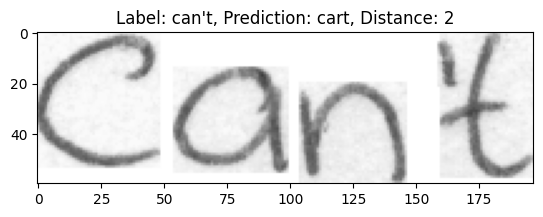

In [12]:
if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm

    model = ImageToWordModel(
        model_path="Models/08_handwriting_recognition_torch/202306131539/model.onnx")

    df = pd.read_csv(
        "Models/08_handwriting_recognition_torch/202306131539/val.csv").values.tolist()

    accum_cer = []
    for image_path, label in tqdm(df):
        image = cv2.imread(image_path)

        prediction_text = model.predict(image)

        cer, distance = get_cer(prediction_text, label)
        print(
            f"Image: {image_path}, Label: {label}, Prediction: {prediction_text}, CER: {cer}, Distance: {distance} ")
        
        save_image(image_path, label, prediction_text, distance)

        accum_cer.append(cer)

    print(f"Average CER: {np.average(accum_cer)}")